# Preliminary operations

## Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive/My Drive/polimi/ANN&DL

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
/gdrive/My Drive/polimi/ANN&DL


## Libraries and seed

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import random
import glob
import imageio
from PIL import Image
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler,  StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pickle

!pip install scikeras 
from scikeras.wrappers import KerasClassifier

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.9.2


In [ ]:
!pip install scikit-optimize
from skopt import BayesSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Functions definition

In [ ]:
def data_processing(data, target):

  X_train_val, X_test, y_train_val, y_test = train_test_split(data, target, test_size = 0.1, random_state=seed, stratify=target)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state=seed, stratify=y_train_val)

  scaler=RobustScaler()
  scaler = scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
  pickle.dump(scaler, open('scalers/scaler.sav', 'wb'))

  ss = pickle.load(open('scalers/scaler.sav', 'rb'))
  X_train_scaled = ss.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_val_scaled = ss.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
  X_test_scaled = ss.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

  y_train_cat = tf.keras.utils.to_categorical(y_train)
  y_val_cat = tf.keras.utils.to_categorical(y_val)
  y_test_cat = tf.keras.utils.to_categorical(y_test)

  print(X_train_scaled.shape, y_train.shape, y_train_cat.shape)
  print(X_val_scaled.shape, y_val.shape, y_val_cat.shape)
  print(X_test_scaled.shape, y_test.shape, y_test_cat.shape)


  return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat

In [ ]:
def evaluate_model_f(file_name, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from file """
  
  model = tfk.models.load_model(file_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": file_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

In [ ]:
def evaluate_model_m(model, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from trained model variable """
  
  predictions = model.predict(test_set)
  metrics= {
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(15,15))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

# Data preparation

```
Time series:
  n. observations: 2429
  observation's length: 36 samples
  n. channel per observation: 6

Number of classes: 12
```



In [ ]:
data = np.load('original_dataset/x_train.npy')
target = np.load('original_dataset/y_train.npy')
print(data.shape)
print(target.shape)

(2429, 36, 6)
(2429,)


In [ ]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat= data_processing(data, target)

(1967, 36, 6) (1967,) (1967, 12)
(219, 36, 6) (219,) (219, 12)
(243, 36, 6) (243,) (243, 12)


In [ ]:
y_train_n=y_train
y_val_n=y_val
y_test_n=y_test

In [ ]:
classes = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"
}

In [ ]:
X_train = X_train_scaled
y_train = y_train_cat
X_val = X_val_scaled
y_val = y_val_cat
X_test = X_test_scaled
y_test = y_test_cat
input_shape = X_train.shape[1:]
n_output = y_train.shape[-1]

In [ ]:
batch_size = 64
learning_rate = 5e-5
epochs = 200

#GAN


Generative Adversarial Networks (GANs) are a type of deep learning model designed to generate new, previously unseen data that is similar to a training dataset. They do this by training two deep neural networks, a generator and a discriminator, to compete with each other. The generator tries to produce synthetic data that is similar to the training data, while the discriminator tries to distinguish the synthetic data from the real training data.

### Load and process data

In [ ]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 36.5 MB/s 


Zalando dataset where the rows are clothes

In [ ]:
X = np.concatenate([X_train, X_val, X_test],axis=0)
X = np.expand_dims(((X-127.5)/127.5),axis=-1).astype('float32') 
y = np.concatenate([y_train_n,y_val_n,y_test_n],axis=0)
X.shape, y.shape

((2429, 36, 6, 1), (2429,))

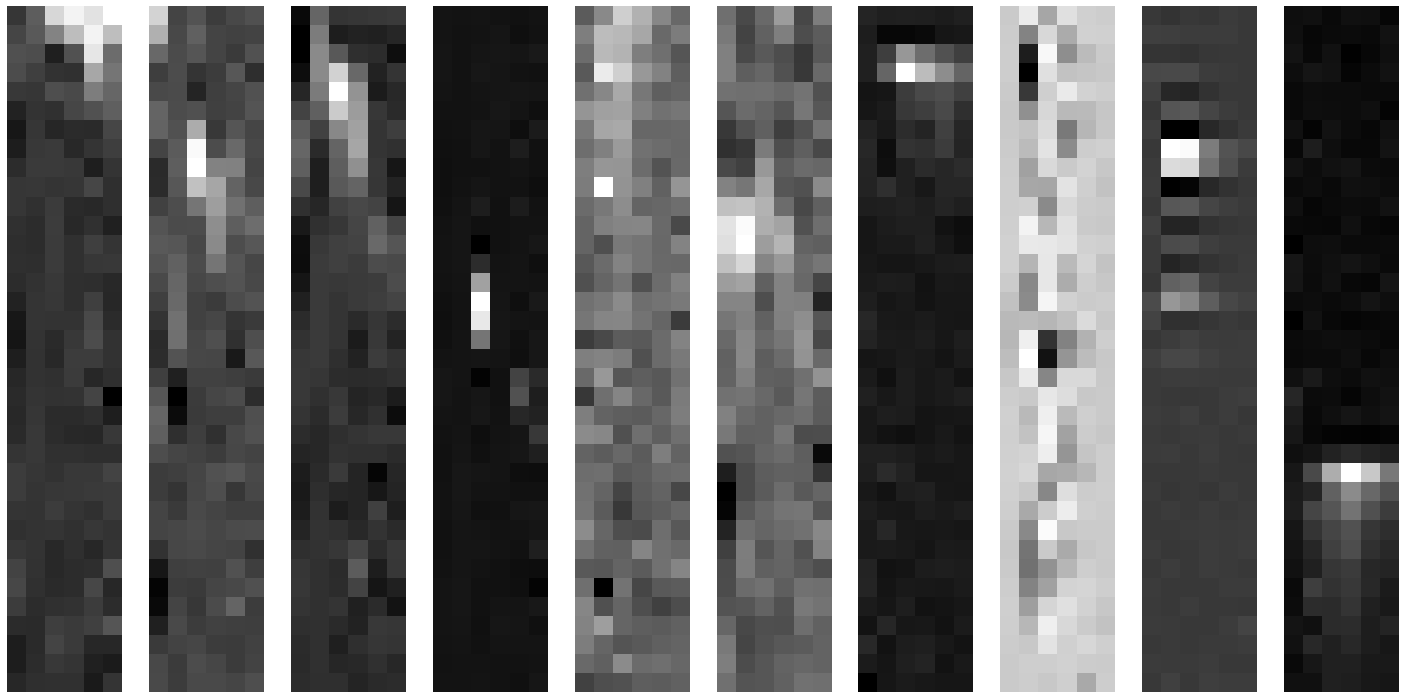

In [ ]:
# Inspect the data
fig, axes = plt.subplots(1, 10, figsize=(20,10))
for i in range(10):
    ax = axes[i%10]
    ax.imshow(np.squeeze(X[i]), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
print('Data shape', X.shape)
print('Data min {:0.2f}\nData max {:0.2f}\nData mean {:0.2f}\nData std {:0.2f}'.format(
    X.min(), X.max(), X.mean(), X.std()))

Data shape (2429, 36, 6, 1)
Data min -16.38
Data max 57.92
Data mean -0.98
Data std 0.55


We can see that the mean after the normalization is not exactly zero though the result is not bad

In [ ]:
input_shape = X.shape[1:]
input_shape

(36, 6, 1)

In [ ]:
y_classes=list(map(np.argmax, y_train))

In [ ]:
image_size = input_shape[0]
num_classes = len(np.unique(y_classes))
num_channels = input_shape[-1]

In [ ]:
num_classes

12

### Deep Convolutional Conditional GAN

Now we build the generator. The generator tries to produce synthetic data that is similar to the training data

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128)]             0         
                                                                 
 dense0 (Dense)              (None, 1024)              131072    
                                                                 
 bn0 (BatchNormalization)    (None, 1024)              4096      
                                                                 
 activation0 (LeakyReLU)     (None, 1024)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 64)          0         
                                                                 
 upsampling1 (UpSampling2D)  (None, 8, 8, 64)          0         
                                                                 
 conv1 (Conv2D)              (None, 8, 8, 64)          36

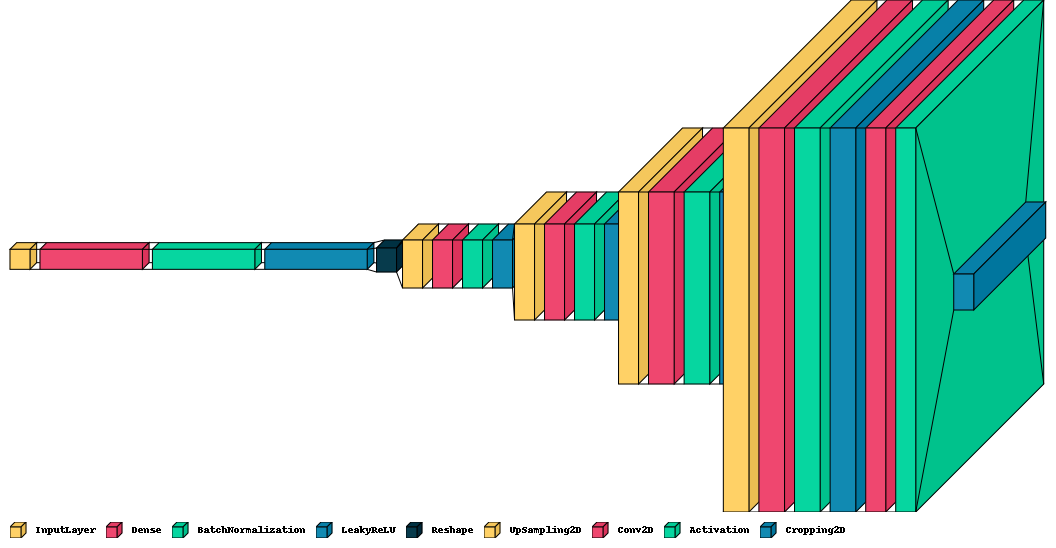

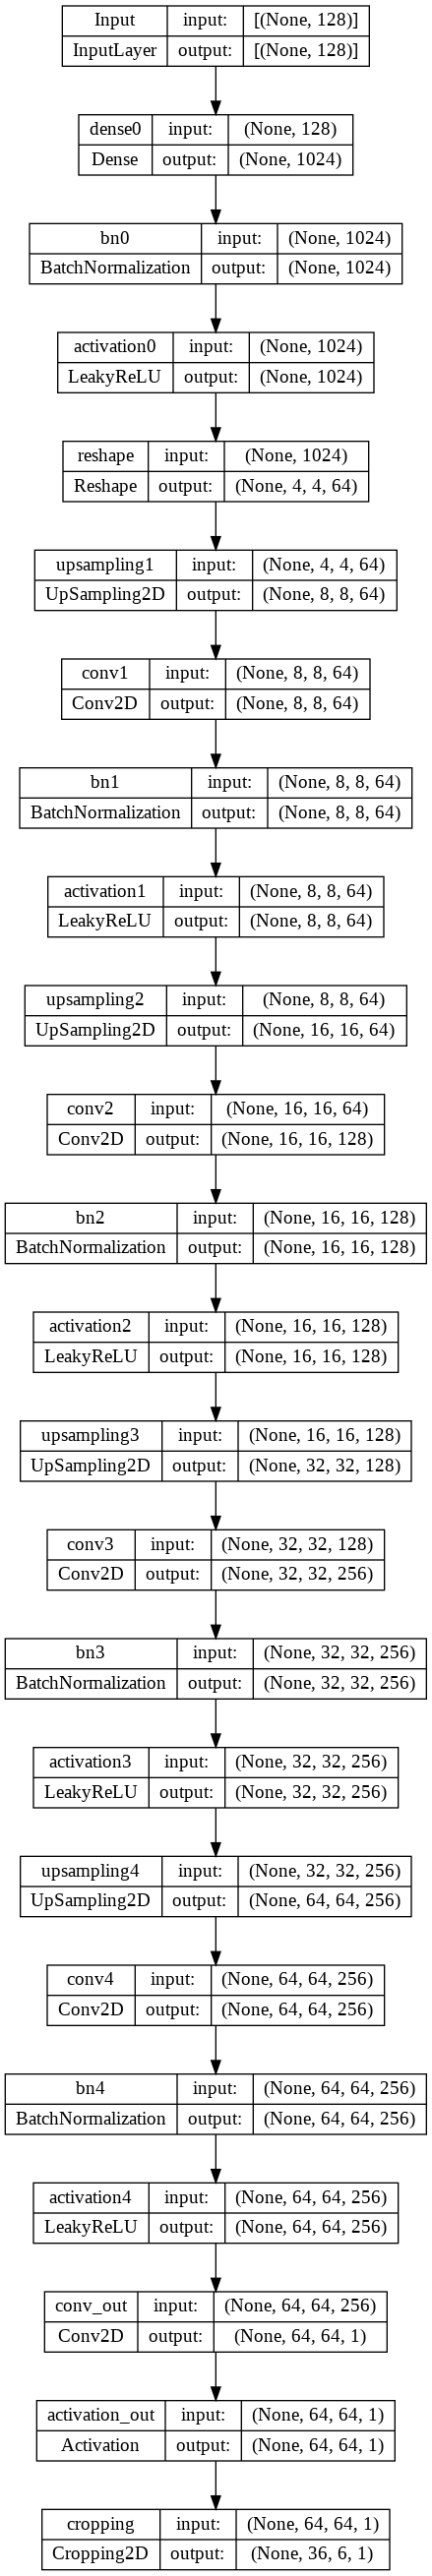

In [ ]:
latent_dim = 128

def get_dc_generator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the generator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Dense(4*4*64, use_bias=False, name='dense0')(input_layer)  #we typically start from a 1d dimension
    #use_bias=False, so we are removing the bias. In this way we are forcing the generator to follow exactly
    #the distribution we have in input. The ability should be to create data without moving on the y-axis
    x = tfkl.BatchNormalization(name='bn0')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation0')(x)
    x = tfkl.Reshape((4,4,64))(x)   #we reshape it in order to make it convolution


    x = tfkl.UpSampling2D(name='upsampling1')(x)
    x = tfkl.Conv2D(64, 3, padding='same', use_bias=False, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.UpSampling2D(name='upsampling2')(x)
    x = tfkl.Conv2D(128, 3, padding='same', use_bias=False, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.UpSampling2D(name='upsampling3')(x)
    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.UpSampling2D(name='upsampling4')(x)
    x = tfkl.Conv2D(256, 3, padding='same', use_bias=False, name='conv4')(x)
    x = tfkl.BatchNormalization(name='bn4')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation4')(x)

    x = tfkl.Conv2D(1, 3, padding='same', use_bias=False, name='conv_out')(x)
    x = tfkl.Activation('tanh', name='activation_out')(x) #to bound the output to be in the range -1,1
    output_layer = tfkl.Cropping2D((14,29), name='cropping')(x) #to reshape the output to be 28*28
    #Since we have in the discriminator the zeropadding the output will be trasnformed from
    #28*28 to 32*32

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='generator')

    # Return the model
    return model
generator = get_dc_generator(latent_dim)
generator.summary()
display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='vanilla_generator.png')

The discriminator tries to distinguish the synthetic data from the real training data.

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 36, 6, 1)]        0         
                                                                 
 padding (ZeroPadding2D)     (None, 40, 10, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 20, 5, 64)         640       
                                                                 
 bn1 (BatchNormalization)    (None, 20, 5, 64)         256       
                                                                 
 activation1 (LeakyReLU)     (None, 20, 5, 64)         0         
                                                                 
 conv2 (Conv2D)              (None, 10, 3, 128)        73856     
                                                                 
 bn2 (BatchNormalization)    (None, 10, 3, 128)      

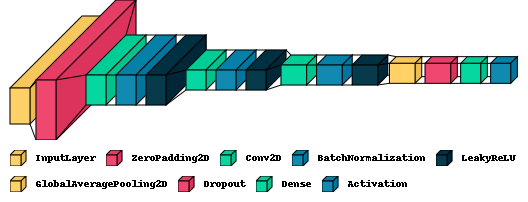

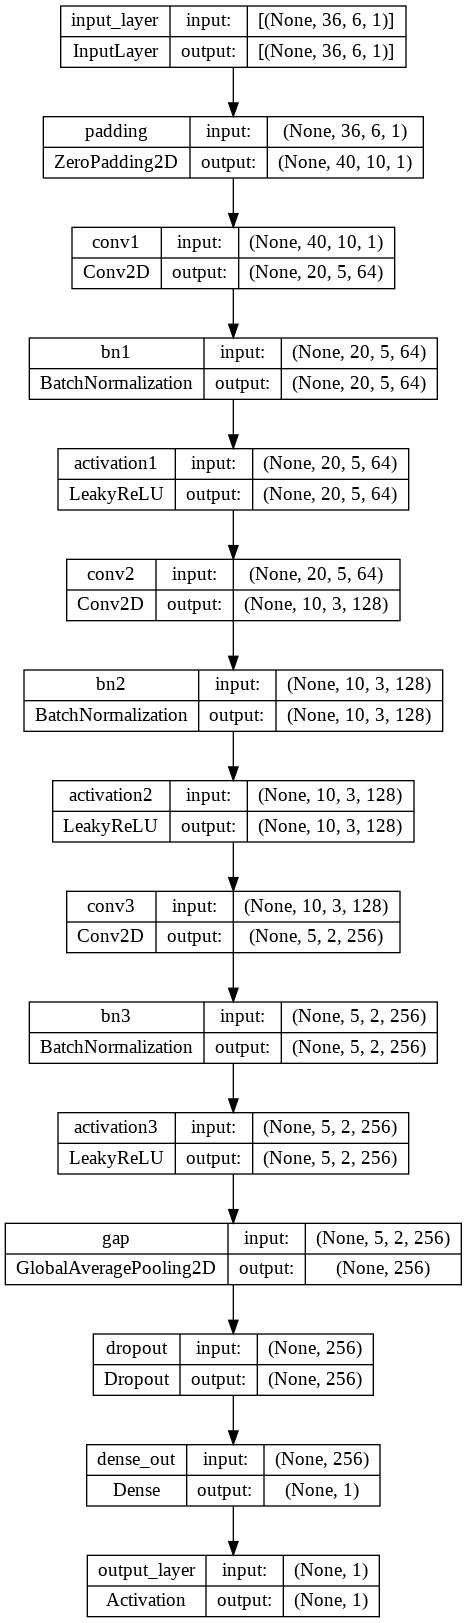

In [ ]:
def get_dc_discriminator(input_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the discriminator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2), name='padding')(input_layer)    #Zero padding to have the same shape of the input

#Classical way to create a convolutional layer is to have a Convolutional layer, batch normalization and the activation function
    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(.5, seed=seed, name='dropout')(x)
    x = tfkl.Dense(1, name='dense_out')(x)
    output_layer = tfkl.Activation('sigmoid', name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='discriminator')

    # Return the discriminator
    return model
discriminator = get_dc_discriminator(input_shape)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='vanilla_discriminator.png')

In [ ]:
latent_dim = 128
generator_in_channels = latent_dim + num_classes #we compute the one-hot encoding of the labels and we concatenate it batch level with the input of the generator (noise)
discriminator_in_channels = num_channels + num_classes #we increase the number of channels of the images according to the number of classes
print(generator_in_channels, discriminator_in_channels)

140 18


In [ ]:
conditional_generator_input = (generator_in_channels)
conditional_discriminator_input = (image_size, 6, discriminator_in_channels)
conditional_discriminator_input, conditional_generator_input

((36, 6, 18), 140)

In [ ]:
discriminator = get_dc_discriminator(conditional_discriminator_input)
discriminator.summary()
display(visualkeras.layered_view(discriminator, legend=True, scale_xy=6))
tfk.utils.plot_model(discriminator, show_shapes=True, expand_nested=True, to_file='conditional_discriminator.png')

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 140)]             0         
                                                                 
 dense0 (Dense)              (None, 1024)              143360    
                                                                 
 bn0 (BatchNormalization)    (None, 1024)              4096      
                                                                 
 activation0 (LeakyReLU)     (None, 1024)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 upsampling1 (UpSampling2D)  (None, 8, 8, 64)          0         
                                                                 
 conv1 (Conv2D)              (None, 8, 8, 64)          36

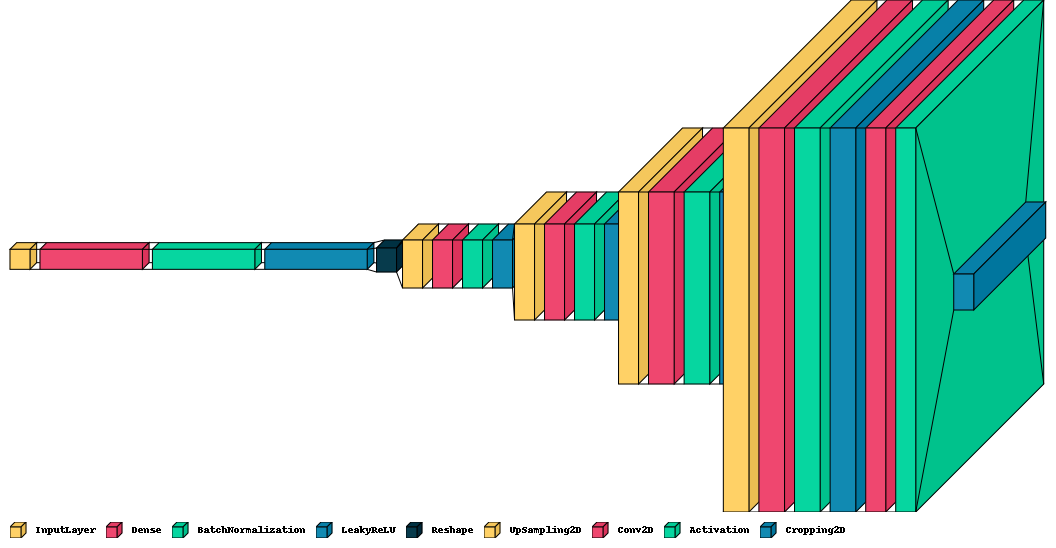

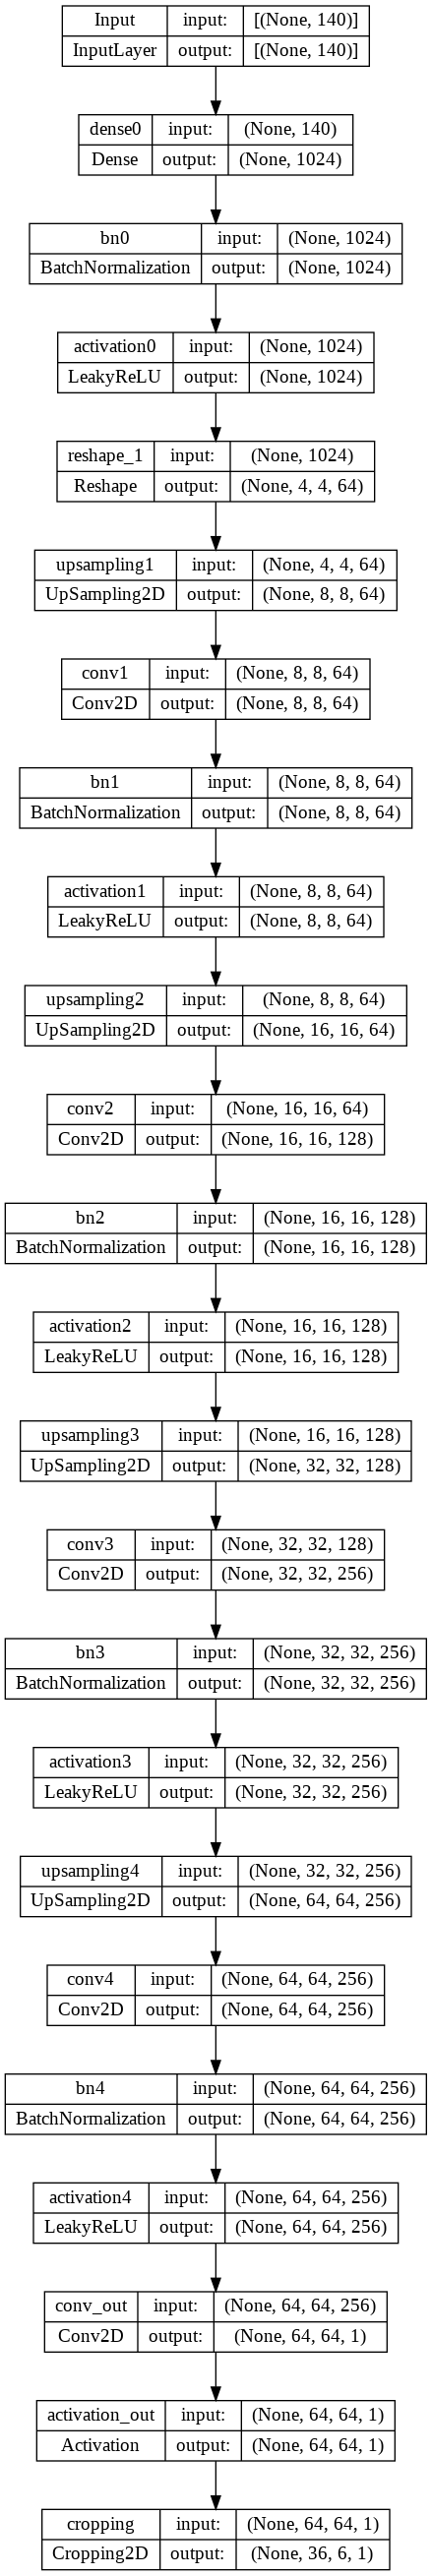

In [ ]:
generator = get_dc_generator(conditional_generator_input)
generator.summary()
display(visualkeras.layered_view(generator, legend=True, scale_xy=6))
tfk.utils.plot_model(generator, show_shapes=True, expand_nested=True, to_file='conditional_generator.png')

In [ ]:
class ConditionalGAN(tfk.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

        self.loss_tracker = tfk.metrics.Mean(name="loss")
        self.d_loss_tracker = tfk.metrics.Mean(name="d_loss")
        self.g_loss_tracker = tfk.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.d_loss_tracker,
            self.g_loss_tracker
        ]

    @tf.function
    def train_step(self, data):
        real_images, one_hot_labels = data   #The input is a tensor containing images and labels, this line is to unpack the tensor
        batch_size = tf.shape(real_images)[0]
        
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * 6])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, 6, num_classes))
        
        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        z = tf.concat([z, one_hot_labels], -1)  #we are concateneting the noise with the one hot encoded labels. So, we are saying that in each batch we want to have the same class for generated images and real ones.

        # Generate fake images from z
        generated_images = self.generator(z)
        print(generated_images.shape)
        
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        # Combine generated images and real ones
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)

        # Create labels so that fake images correspond to class 0 and real images to class 1
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(labels, predictions))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        loss = d_loss

        # Sample random points in the latent space
        z = tf.random.normal(shape=(batch_size, self.latent_dim))
        z = tf.concat([z, one_hot_labels], axis=1)

        # Create misleading labels for fake images so that they correspond to class 1
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator 
        with tf.GradientTape() as tape:
            fake_images = self.generator(z)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            misleading_predictions = self.discriminator(fake_image_and_labels)
            g_loss = tf.reduce_mean(tfk.losses.binary_crossentropy(misleading_labels, misleading_predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        loss += g_loss

        # Update metrics
        self.loss_tracker.update_state(loss)
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "loss": self.loss_tracker.result(),
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

In [ ]:
class ConditionalGANMonitor(tfk.callbacks.Callback):
    def __init__(self, num_img=10, latent_dim=latent_dim, name='', gray=False):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.name = name
        self.gray = gray

    def on_epoch_end(self, epoch, logs=None):
        tf.random.set_seed(seed)
        os.makedirs(self.name+'temp', exist_ok=True)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        labels = tf.cast(tf.math.floormod(tf.range(0,self.num_img), num_classes), 'float32')
        labels = tfk.utils.to_categorical(labels, num_classes)
        random_latent_vectors = tf.concat([random_latent_vectors,labels],-1)
        generated_images = self.model.generator(random_latent_vectors).numpy()

        fig, axes = plt.subplots(1, self.num_img, figsize=(20,2*self.num_img))
        for i in range(self.num_img):
            img = tfk.preprocessing.image.array_to_img(generated_images[i])
            ax = axes[i%self.num_img]
            if self.gray:
                ax.imshow(np.squeeze(img), cmap='gray')
            else:
                ax.imshow(np.squeeze(img))
            ax.axis('off')
        fig.savefig(self.name+'temp/'+'{:0>5}'.format(epoch)+'.png') 
        plt.tight_layout()
        plt.show()

    def on_train_end(self, logs=None):
        fp_in = self.name+"temp/*.png"
        fp_out = self.name+"_generated_images.gif"
        imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
        img = next(imgs)
        img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=100, optimize=False)    
        shutil.rmtree(self.name+"temp")

In [ ]:
all_labels = tfk.utils.to_categorical(y, num_classes)
dataset = tf.data.Dataset.from_tensor_slices((X, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
y.shape

(2429,)

In [ ]:
cgan = ConditionalGAN(
    discriminator = get_dc_discriminator(conditional_discriminator_input), 
    generator = get_dc_generator(conditional_generator_input), 
    latent_dim = latent_dim
)
cgan.compile(
    d_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer = tfk.optimizers.Adam(learning_rate=learning_rate)
)

In [ ]:
def conditional_sample(model, num_img, latent_dim, fixed=True, gray=False, label=None):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()

    fig, axes = plt.subplots(1, num_img, figsize=(20,2*num_img))
    for i in range(num_img):
        img = tfk.preprocessing.image.array_to_img(generated_images[i])
        ax = axes[i%num_img]
        if gray:
            ax.imshow(np.squeeze(img), cmap='gray')
        else:
            ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def generate_conditional_dataset(model, num_img, latent_dim, fixed=True, label=None):
    if fixed:
        tf.random.set_seed(seed)
    z = tf.random.normal(shape=(num_img, latent_dim))
    if label == None:
        labels = tf.cast(tf.math.floormod(tf.range(0,num_img), num_classes), 'float32')
    else:
        labels = tf.cast(tf.math.floormod(tf.ones(num_img)*label, num_classes), 'float32')
    labels = tfk.utils.to_categorical(labels, num_classes)
    z = tf.concat([z,labels],-1)
    generated_images = model(z).numpy()
    return generated_images, labels

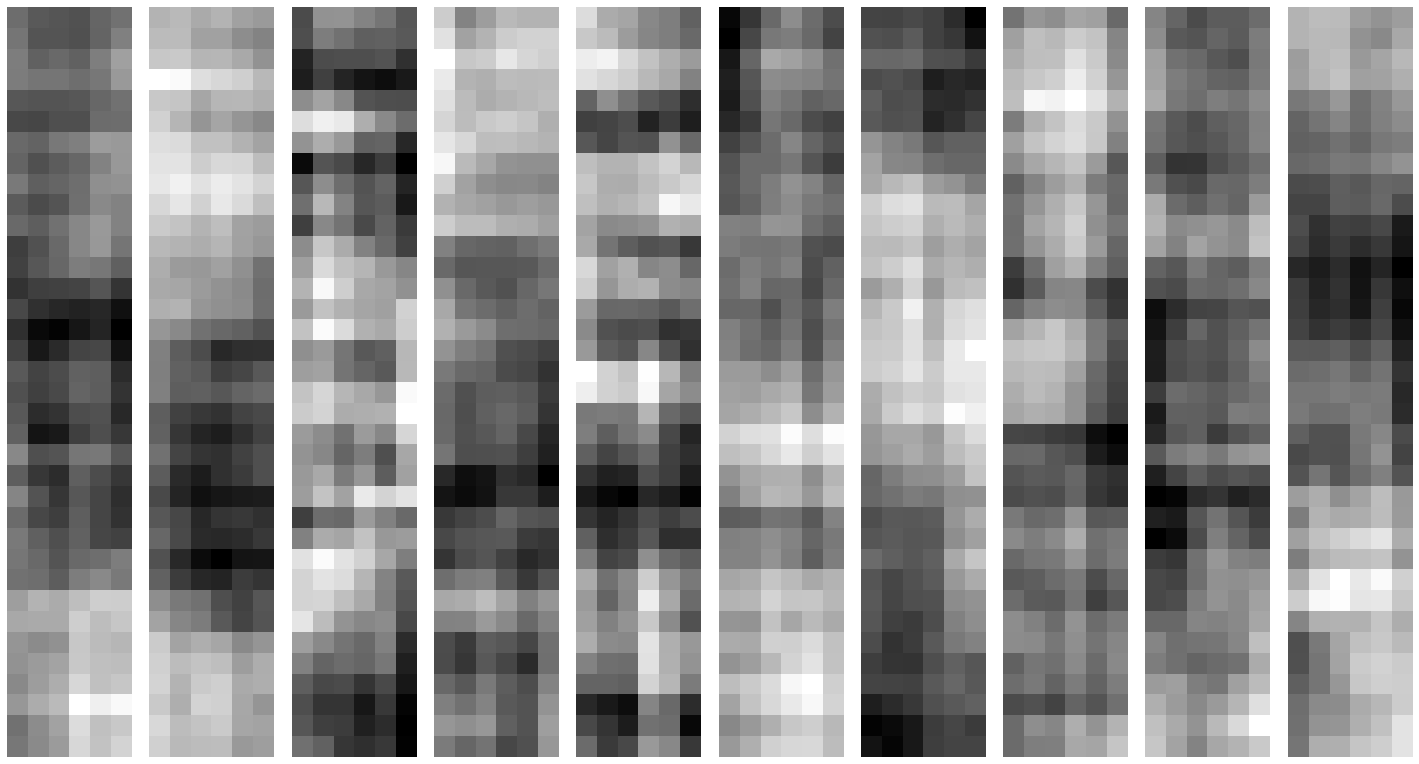

In [ ]:
conditional_sample(cgan.generator, 10, latent_dim, gray=True)

Epoch 1/200
(None, 36, 6, 1)
(None, 36, 6, 1)


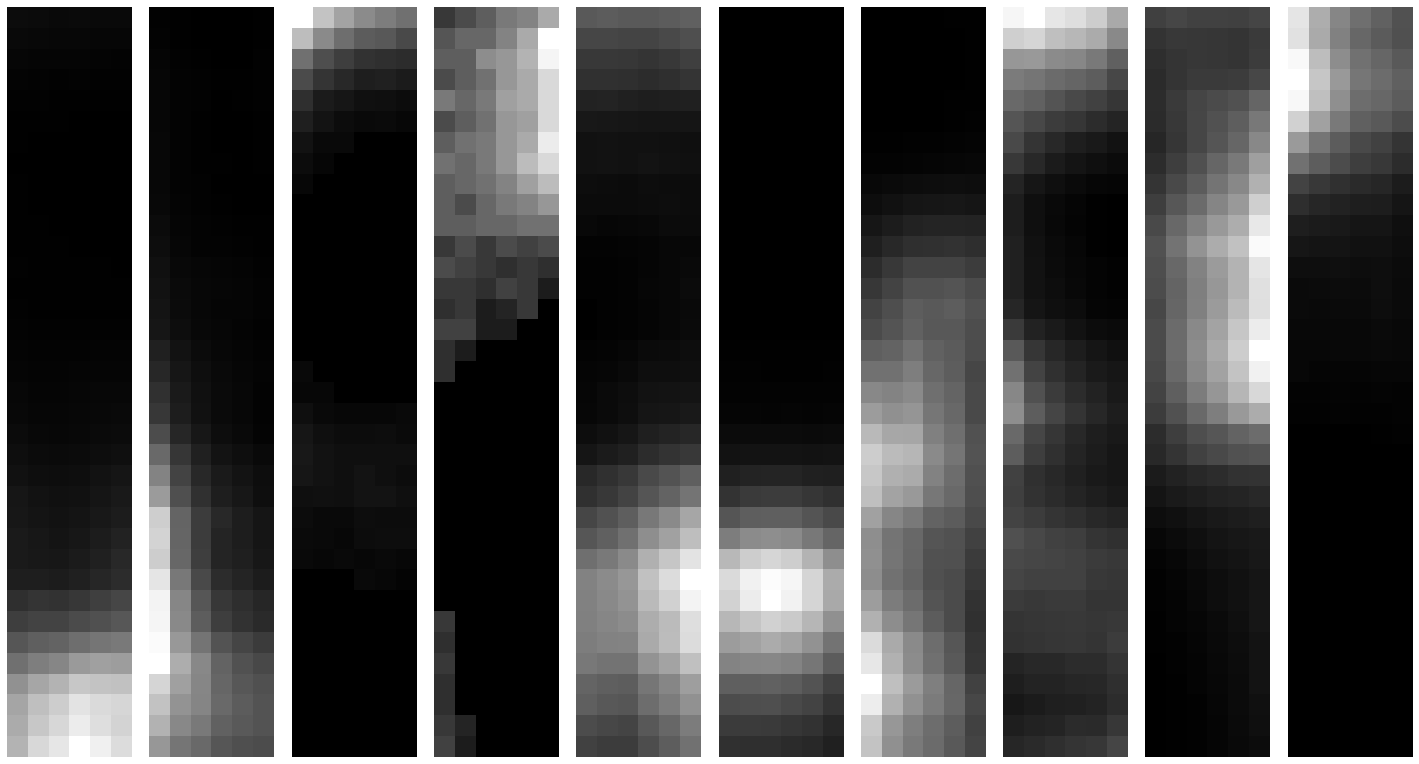

38/38 - 20s - loss: 1.3378 - d_loss: 0.6931 - g_loss: 0.6447 - 20s/epoch - 525ms/step
Epoch 2/200


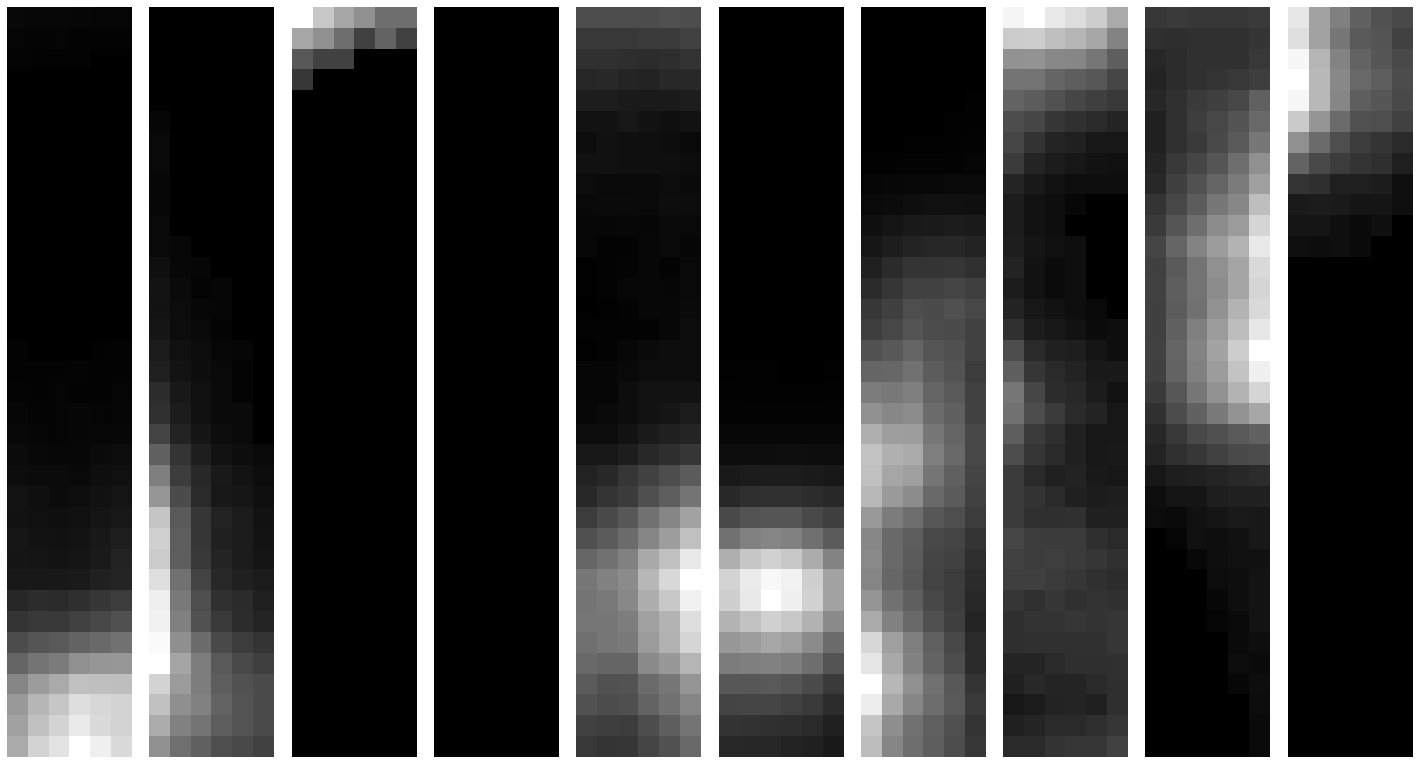

38/38 - 9s - loss: 1.3856 - d_loss: 0.6923 - g_loss: 0.6933 - 9s/epoch - 224ms/step
Epoch 3/200


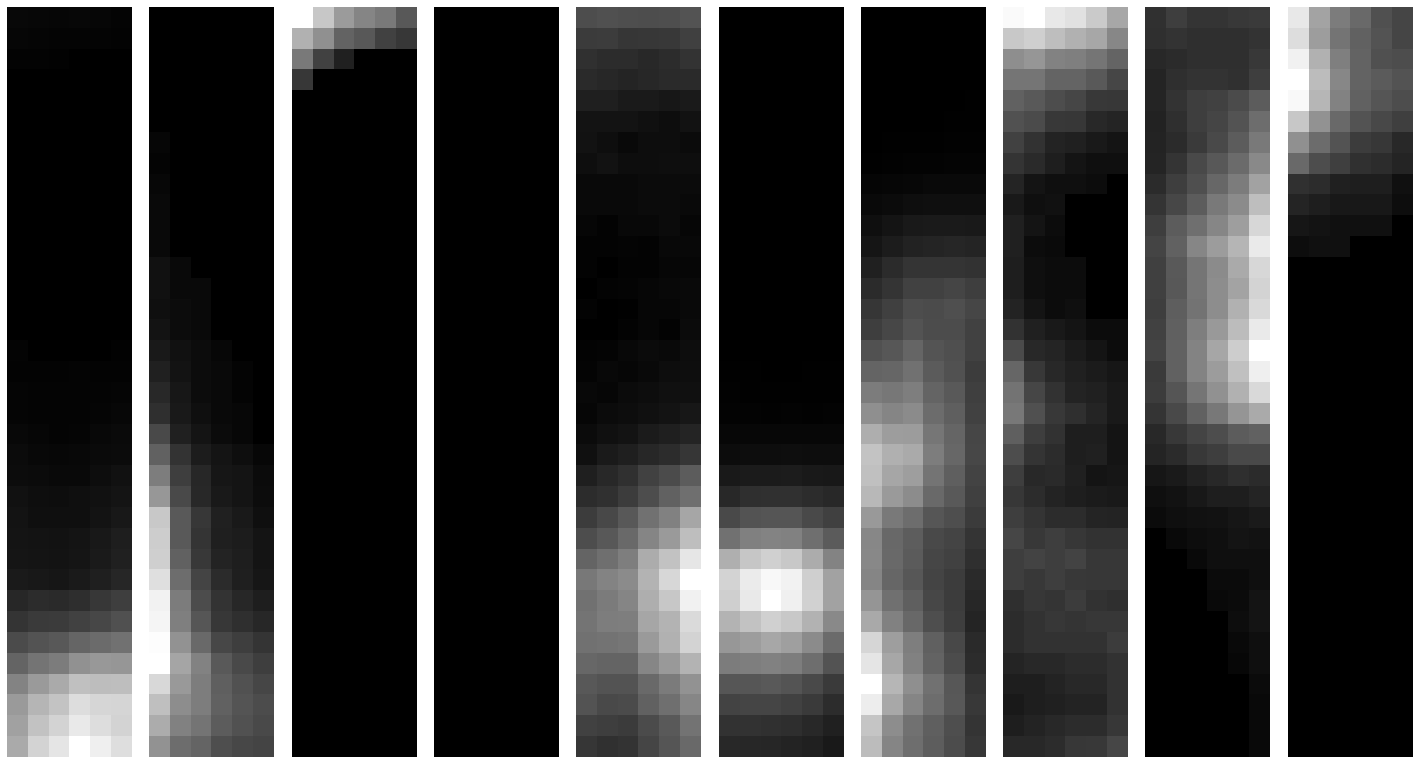

38/38 - 9s - loss: 1.3797 - d_loss: 0.6902 - g_loss: 0.6895 - 9s/epoch - 226ms/step
Epoch 4/200


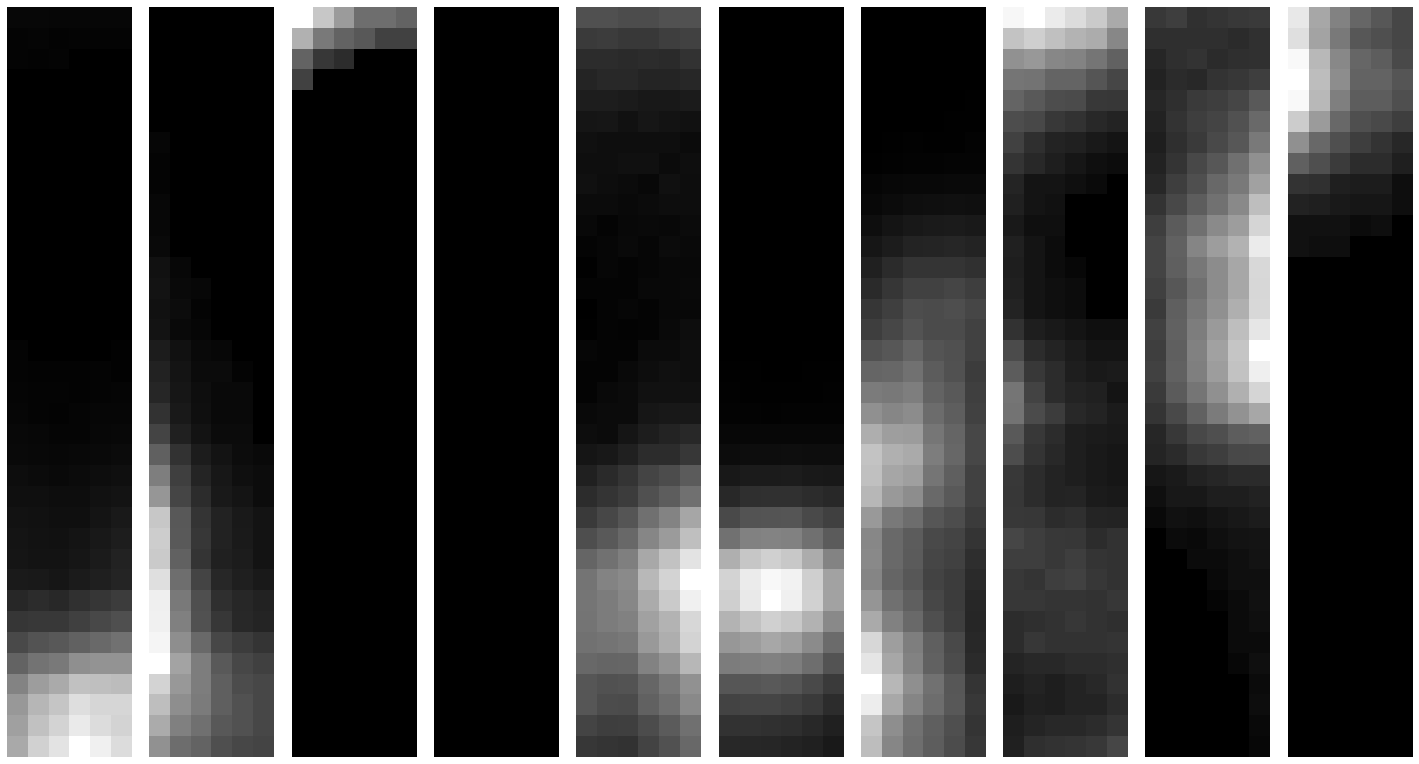

38/38 - 9s - loss: 1.3810 - d_loss: 0.6876 - g_loss: 0.6934 - 9s/epoch - 231ms/step
Epoch 5/200


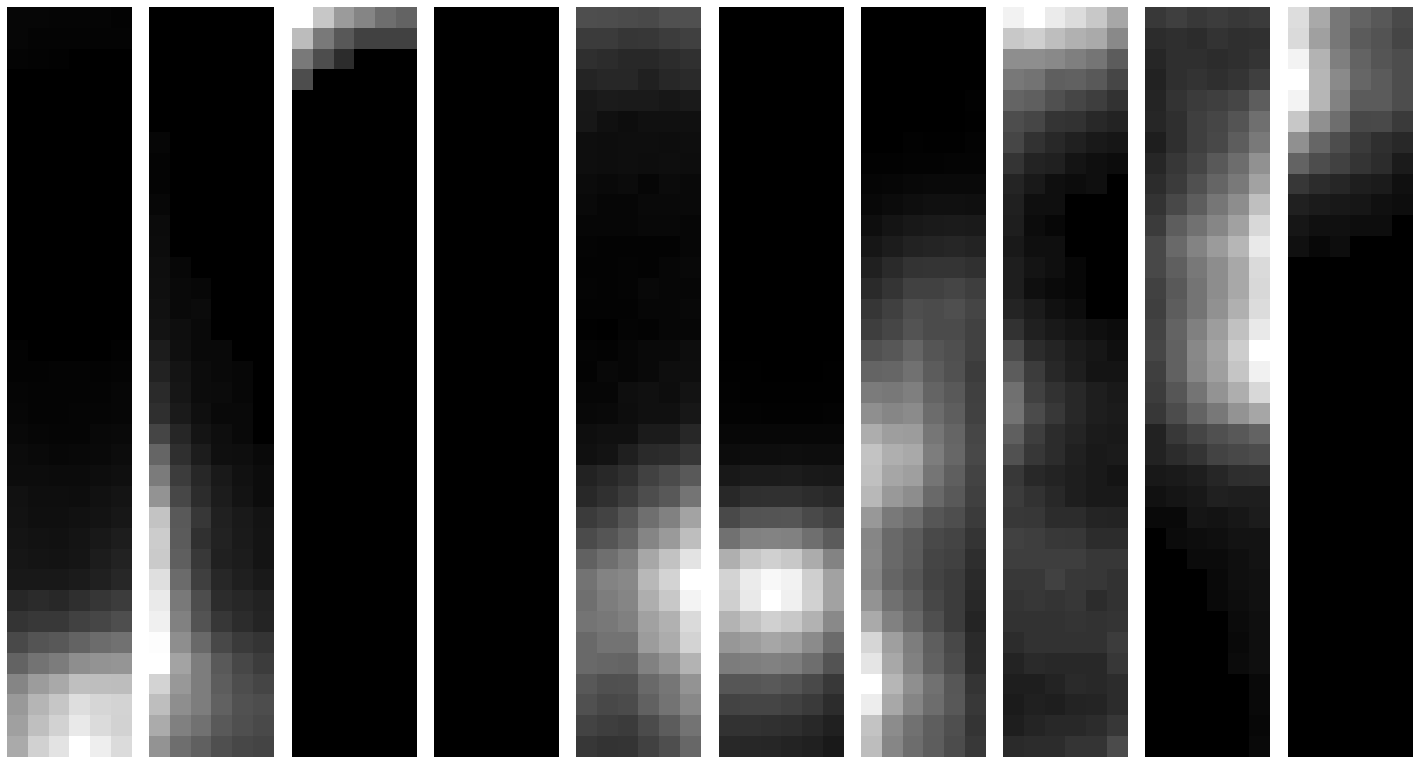

38/38 - 9s - loss: 1.3815 - d_loss: 0.6845 - g_loss: 0.6970 - 9s/epoch - 230ms/step
Epoch 6/200


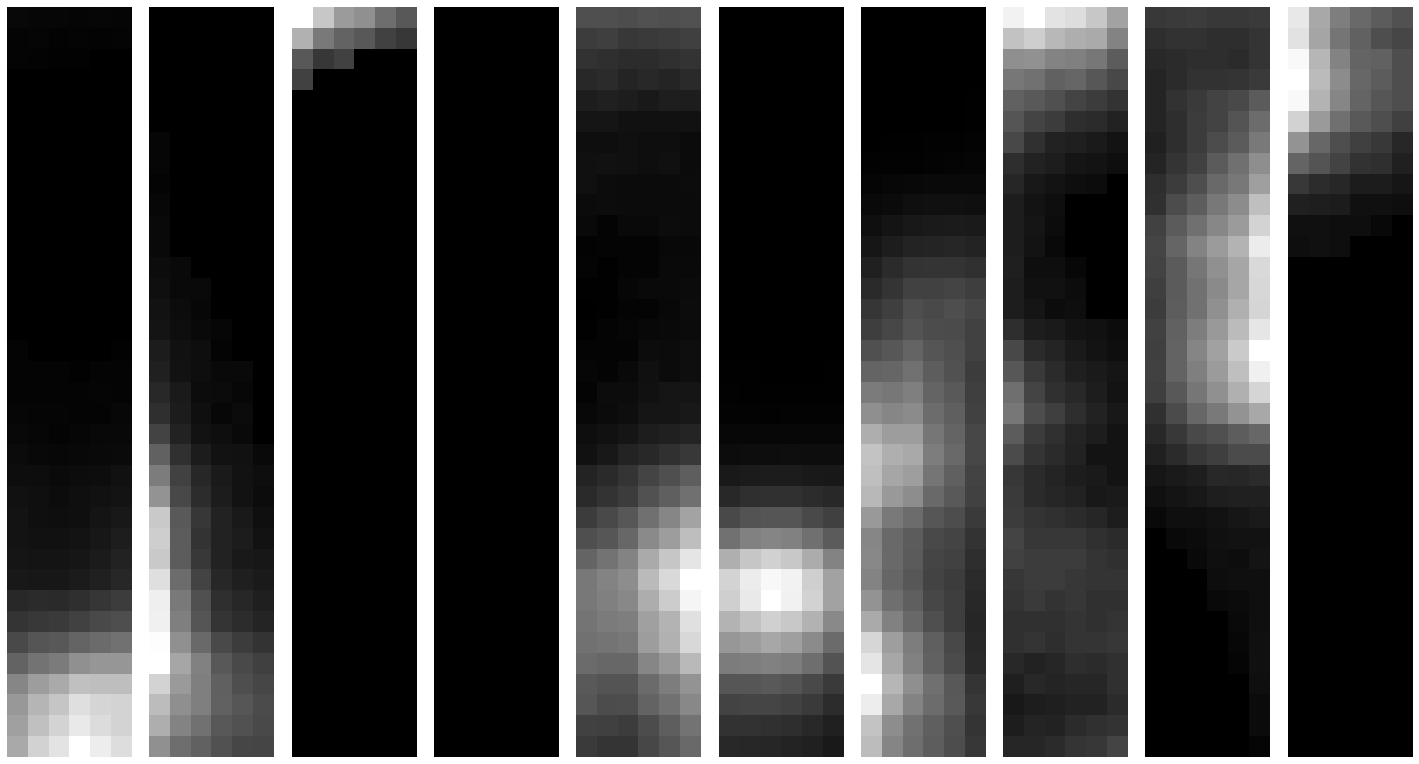

38/38 - 9s - loss: 1.3843 - d_loss: 0.6811 - g_loss: 0.7032 - 9s/epoch - 231ms/step
Epoch 7/200


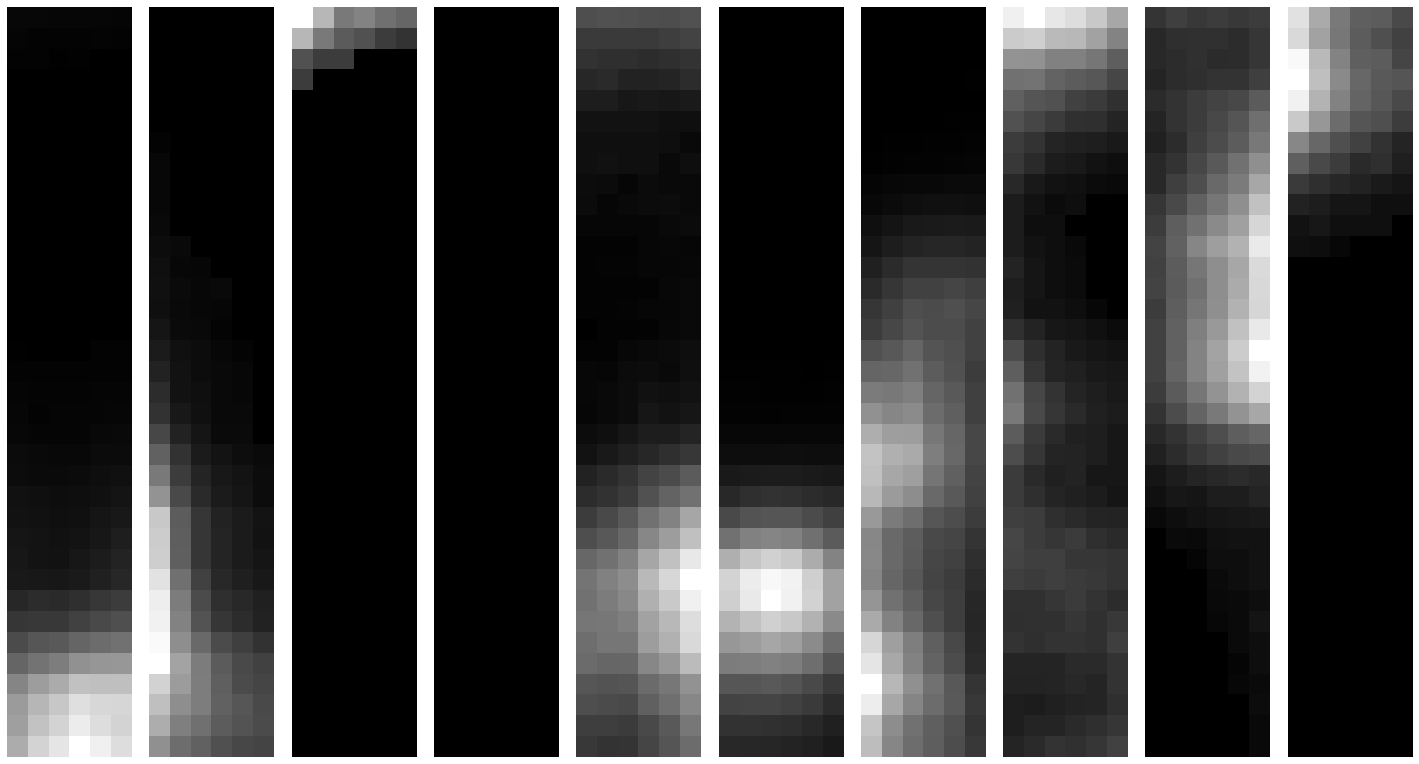

38/38 - 9s - loss: 1.3862 - d_loss: 0.6772 - g_loss: 0.7091 - 9s/epoch - 246ms/step
Epoch 8/200


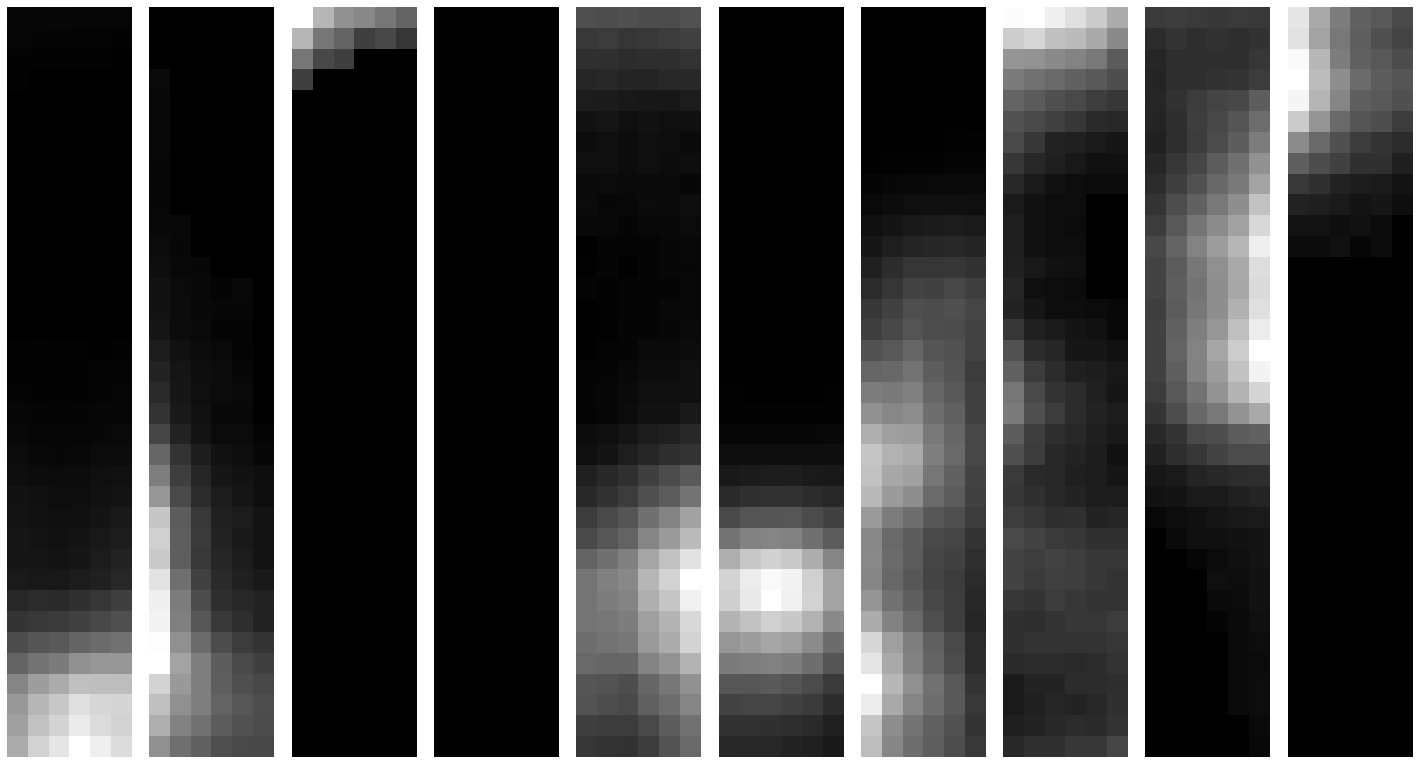

38/38 - 9s - loss: 1.3908 - d_loss: 0.6727 - g_loss: 0.7181 - 9s/epoch - 235ms/step
Epoch 9/200


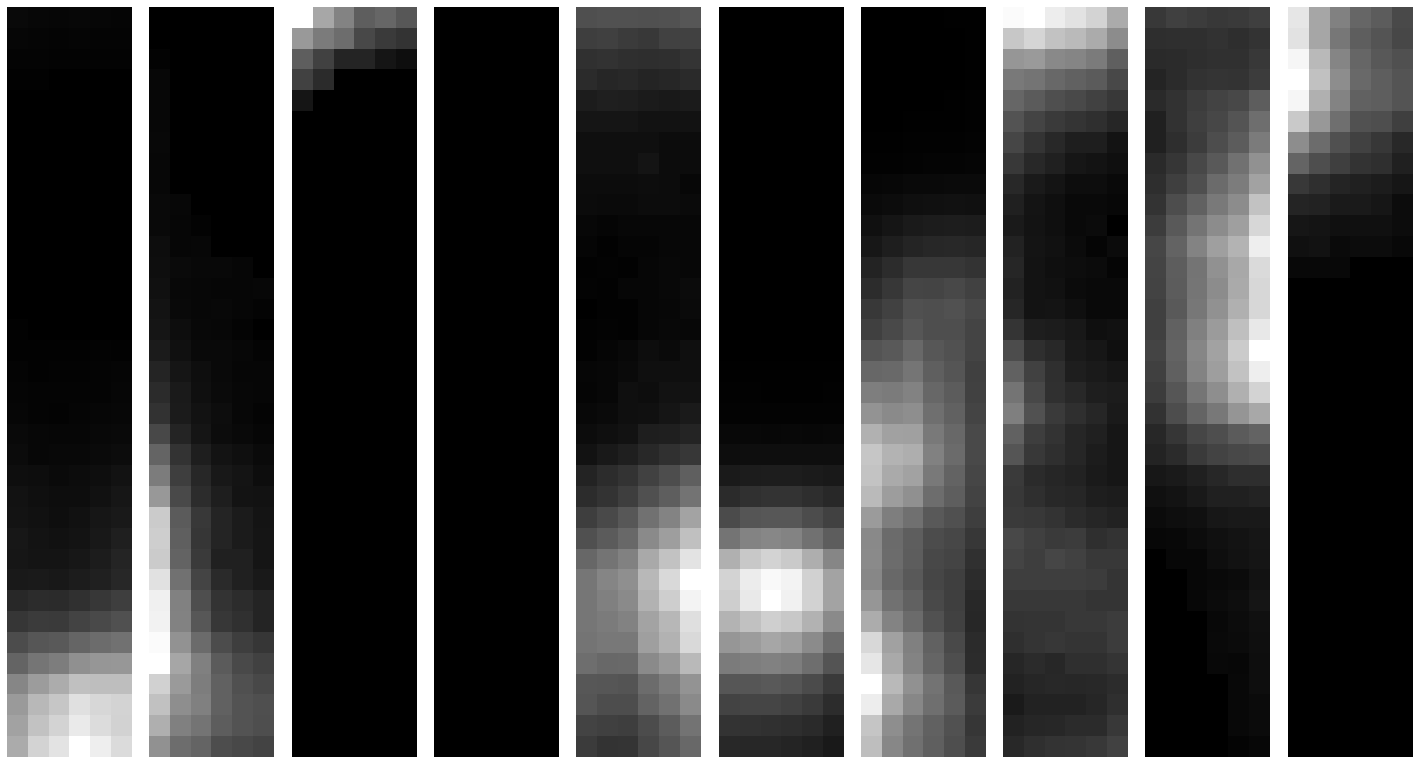

38/38 - 9s - loss: 1.3930 - d_loss: 0.6672 - g_loss: 0.7258 - 9s/epoch - 240ms/step
Epoch 10/200


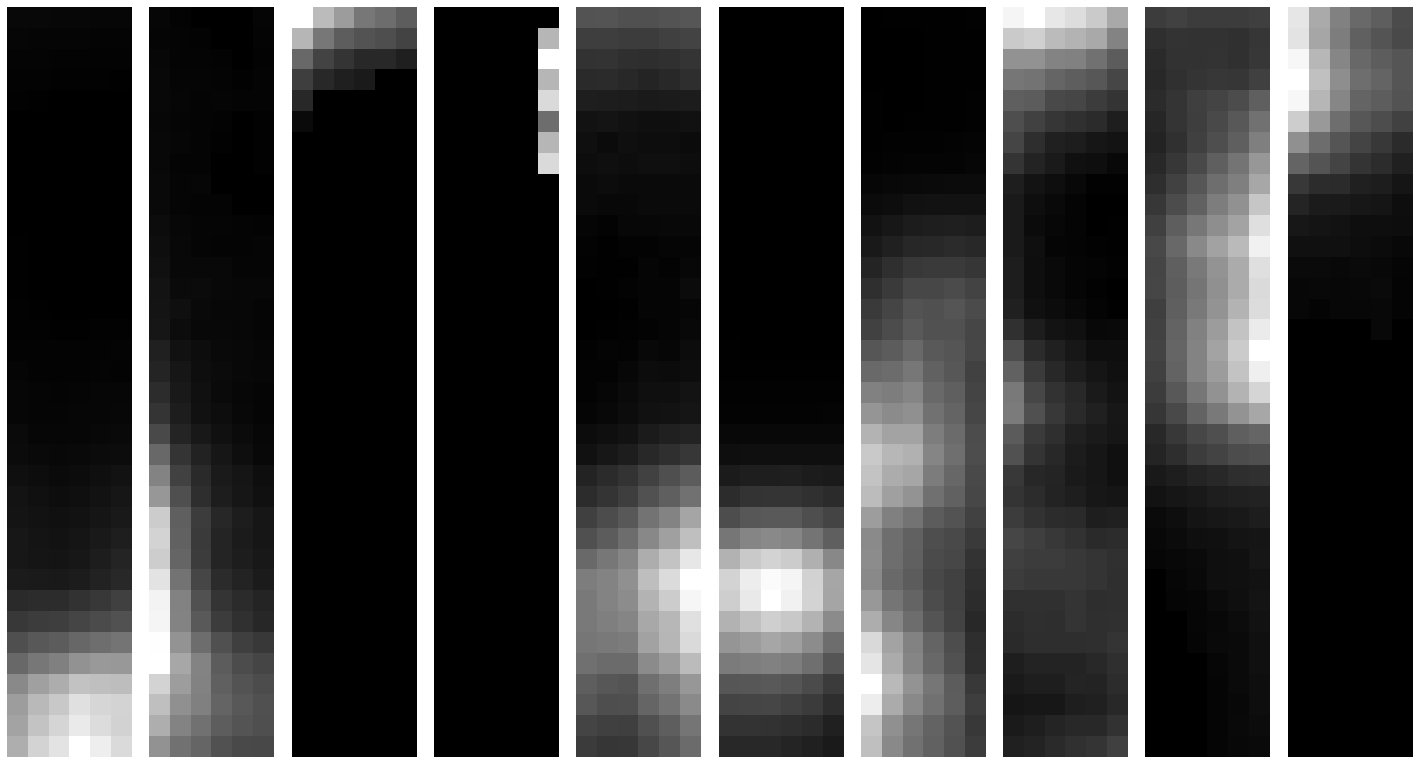

38/38 - 9s - loss: 1.3968 - d_loss: 0.6613 - g_loss: 0.7355 - 9s/epoch - 237ms/step
Epoch 11/200


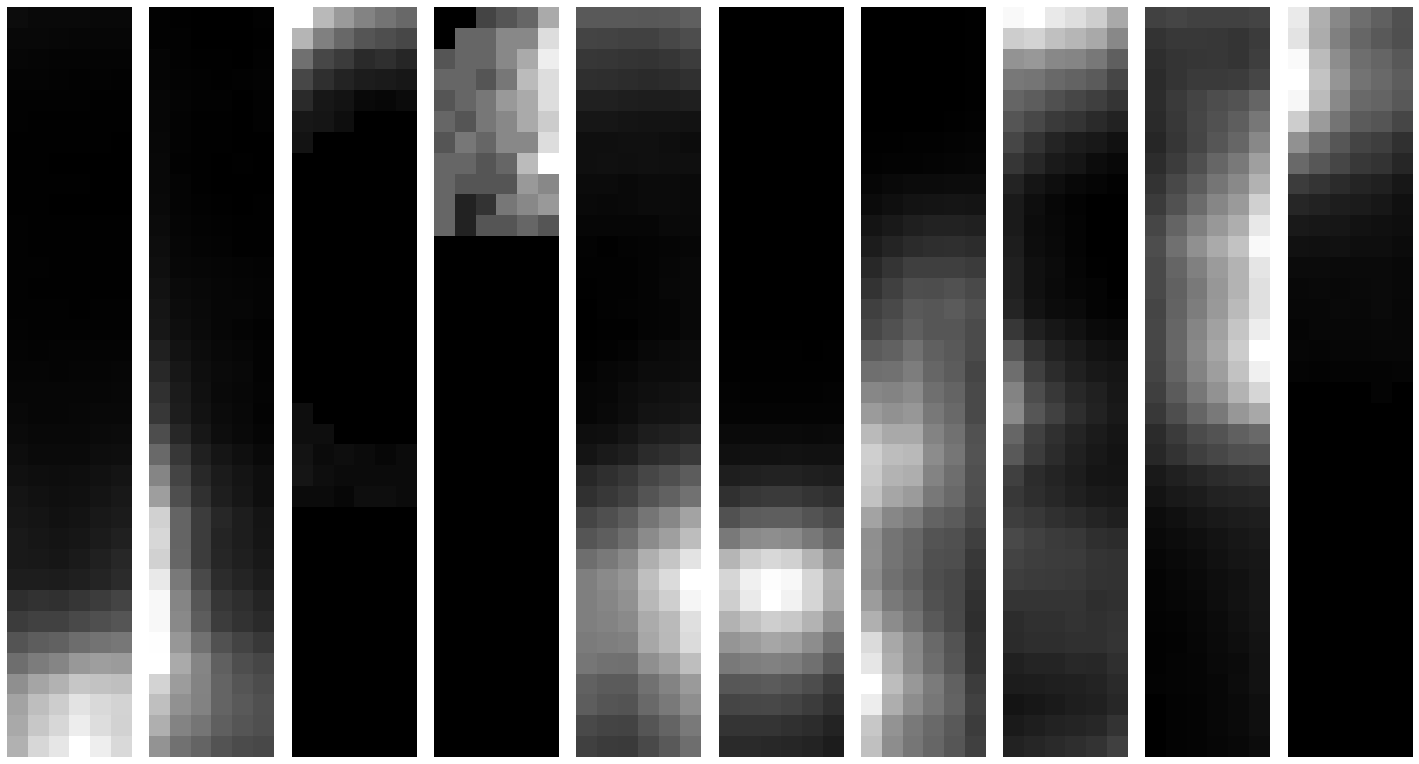

38/38 - 9s - loss: 1.4004 - d_loss: 0.6551 - g_loss: 0.7453 - 9s/epoch - 238ms/step
Epoch 12/200


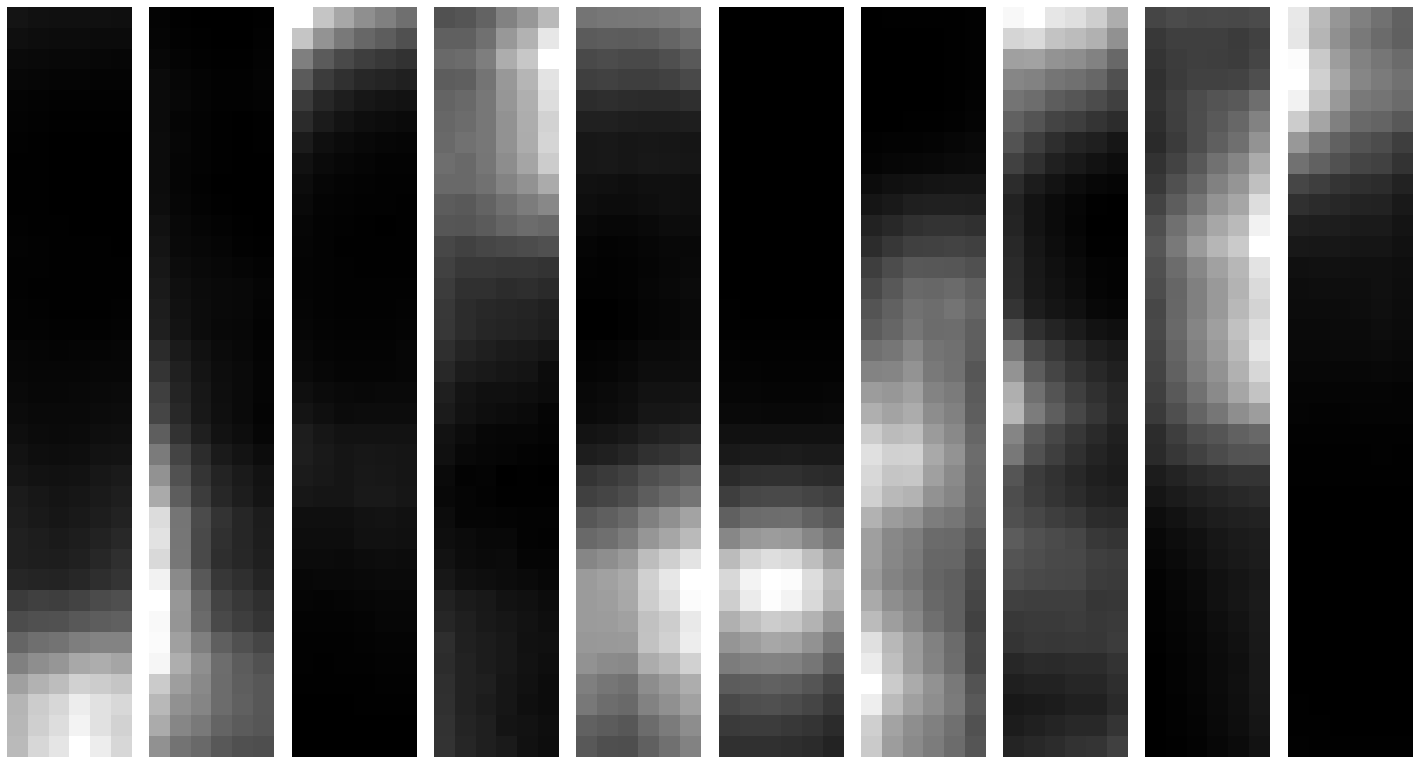

38/38 - 9s - loss: 1.4048 - d_loss: 0.6478 - g_loss: 0.7570 - 9s/epoch - 239ms/step
Epoch 13/200


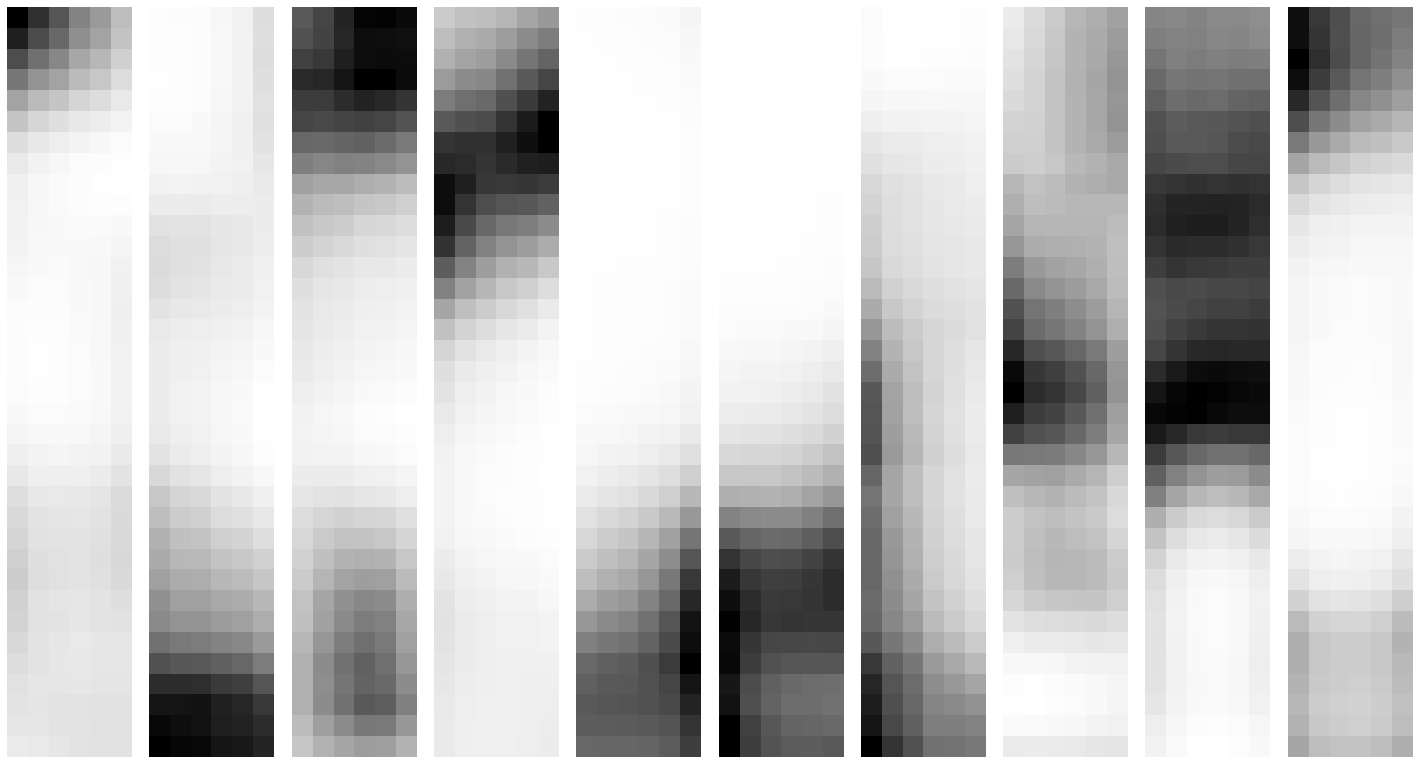

38/38 - 9s - loss: 1.6423 - d_loss: 1.2023 - g_loss: 0.4400 - 9s/epoch - 238ms/step
Epoch 14/200


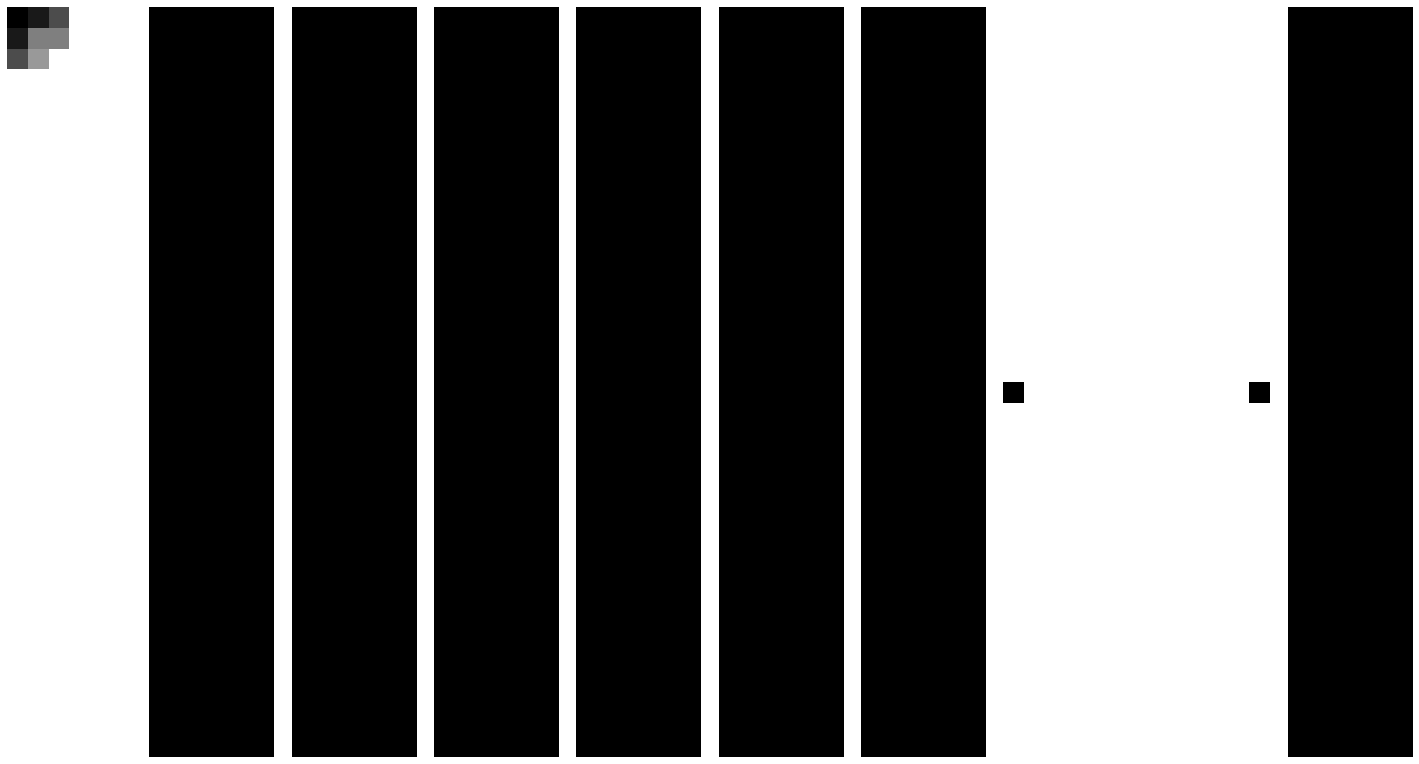

38/38 - 9s - loss: 2.9038 - d_loss: 0.0643 - g_loss: 2.8395 - 9s/epoch - 239ms/step
Epoch 15/200


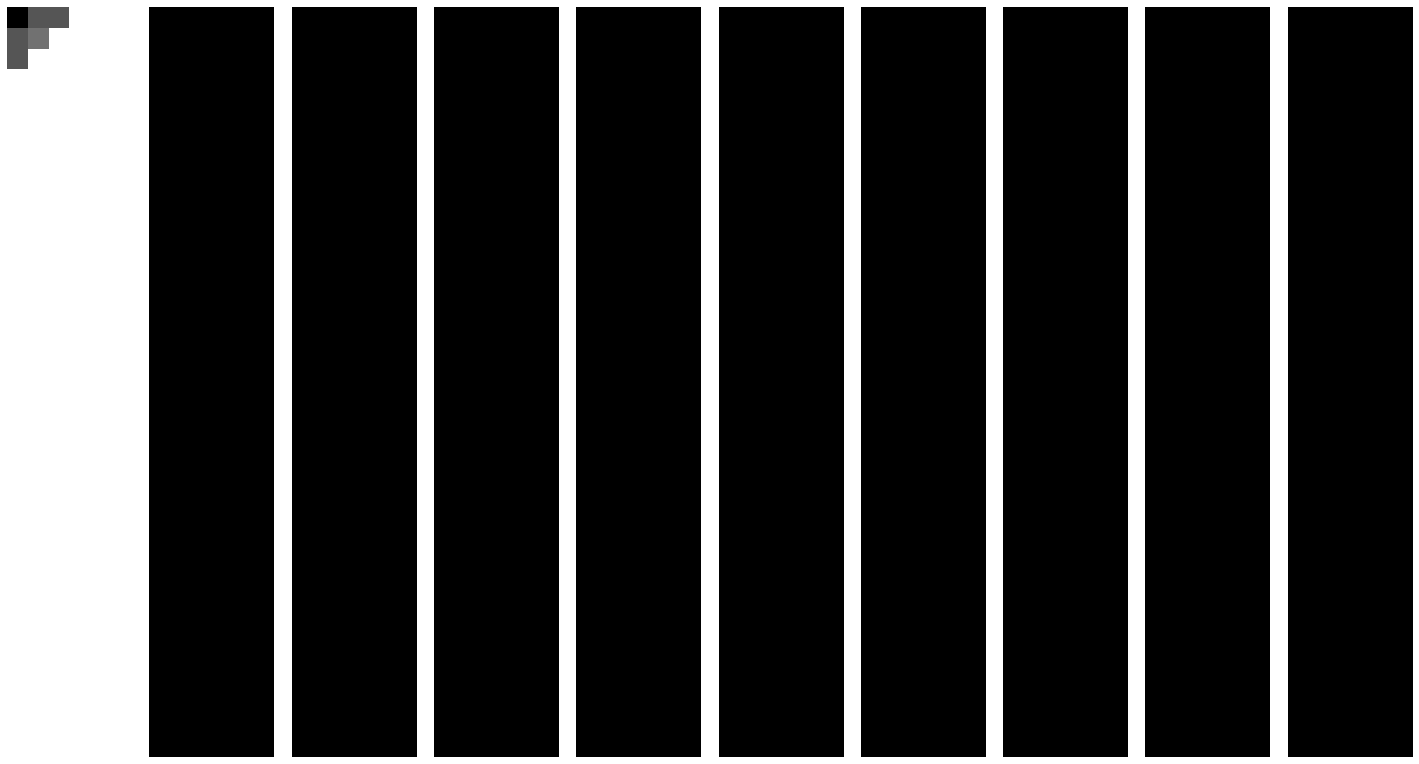

38/38 - 9s - loss: 4.5226 - d_loss: 0.0080 - g_loss: 4.5146 - 9s/epoch - 245ms/step
Epoch 16/200


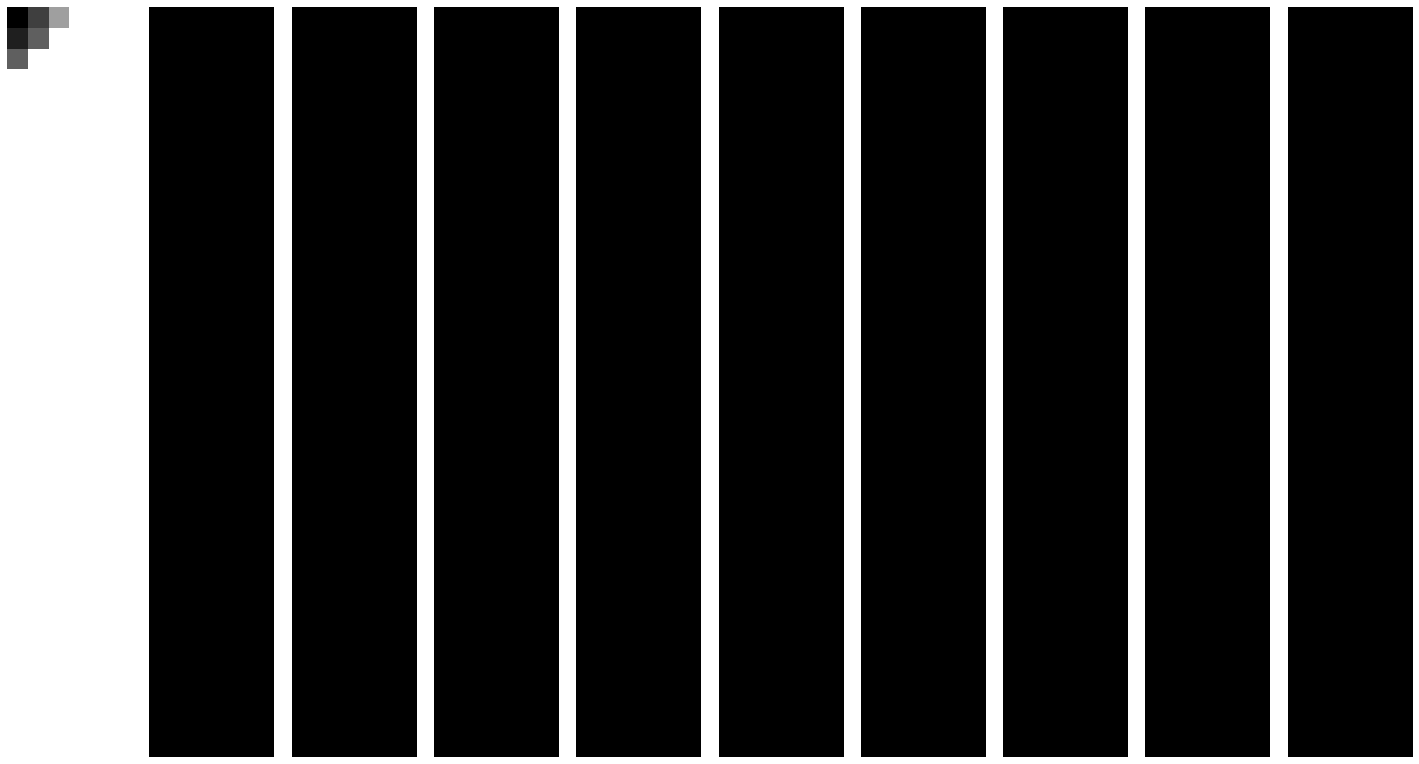

38/38 - 9s - loss: 5.0772 - d_loss: 0.0050 - g_loss: 5.0721 - 9s/epoch - 240ms/step
Epoch 17/200


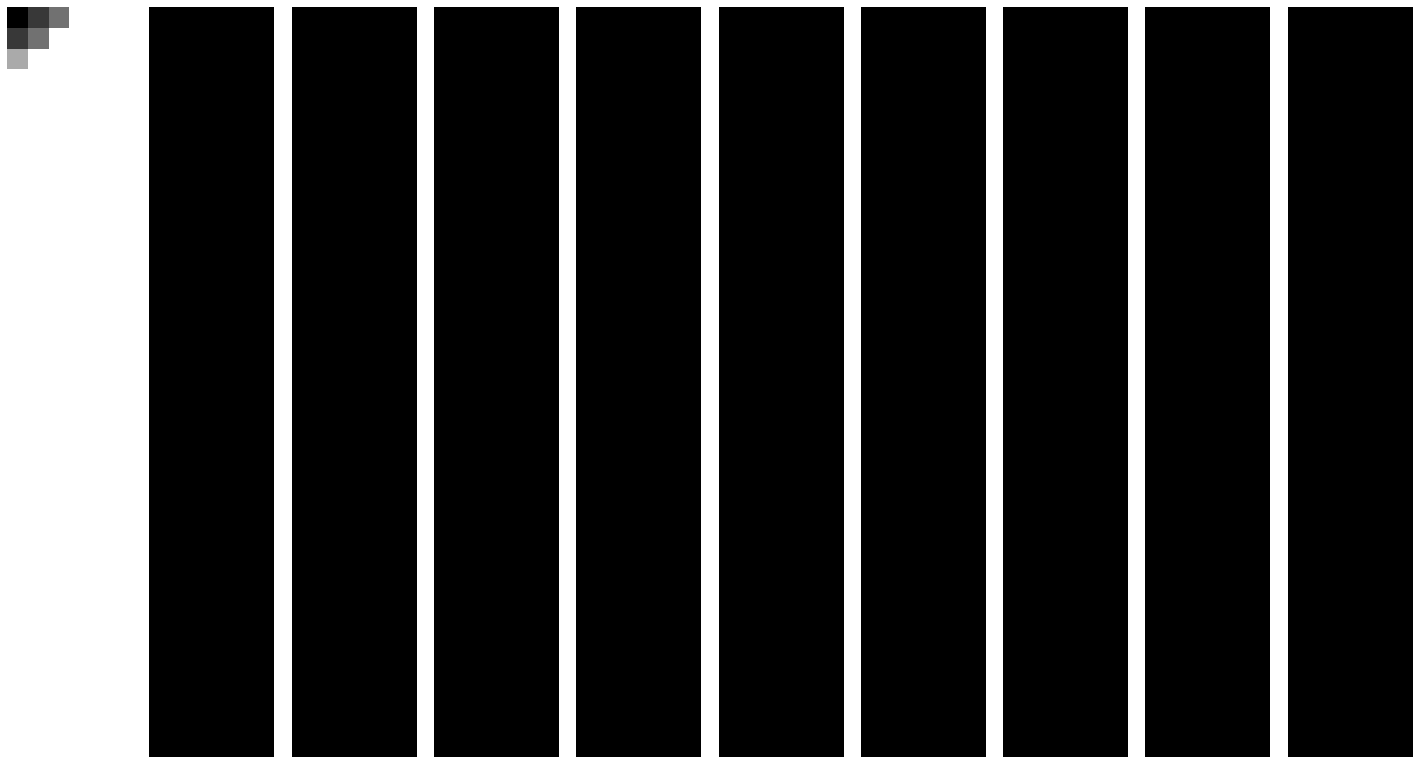

38/38 - 9s - loss: 5.4325 - d_loss: 0.0039 - g_loss: 5.4286 - 9s/epoch - 239ms/step
Epoch 18/200


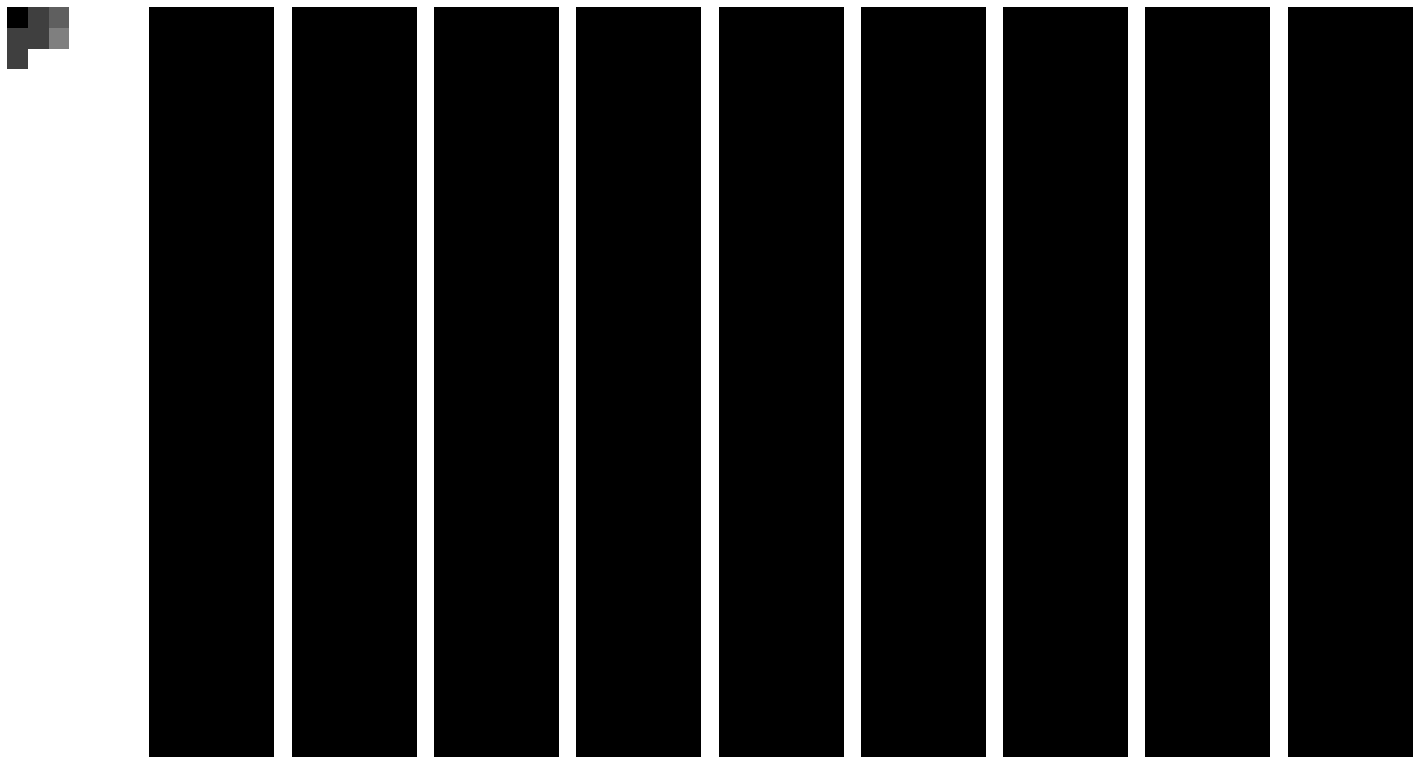

38/38 - 9s - loss: 5.6690 - d_loss: 0.0032 - g_loss: 5.6657 - 9s/epoch - 239ms/step
Epoch 19/200


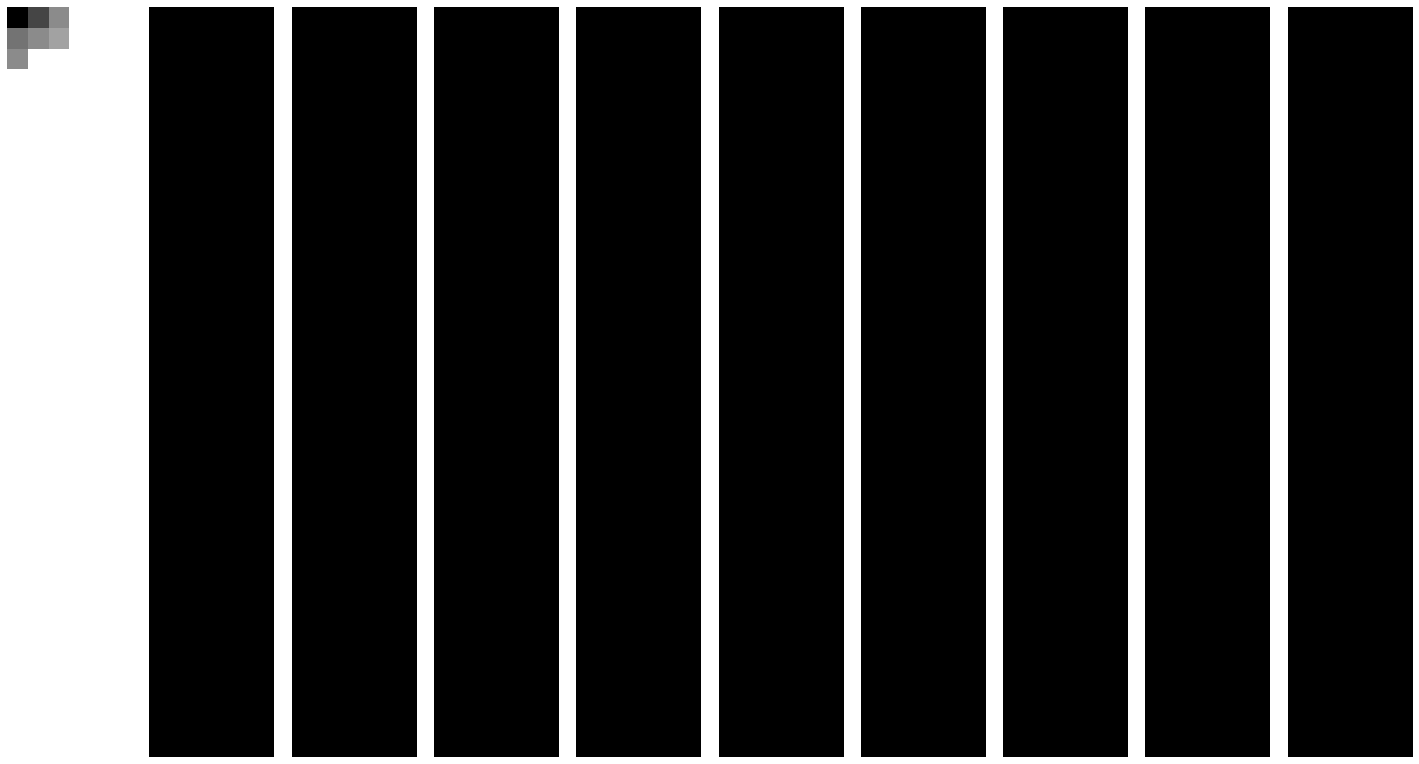

38/38 - 9s - loss: 5.8974 - d_loss: 0.0028 - g_loss: 5.8946 - 9s/epoch - 236ms/step
Epoch 20/200


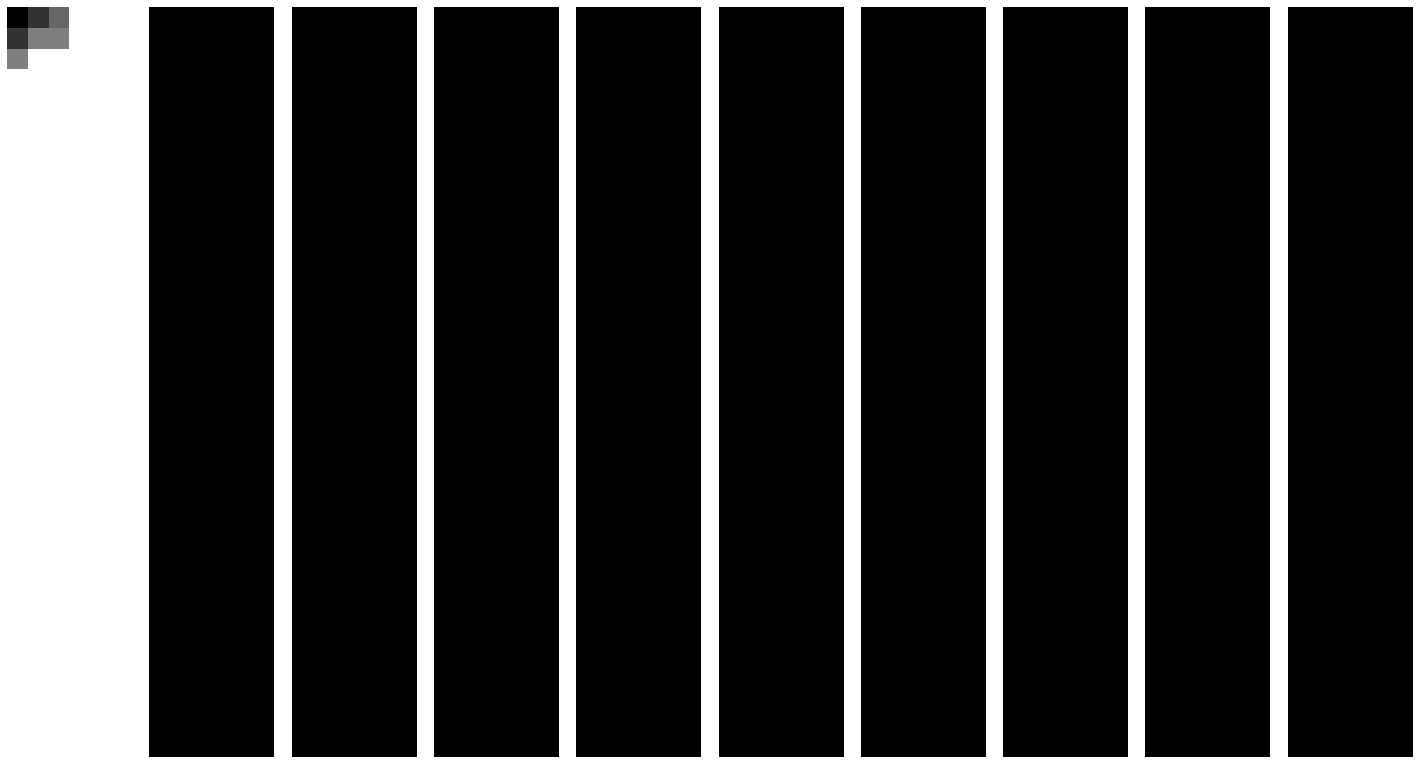

38/38 - 9s - loss: 6.0404 - d_loss: 0.0025 - g_loss: 6.0379 - 9s/epoch - 236ms/step
Epoch 21/200


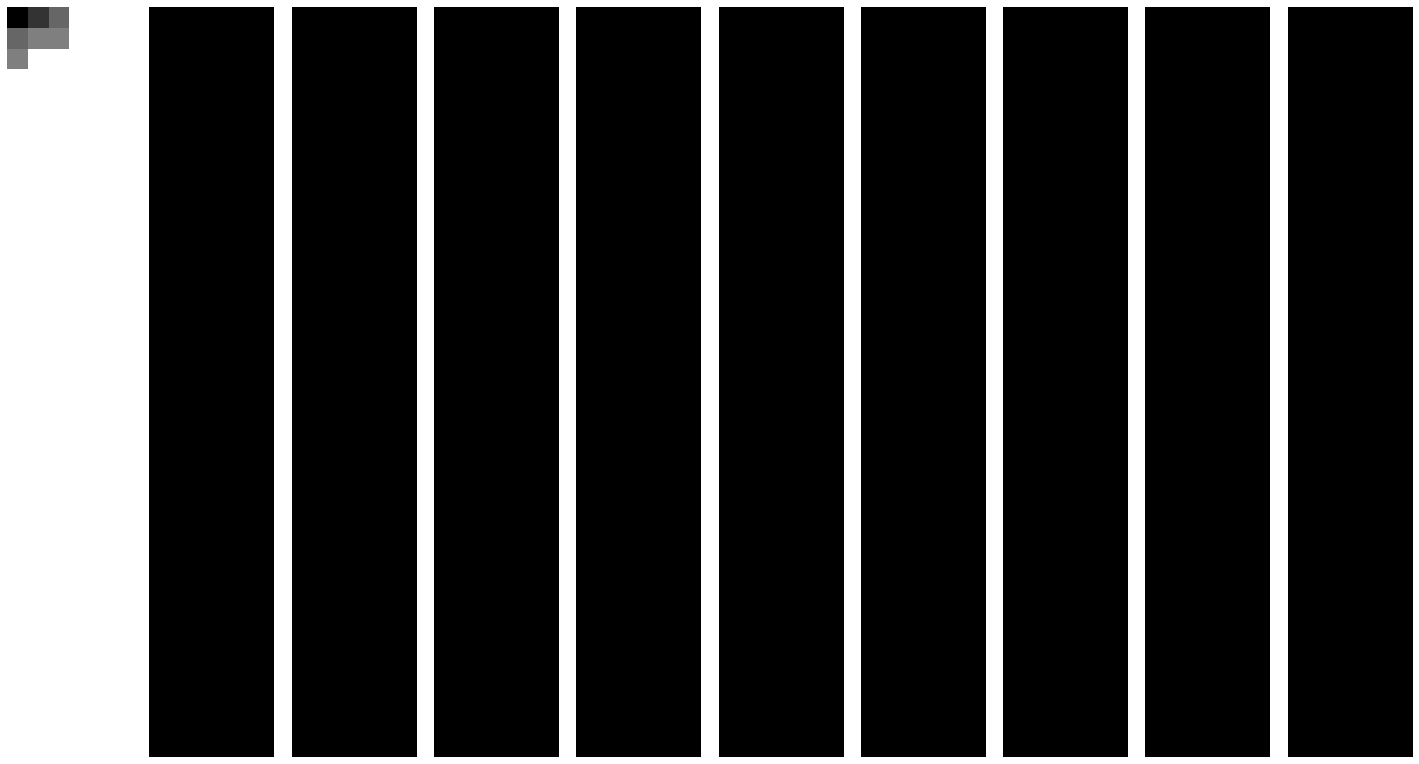

38/38 - 9s - loss: 6.1926 - d_loss: 0.0022 - g_loss: 6.1904 - 9s/epoch - 241ms/step
Epoch 22/200


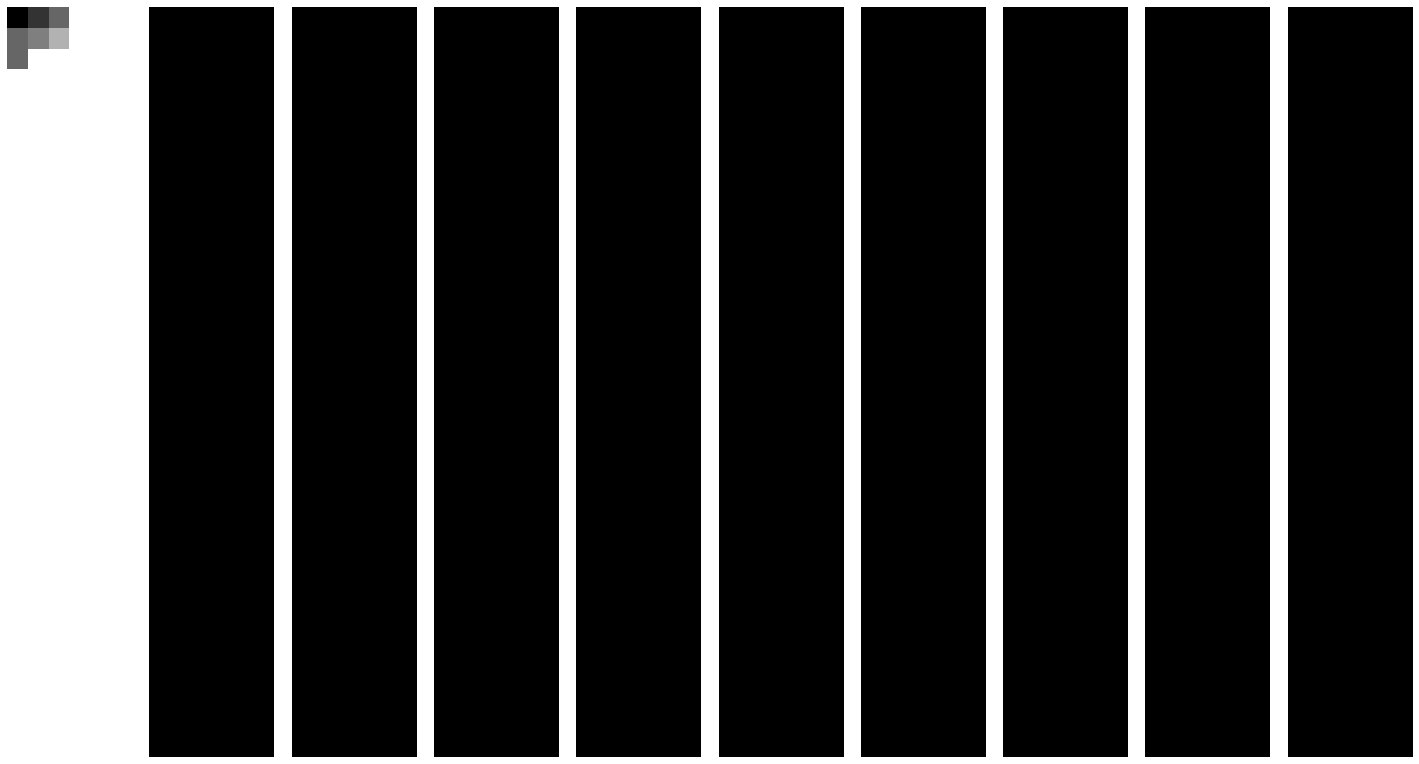

38/38 - 9s - loss: 6.3013 - d_loss: 0.0020 - g_loss: 6.2993 - 9s/epoch - 236ms/step
Epoch 23/200


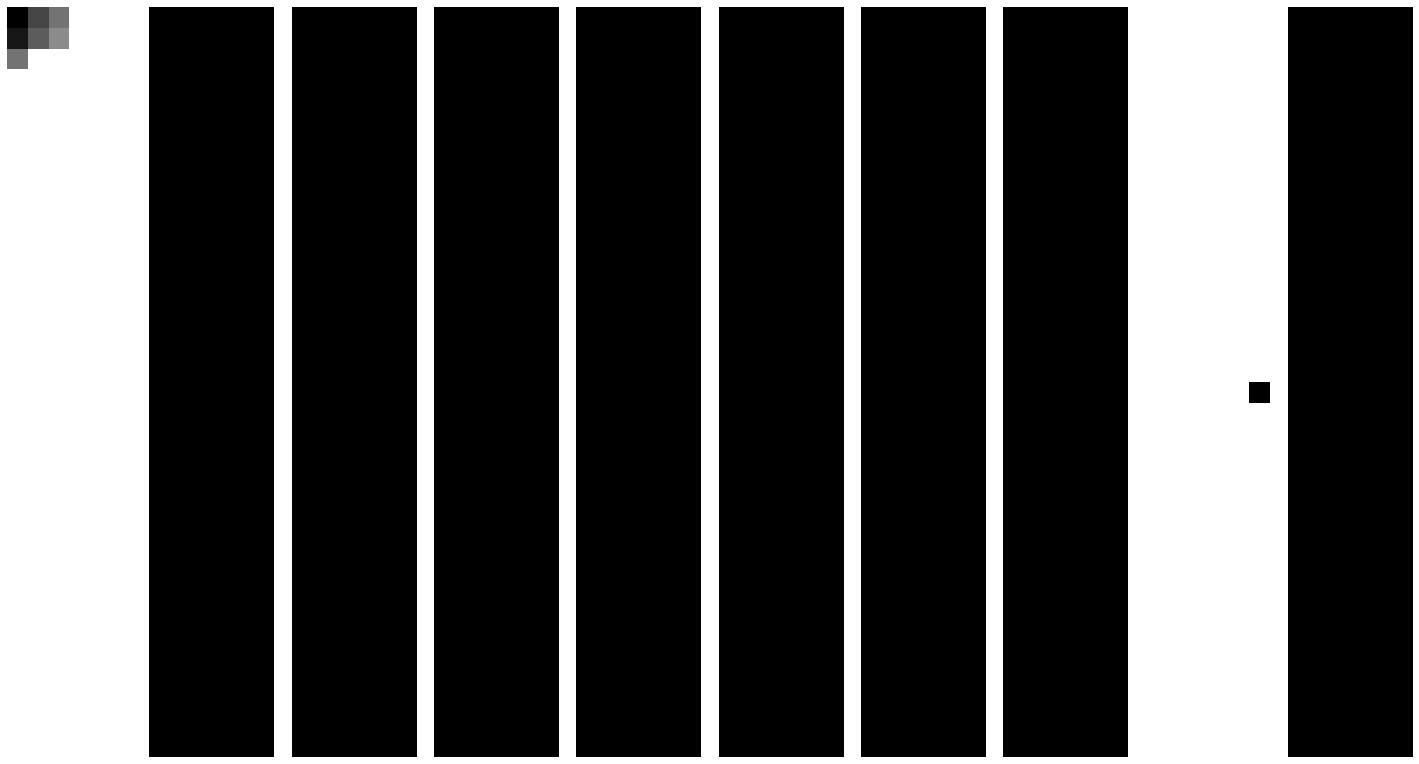

38/38 - 9s - loss: 6.4100 - d_loss: 0.0018 - g_loss: 6.4081 - 9s/epoch - 238ms/step
Epoch 24/200


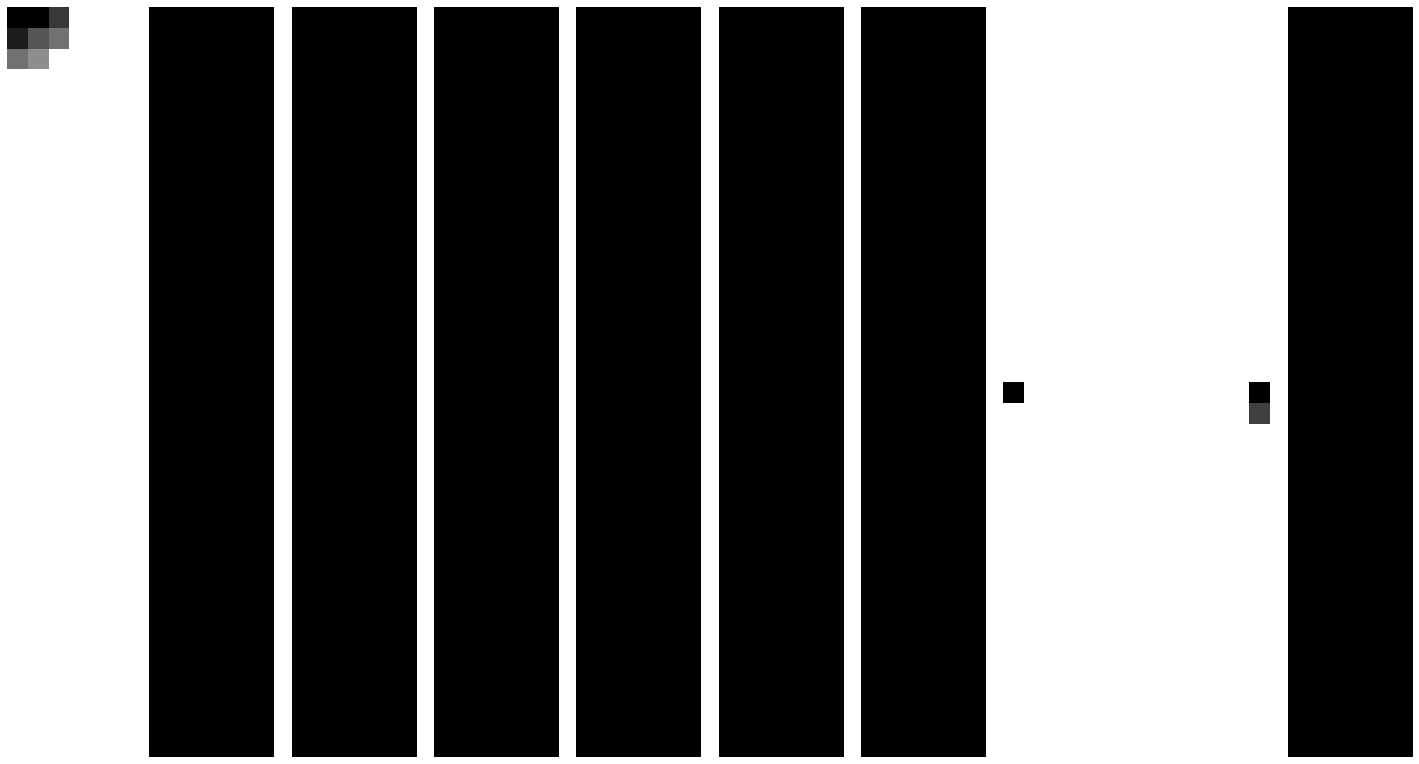

38/38 - 9s - loss: 6.4851 - d_loss: 0.0017 - g_loss: 6.4835 - 9s/epoch - 239ms/step
Epoch 25/200


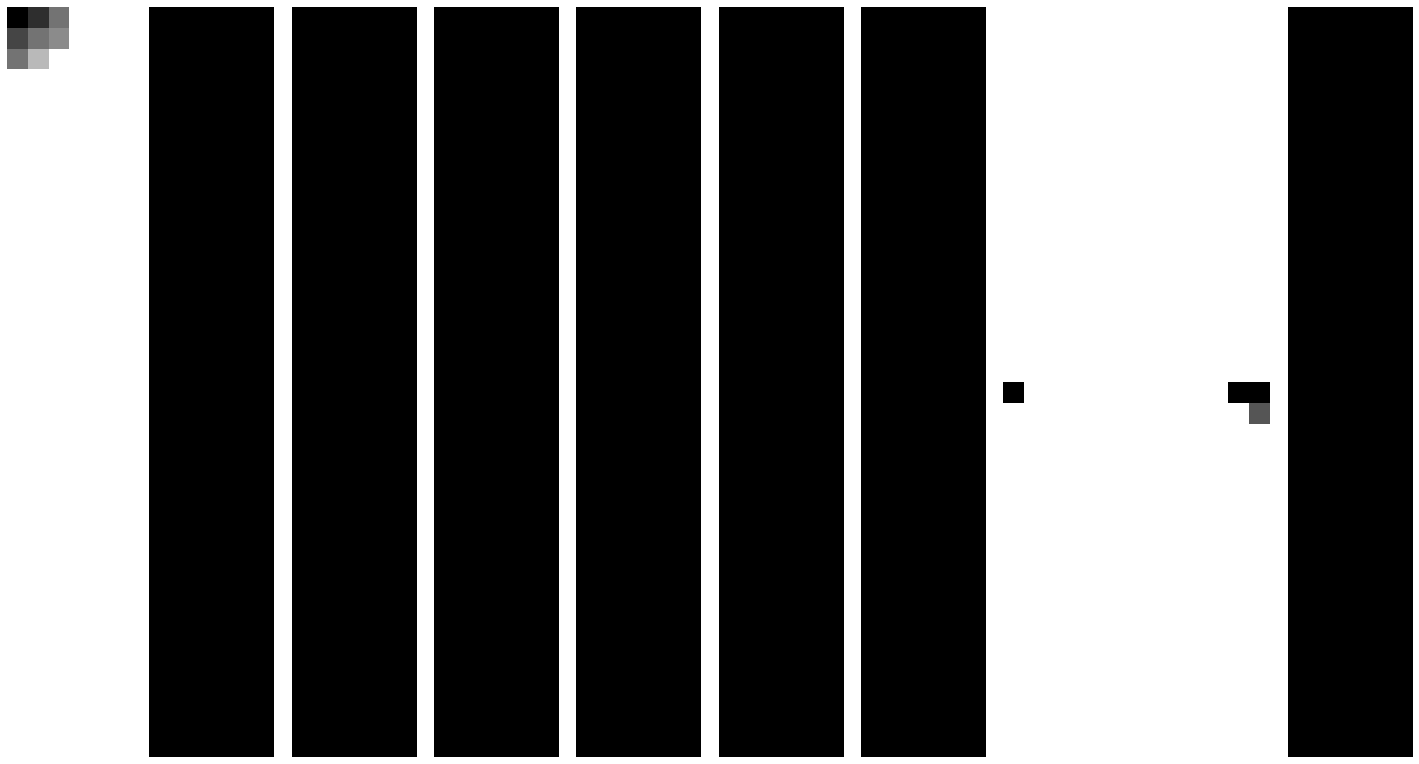

38/38 - 9s - loss: 6.5436 - d_loss: 0.0015 - g_loss: 6.5421 - 9s/epoch - 240ms/step
Epoch 26/200


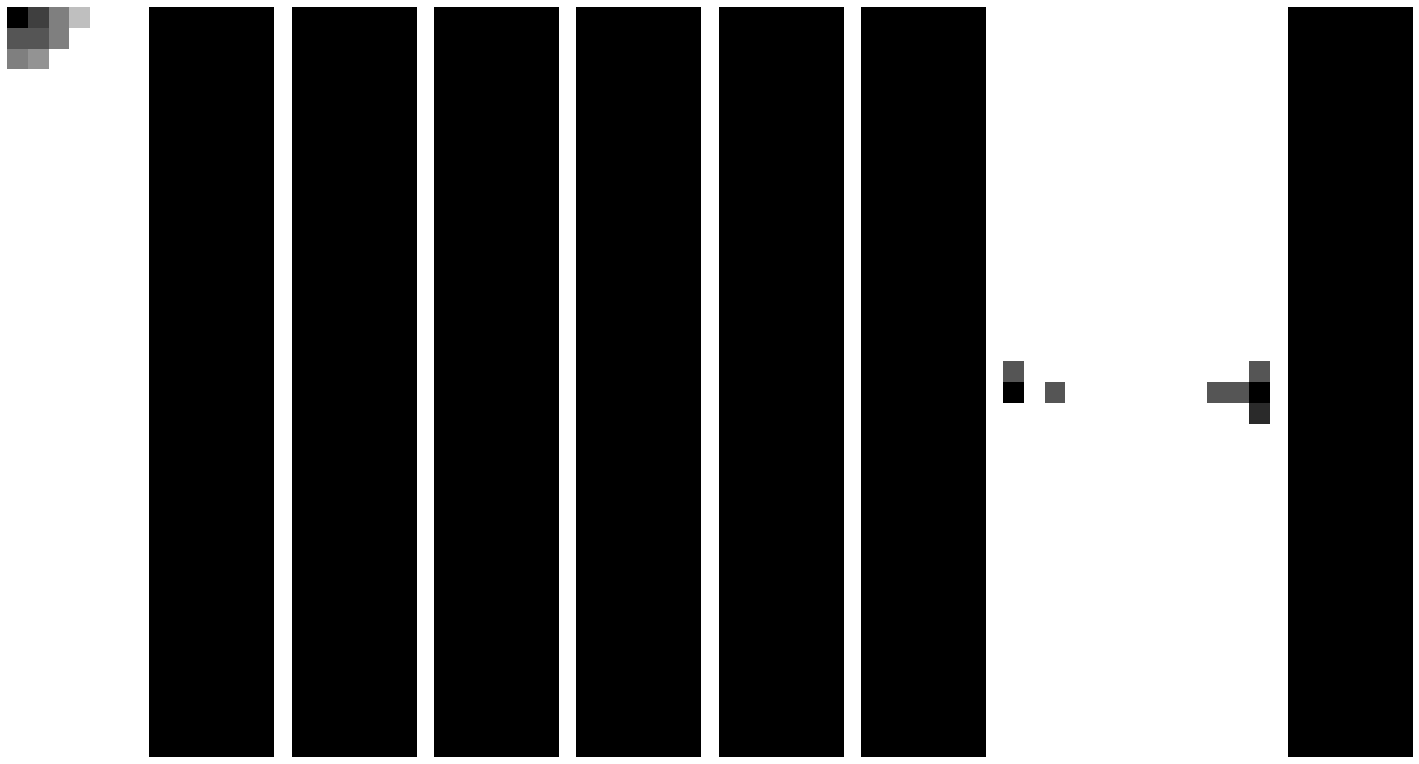

38/38 - 9s - loss: 6.6570 - d_loss: 0.0014 - g_loss: 6.6556 - 9s/epoch - 244ms/step
Epoch 27/200


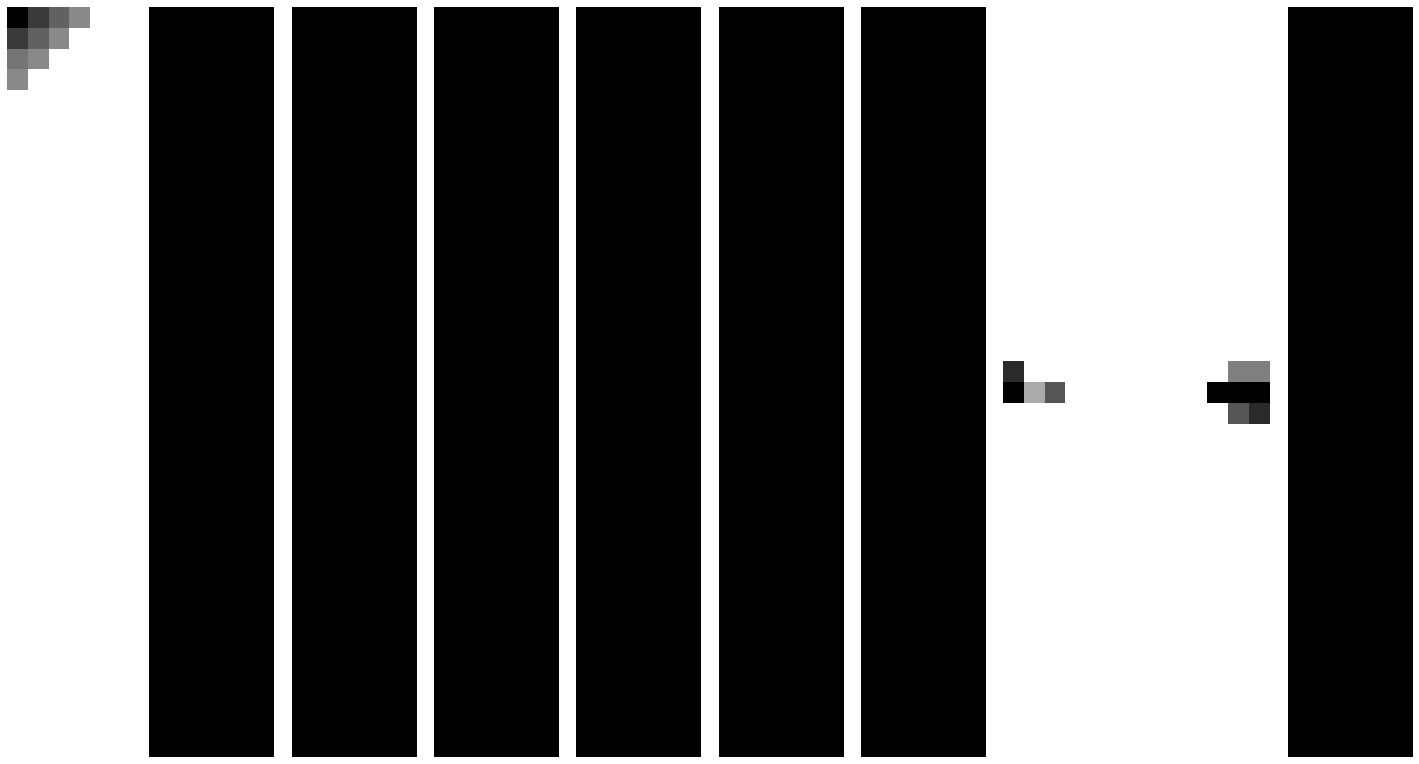

38/38 - 9s - loss: 6.6998 - d_loss: 0.0013 - g_loss: 6.6985 - 9s/epoch - 237ms/step
Epoch 28/200


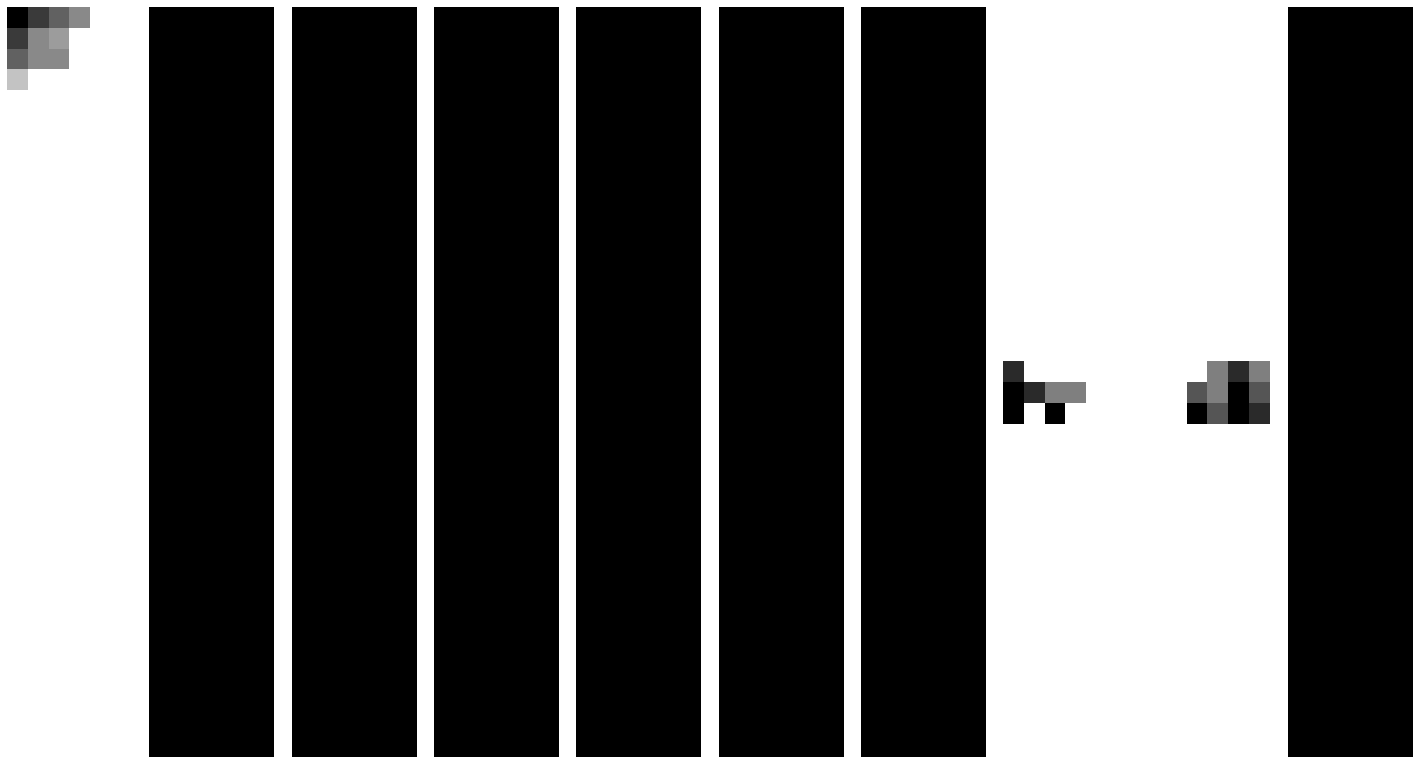

38/38 - 9s - loss: 6.8058 - d_loss: 0.0012 - g_loss: 6.8046 - 9s/epoch - 238ms/step
Epoch 29/200


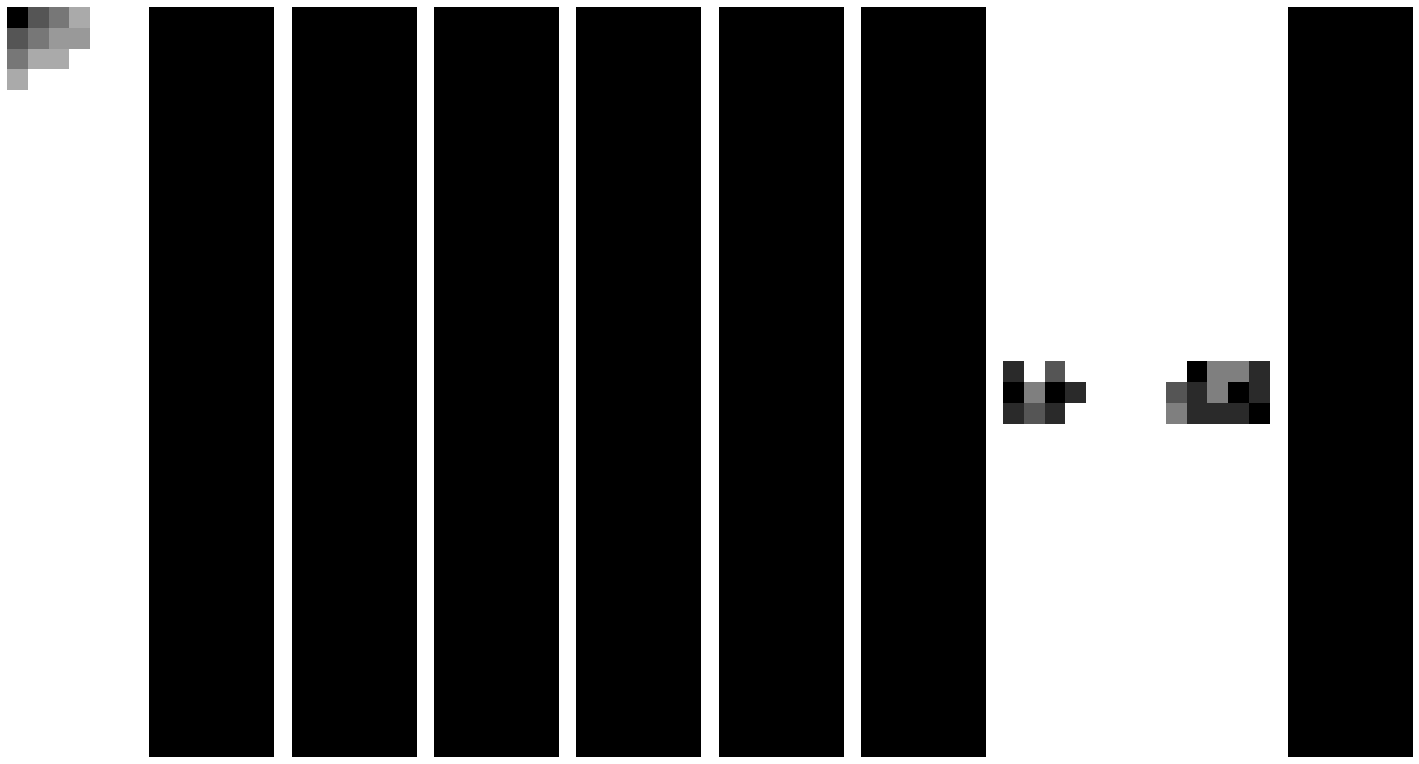

38/38 - 9s - loss: 6.8761 - d_loss: 0.0011 - g_loss: 6.8750 - 9s/epoch - 236ms/step
Epoch 30/200


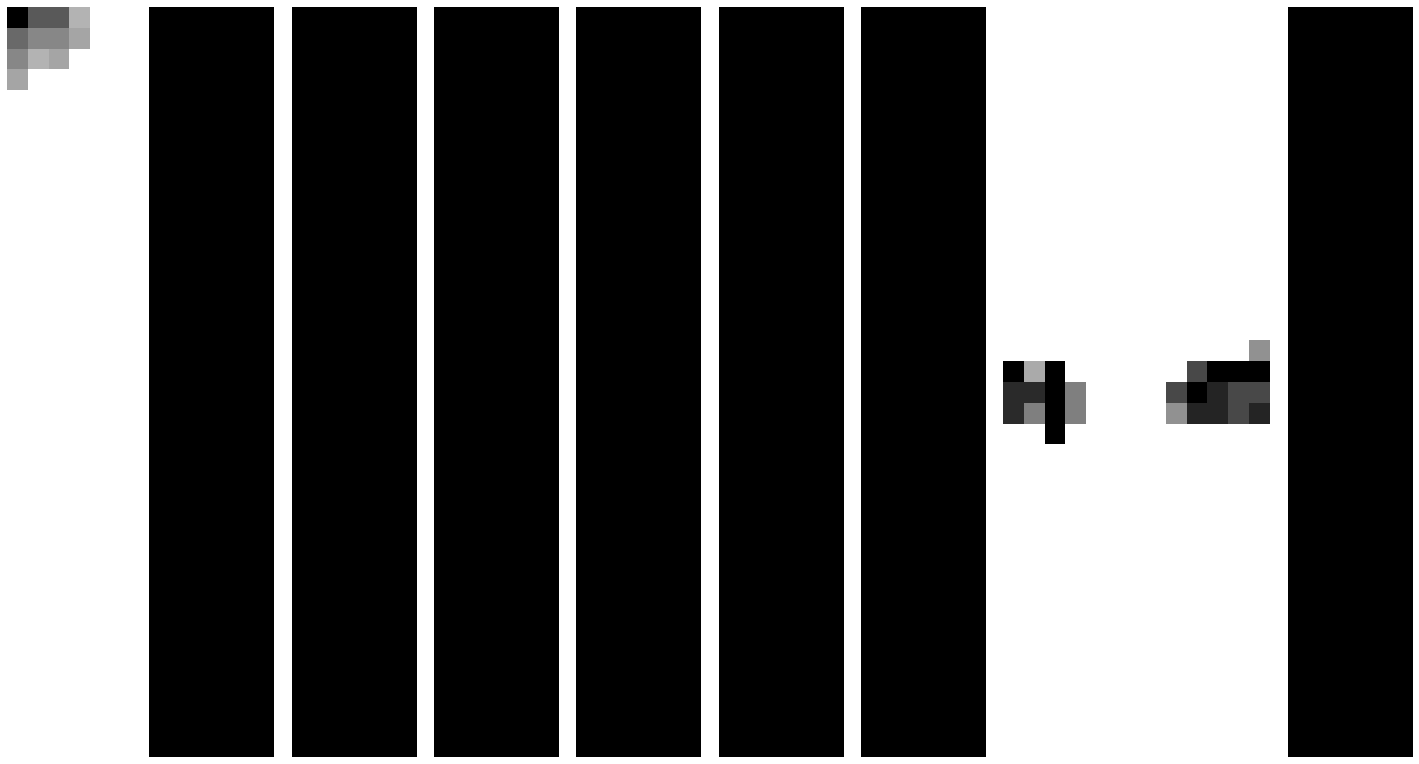

38/38 - 9s - loss: 6.8947 - d_loss: 9.8311e-04 - g_loss: 6.8937 - 9s/epoch - 238ms/step
Epoch 31/200


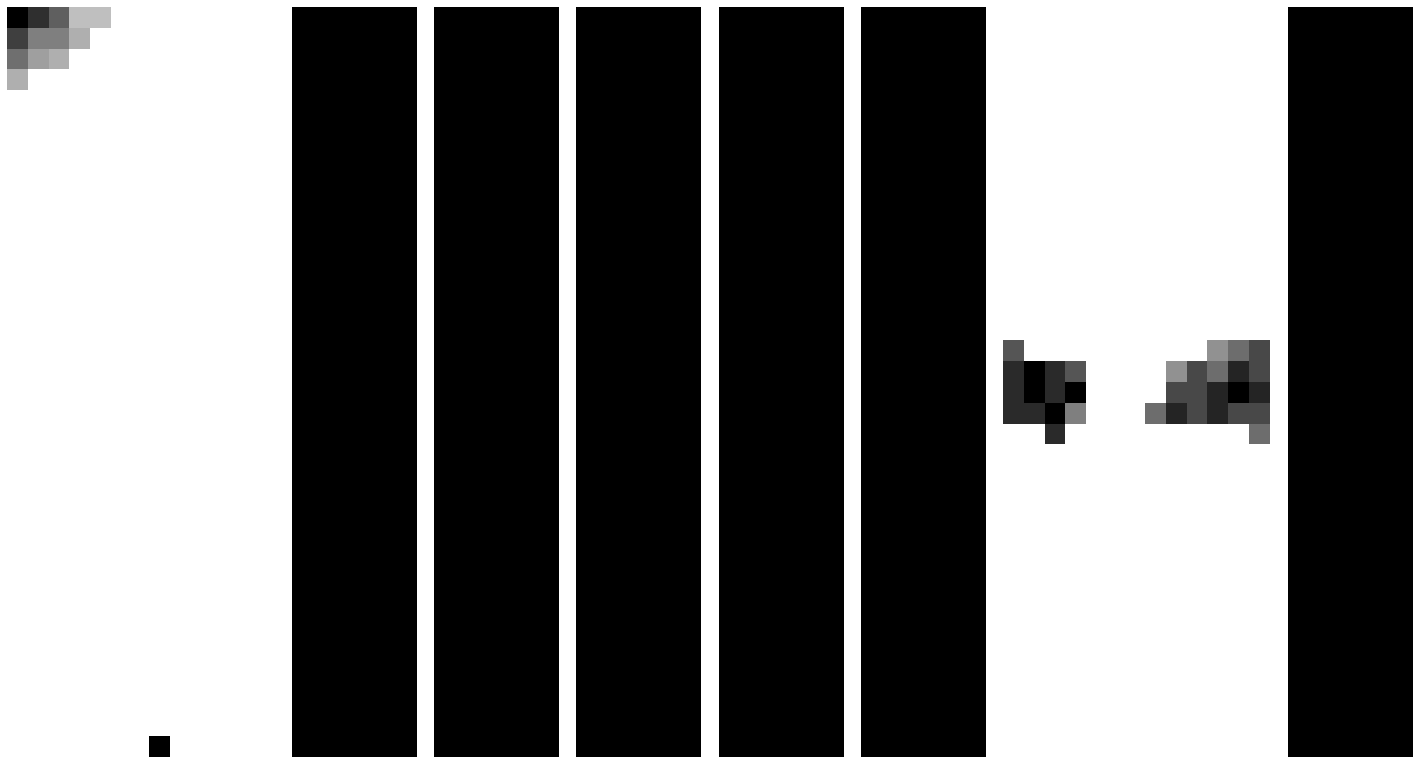

38/38 - 9s - loss: 6.9925 - d_loss: 8.8954e-04 - g_loss: 6.9916 - 9s/epoch - 238ms/step
Epoch 32/200


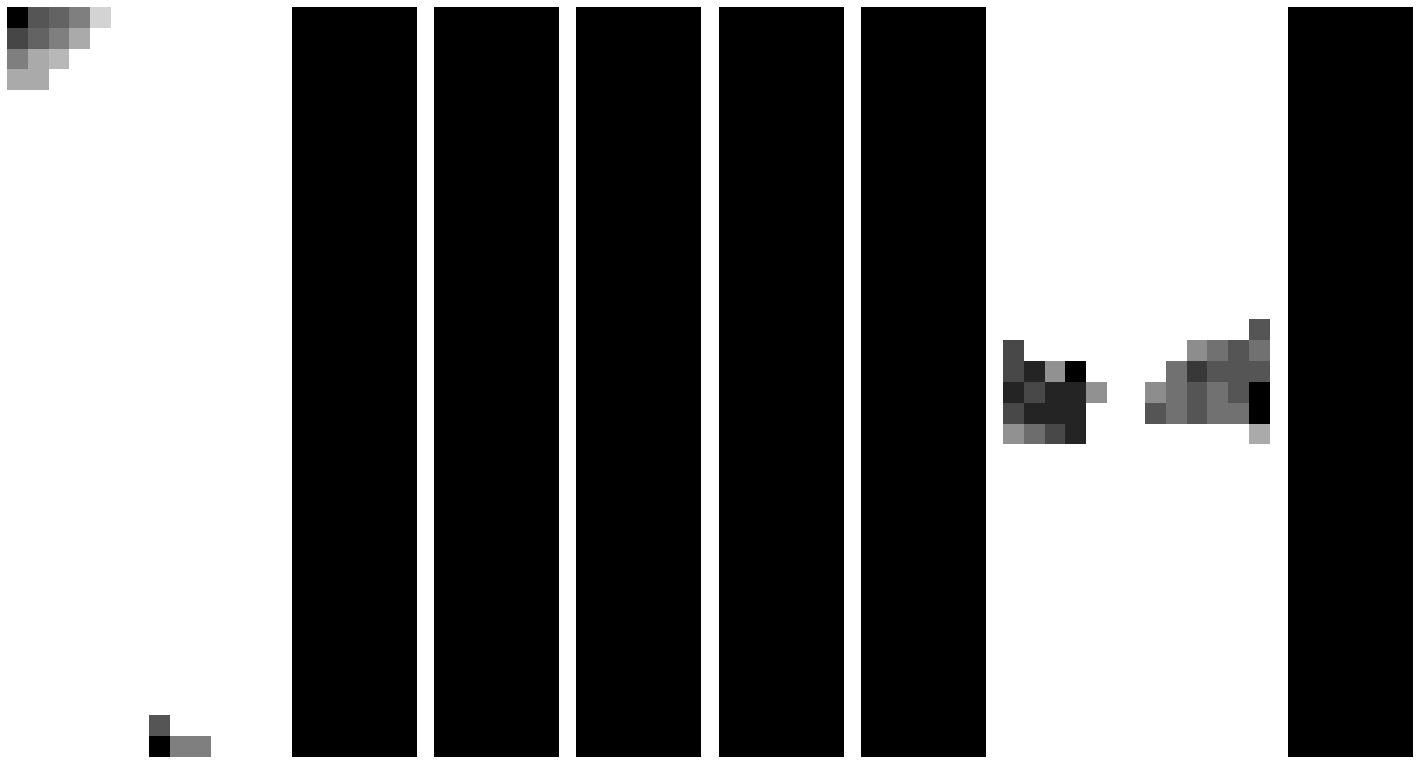

38/38 - 9s - loss: 7.0428 - d_loss: 8.1034e-04 - g_loss: 7.0420 - 9s/epoch - 245ms/step
Epoch 33/200


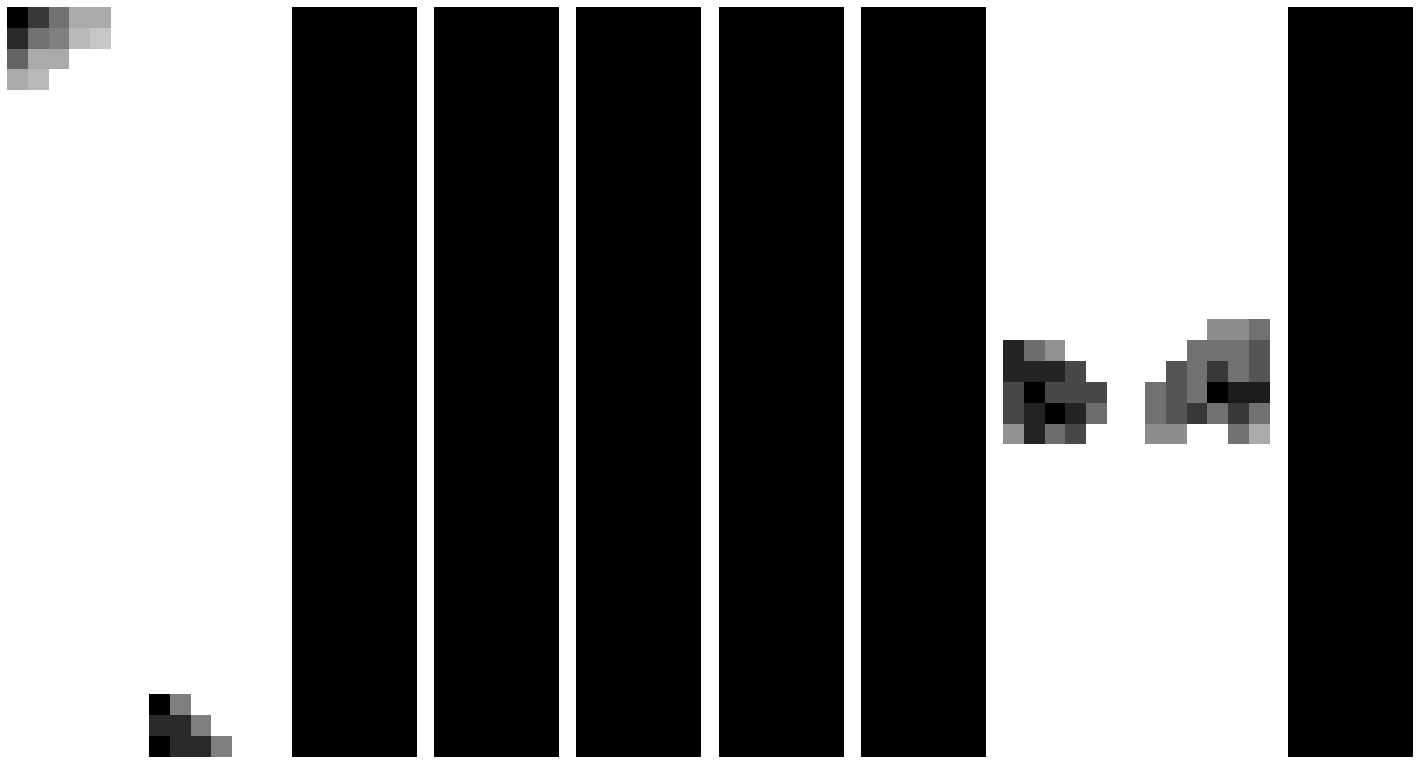

38/38 - 9s - loss: 7.1030 - d_loss: 7.4145e-04 - g_loss: 7.1023 - 9s/epoch - 239ms/step
Epoch 34/200


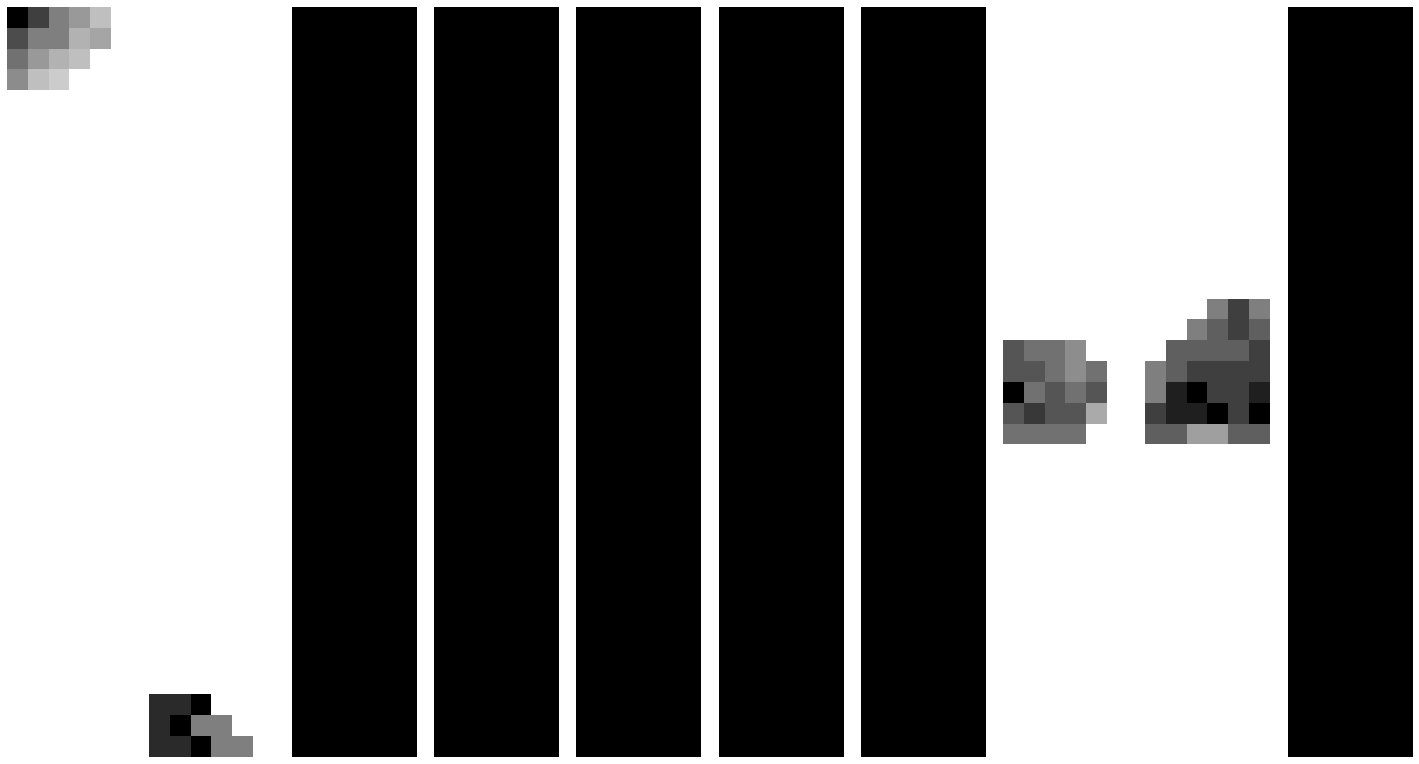

38/38 - 9s - loss: 7.1979 - d_loss: 6.7916e-04 - g_loss: 7.1973 - 9s/epoch - 240ms/step
Epoch 35/200


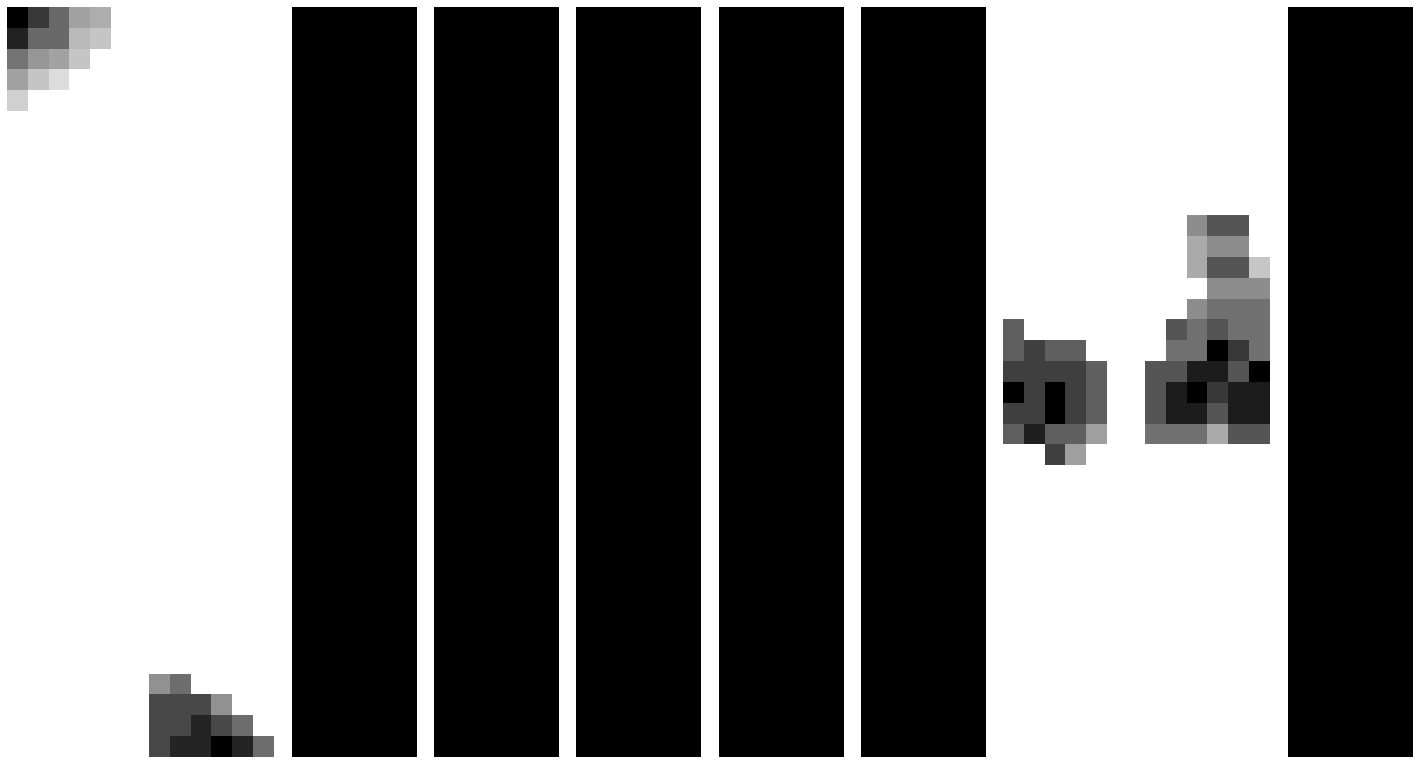

38/38 - 9s - loss: 7.2753 - d_loss: 6.2486e-04 - g_loss: 7.2747 - 9s/epoch - 238ms/step
Epoch 36/200


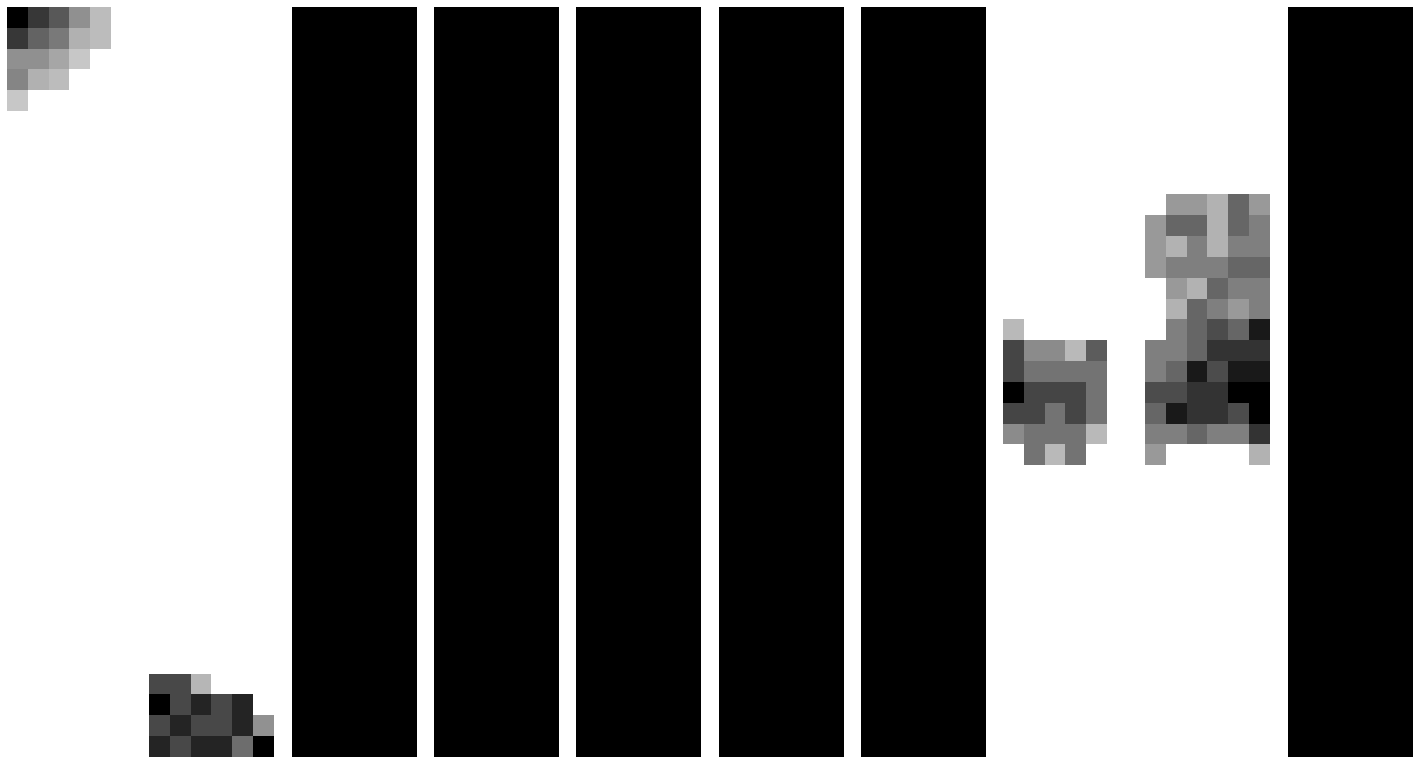

38/38 - 9s - loss: 7.3233 - d_loss: 5.7746e-04 - g_loss: 7.3228 - 9s/epoch - 238ms/step
Epoch 37/200


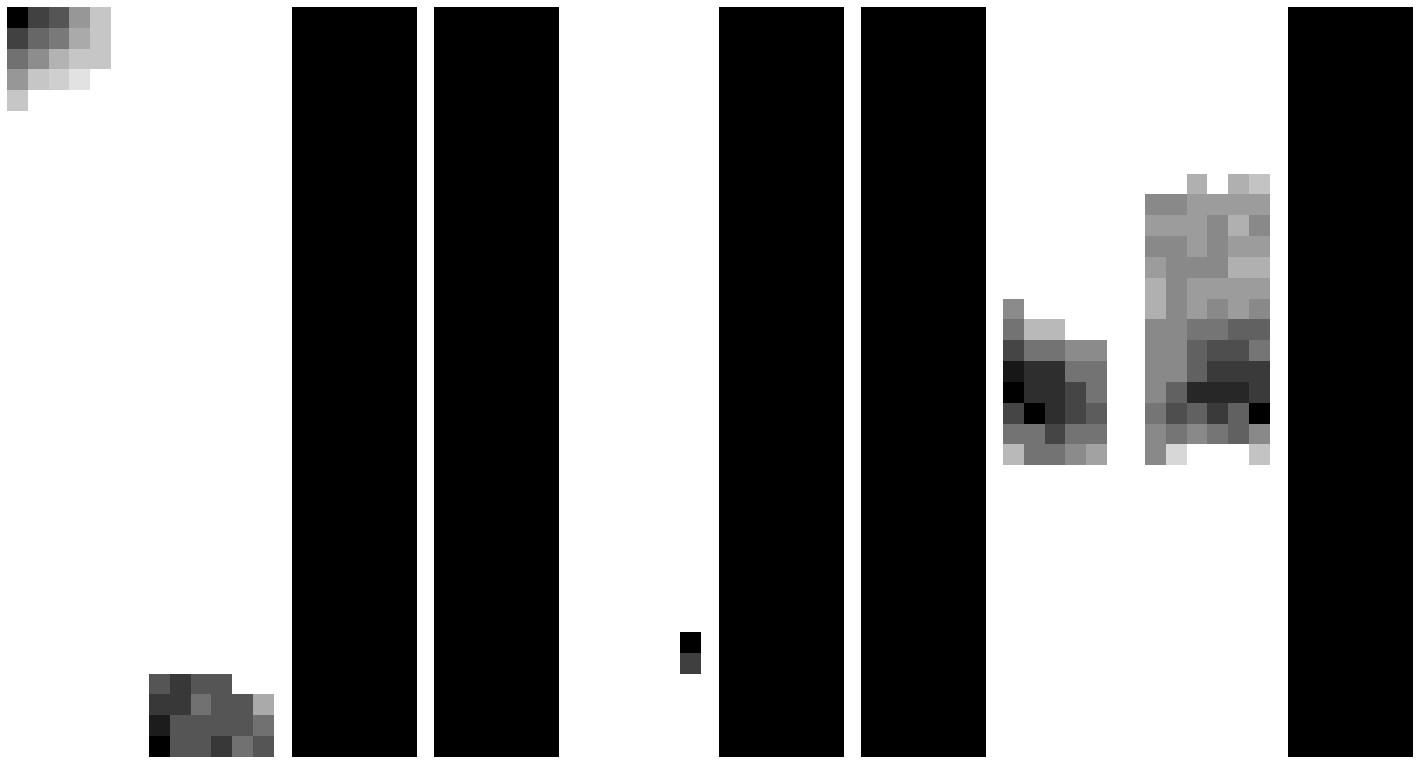

38/38 - 9s - loss: 7.4123 - d_loss: 5.3386e-04 - g_loss: 7.4118 - 9s/epoch - 238ms/step
Epoch 38/200


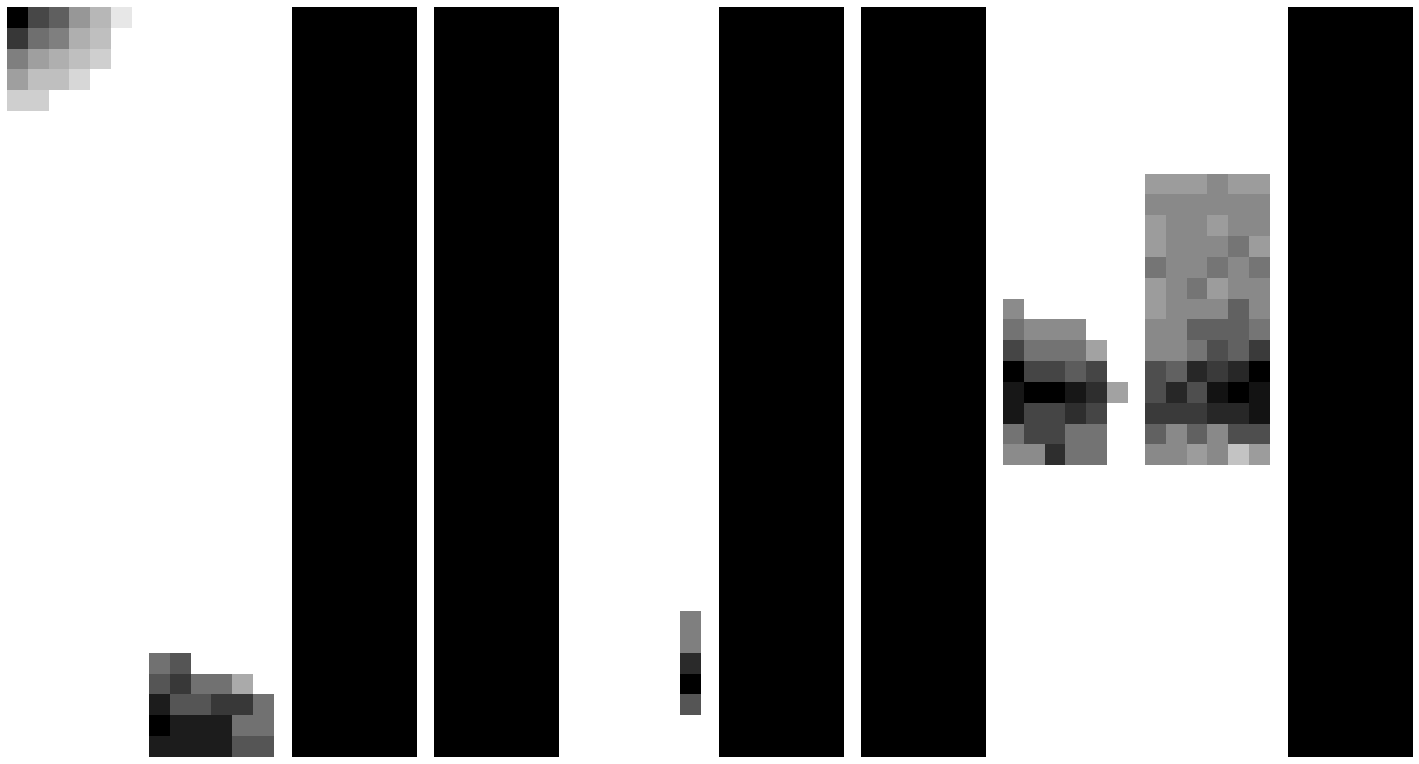

38/38 - 9s - loss: 7.4769 - d_loss: 4.9241e-04 - g_loss: 7.4764 - 9s/epoch - 244ms/step
Epoch 39/200


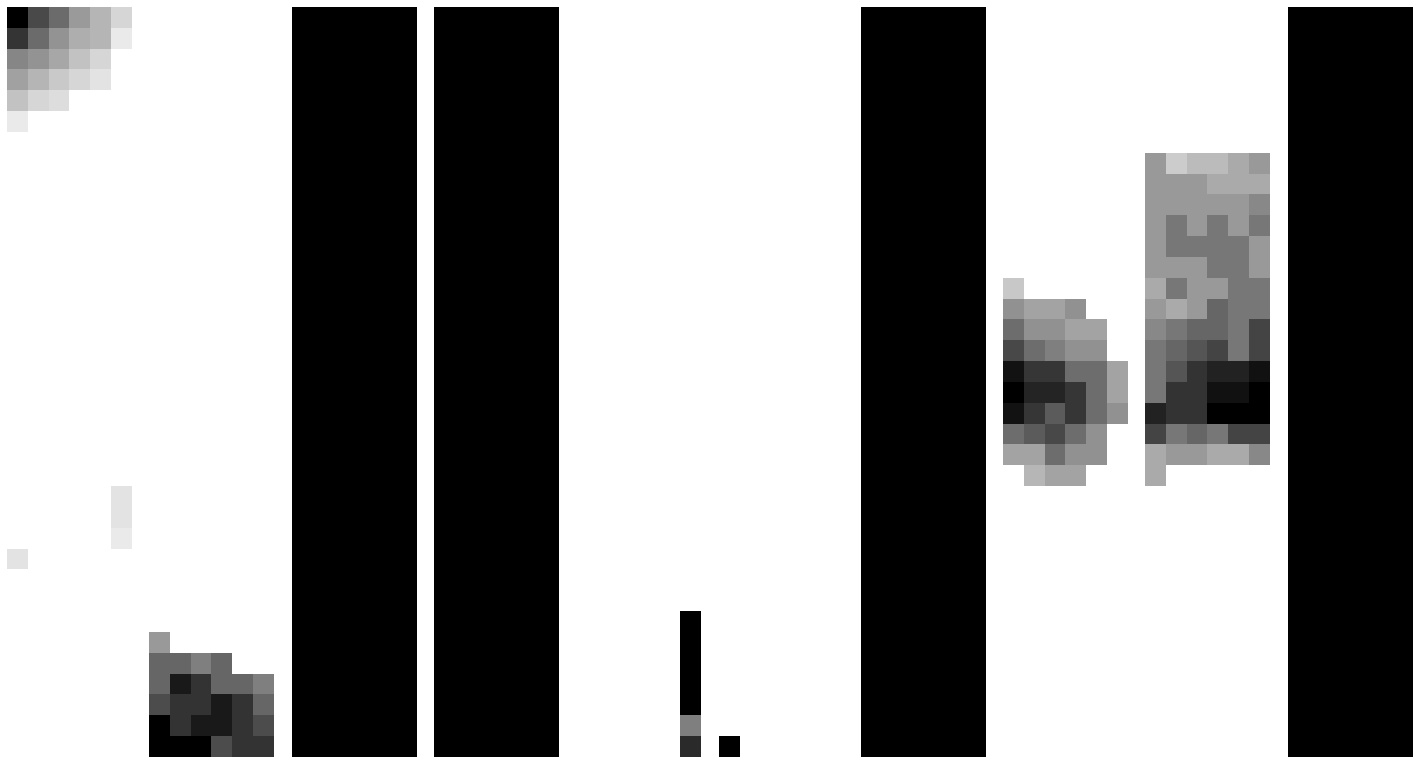

38/38 - 9s - loss: 7.5272 - d_loss: 4.6067e-04 - g_loss: 7.5268 - 9s/epoch - 237ms/step
Epoch 40/200


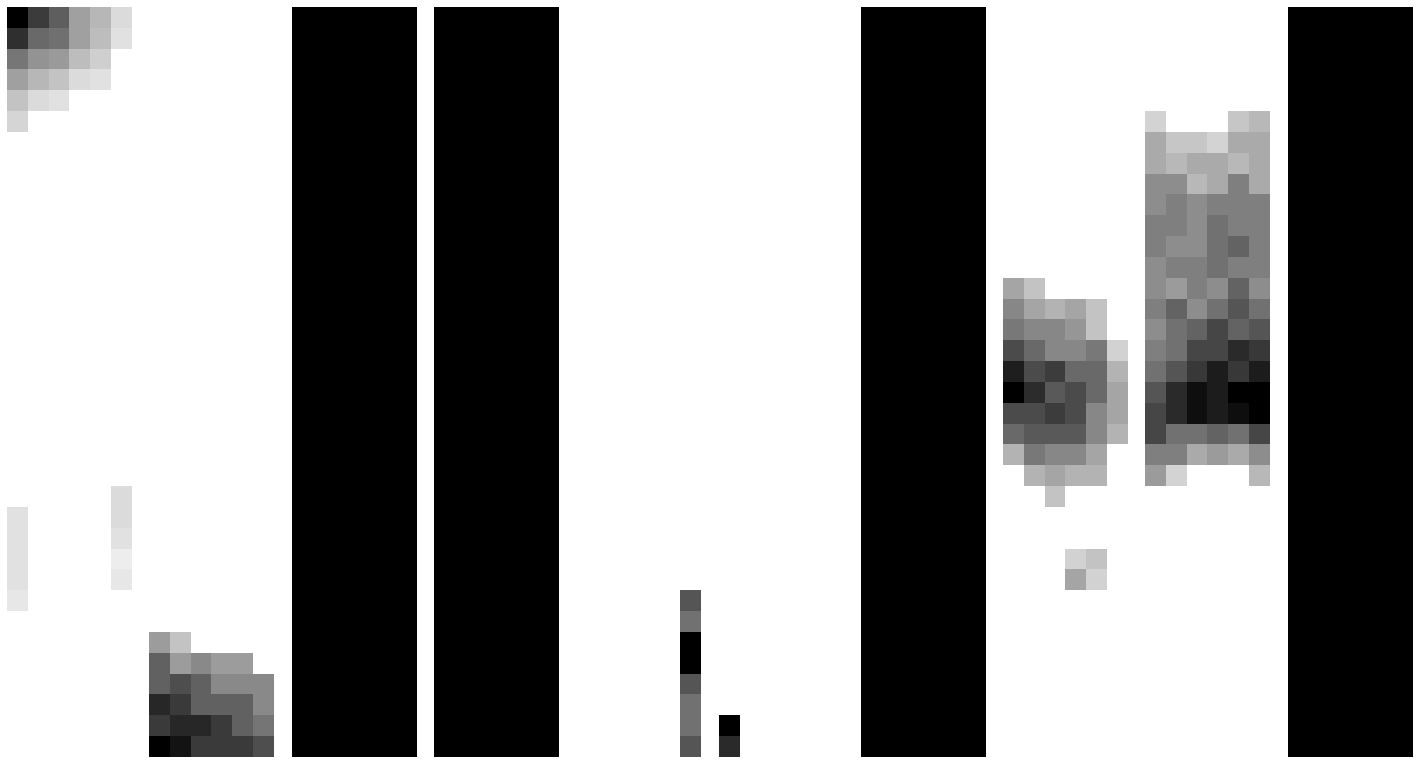

38/38 - 9s - loss: 7.6105 - d_loss: 4.2851e-04 - g_loss: 7.6100 - 9s/epoch - 238ms/step
Epoch 41/200


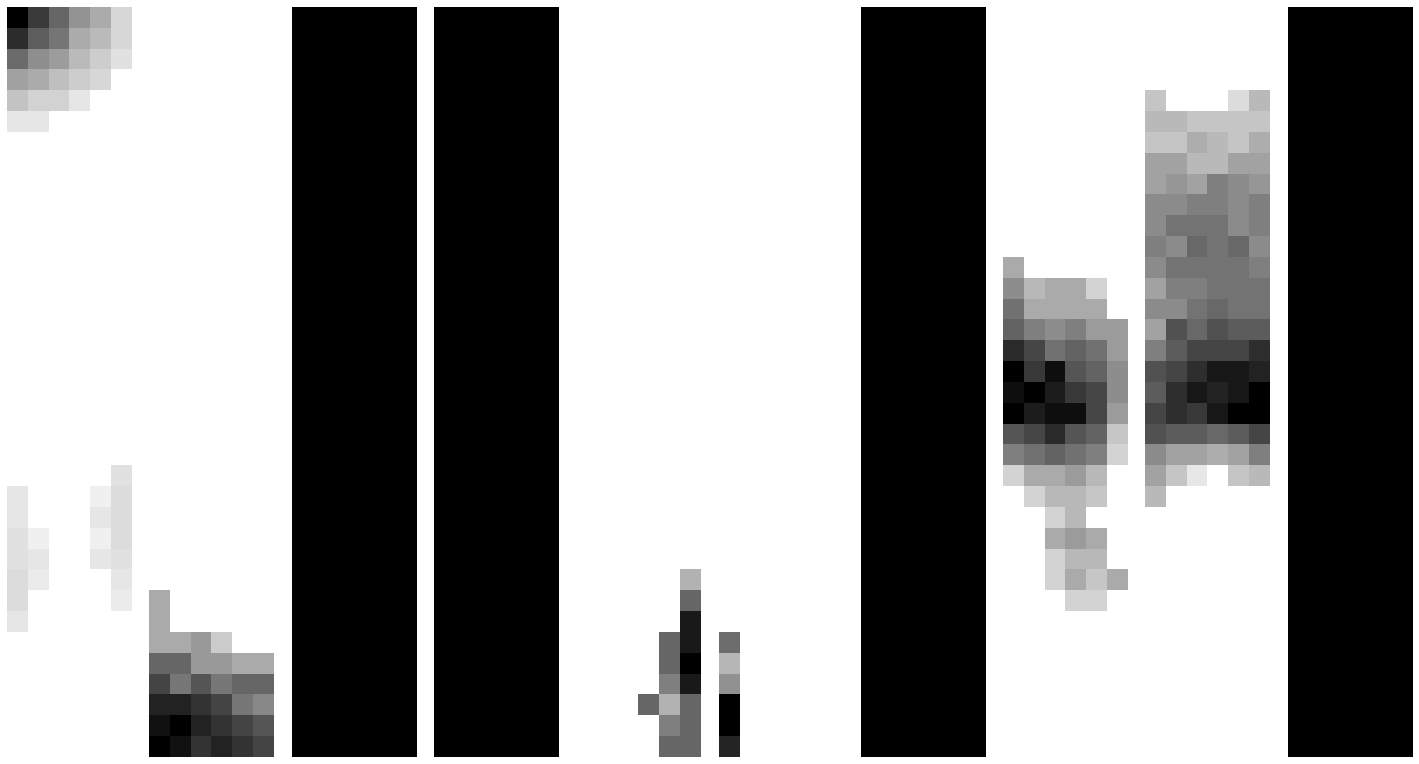

38/38 - 9s - loss: 7.6645 - d_loss: 4.0142e-04 - g_loss: 7.6641 - 9s/epoch - 238ms/step
Epoch 42/200


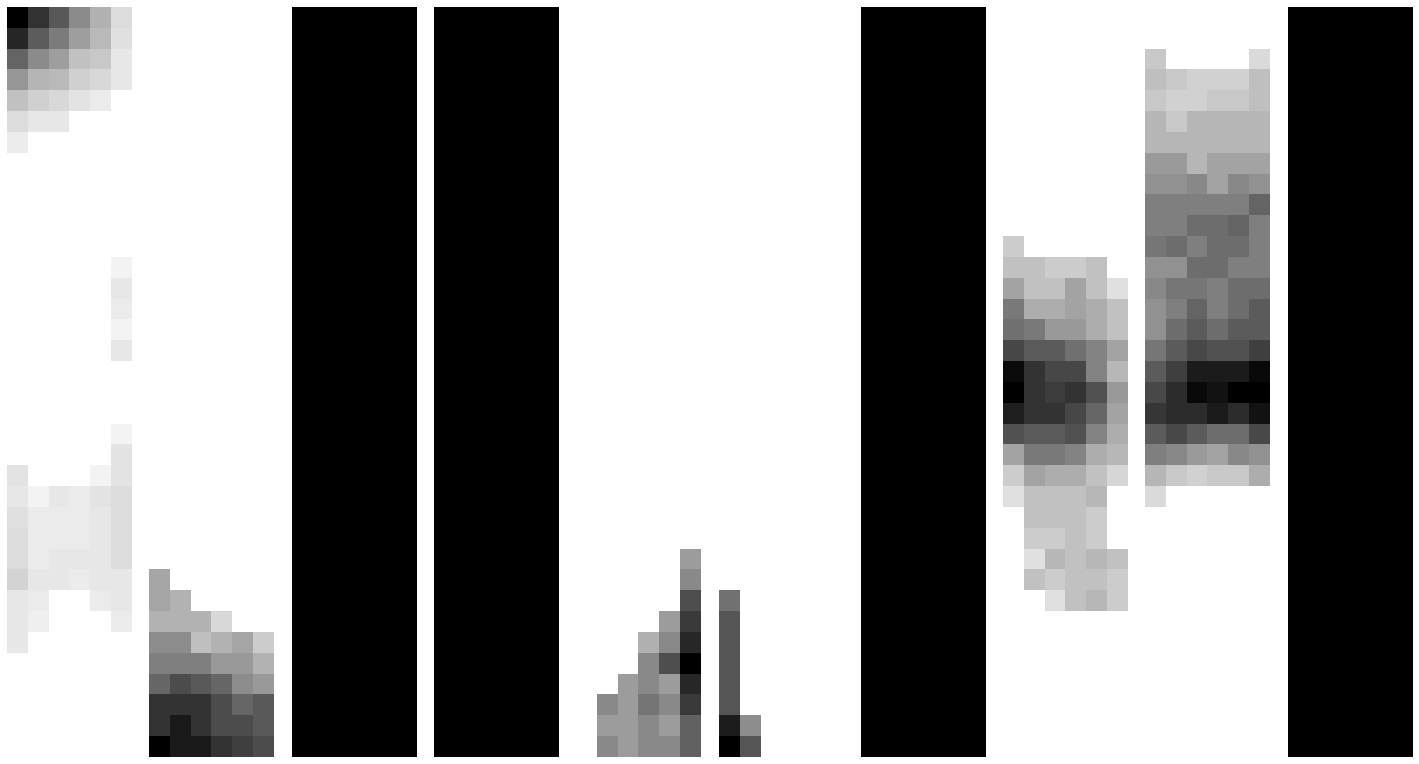

38/38 - 9s - loss: 7.7341 - d_loss: 3.7452e-04 - g_loss: 7.7337 - 9s/epoch - 238ms/step
Epoch 43/200


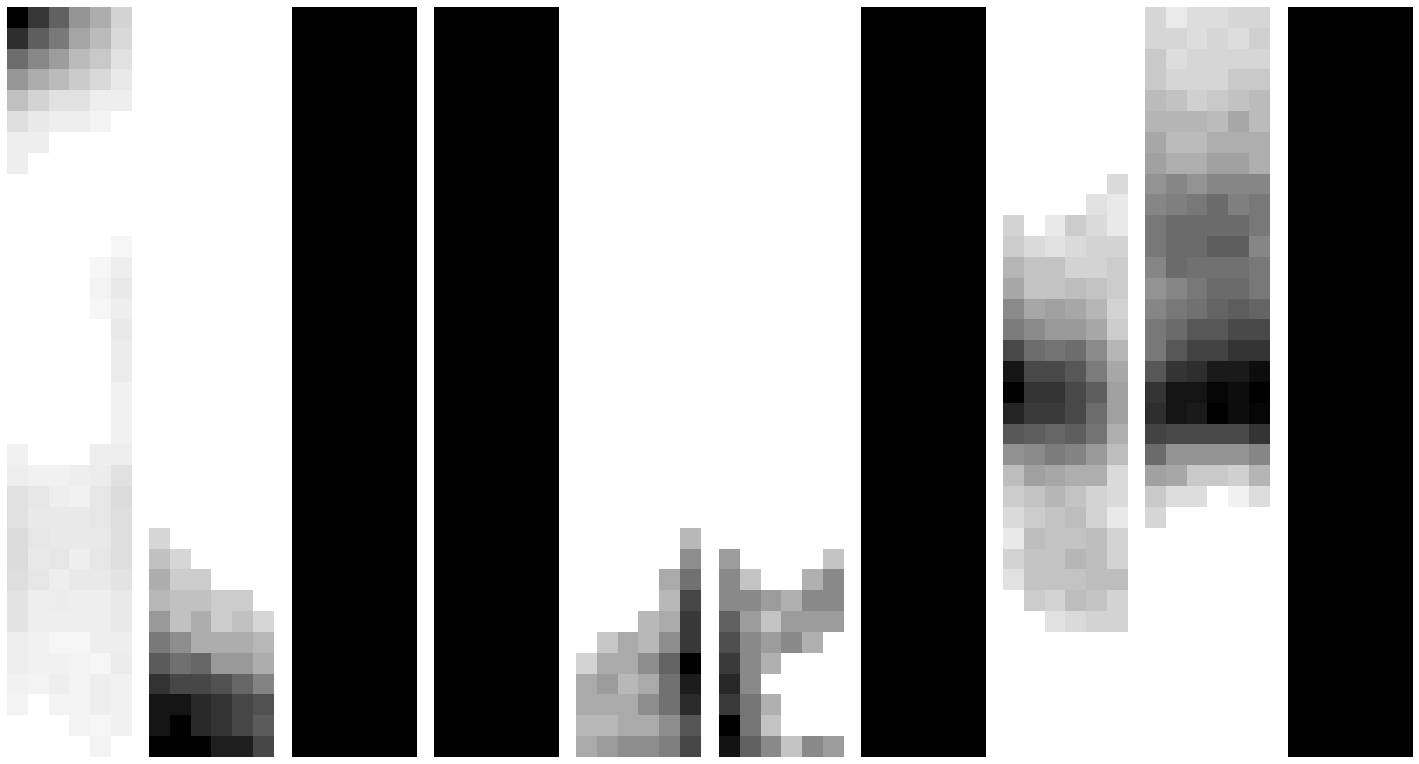

38/38 - 9s - loss: 7.8002 - d_loss: 3.5252e-04 - g_loss: 7.7999 - 9s/epoch - 244ms/step
Epoch 44/200


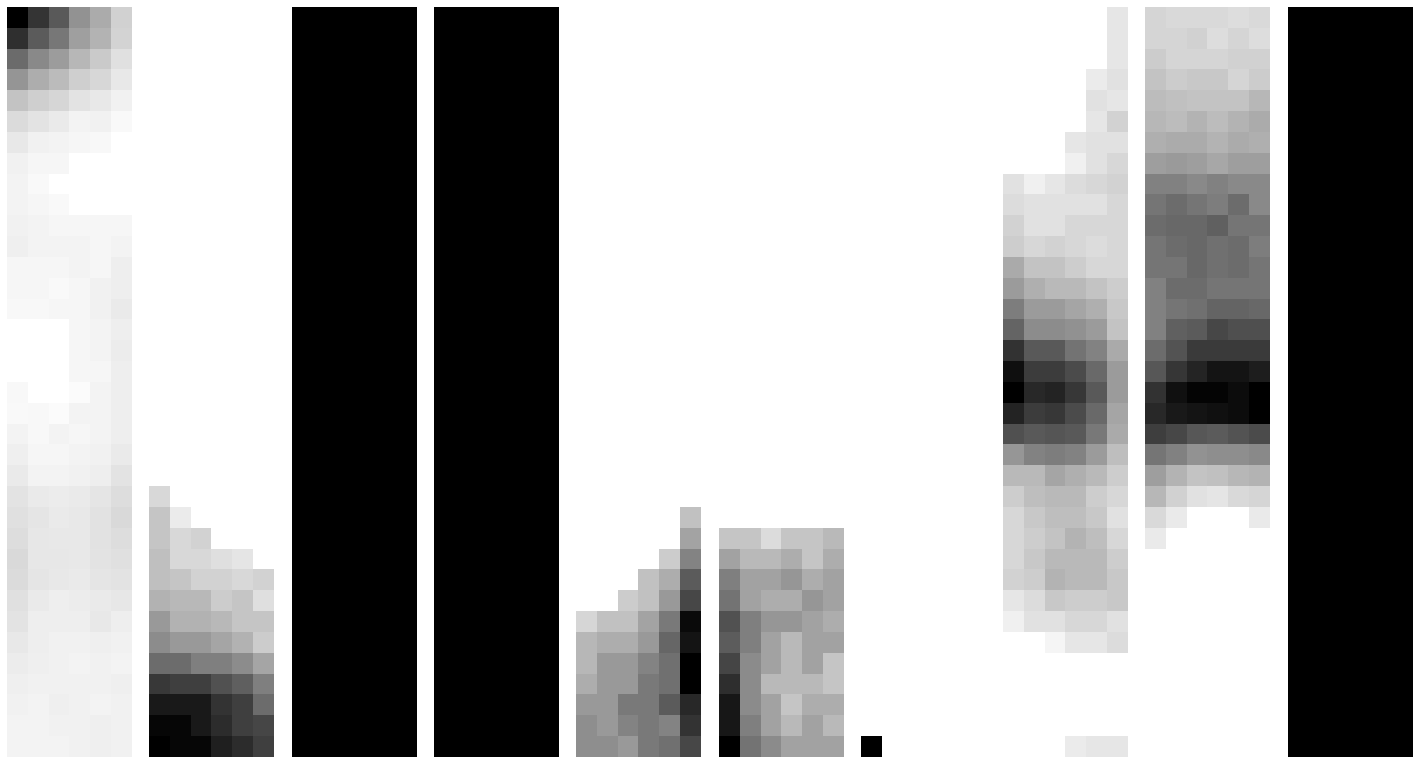

38/38 - 9s - loss: 7.8714 - d_loss: 3.3158e-04 - g_loss: 7.8711 - 9s/epoch - 239ms/step
Epoch 45/200


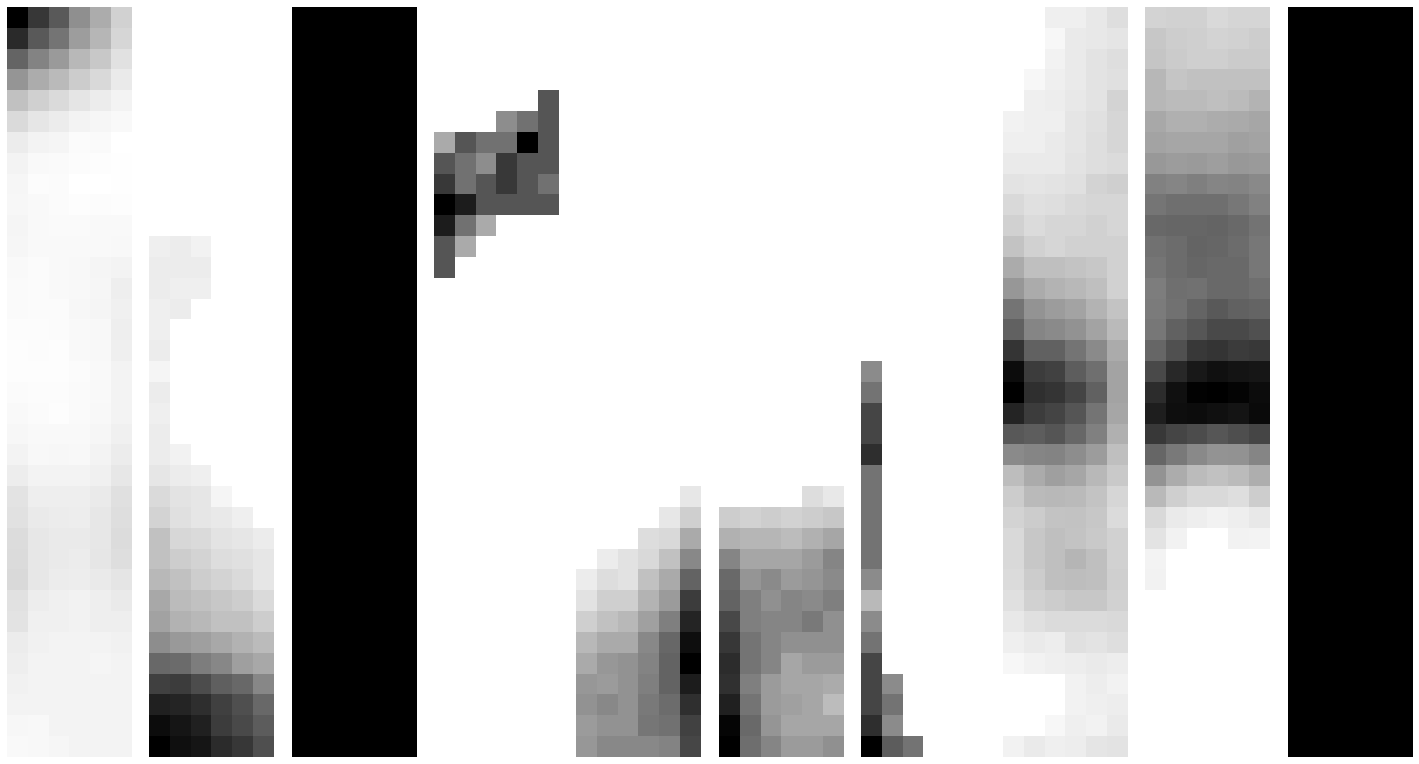

38/38 - 9s - loss: 7.9360 - d_loss: 3.1188e-04 - g_loss: 7.9357 - 9s/epoch - 238ms/step
Epoch 46/200


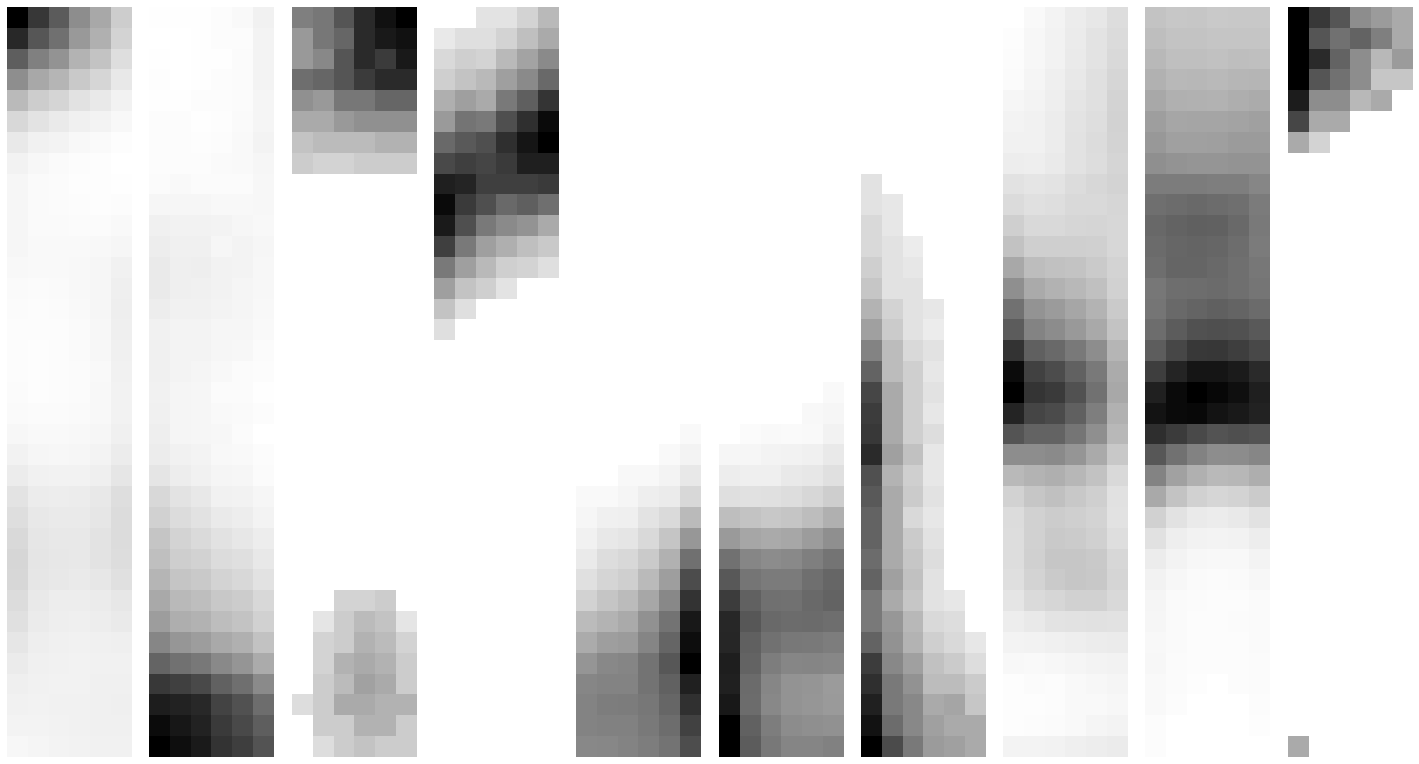

38/38 - 9s - loss: 7.9913 - d_loss: 2.9392e-04 - g_loss: 7.9910 - 9s/epoch - 238ms/step
Epoch 47/200


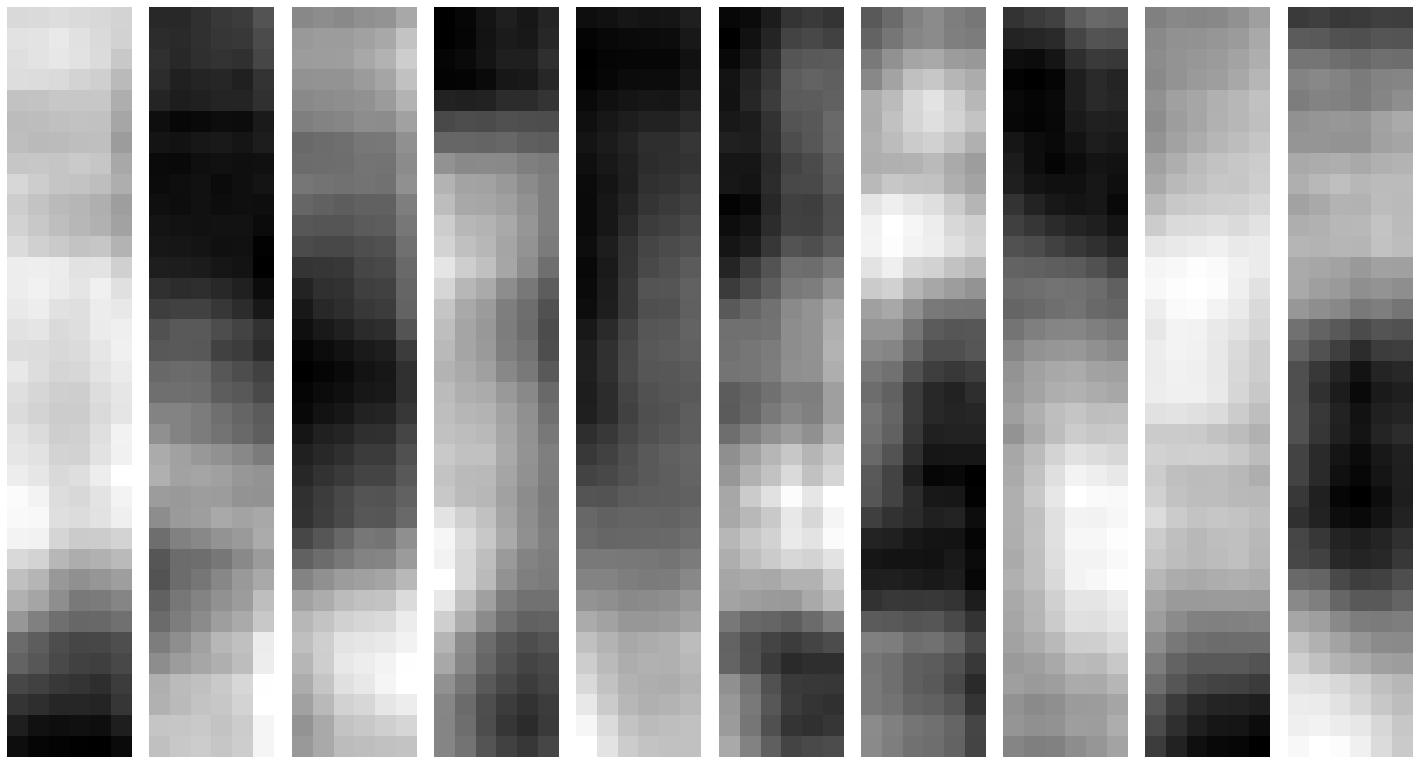

38/38 - 9s - loss: 7.5196 - d_loss: 0.0137 - g_loss: 7.5060 - 9s/epoch - 238ms/step
Epoch 48/200


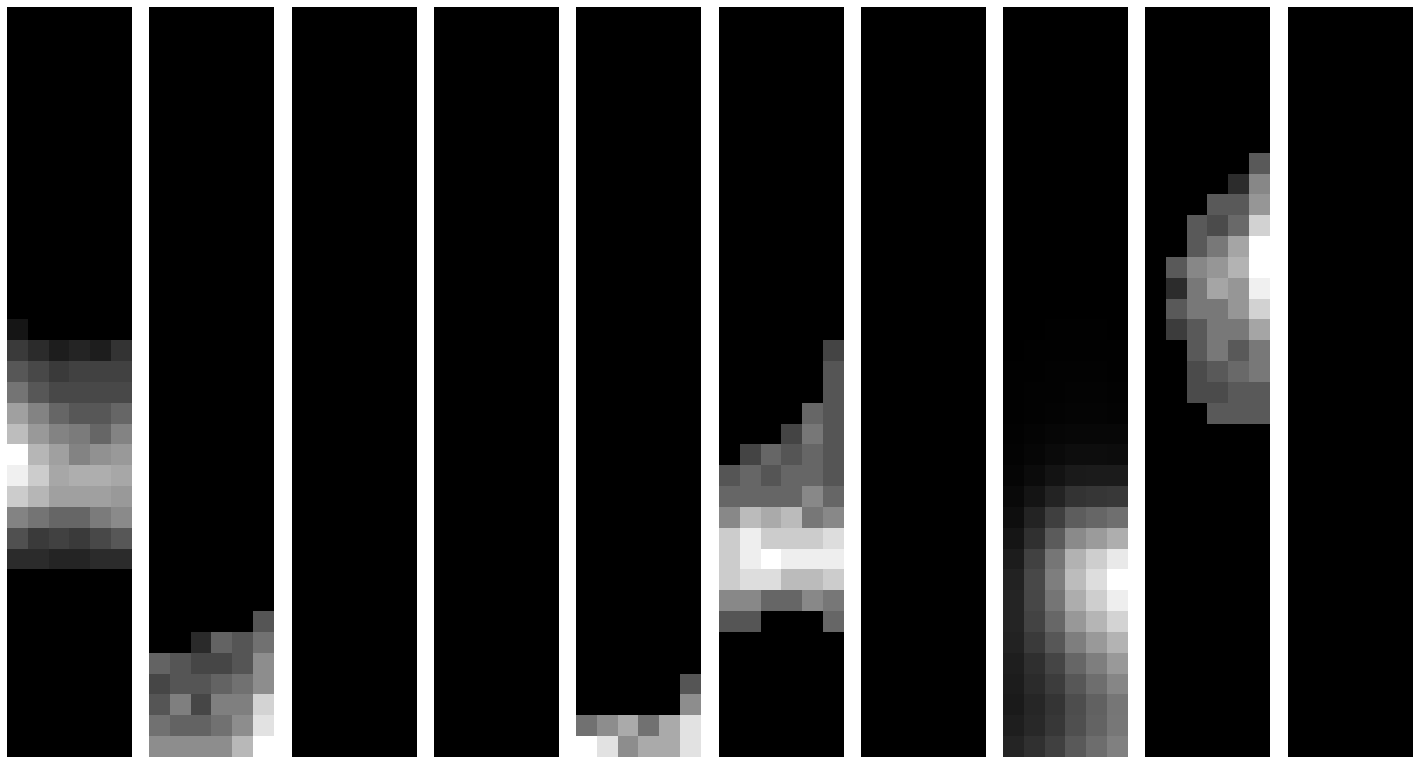

38/38 - 9s - loss: 2.1348 - d_loss: 1.1764 - g_loss: 0.9584 - 9s/epoch - 237ms/step
Epoch 49/200


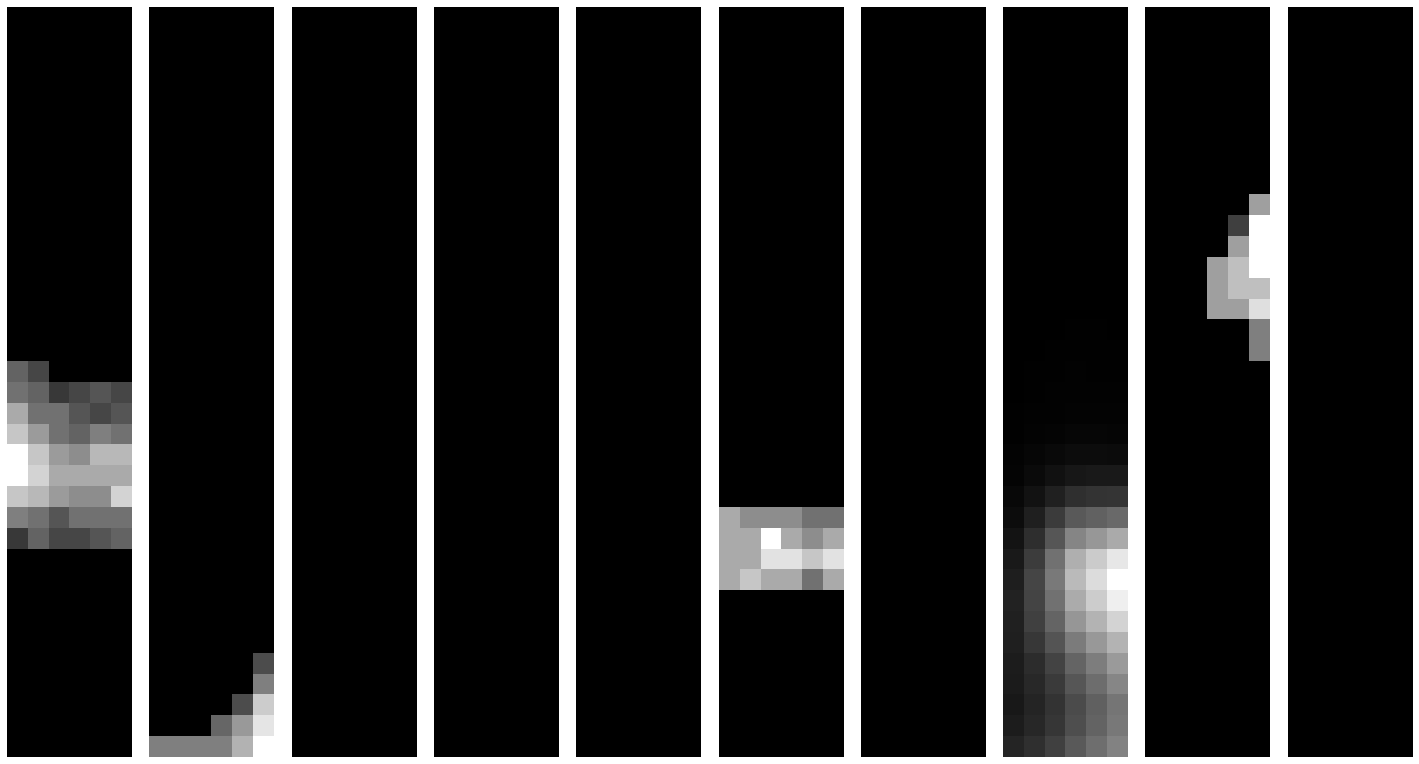

38/38 - 9s - loss: 1.4369 - d_loss: 0.6913 - g_loss: 0.7456 - 9s/epoch - 244ms/step
Epoch 50/200


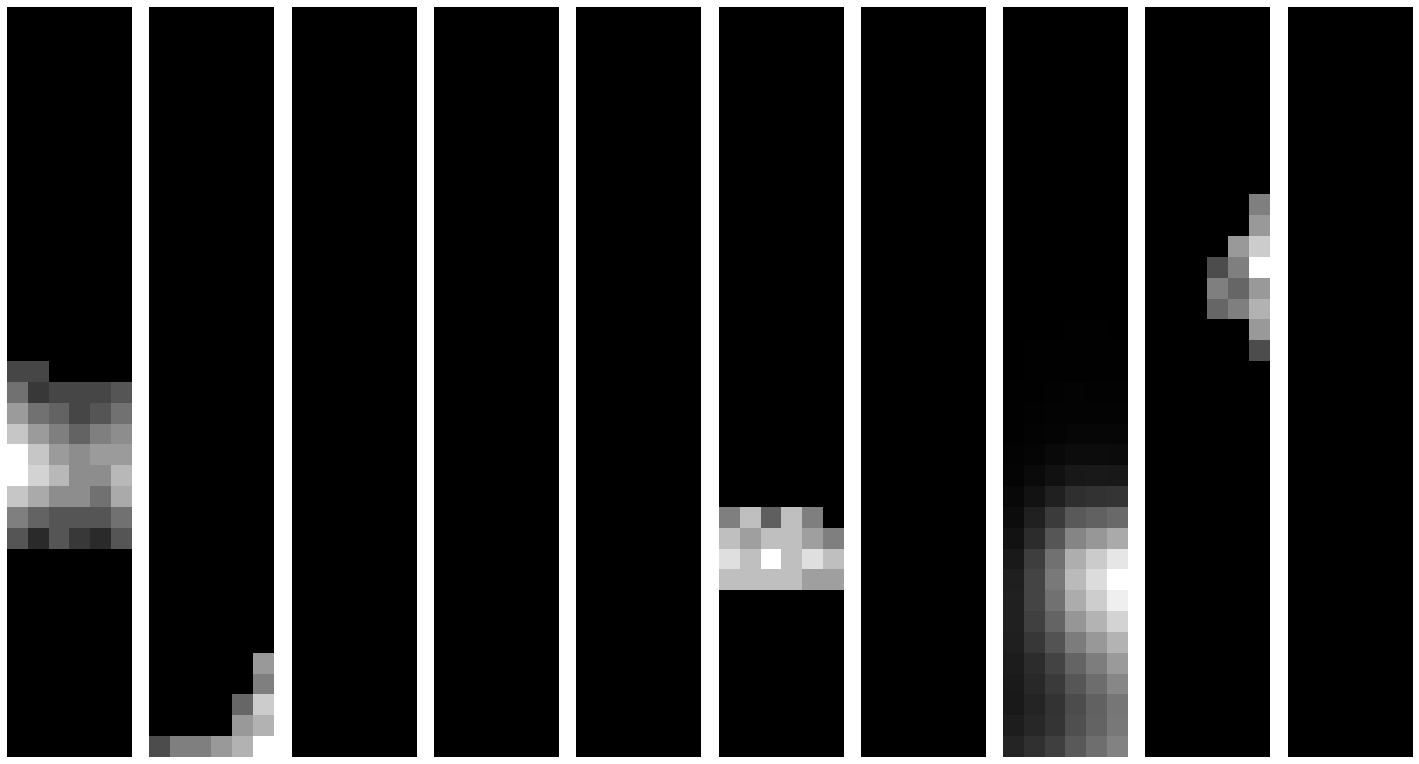

38/38 - 9s - loss: 1.4075 - d_loss: 0.6802 - g_loss: 0.7273 - 9s/epoch - 238ms/step
Epoch 51/200


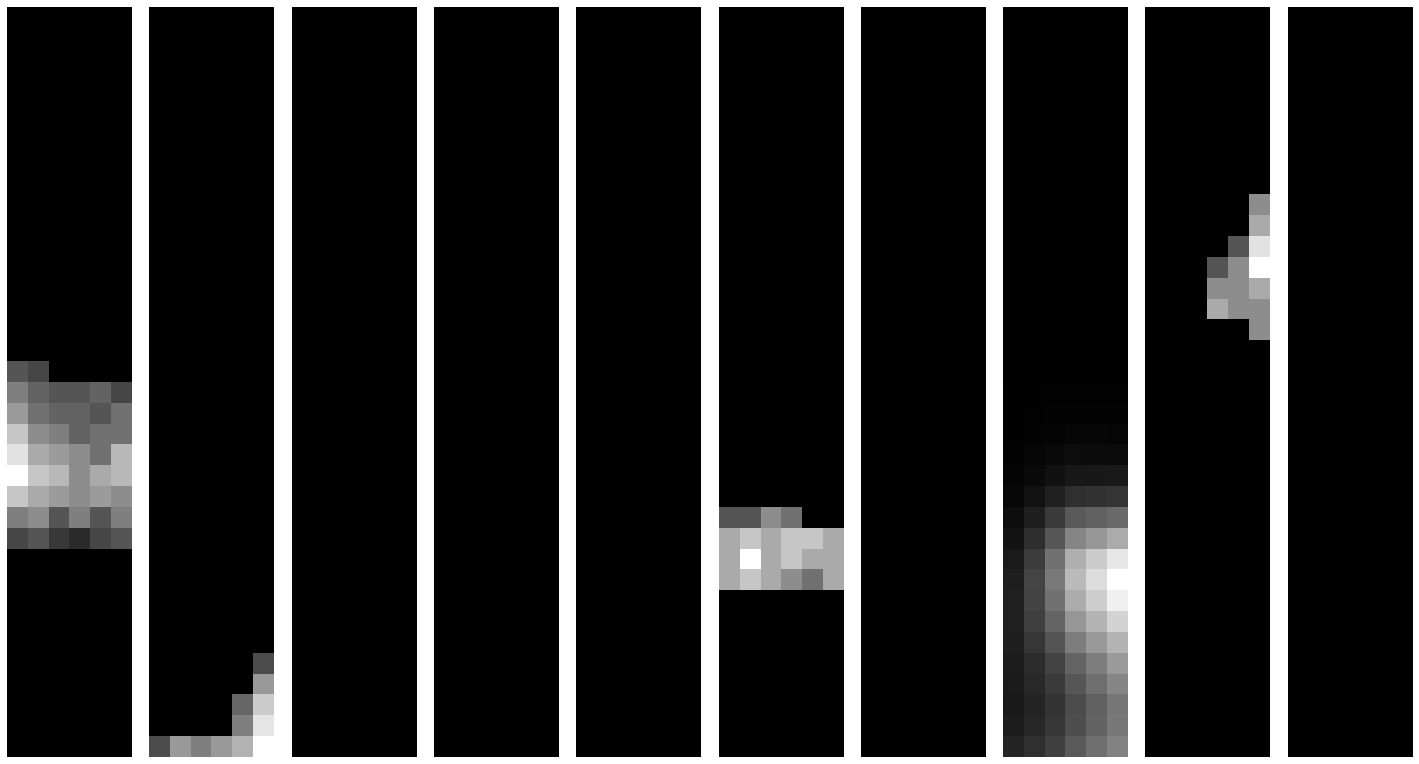

38/38 - 9s - loss: 1.4050 - d_loss: 0.6764 - g_loss: 0.7285 - 9s/epoch - 238ms/step
Epoch 52/200


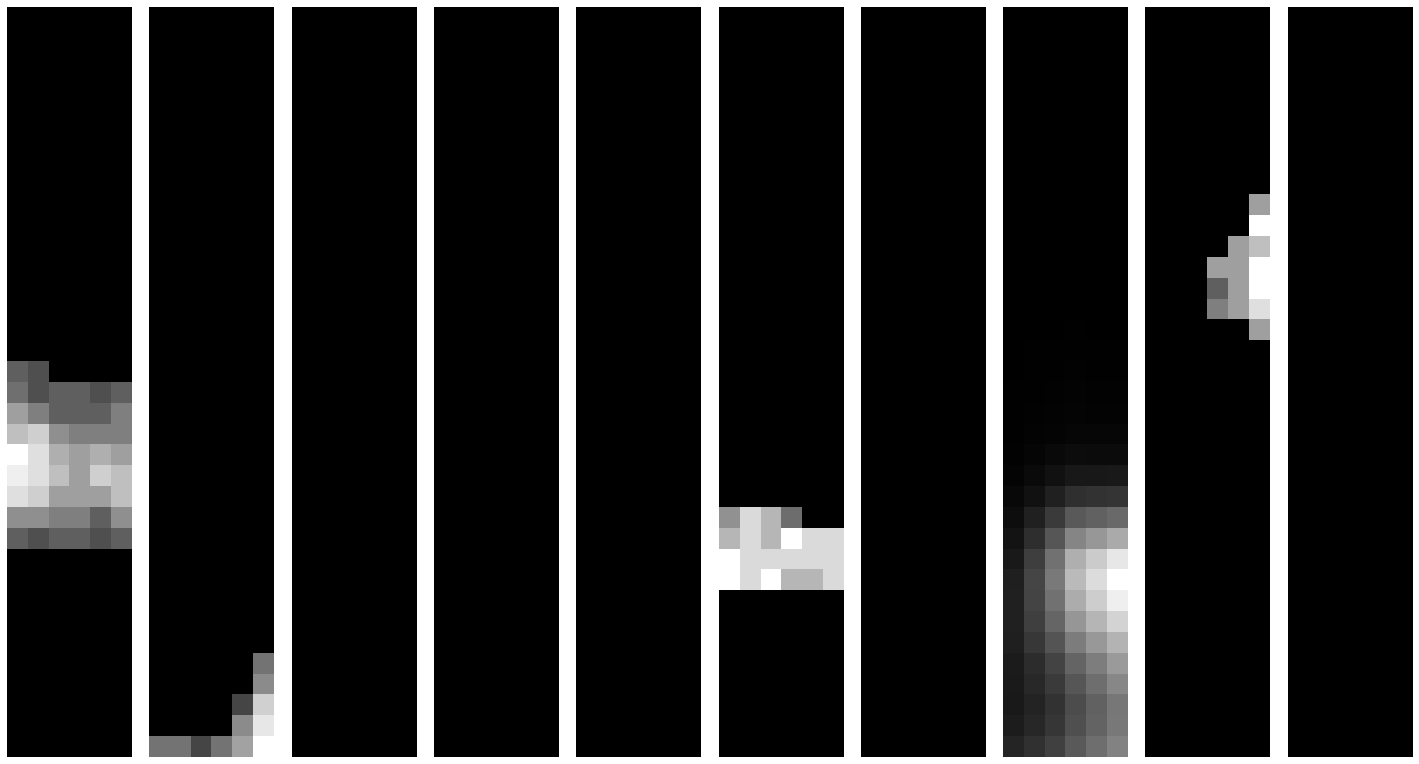

38/38 - 9s - loss: 1.4034 - d_loss: 0.6741 - g_loss: 0.7293 - 9s/epoch - 239ms/step
Epoch 53/200


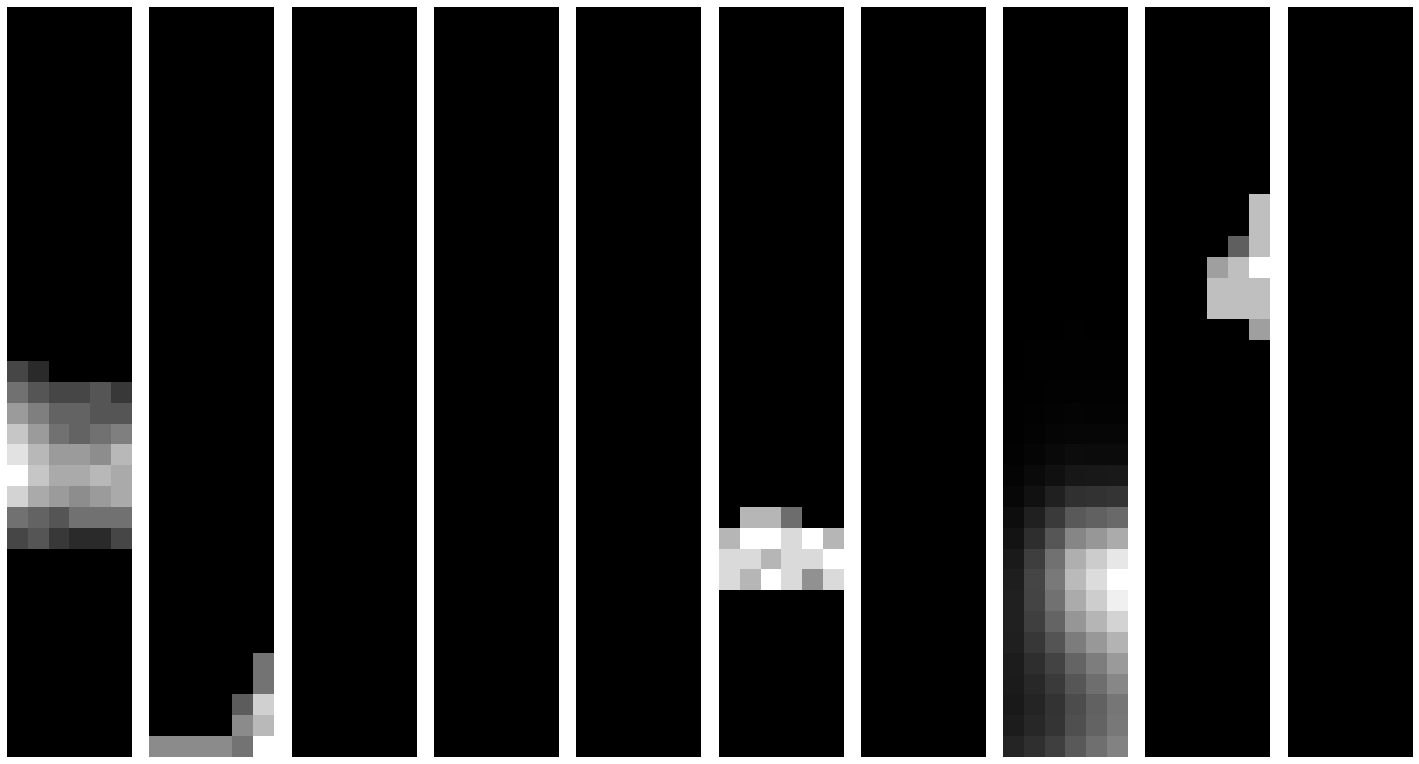

38/38 - 9s - loss: 1.4027 - d_loss: 0.6723 - g_loss: 0.7304 - 9s/epoch - 238ms/step
Epoch 54/200


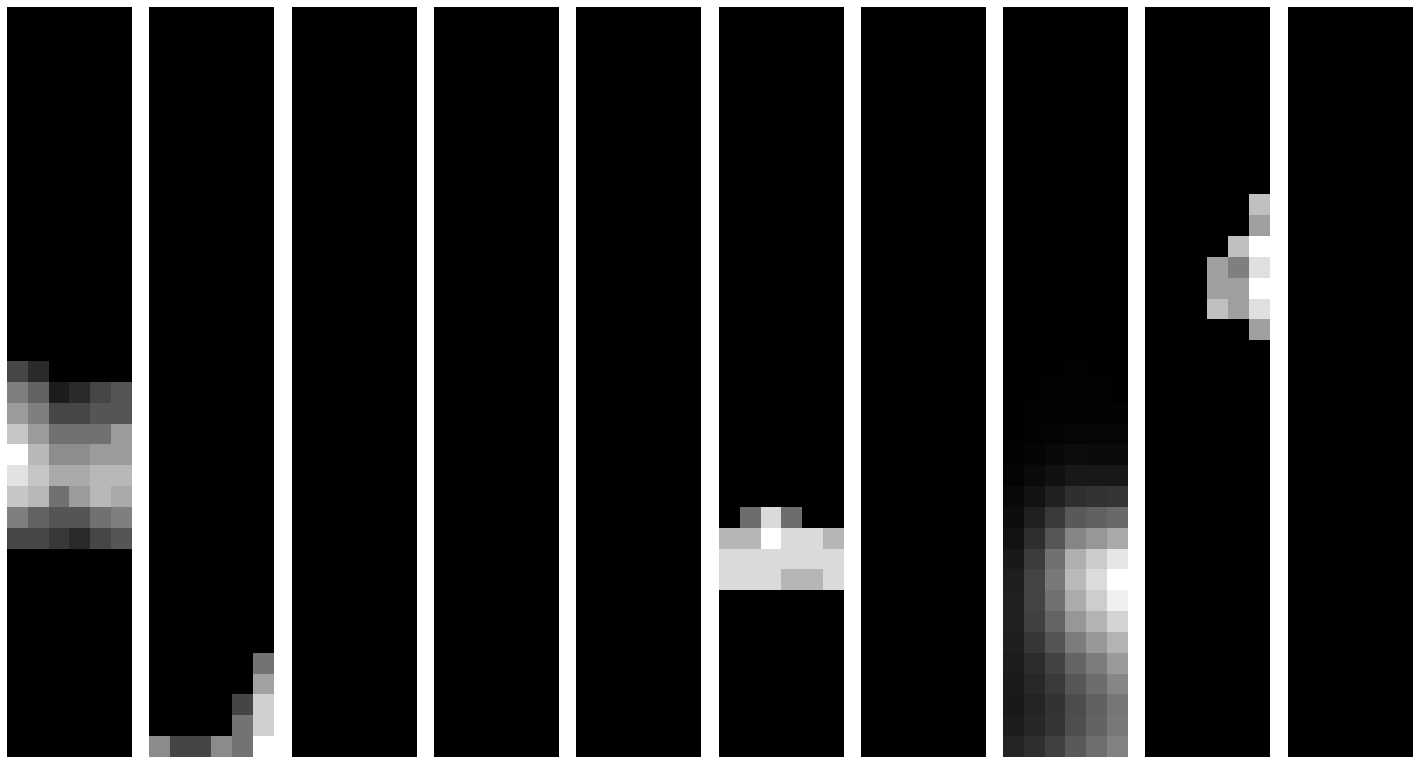

38/38 - 9s - loss: 1.4018 - d_loss: 0.6705 - g_loss: 0.7313 - 9s/epoch - 237ms/step
Epoch 55/200


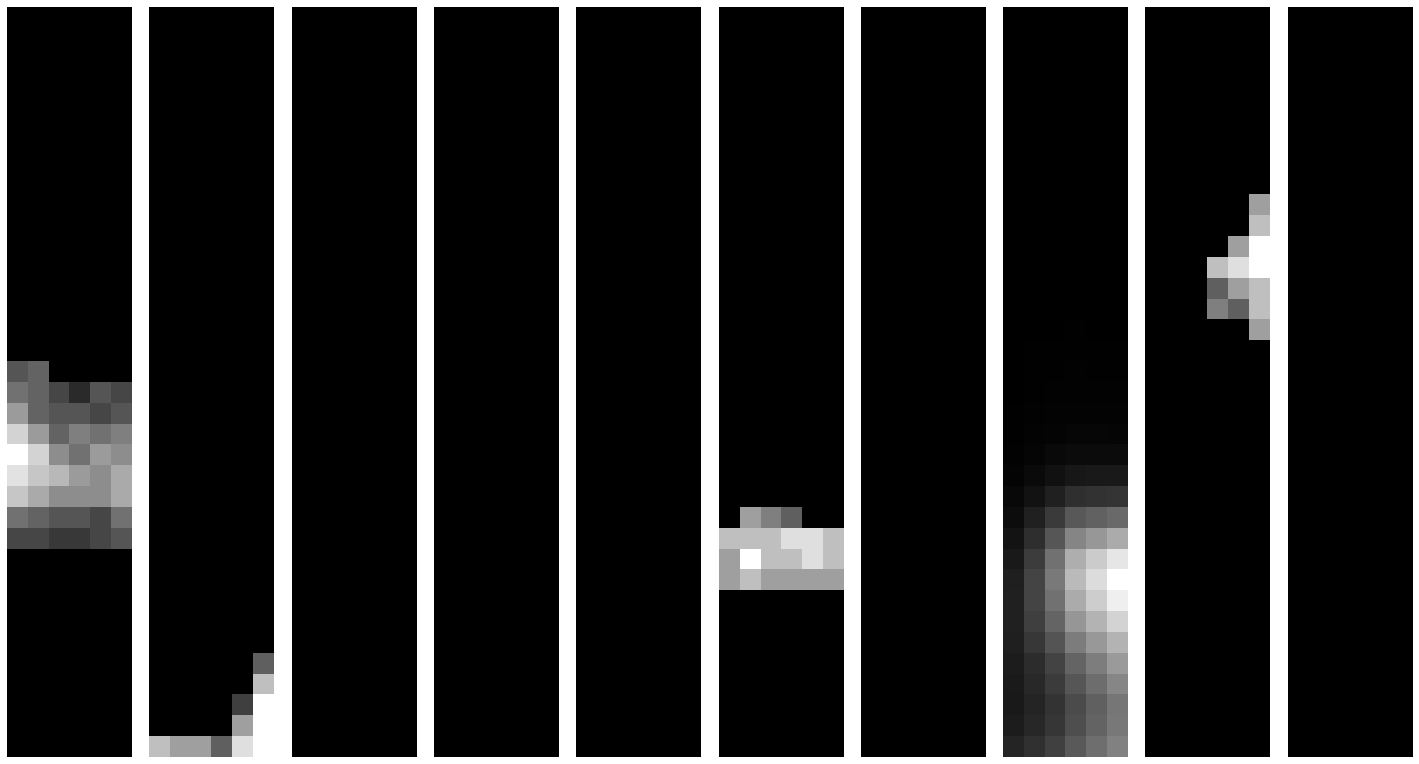

38/38 - 9s - loss: 1.4017 - d_loss: 0.6688 - g_loss: 0.7329 - 9s/epoch - 246ms/step
Epoch 56/200


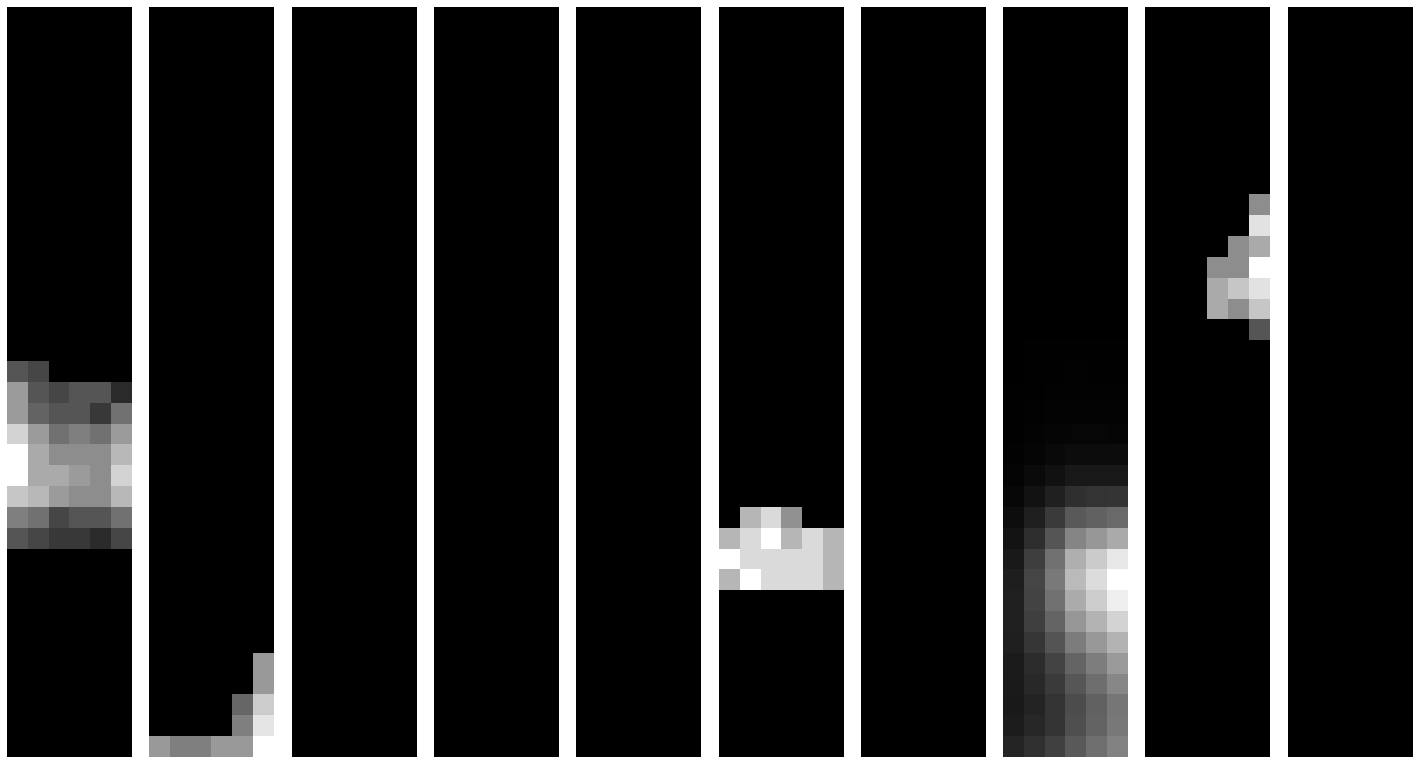

38/38 - 9s - loss: 1.4006 - d_loss: 0.6674 - g_loss: 0.7332 - 9s/epoch - 237ms/step
Epoch 57/200


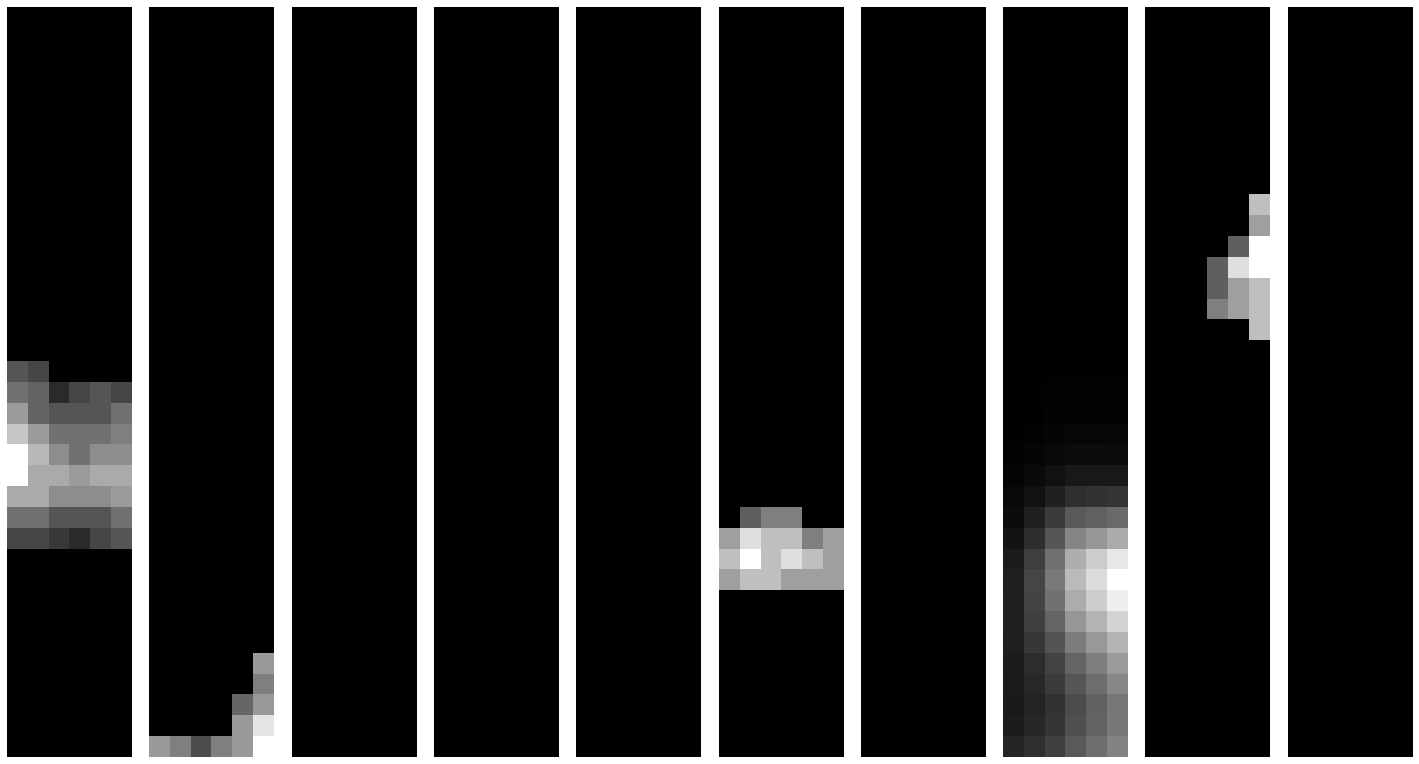

38/38 - 9s - loss: 1.4030 - d_loss: 0.6661 - g_loss: 0.7369 - 9s/epoch - 238ms/step
Epoch 58/200


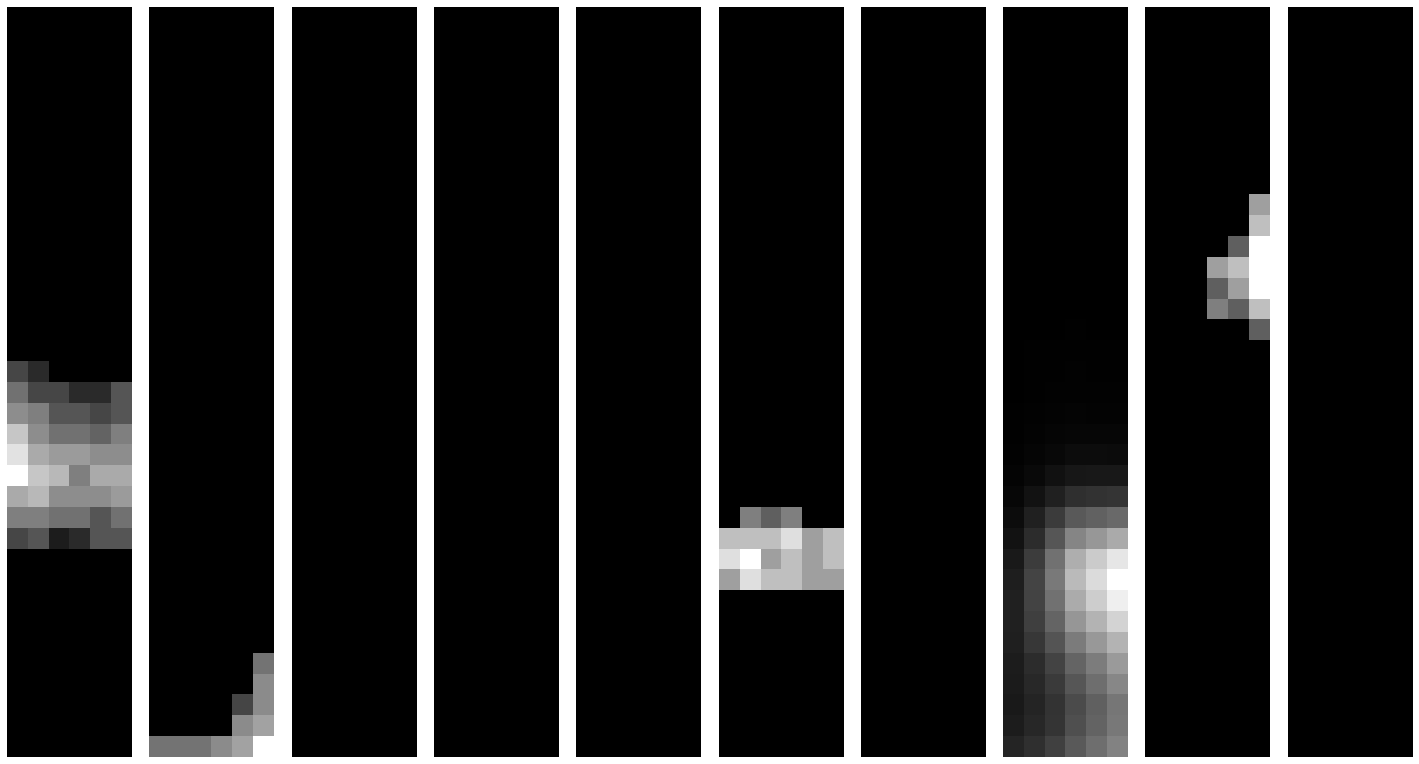

38/38 - 9s - loss: 1.4006 - d_loss: 0.6646 - g_loss: 0.7359 - 9s/epoch - 238ms/step
Epoch 59/200


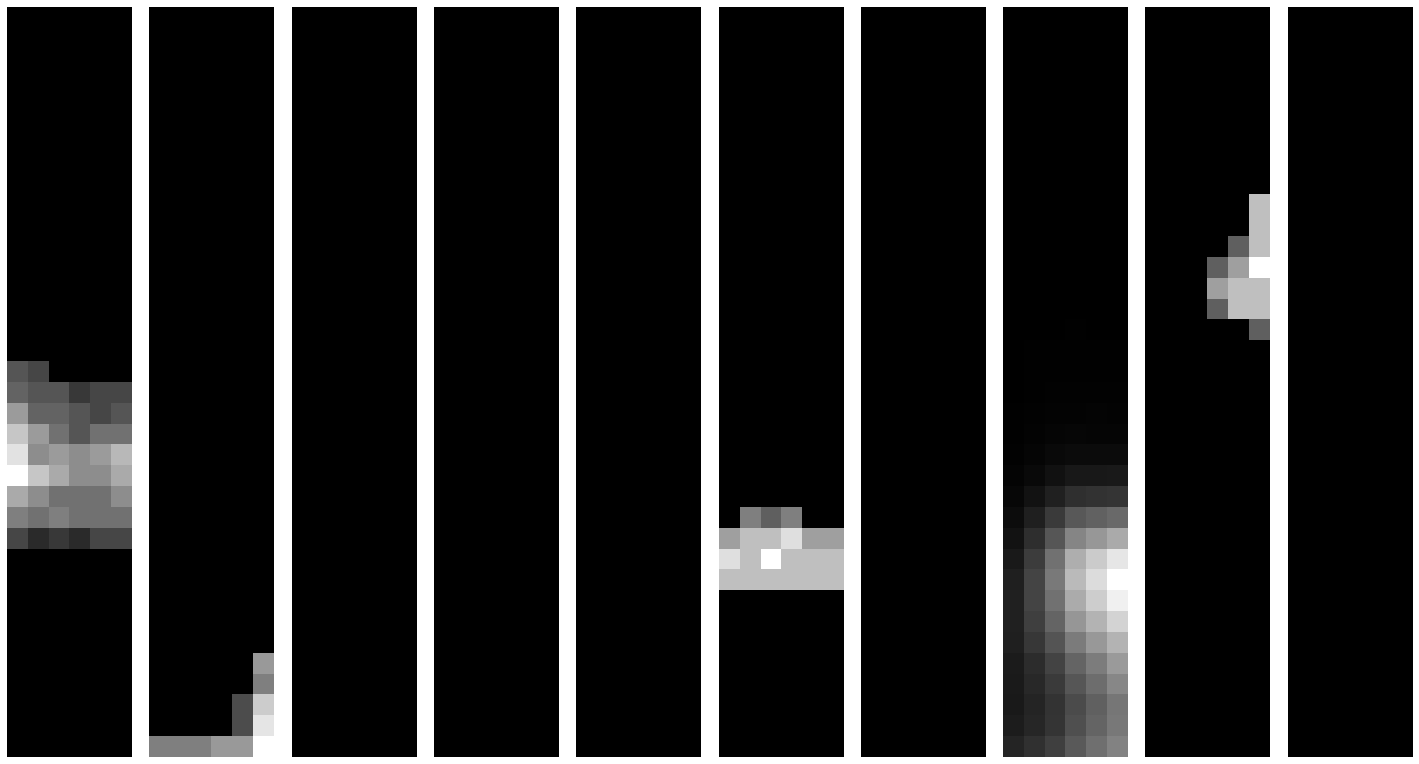

38/38 - 9s - loss: 1.4026 - d_loss: 0.6631 - g_loss: 0.7396 - 9s/epoch - 238ms/step
Epoch 60/200


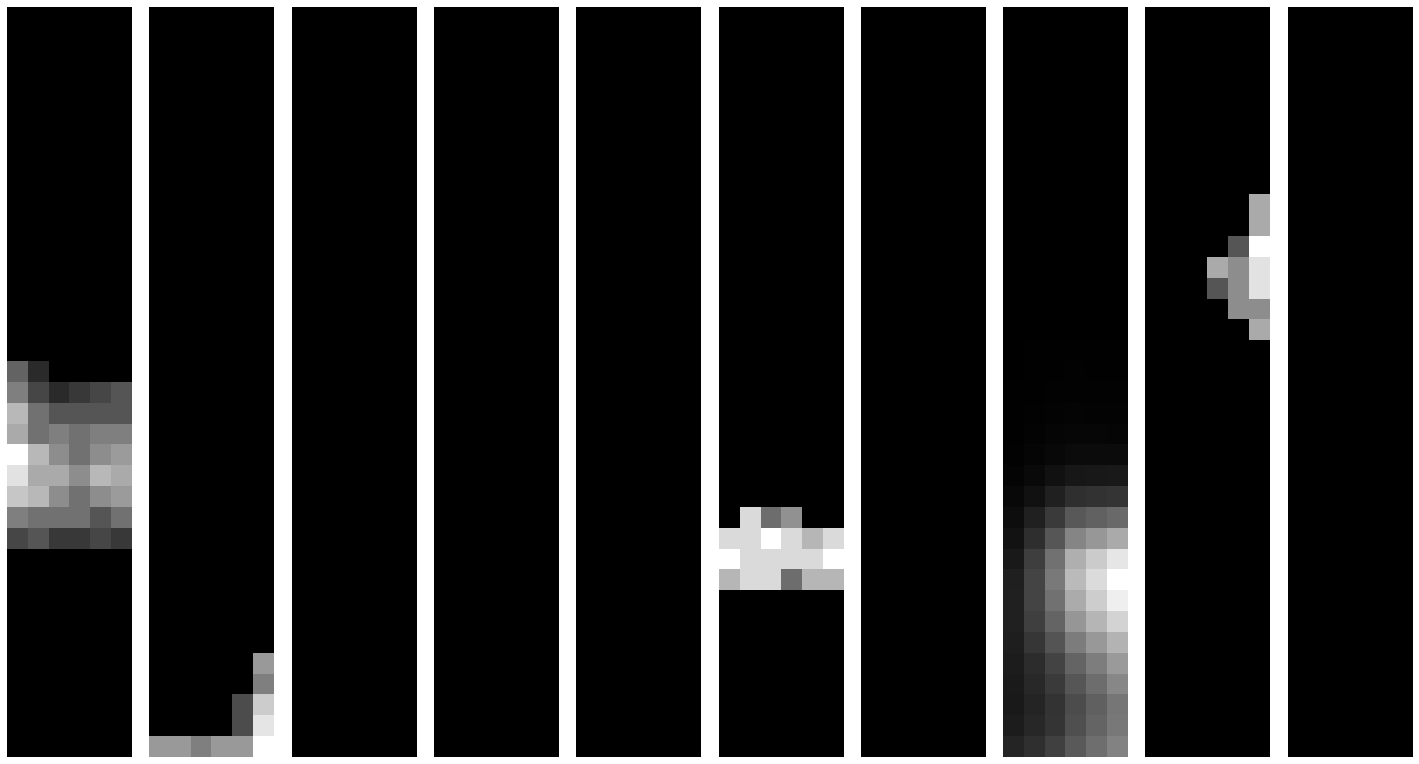

38/38 - 9s - loss: 1.4036 - d_loss: 0.6620 - g_loss: 0.7416 - 9s/epoch - 242ms/step
Epoch 61/200


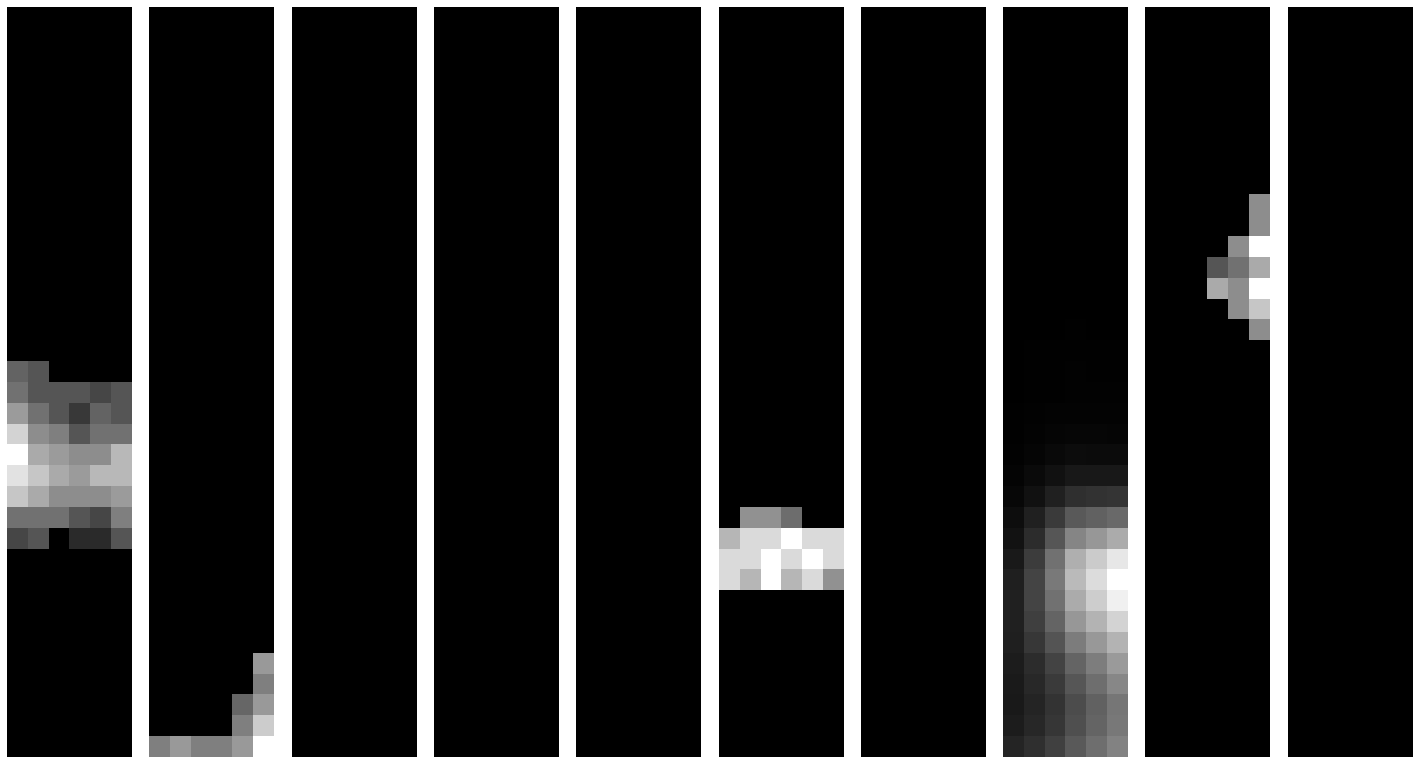

38/38 - 9s - loss: 1.4021 - d_loss: 0.6607 - g_loss: 0.7414 - 9s/epoch - 238ms/step
Epoch 62/200


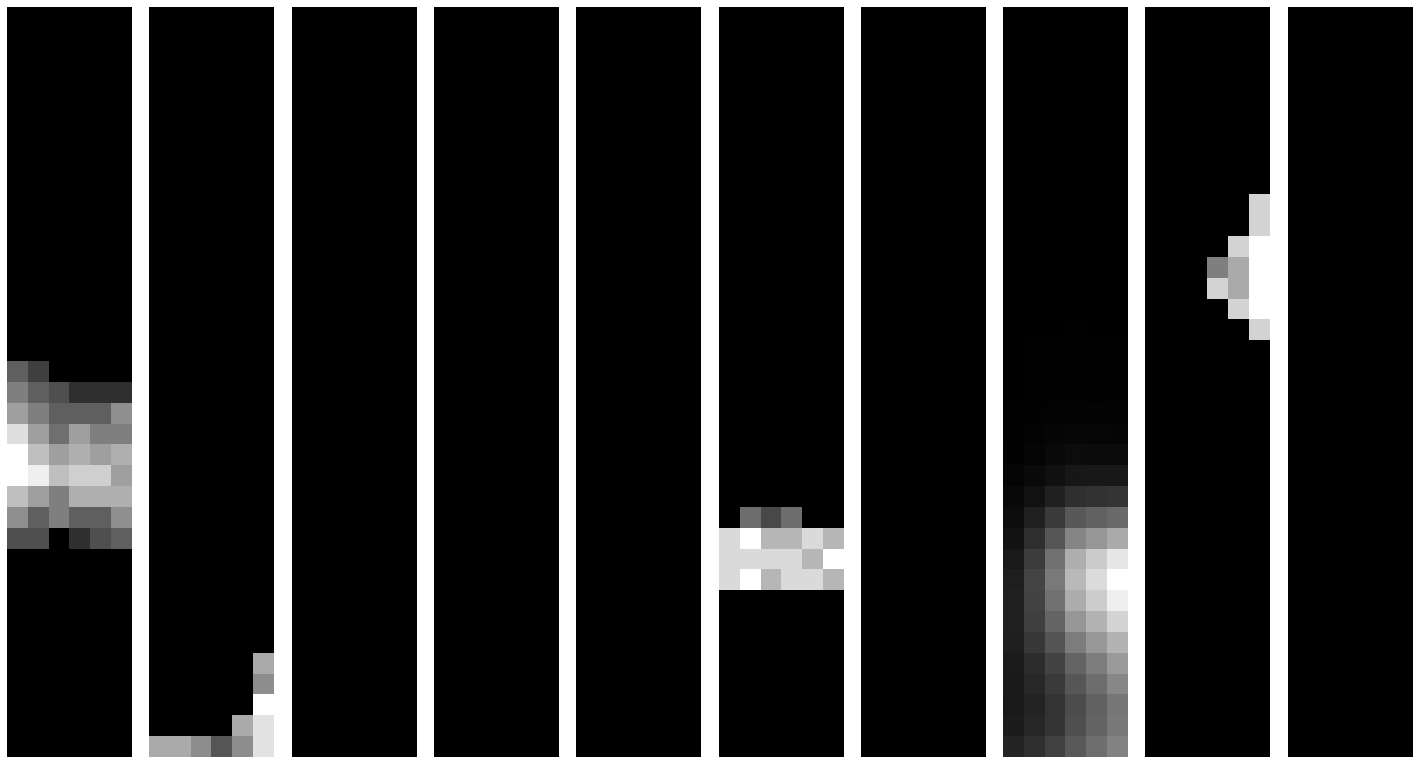

38/38 - 9s - loss: 1.4013 - d_loss: 0.6594 - g_loss: 0.7419 - 9s/epoch - 238ms/step
Epoch 63/200


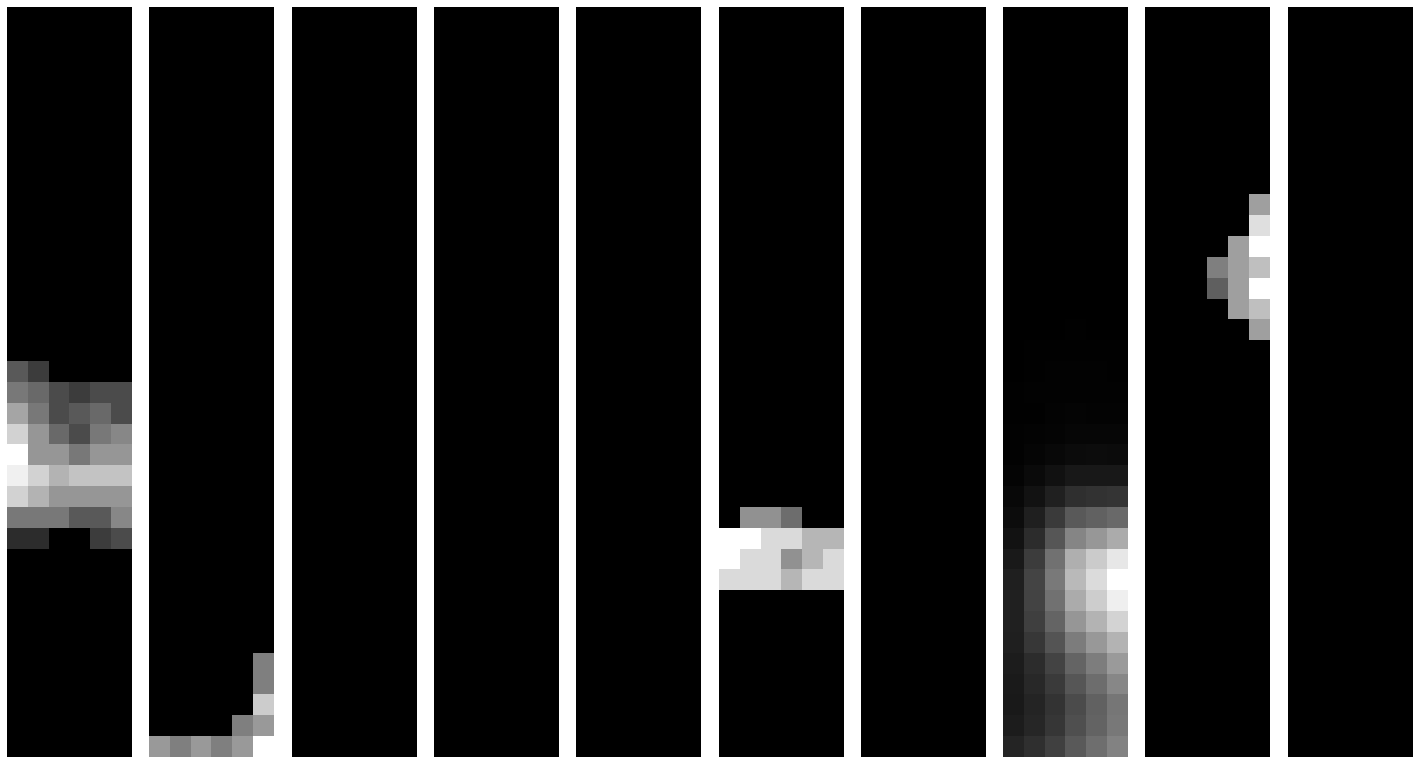

38/38 - 9s - loss: 1.4026 - d_loss: 0.6583 - g_loss: 0.7443 - 9s/epoch - 237ms/step
Epoch 64/200


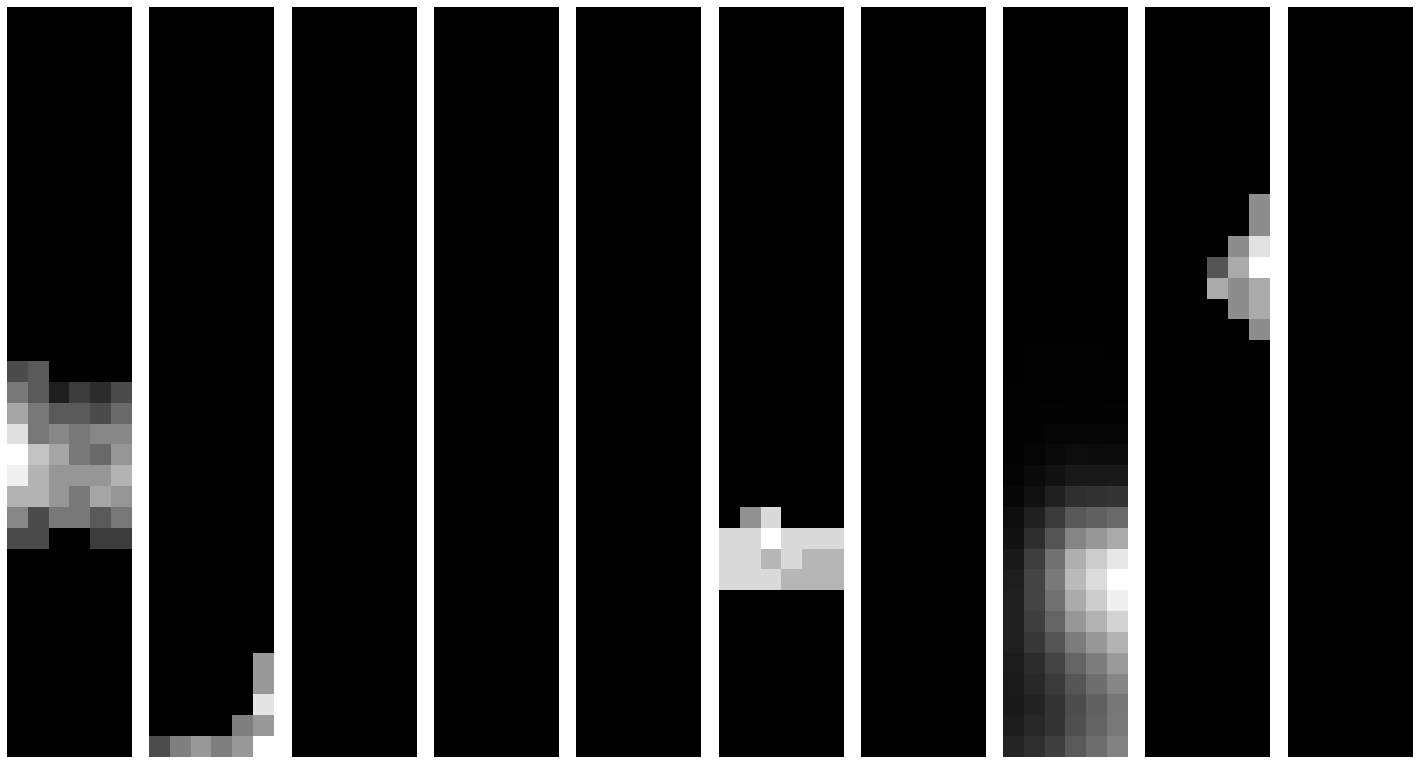

38/38 - 9s - loss: 1.4047 - d_loss: 0.6571 - g_loss: 0.7477 - 9s/epoch - 238ms/step
Epoch 65/200


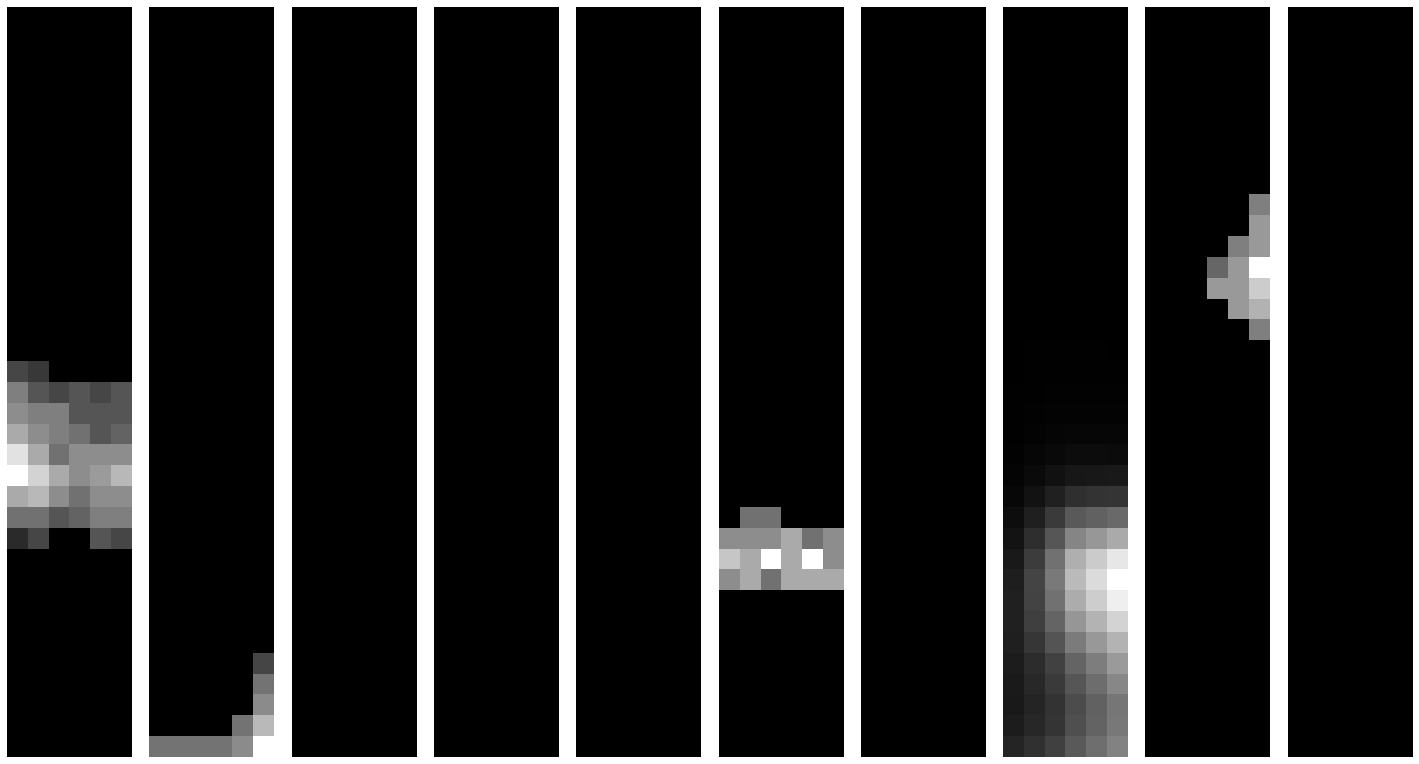

38/38 - 9s - loss: 1.4041 - d_loss: 0.6559 - g_loss: 0.7482 - 9s/epoch - 238ms/step
Epoch 66/200


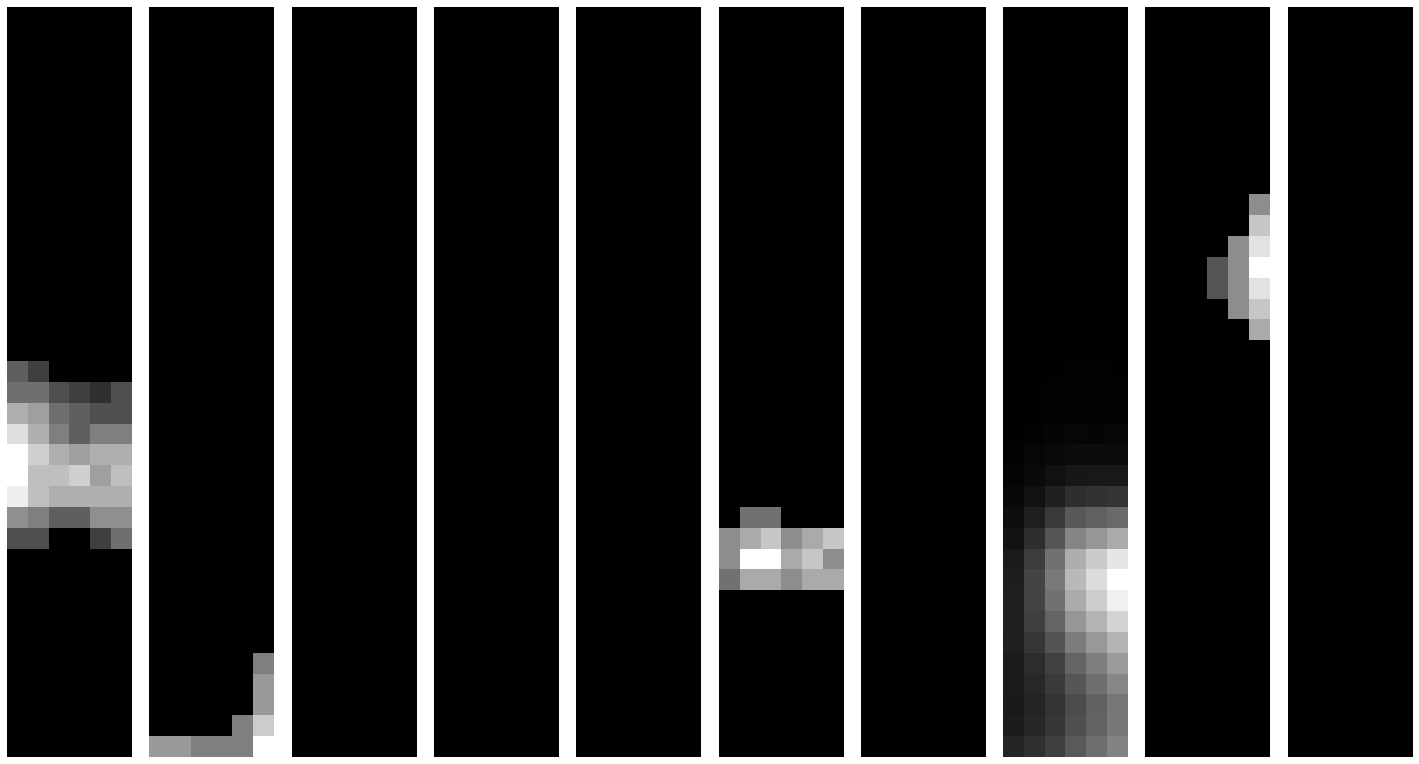

38/38 - 9s - loss: 1.4068 - d_loss: 0.6546 - g_loss: 0.7522 - 9s/epoch - 243ms/step
Epoch 67/200


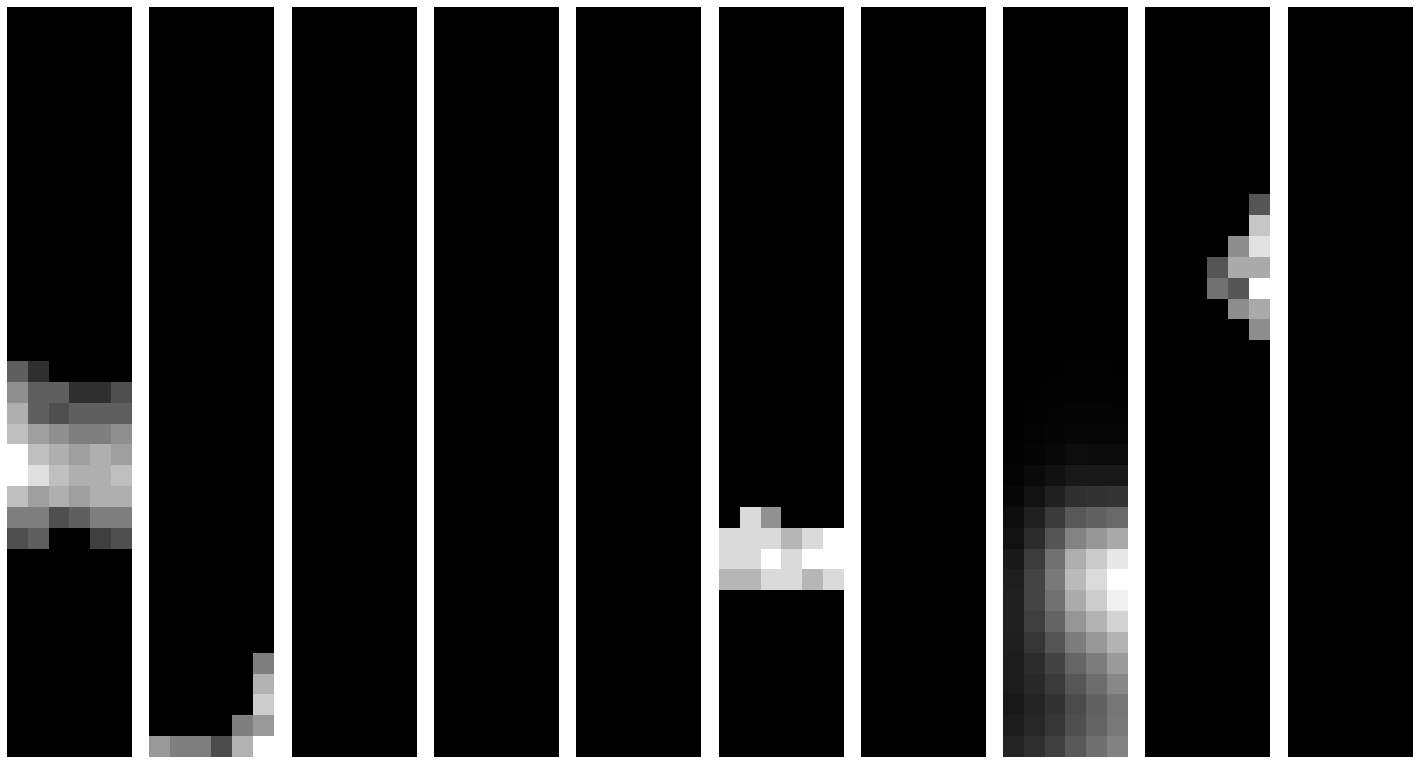

38/38 - 9s - loss: 1.4021 - d_loss: 0.6533 - g_loss: 0.7488 - 9s/epoch - 239ms/step
Epoch 68/200


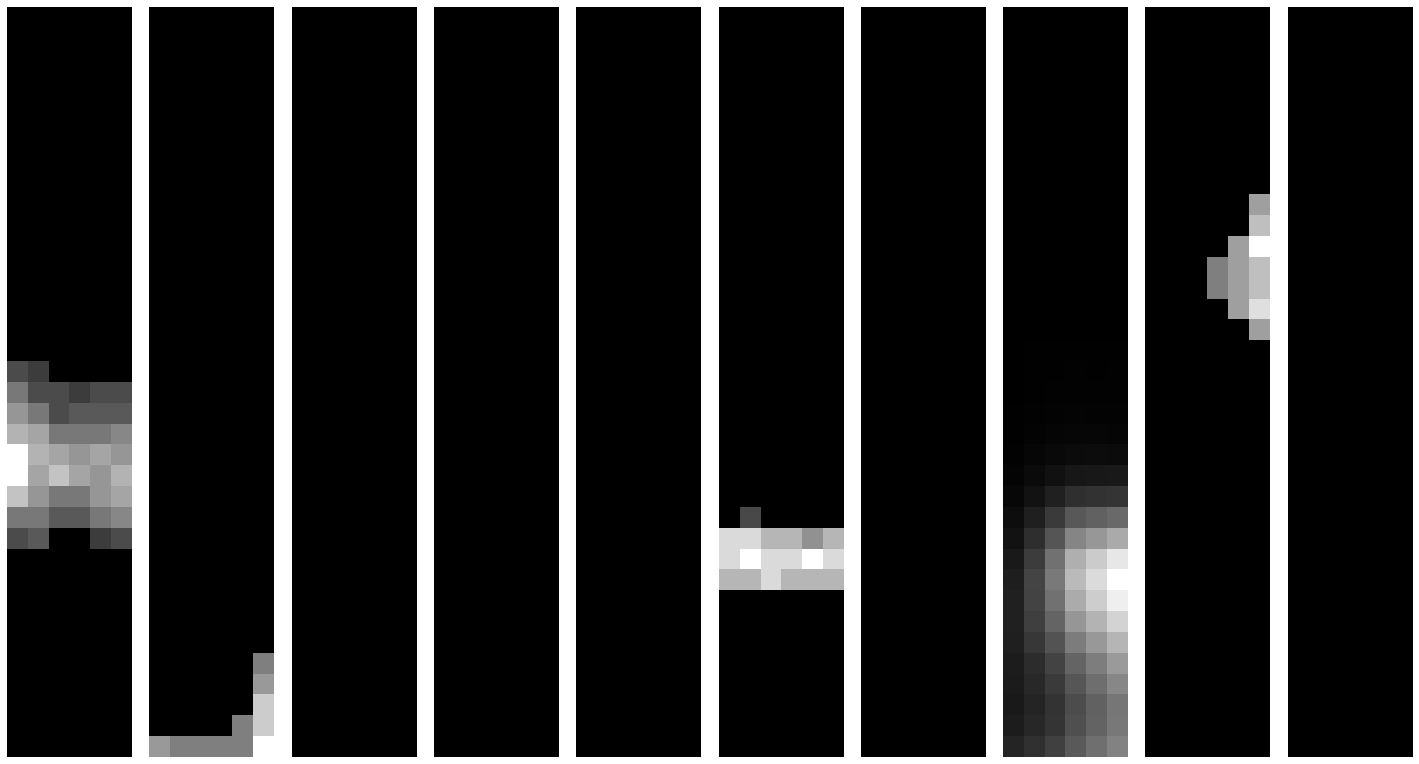

38/38 - 9s - loss: 1.4056 - d_loss: 0.6520 - g_loss: 0.7536 - 9s/epoch - 237ms/step
Epoch 69/200


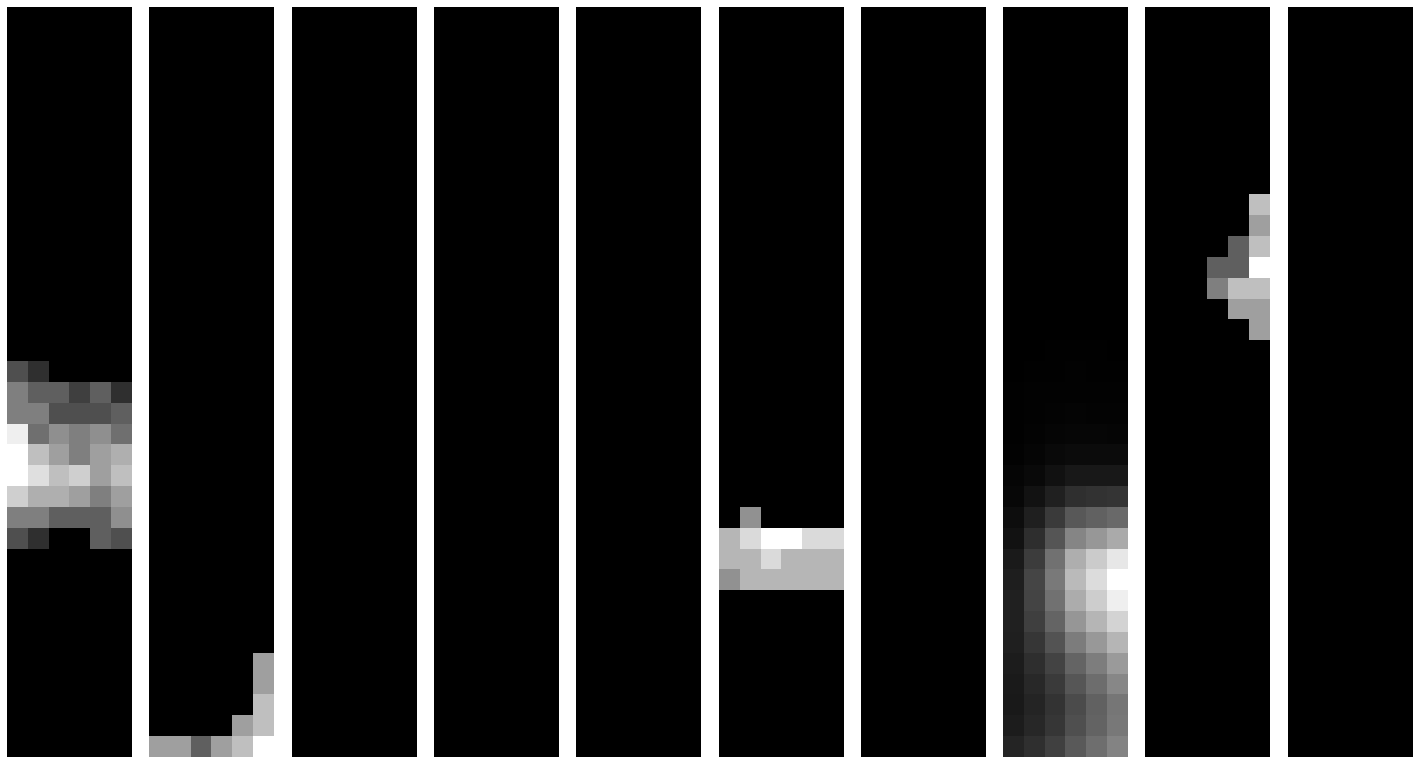

38/38 - 9s - loss: 1.4055 - d_loss: 0.6508 - g_loss: 0.7547 - 9s/epoch - 238ms/step
Epoch 70/200


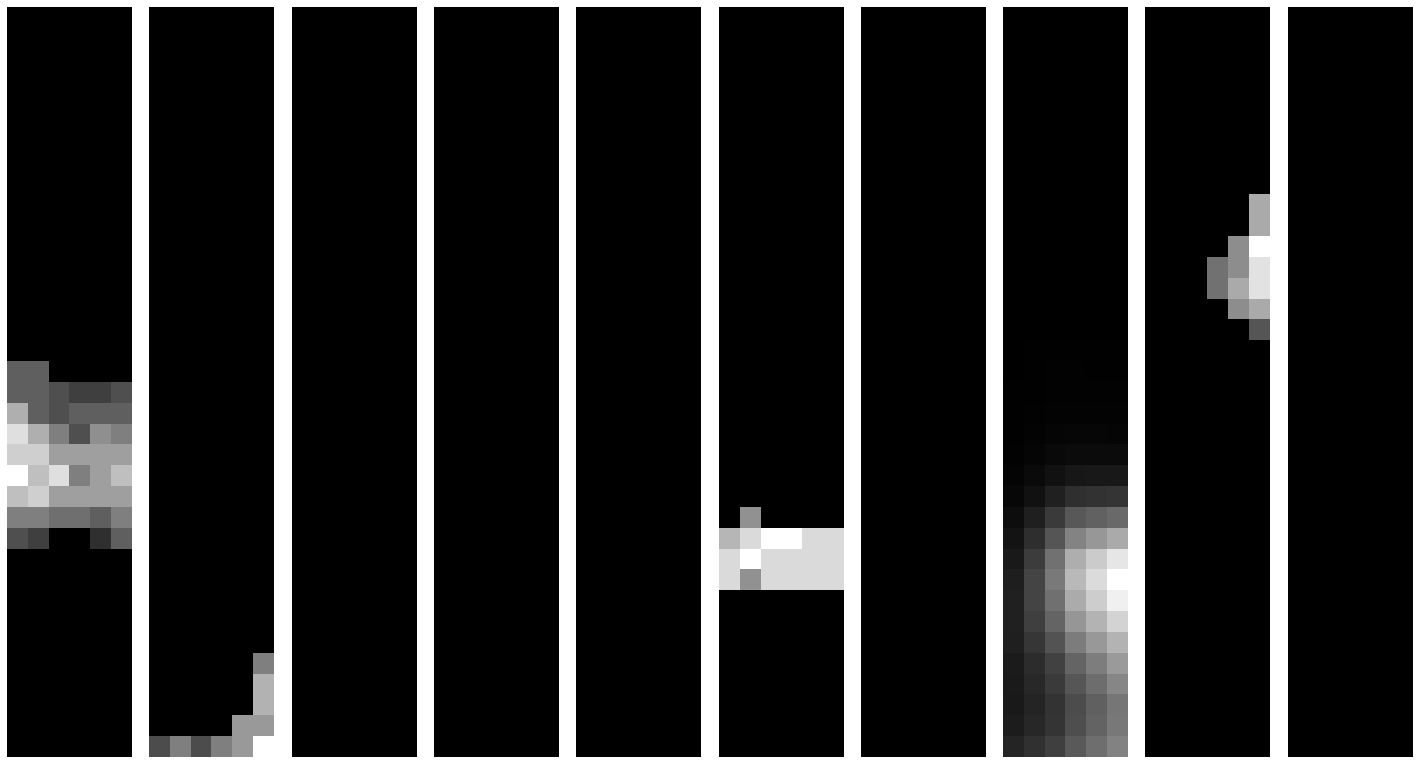

38/38 - 9s - loss: 1.4056 - d_loss: 0.6494 - g_loss: 0.7561 - 9s/epoch - 236ms/step
Epoch 71/200


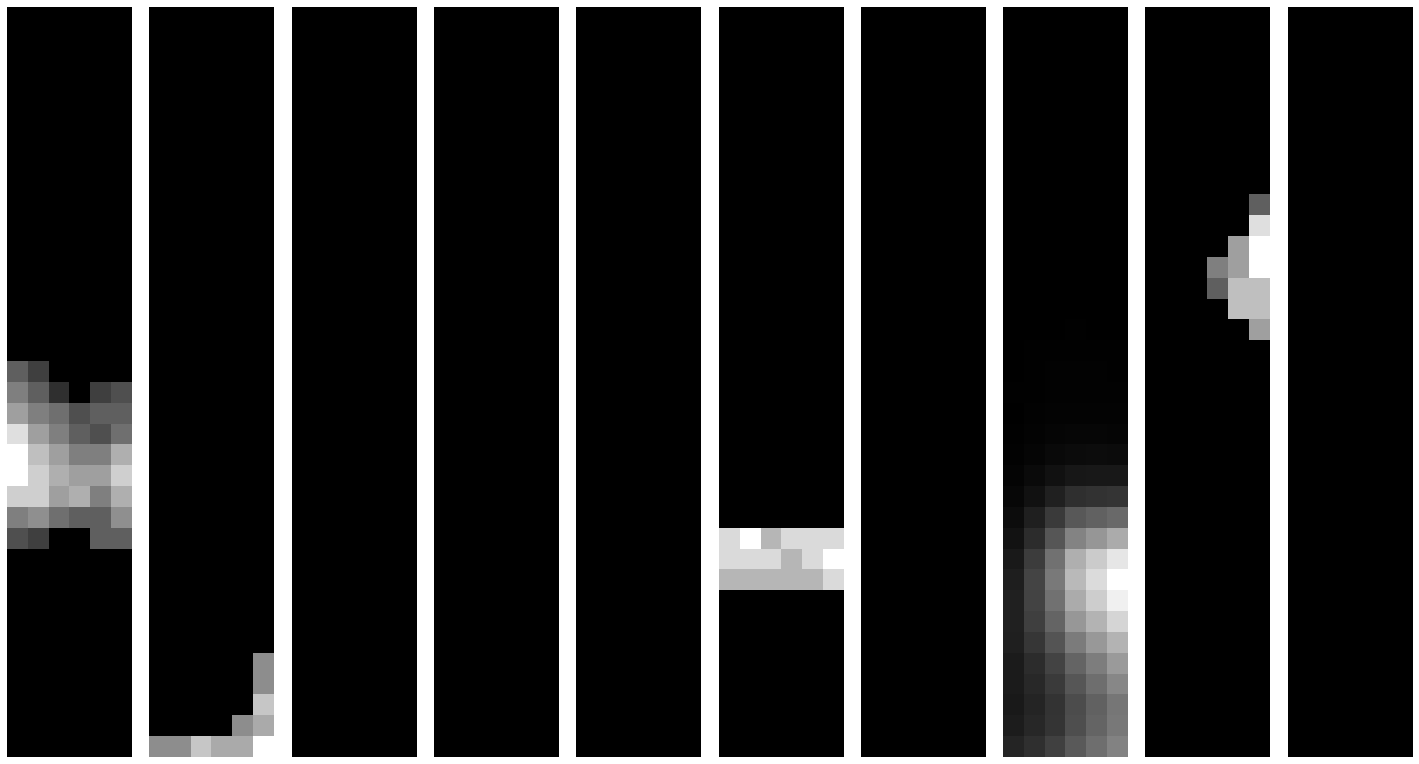

38/38 - 9s - loss: 1.4065 - d_loss: 0.6480 - g_loss: 0.7585 - 9s/epoch - 238ms/step
Epoch 72/200


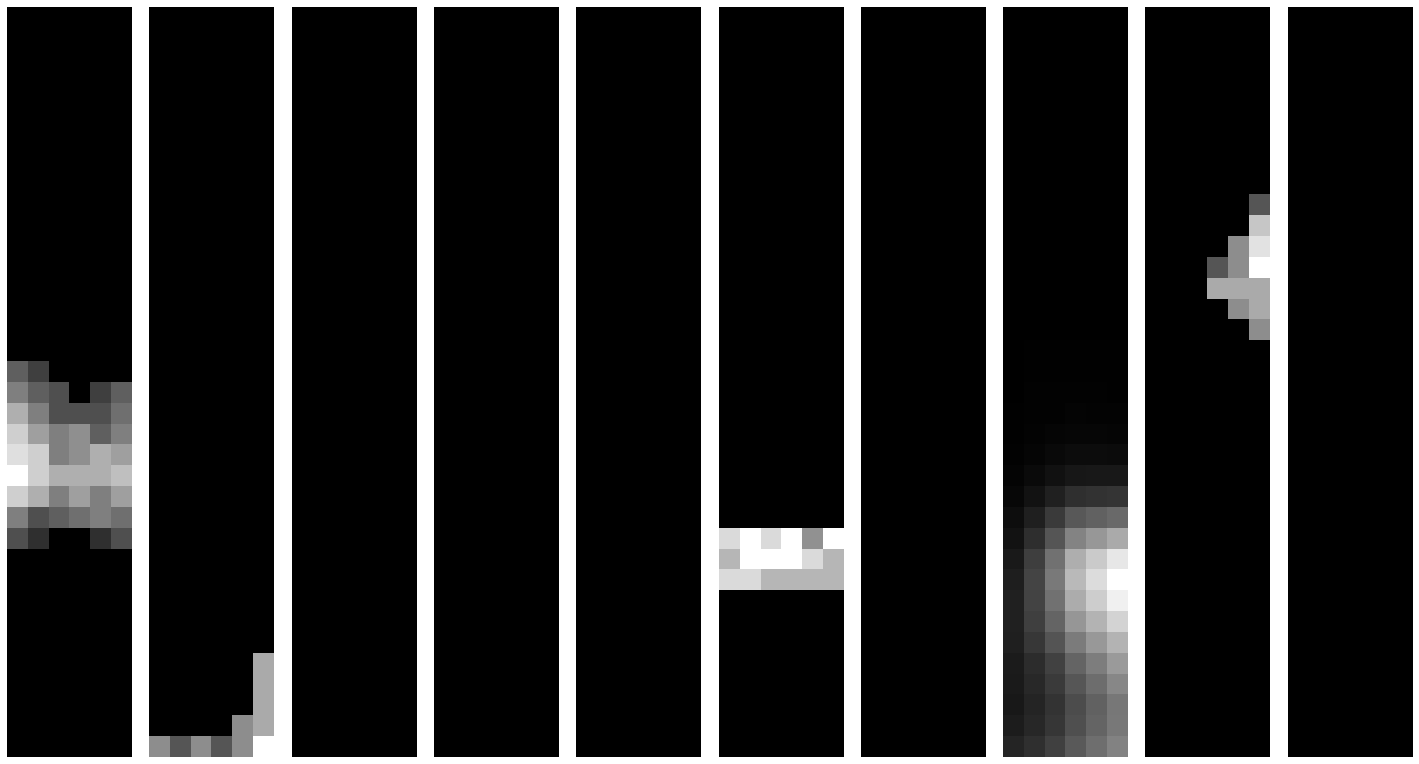

38/38 - 9s - loss: 1.4064 - d_loss: 0.6464 - g_loss: 0.7600 - 9s/epoch - 244ms/step
Epoch 73/200


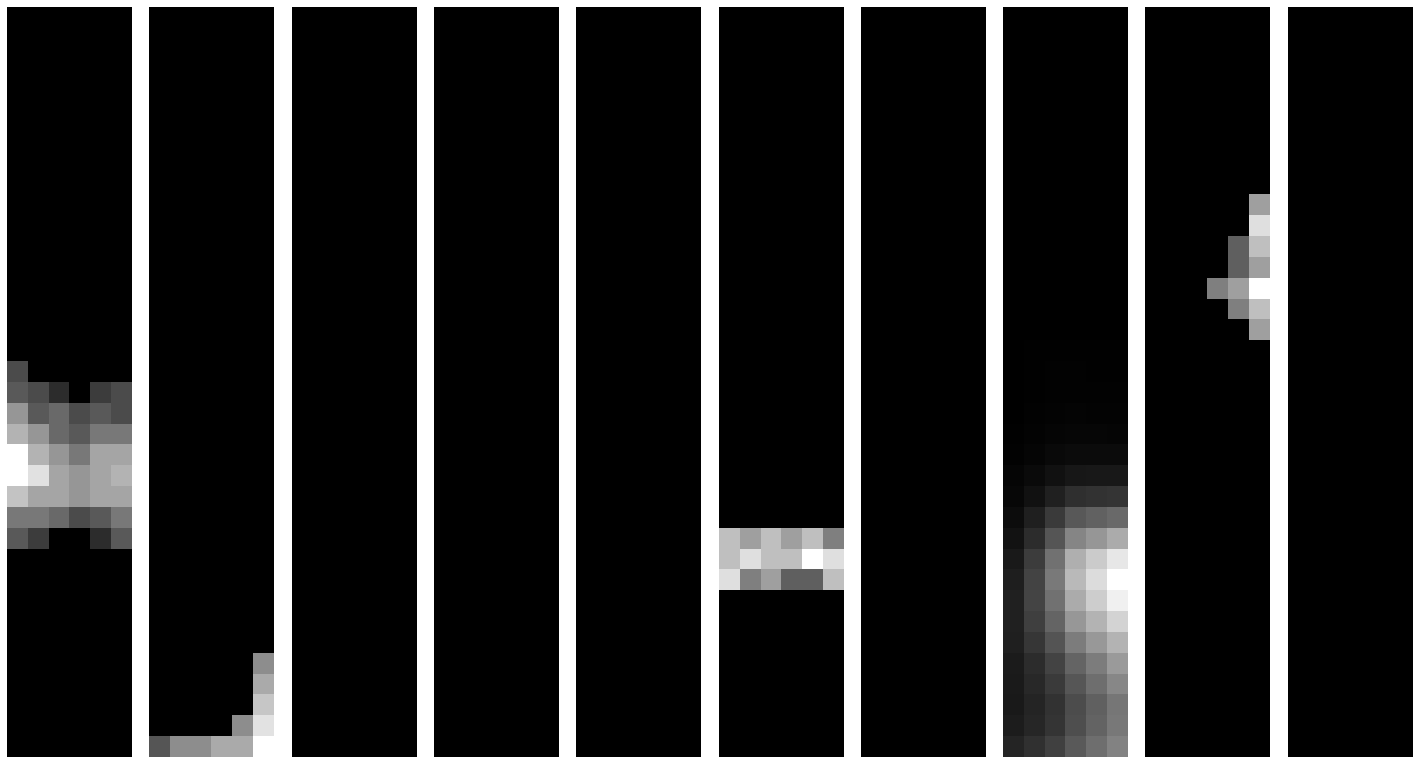

38/38 - 9s - loss: 1.4081 - d_loss: 0.6448 - g_loss: 0.7633 - 9s/epoch - 238ms/step
Epoch 74/200


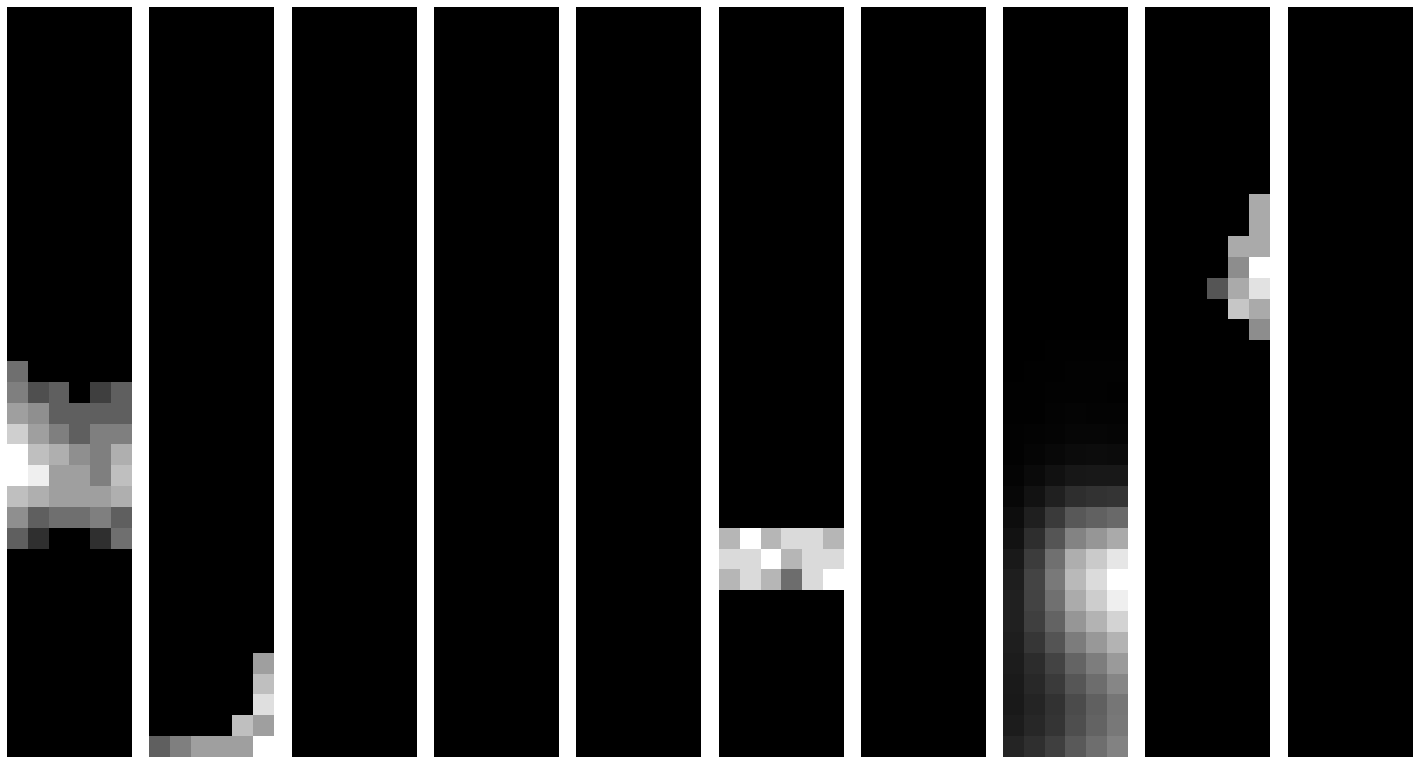

38/38 - 9s - loss: 1.4059 - d_loss: 0.6434 - g_loss: 0.7625 - 9s/epoch - 238ms/step
Epoch 75/200


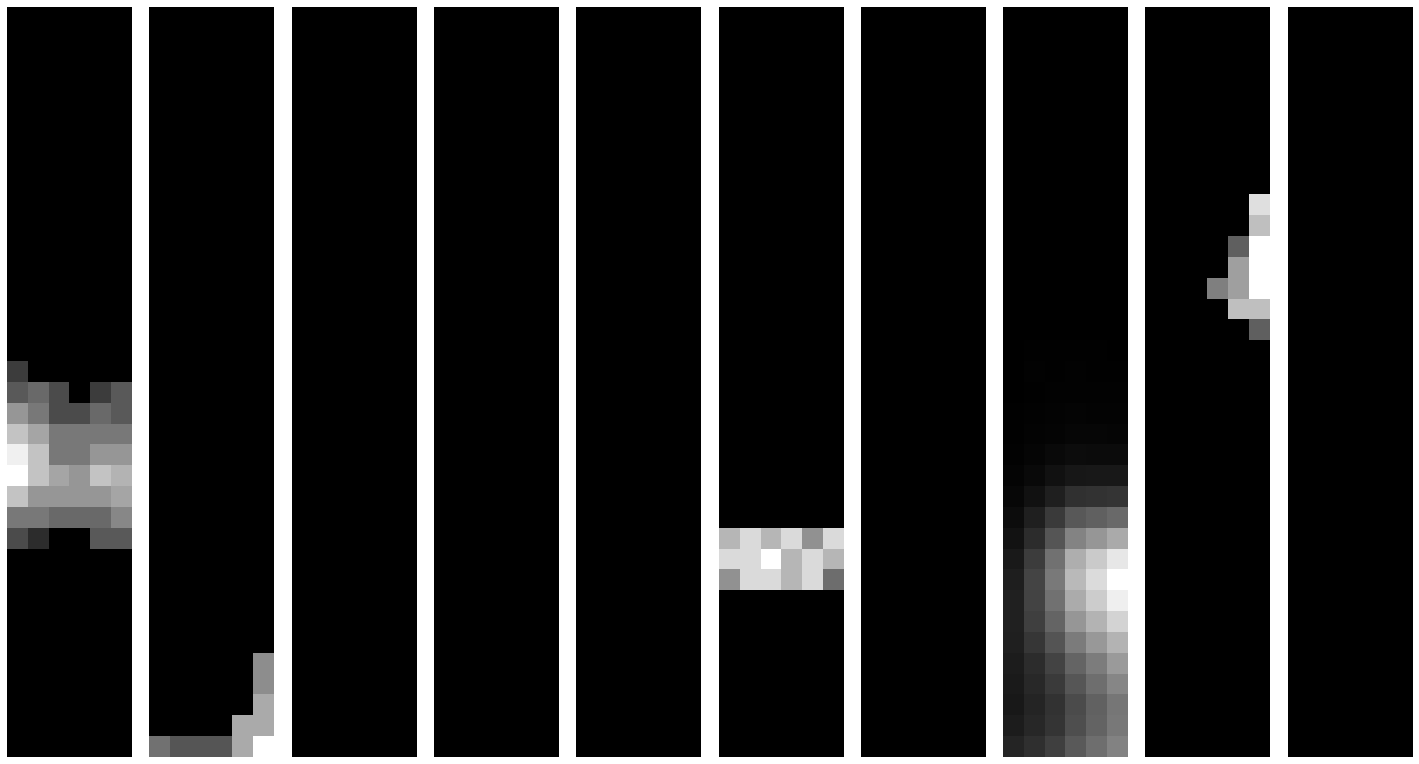

38/38 - 9s - loss: 1.4076 - d_loss: 0.6417 - g_loss: 0.7659 - 9s/epoch - 238ms/step
Epoch 76/200


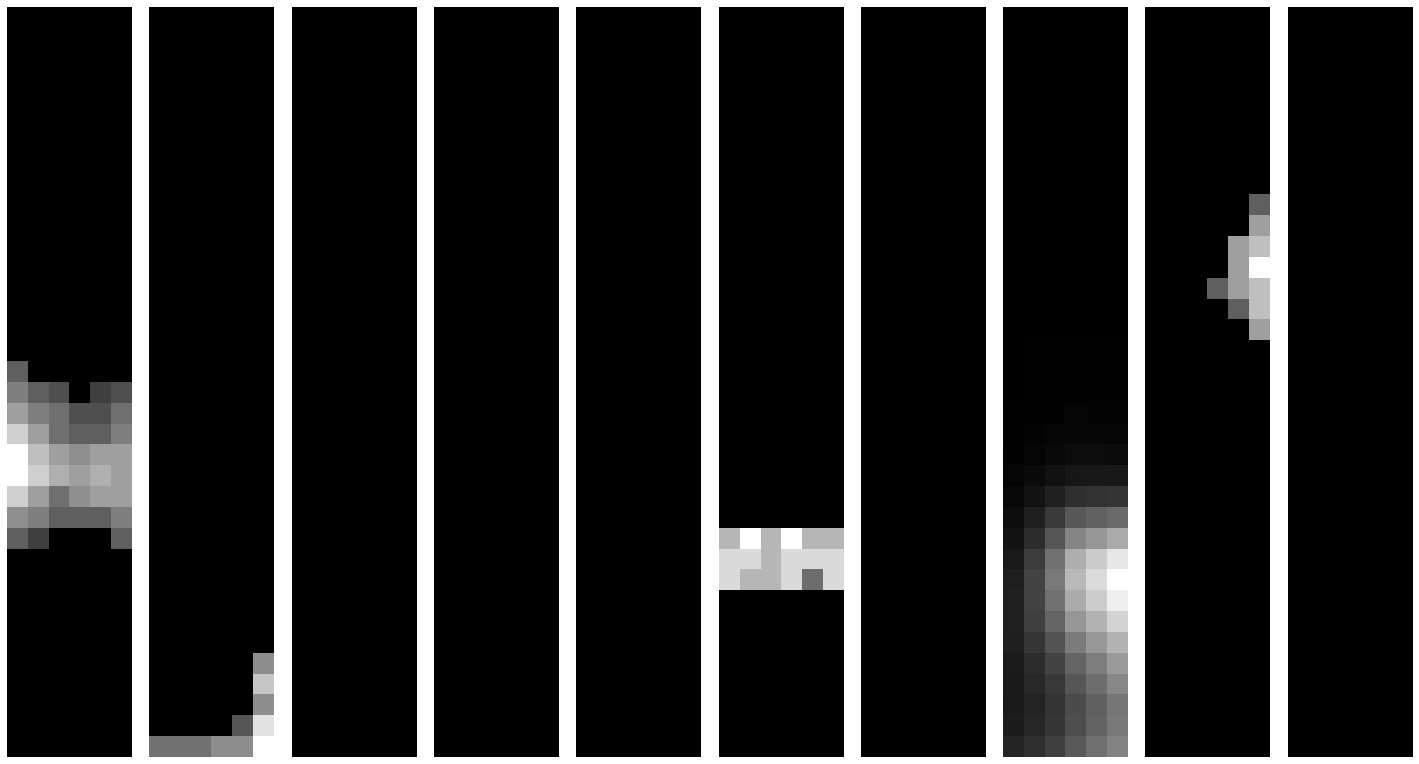

38/38 - 9s - loss: 1.4096 - d_loss: 0.6401 - g_loss: 0.7695 - 9s/epoch - 237ms/step
Epoch 77/200


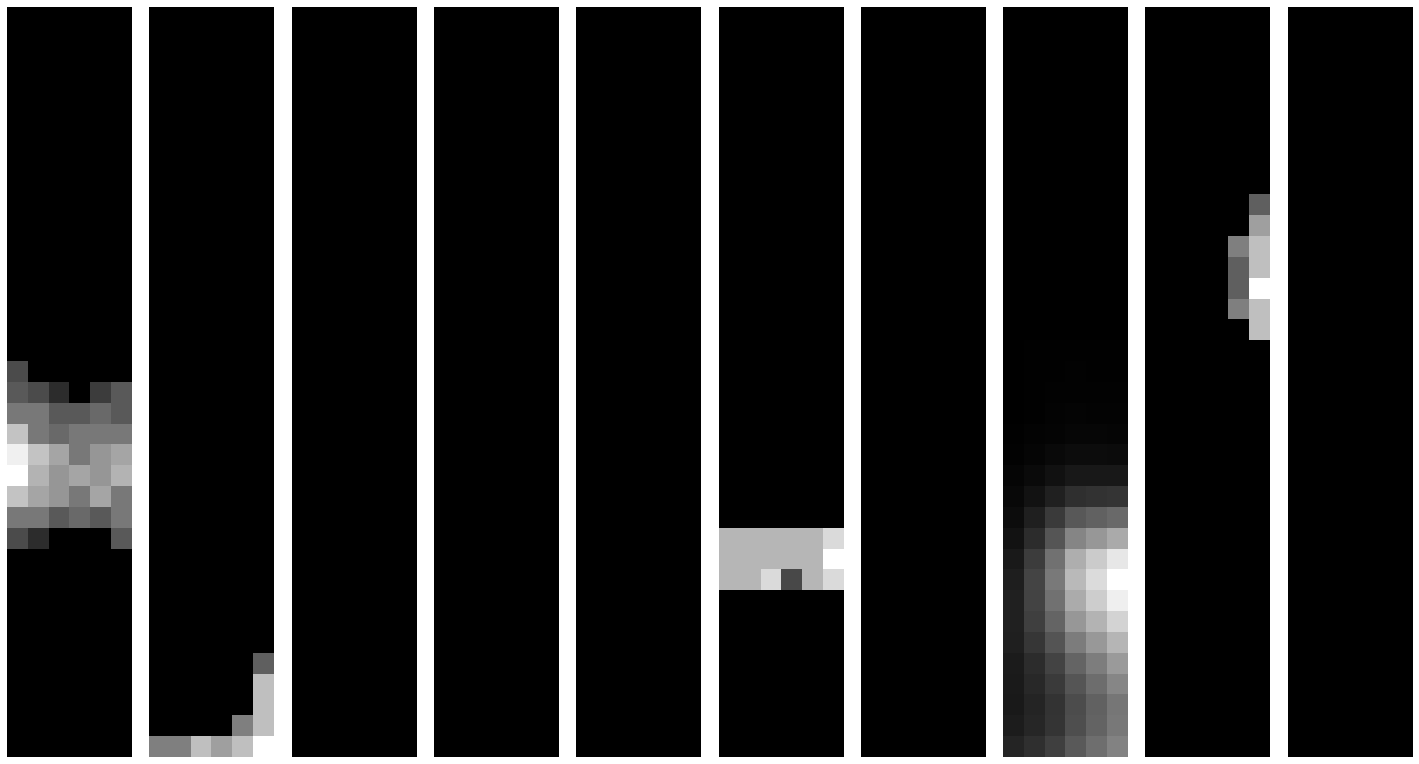

38/38 - 9s - loss: 1.4109 - d_loss: 0.6381 - g_loss: 0.7728 - 9s/epoch - 242ms/step
Epoch 78/200


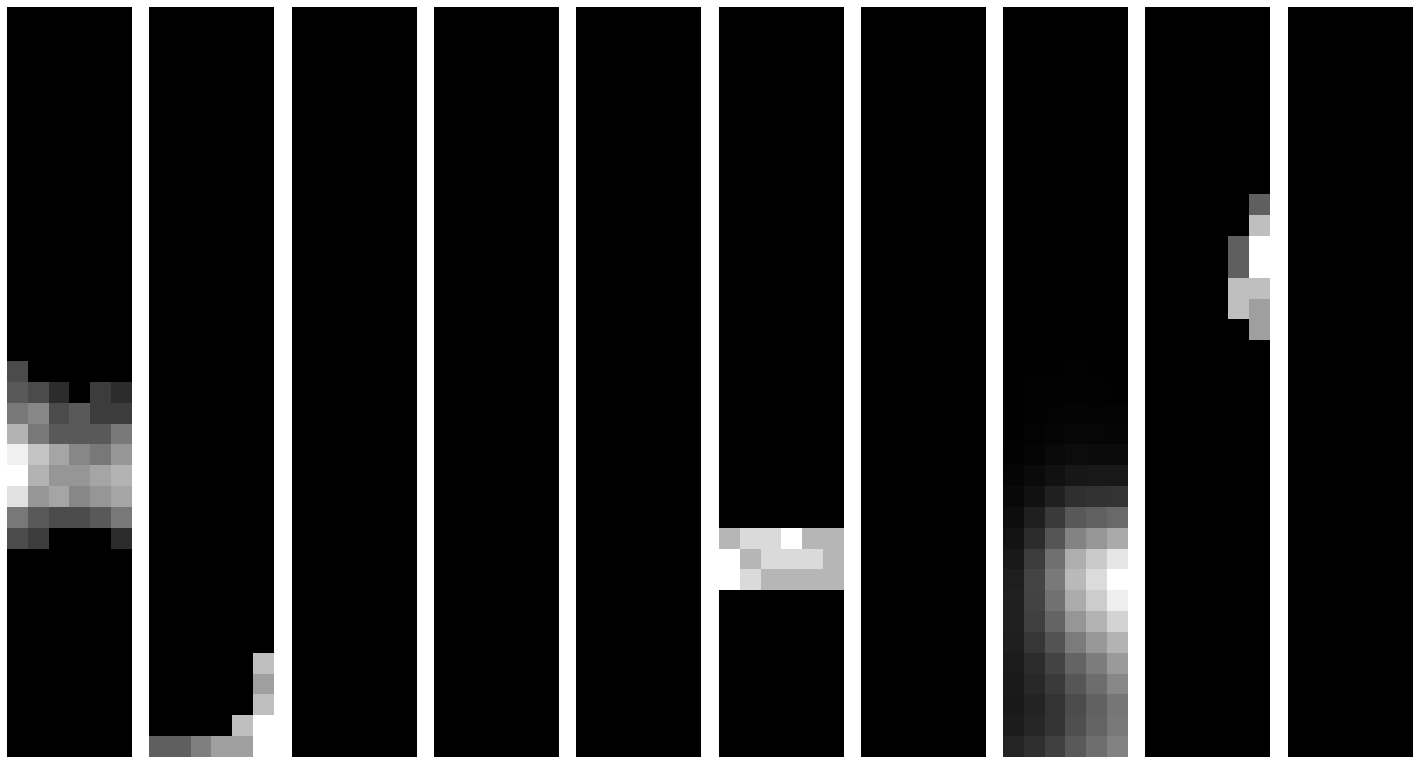

38/38 - 9s - loss: 1.4105 - d_loss: 0.6363 - g_loss: 0.7741 - 9s/epoch - 237ms/step
Epoch 79/200


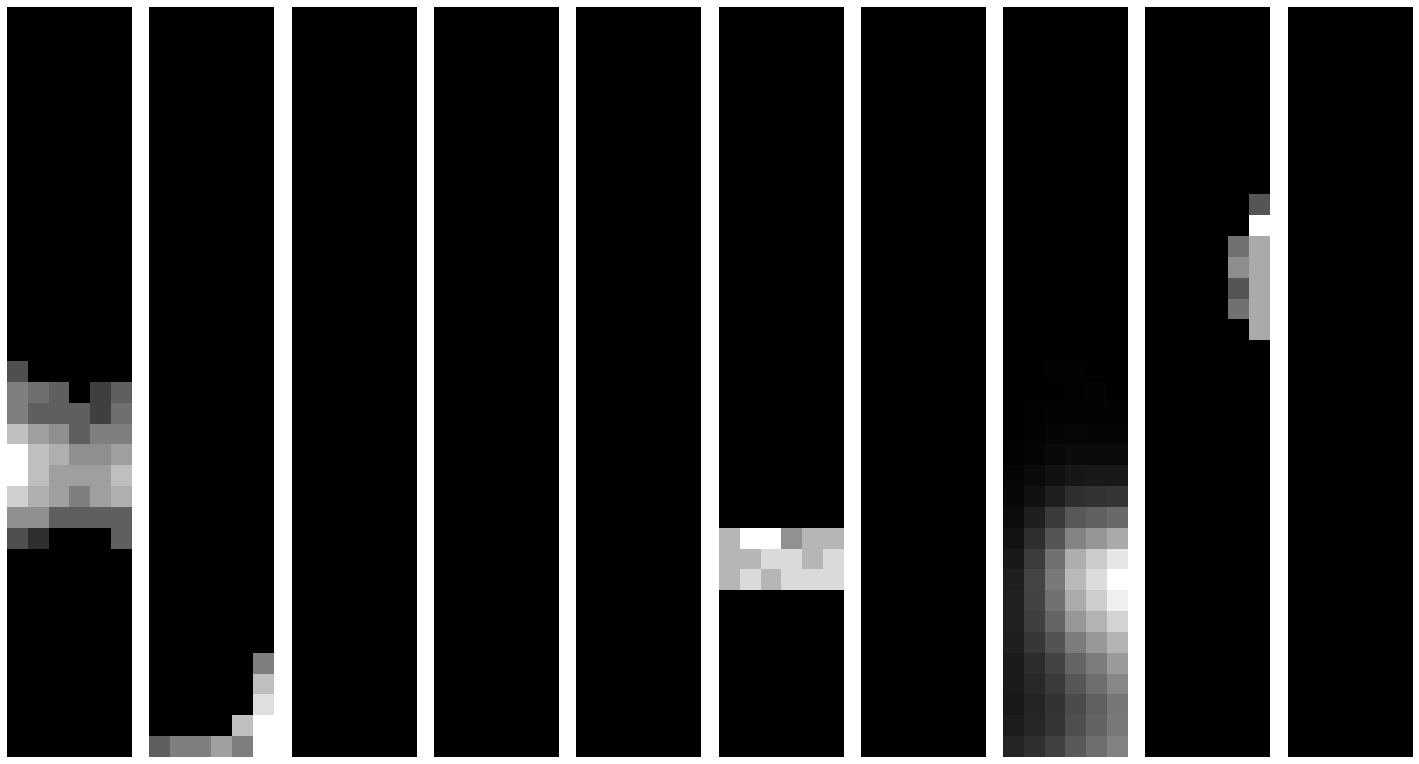

38/38 - 9s - loss: 1.4128 - d_loss: 0.6344 - g_loss: 0.7783 - 9s/epoch - 238ms/step
Epoch 80/200


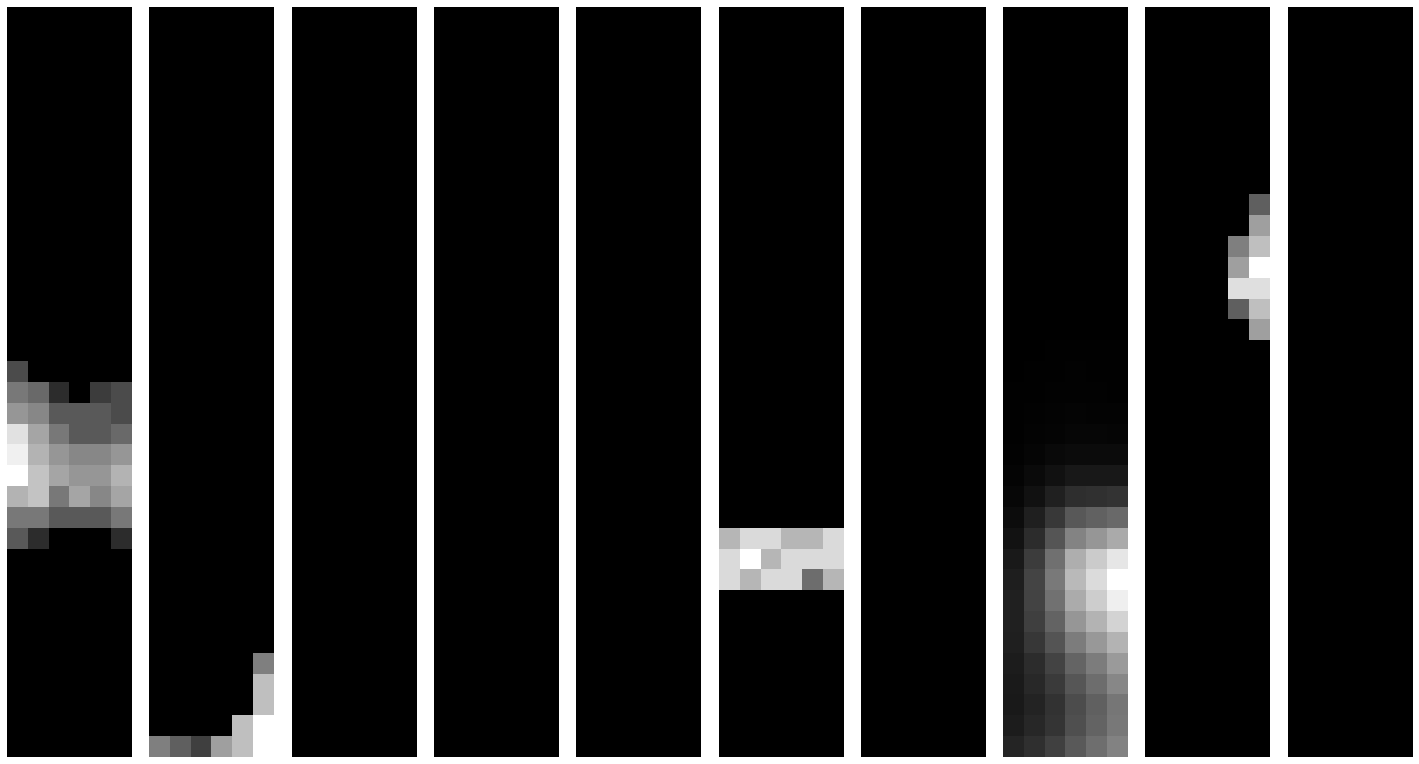

38/38 - 9s - loss: 1.4110 - d_loss: 0.6325 - g_loss: 0.7785 - 9s/epoch - 238ms/step
Epoch 81/200


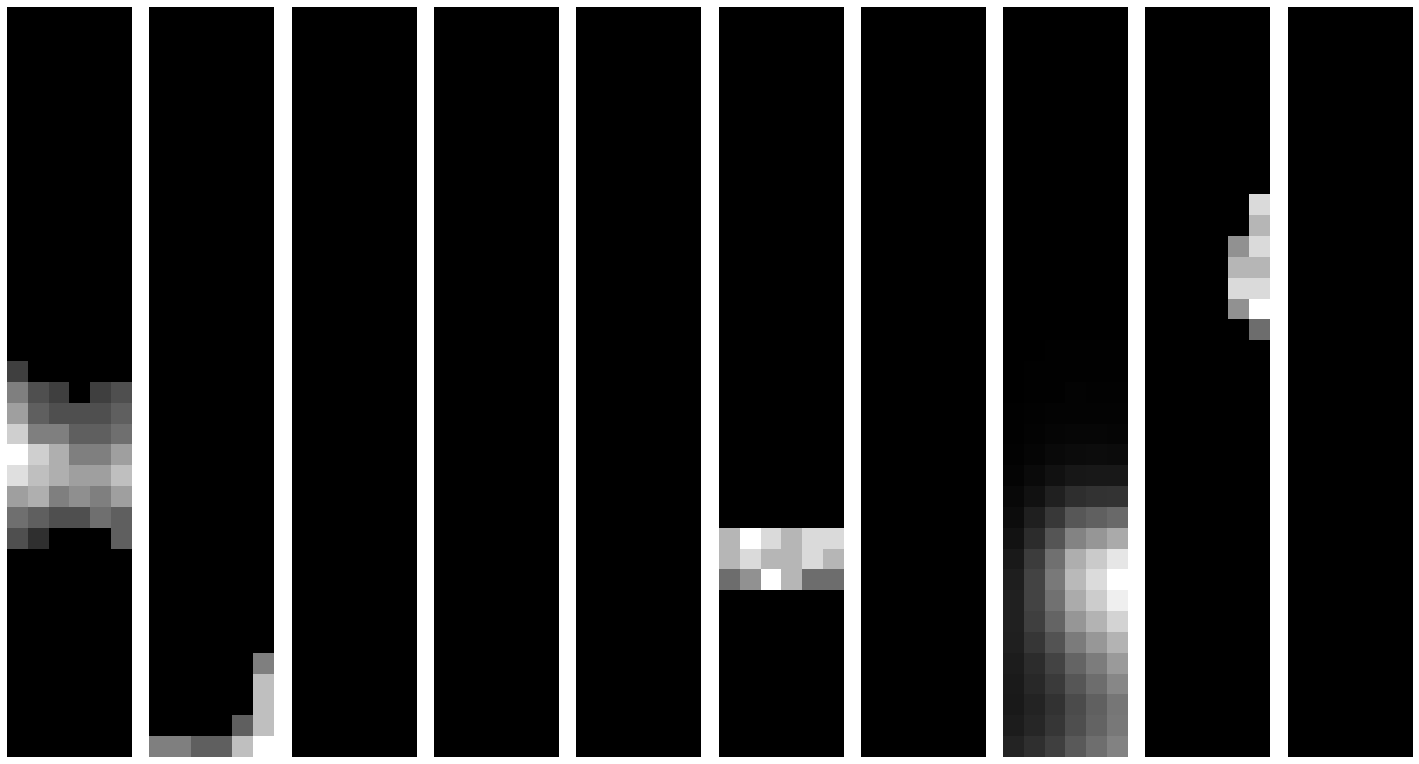

38/38 - 9s - loss: 1.4143 - d_loss: 0.6303 - g_loss: 0.7839 - 9s/epoch - 239ms/step
Epoch 82/200


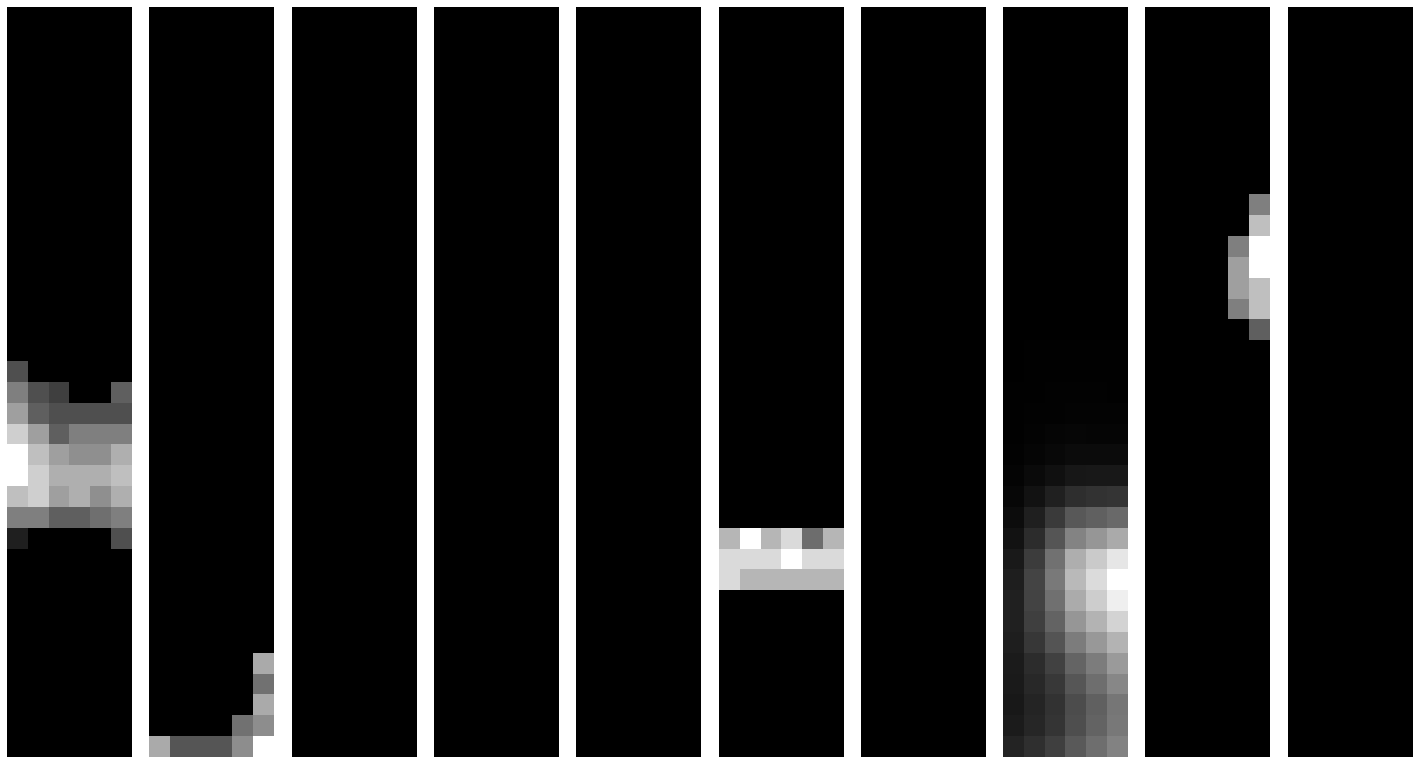

38/38 - 9s - loss: 1.4119 - d_loss: 0.6278 - g_loss: 0.7840 - 9s/epoch - 241ms/step
Epoch 83/200


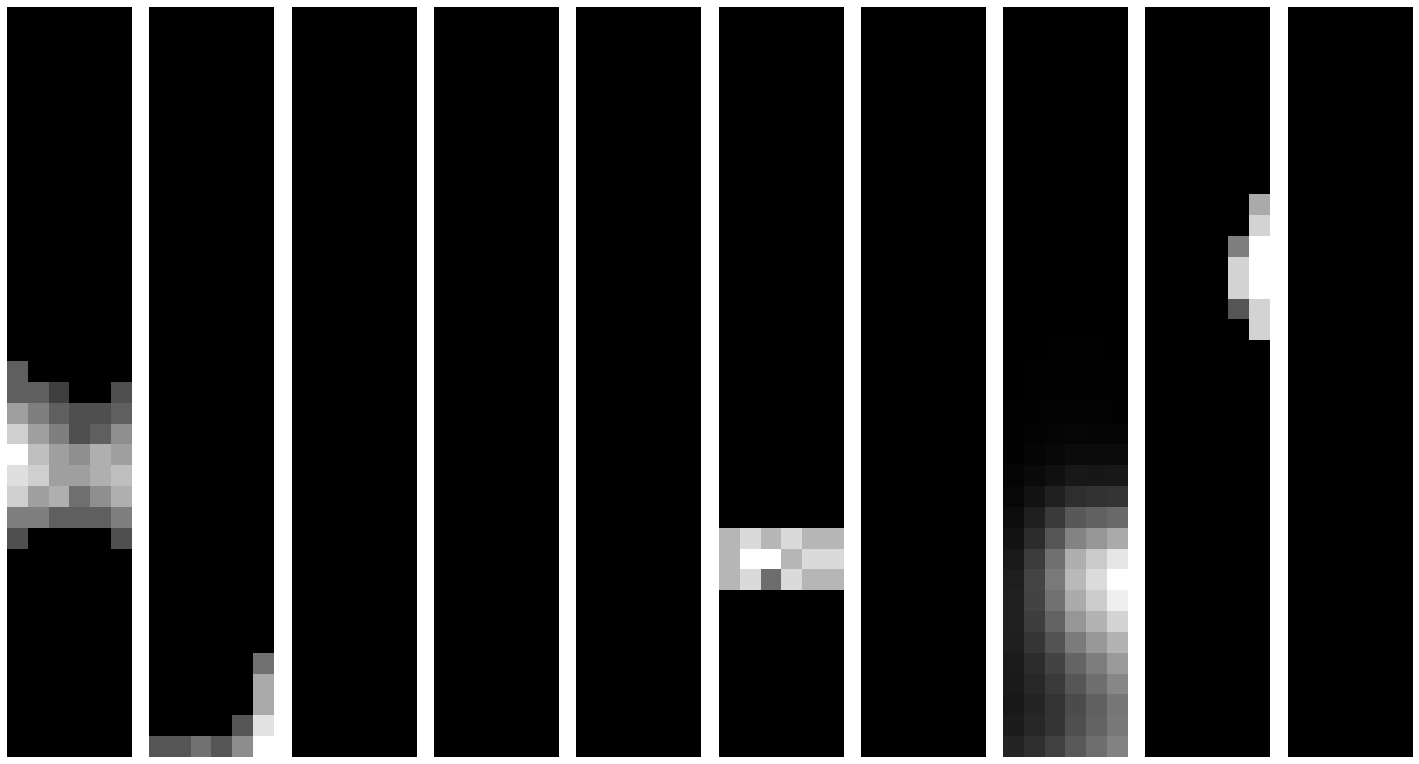

38/38 - 9s - loss: 1.4167 - d_loss: 0.6252 - g_loss: 0.7915 - 9s/epoch - 244ms/step
Epoch 84/200


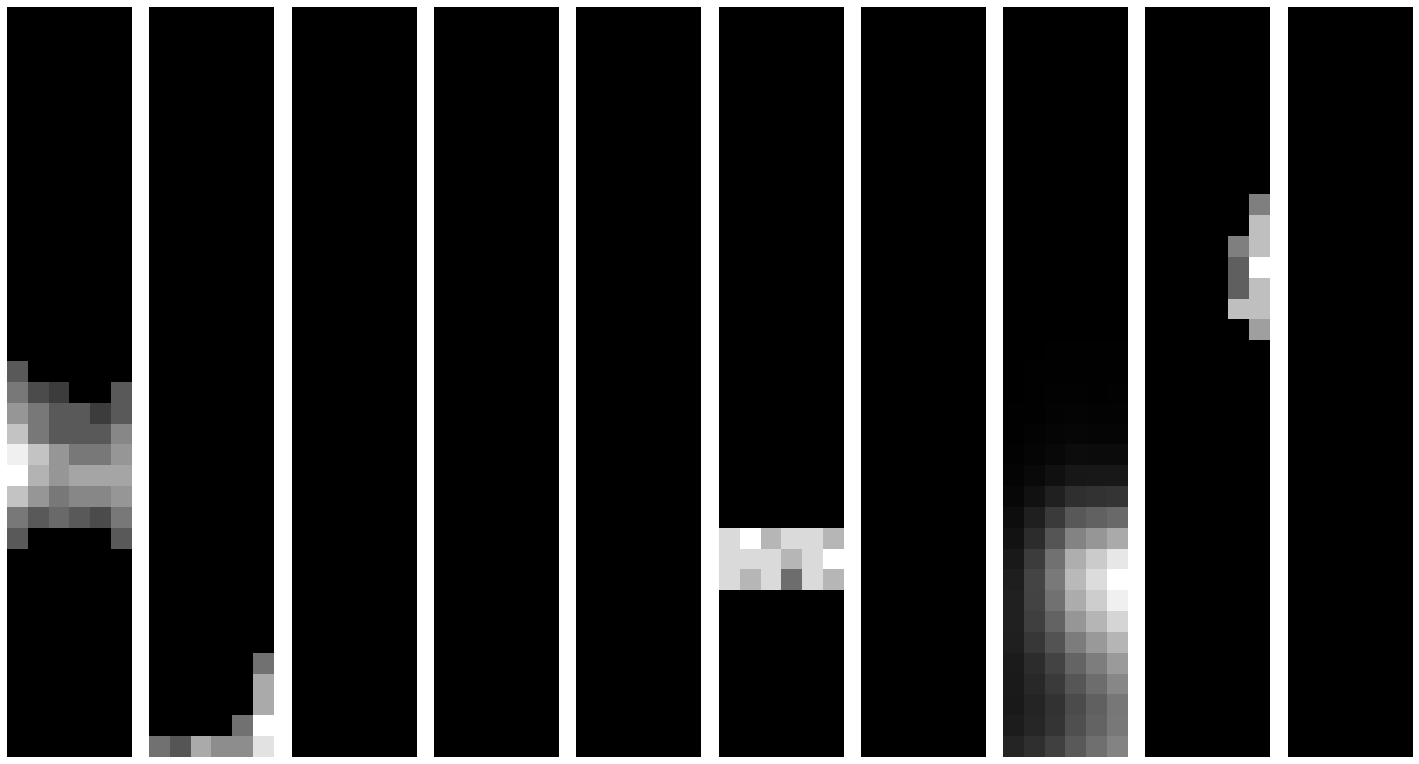

38/38 - 9s - loss: 1.4171 - d_loss: 0.6227 - g_loss: 0.7944 - 9s/epoch - 238ms/step
Epoch 85/200


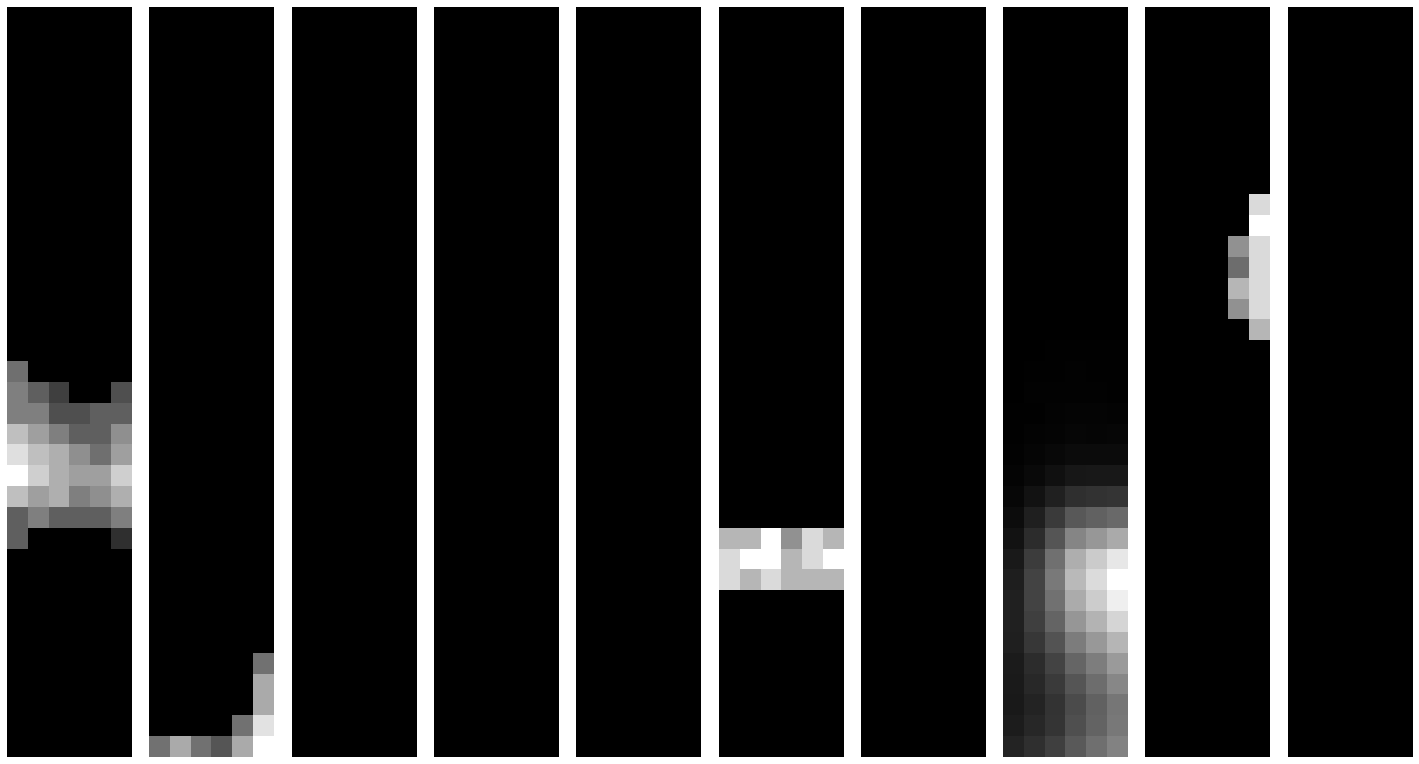

38/38 - 9s - loss: 1.4174 - d_loss: 0.6207 - g_loss: 0.7967 - 9s/epoch - 238ms/step
Epoch 86/200


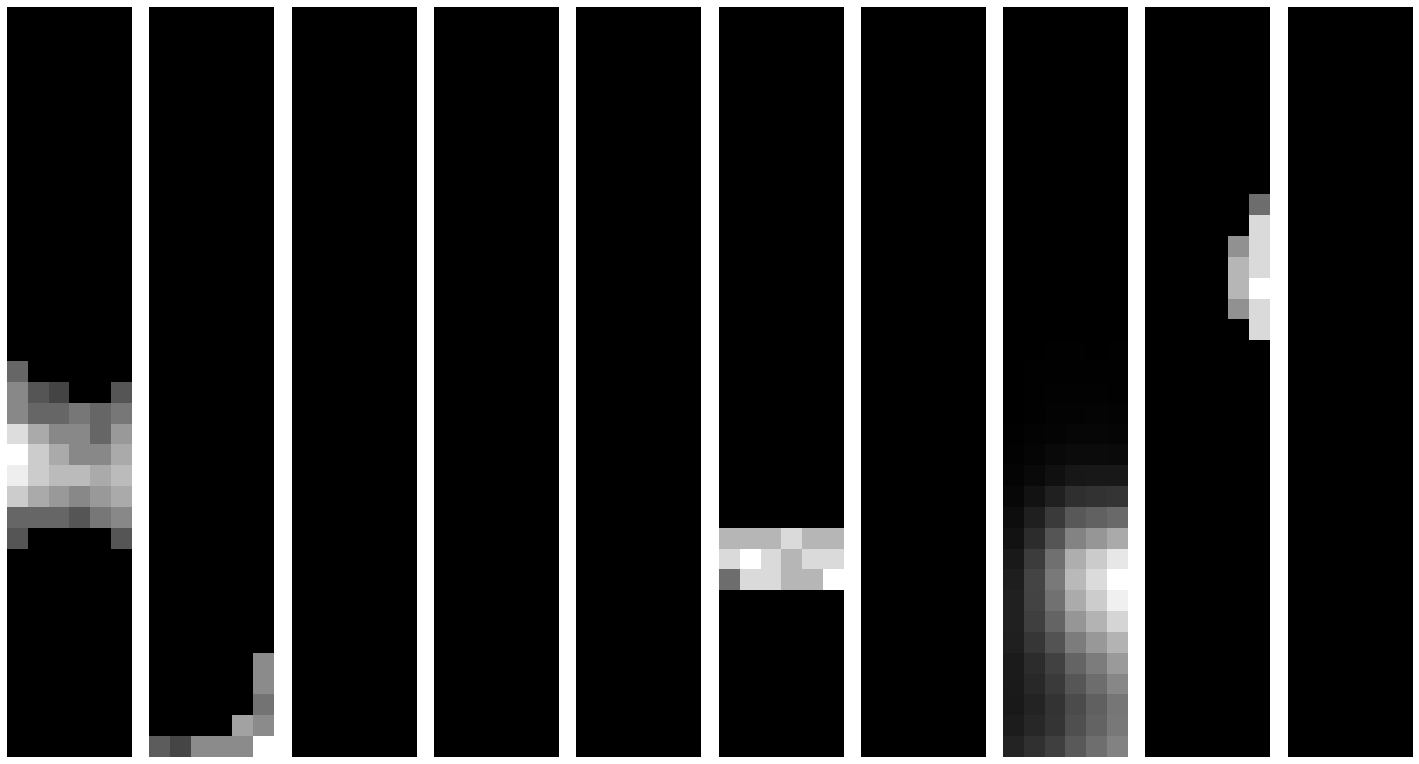

38/38 - 9s - loss: 1.4216 - d_loss: 0.6173 - g_loss: 0.8043 - 9s/epoch - 237ms/step
Epoch 87/200


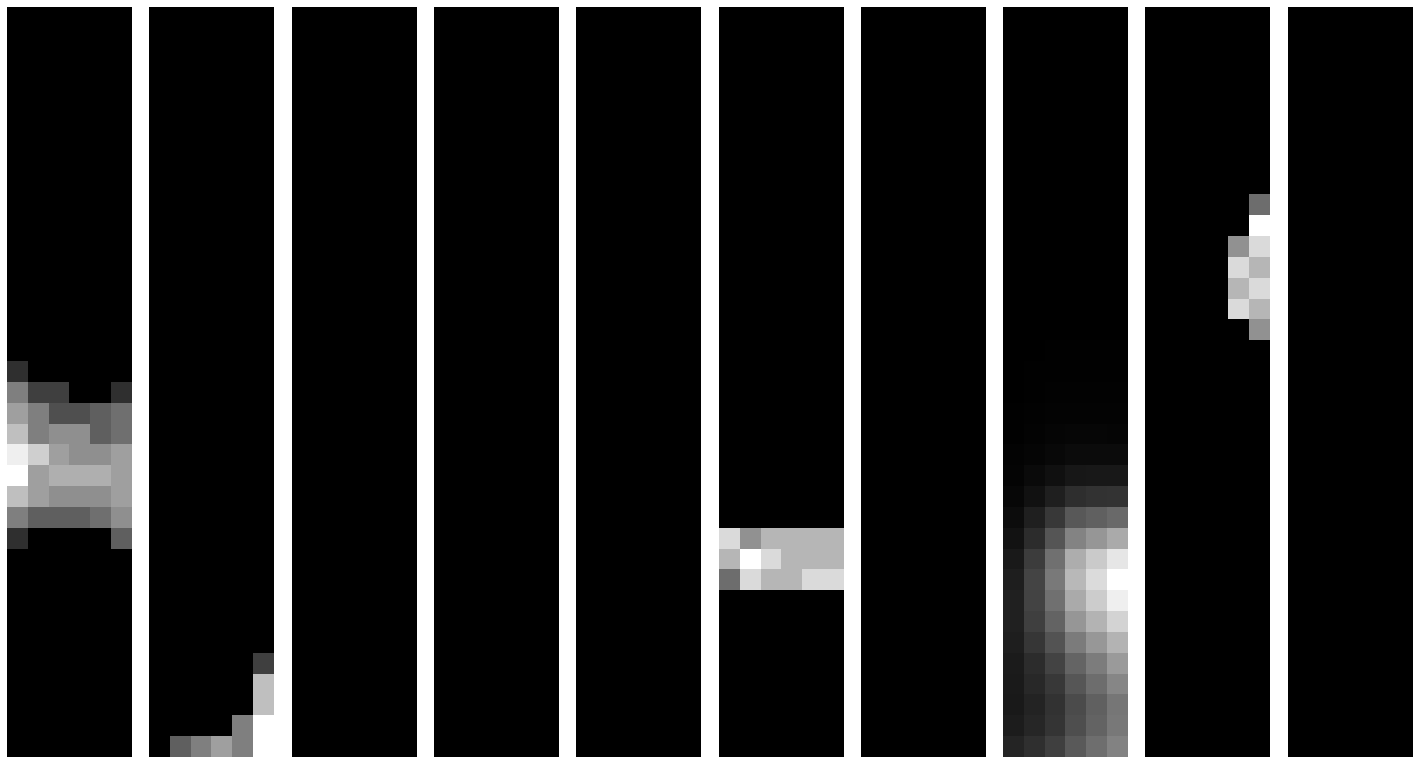

38/38 - 9s - loss: 1.4226 - d_loss: 0.6143 - g_loss: 0.8083 - 9s/epoch - 238ms/step
Epoch 88/200


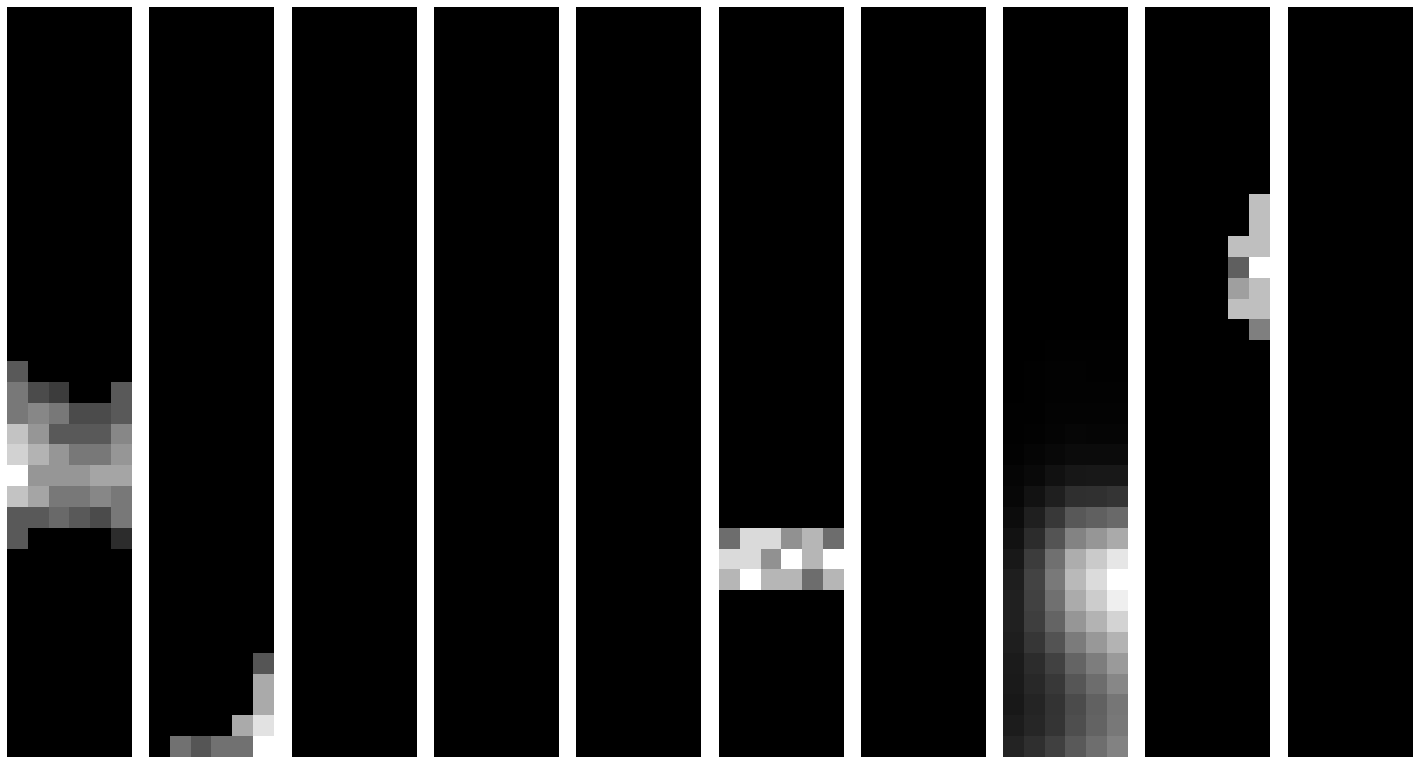

38/38 - 9s - loss: 1.4244 - d_loss: 0.6105 - g_loss: 0.8139 - 9s/epoch - 237ms/step
Epoch 89/200


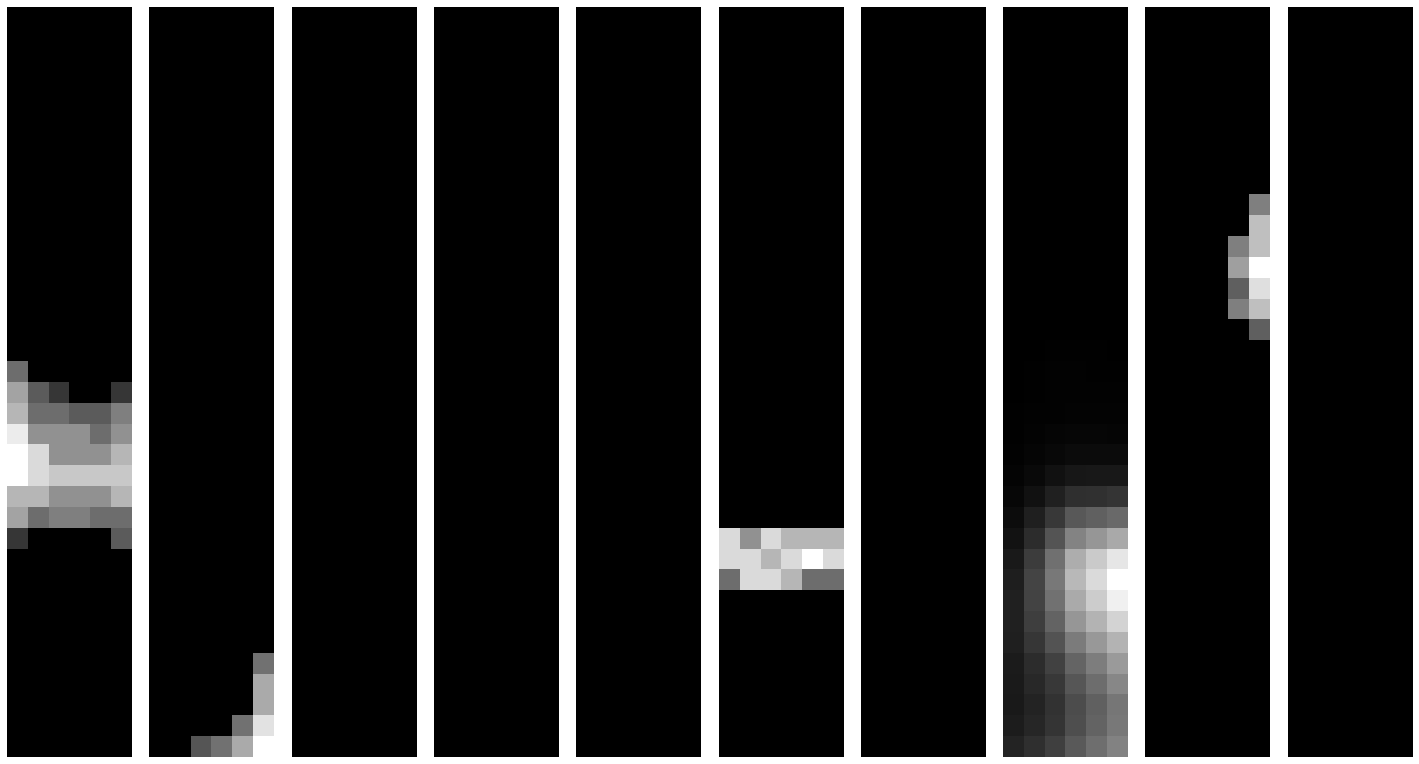

38/38 - 9s - loss: 1.4267 - d_loss: 0.6064 - g_loss: 0.8203 - 9s/epoch - 244ms/step
Epoch 90/200


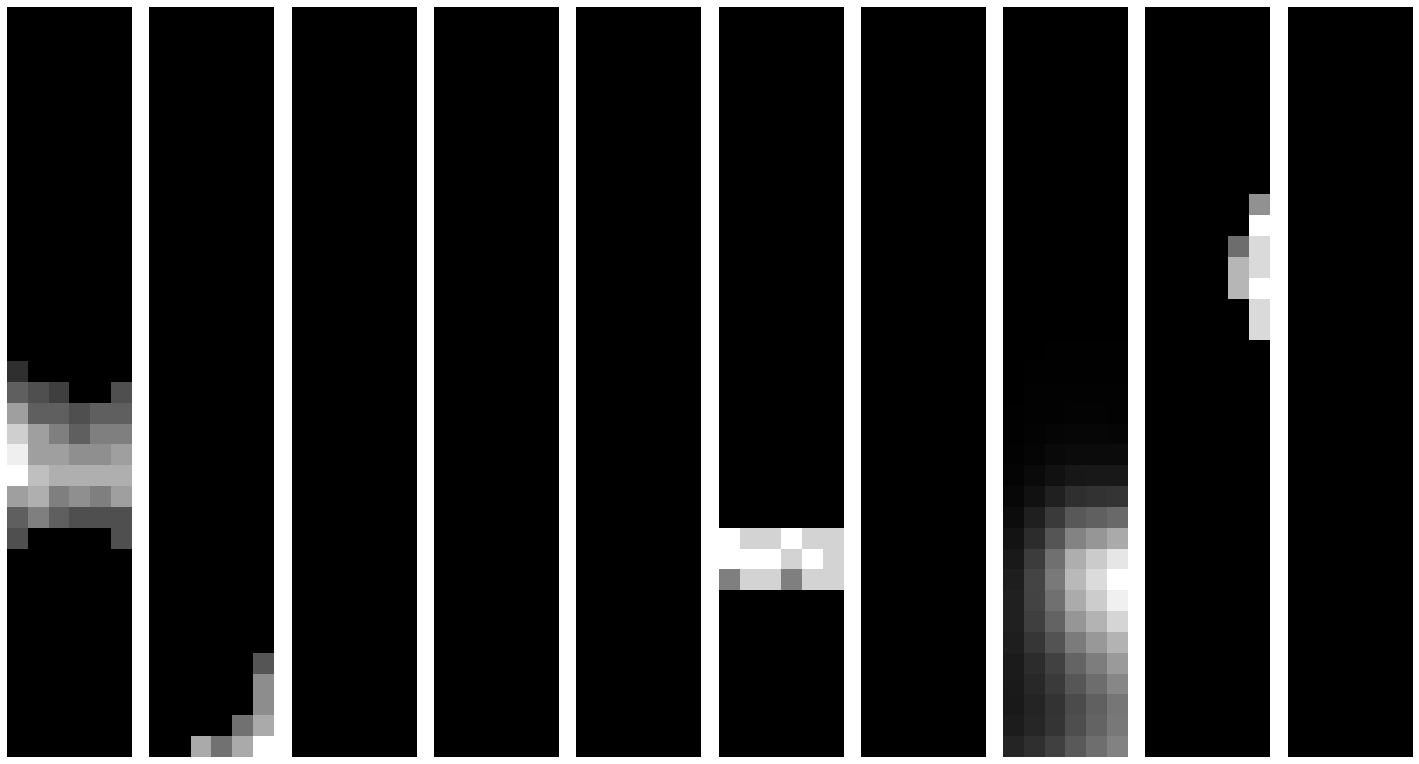

38/38 - 9s - loss: 1.4311 - d_loss: 0.6021 - g_loss: 0.8290 - 9s/epoch - 239ms/step
Epoch 91/200


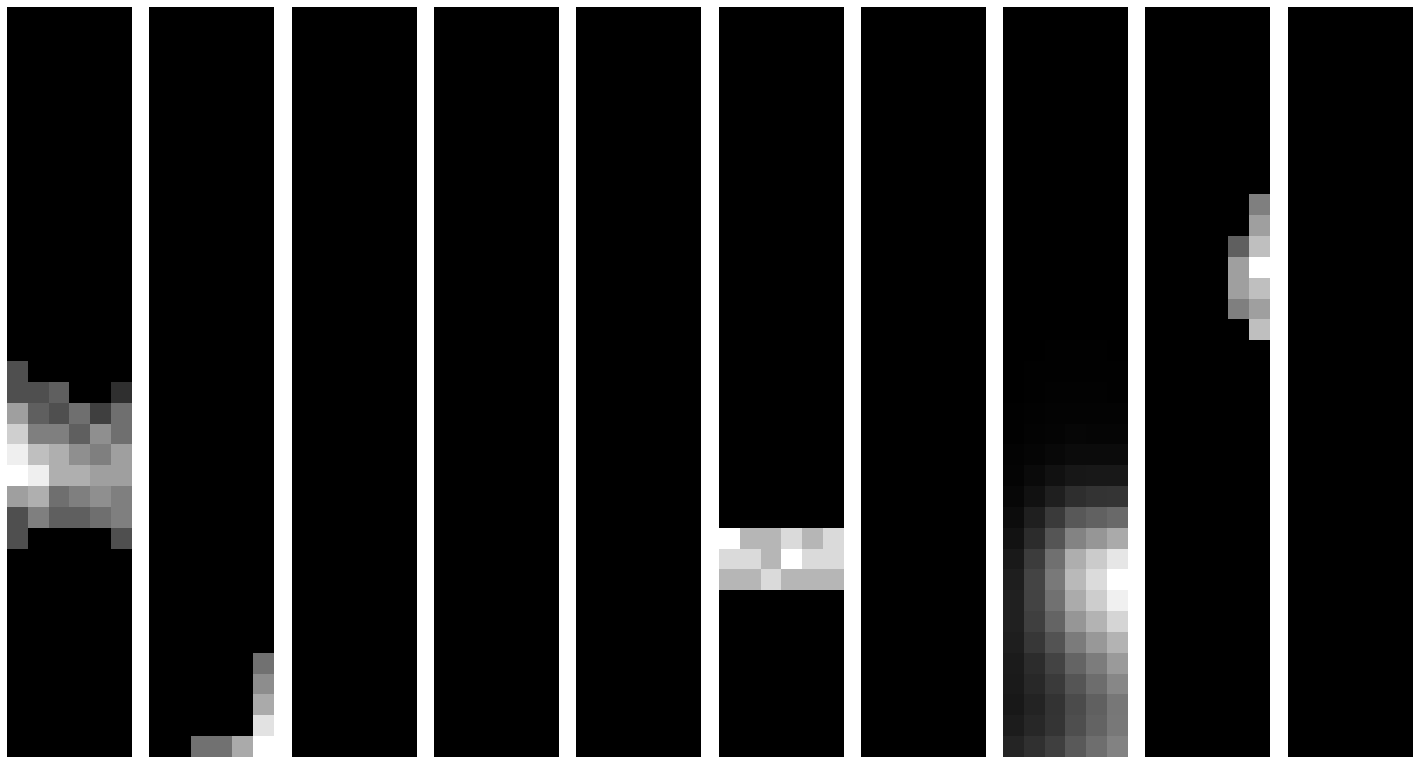

38/38 - 9s - loss: 1.4373 - d_loss: 0.5954 - g_loss: 0.8418 - 9s/epoch - 237ms/step
Epoch 92/200


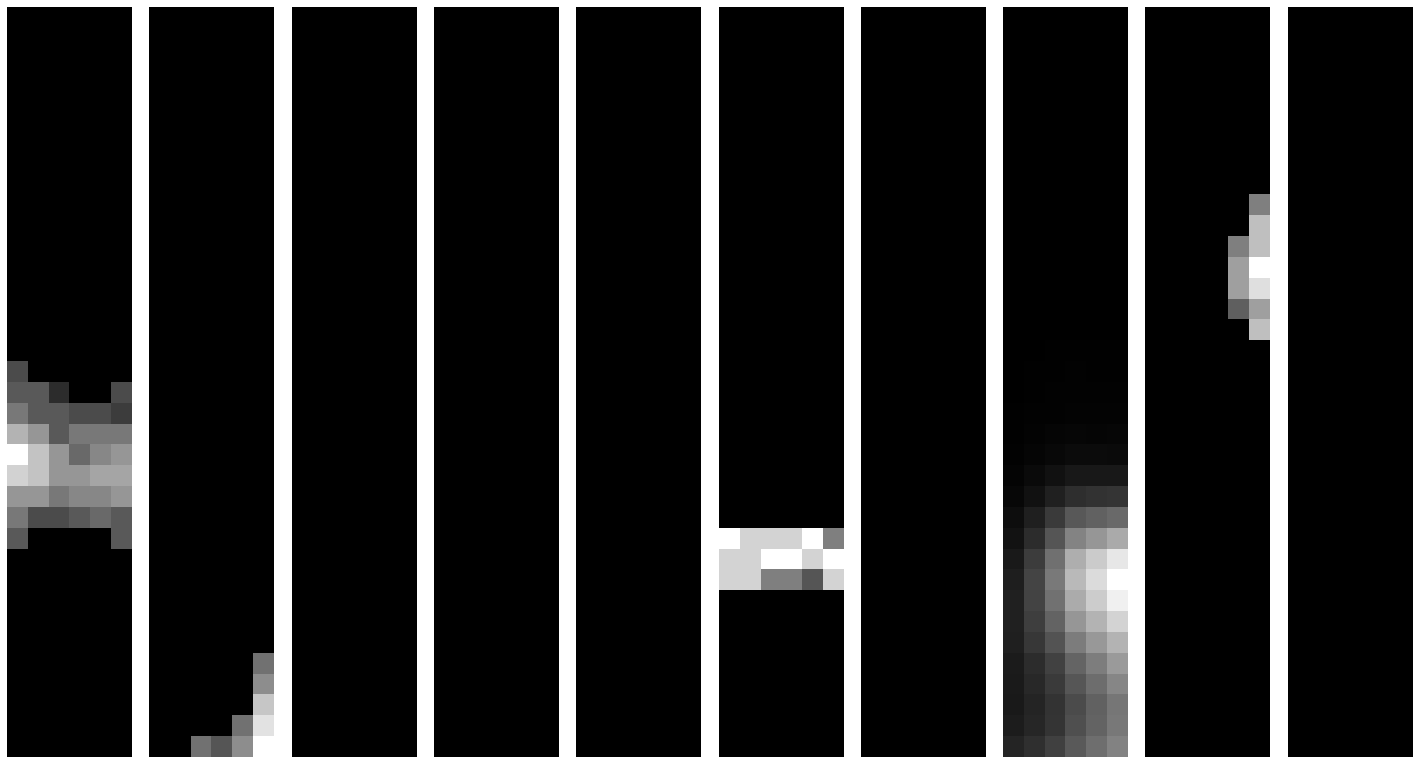

38/38 - 9s - loss: 1.4396 - d_loss: 0.5893 - g_loss: 0.8502 - 9s/epoch - 238ms/step
Epoch 93/200


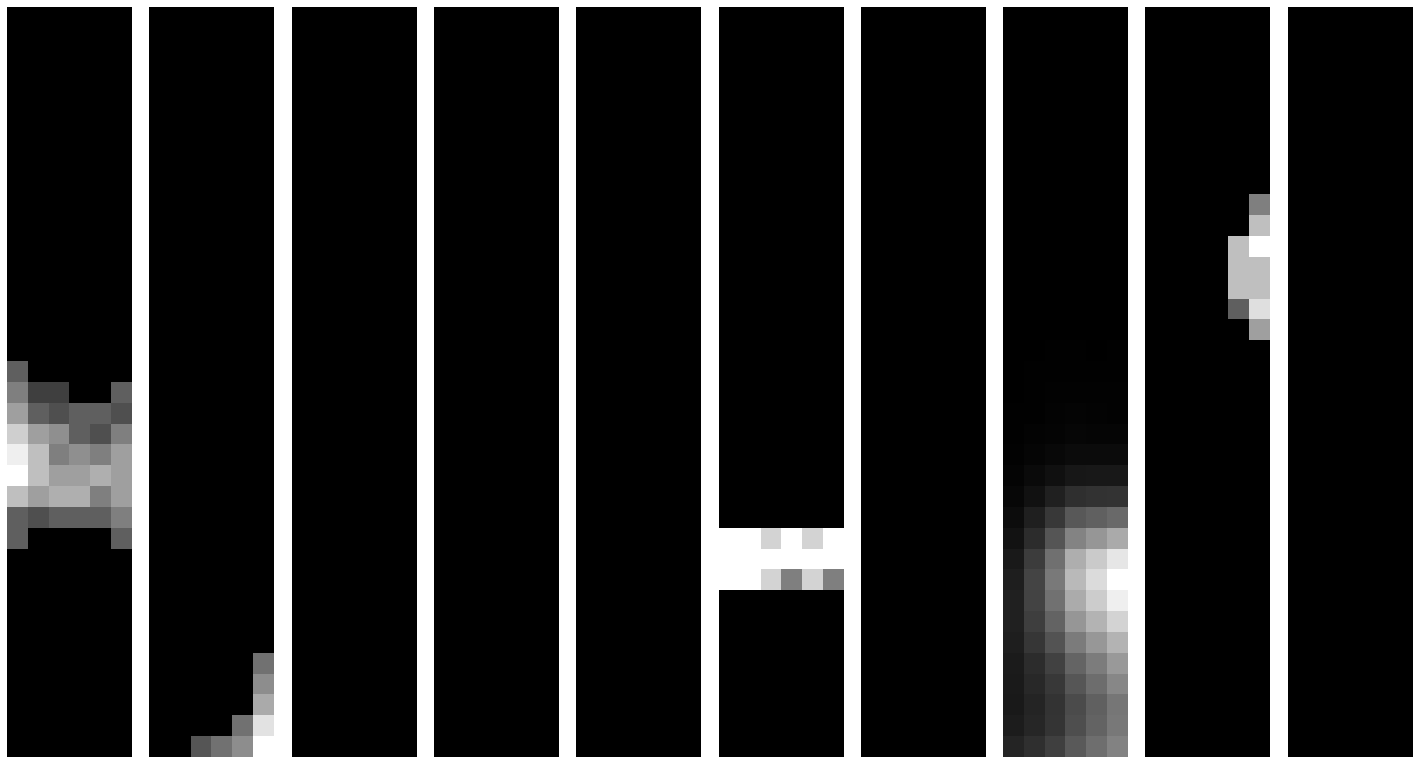

38/38 - 9s - loss: 1.4470 - d_loss: 0.5812 - g_loss: 0.8657 - 9s/epoch - 239ms/step
Epoch 94/200


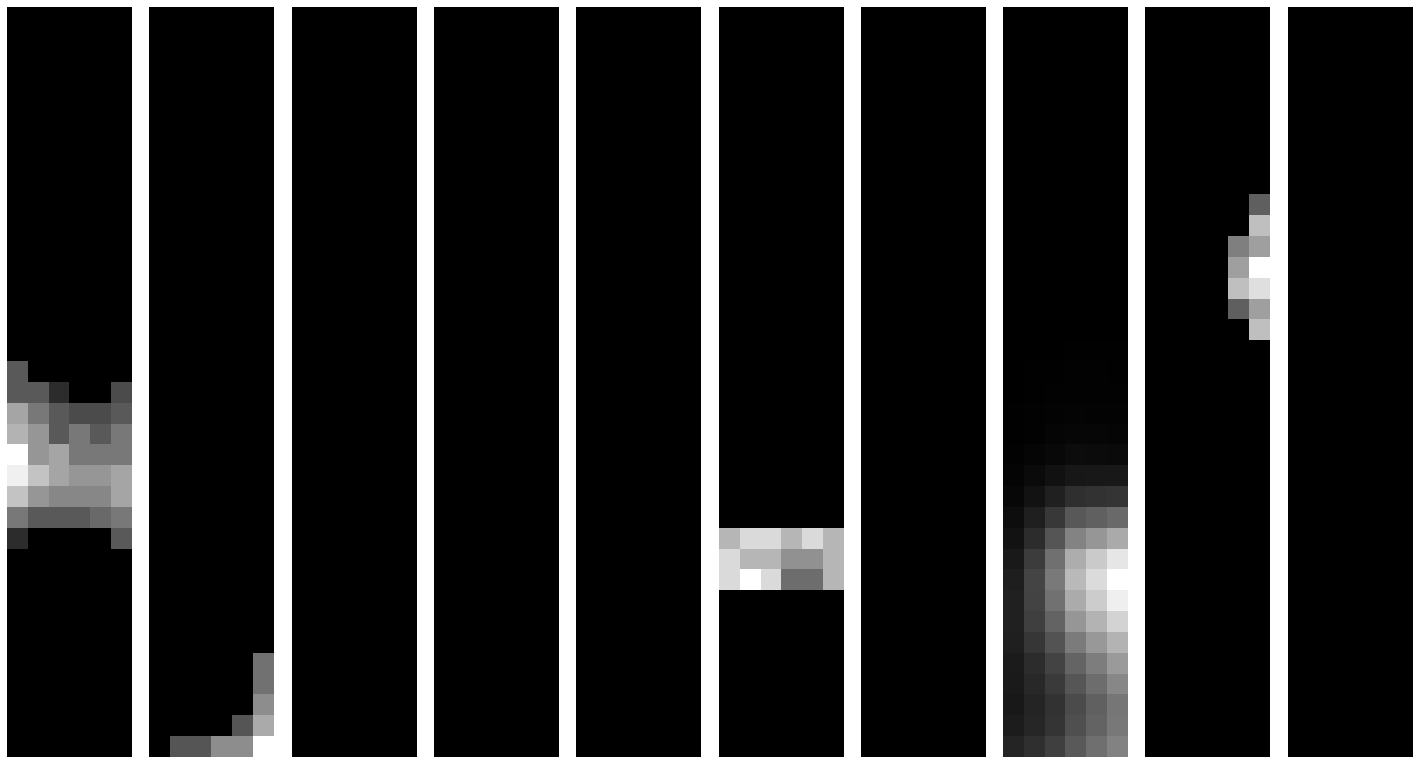

38/38 - 9s - loss: 1.4564 - d_loss: 0.5749 - g_loss: 0.8815 - 9s/epoch - 243ms/step
Epoch 95/200


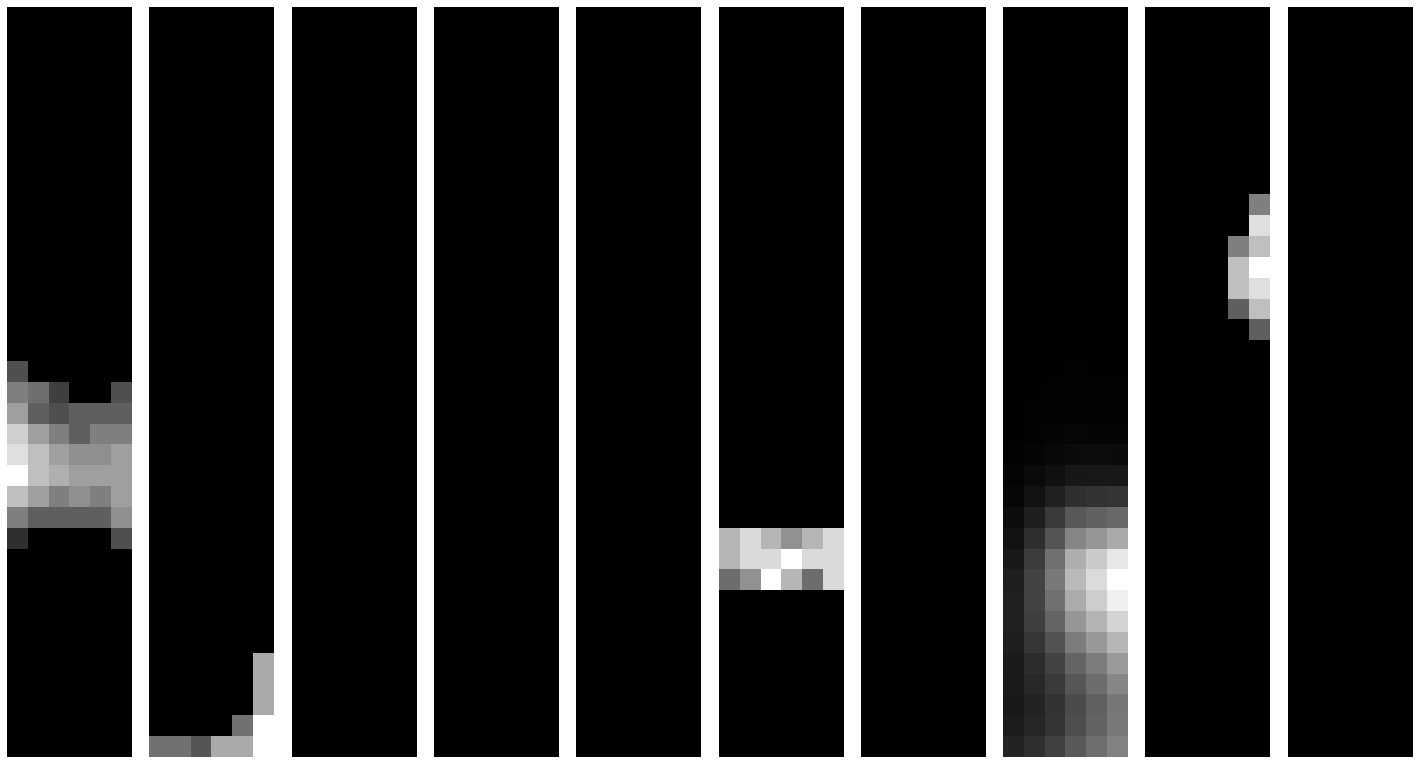

38/38 - 9s - loss: 1.4578 - d_loss: 0.5691 - g_loss: 0.8887 - 9s/epoch - 239ms/step
Epoch 96/200


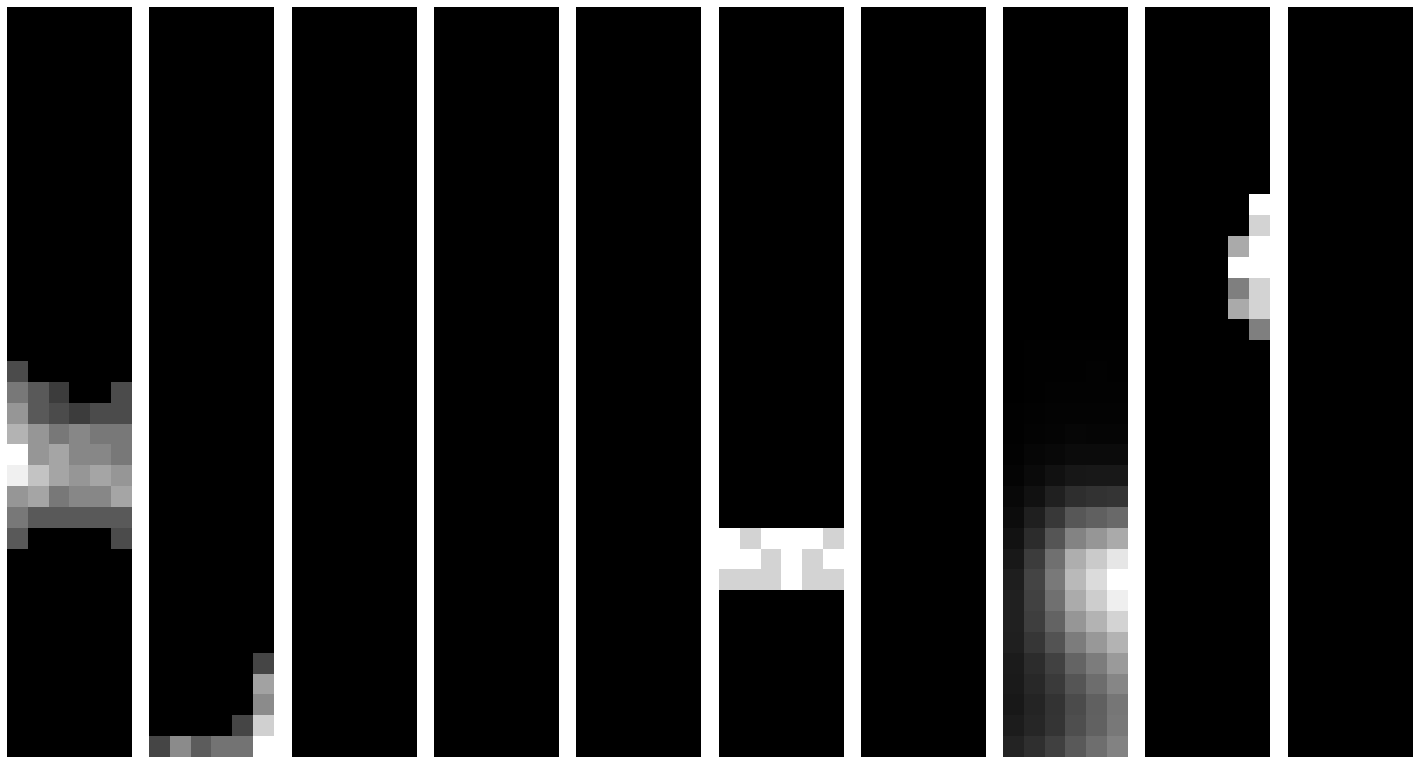

38/38 - 9s - loss: 1.4650 - d_loss: 0.5642 - g_loss: 0.9008 - 9s/epoch - 238ms/step
Epoch 97/200


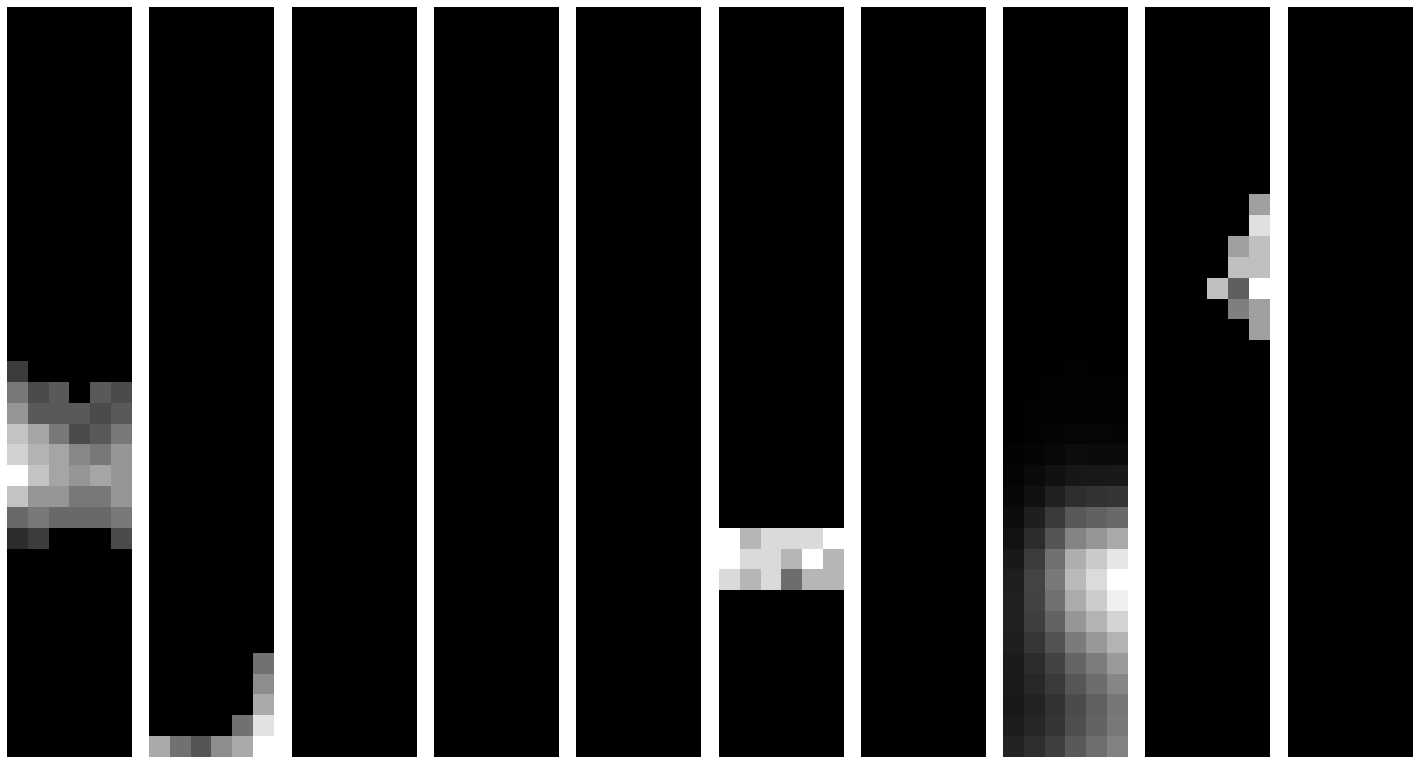

38/38 - 9s - loss: 1.4674 - d_loss: 0.5577 - g_loss: 0.9097 - 9s/epoch - 238ms/step
Epoch 98/200


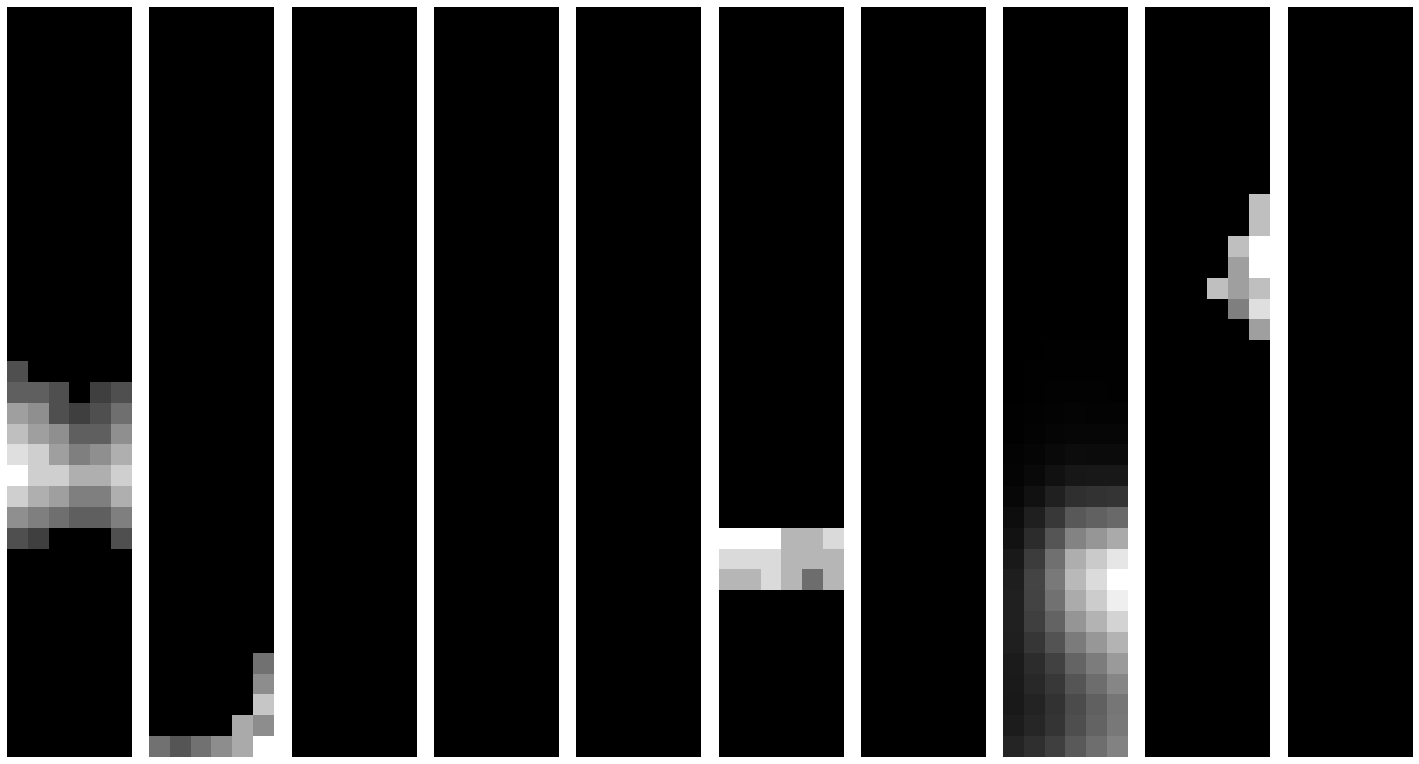

38/38 - 9s - loss: 1.4725 - d_loss: 0.5530 - g_loss: 0.9195 - 9s/epoch - 237ms/step
Epoch 99/200


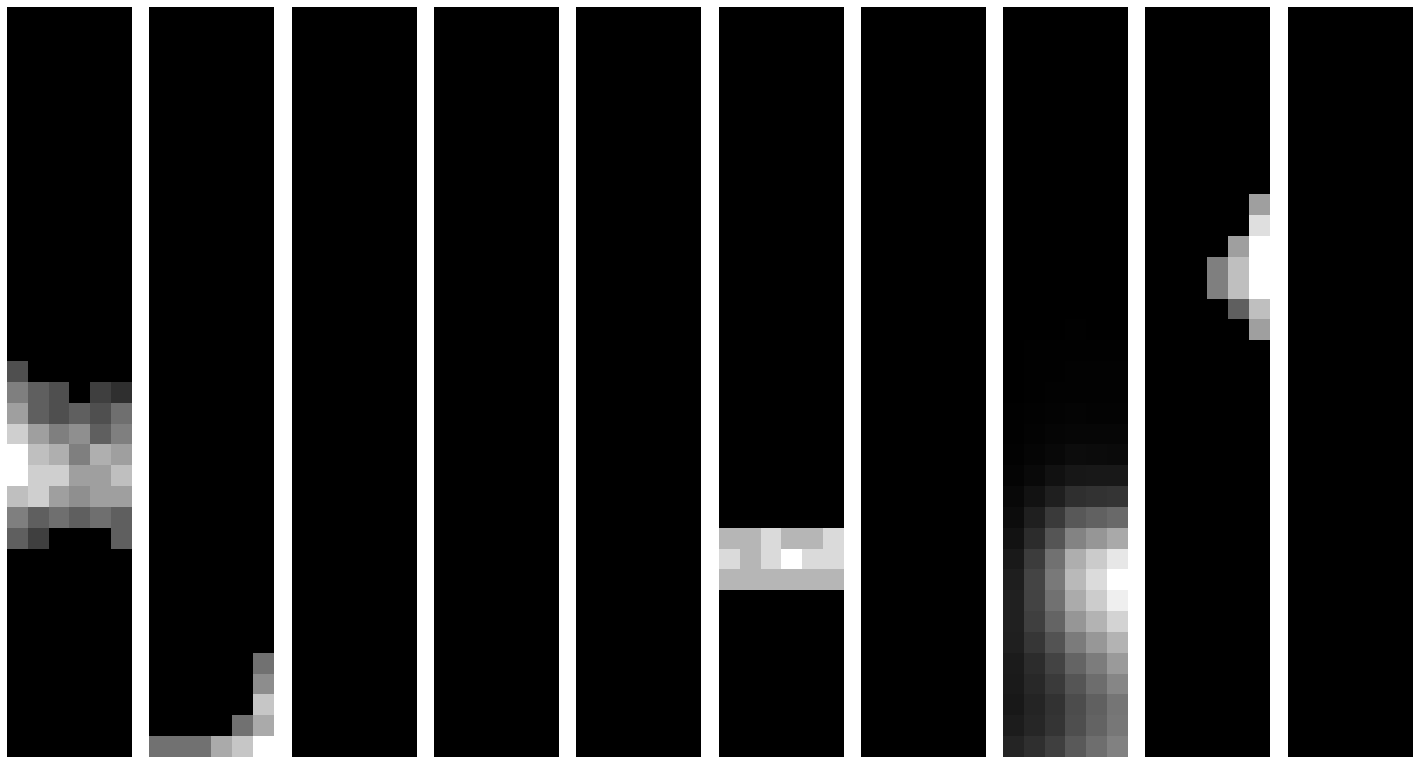

38/38 - 9s - loss: 1.4815 - d_loss: 0.5482 - g_loss: 0.9333 - 9s/epoch - 238ms/step
Epoch 100/200


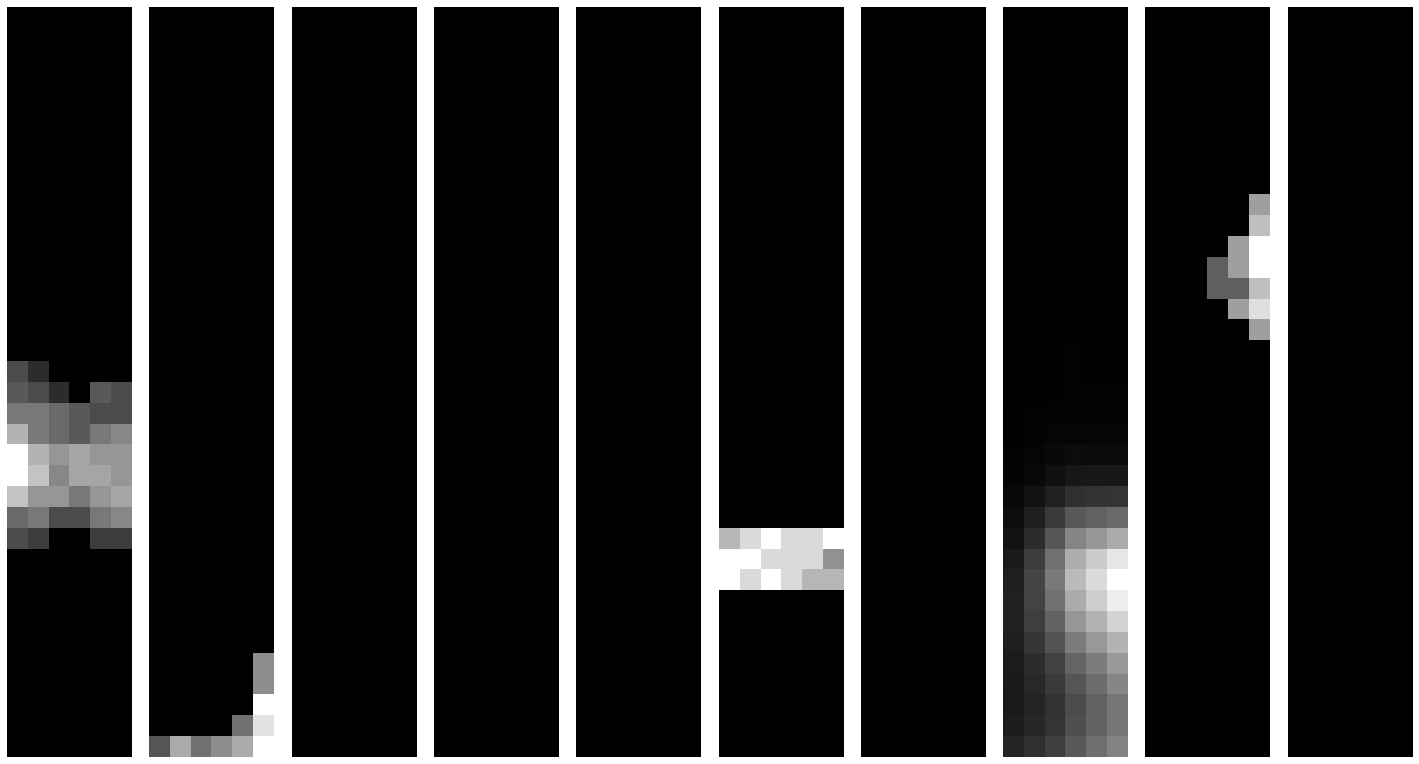

38/38 - 9s - loss: 1.4855 - d_loss: 0.5417 - g_loss: 0.9438 - 9s/epoch - 244ms/step
Epoch 101/200


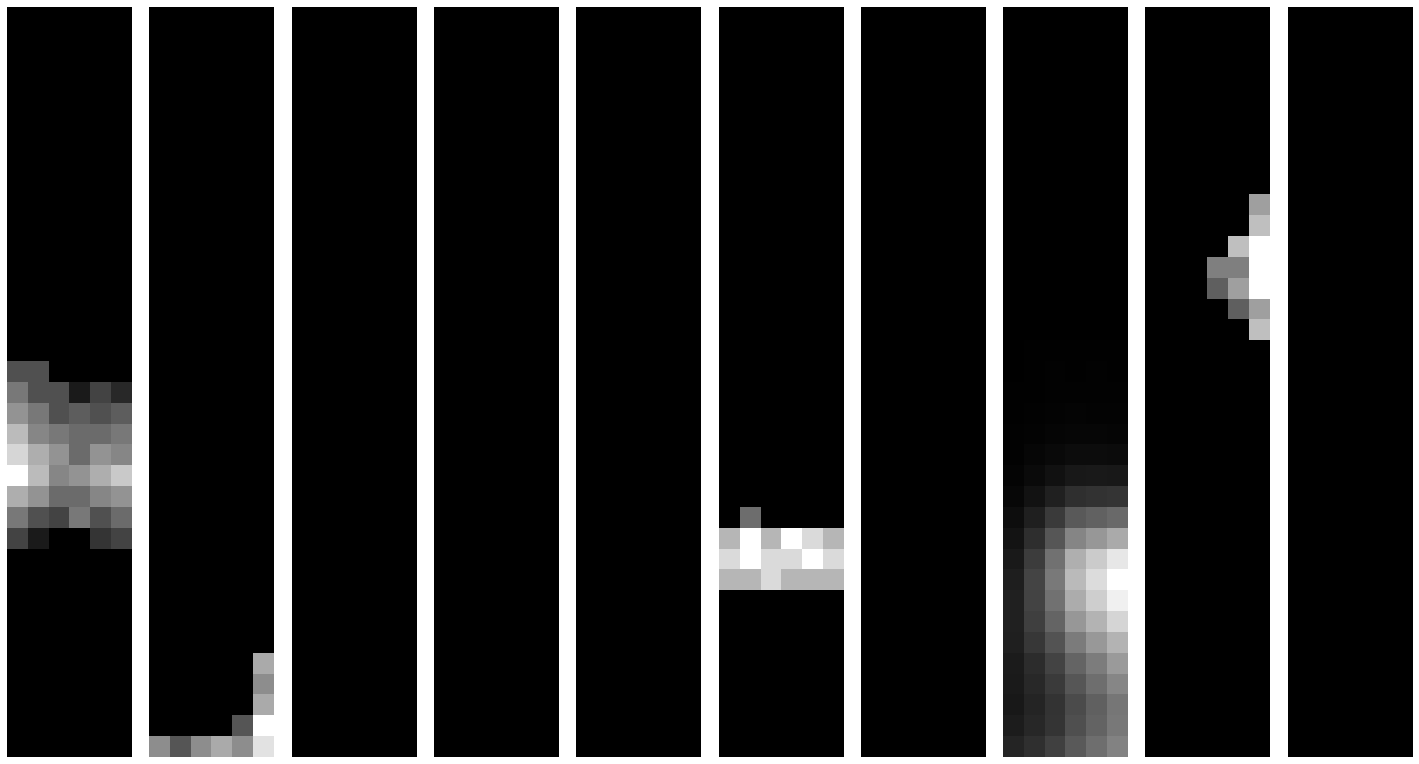

38/38 - 9s - loss: 1.4894 - d_loss: 0.5390 - g_loss: 0.9504 - 9s/epoch - 239ms/step
Epoch 102/200


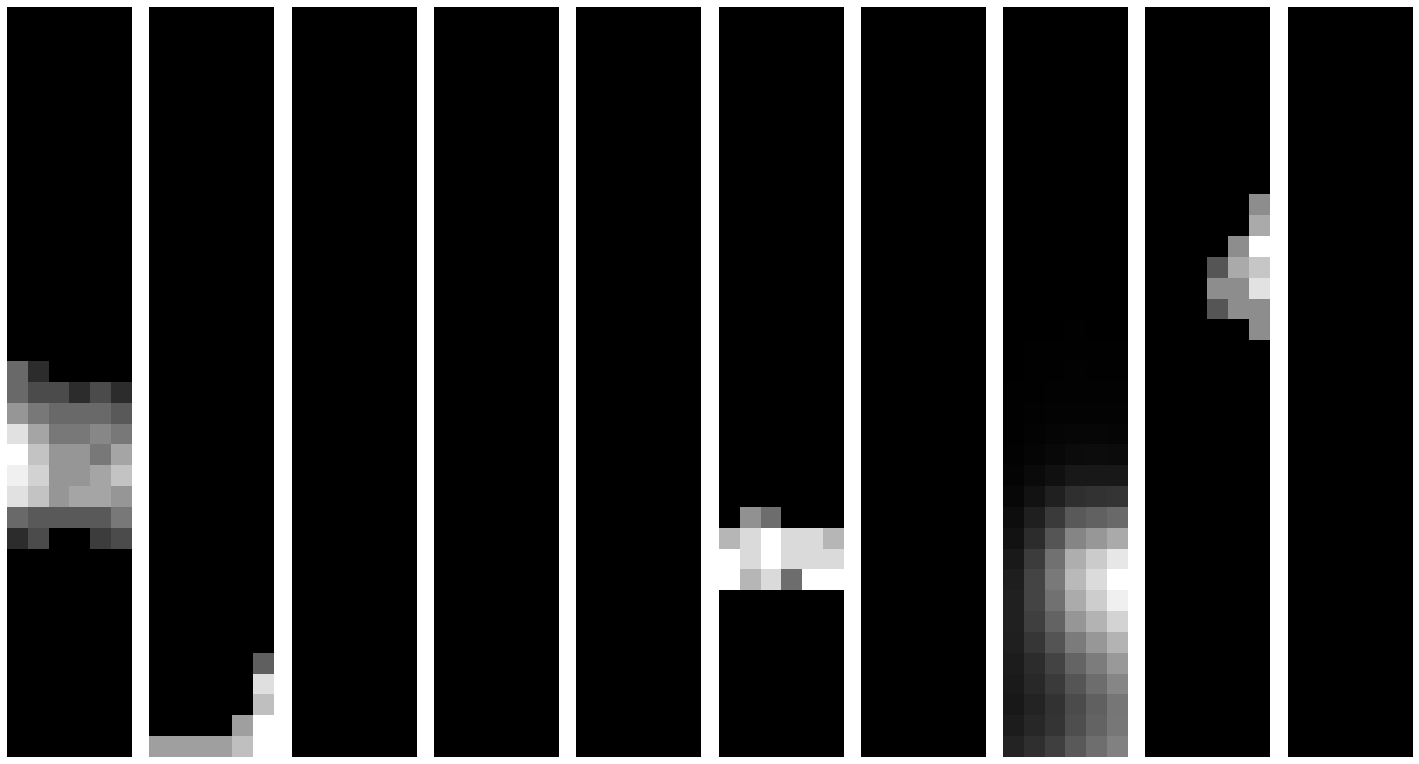

38/38 - 9s - loss: 1.5015 - d_loss: 0.5341 - g_loss: 0.9675 - 9s/epoch - 239ms/step
Epoch 103/200


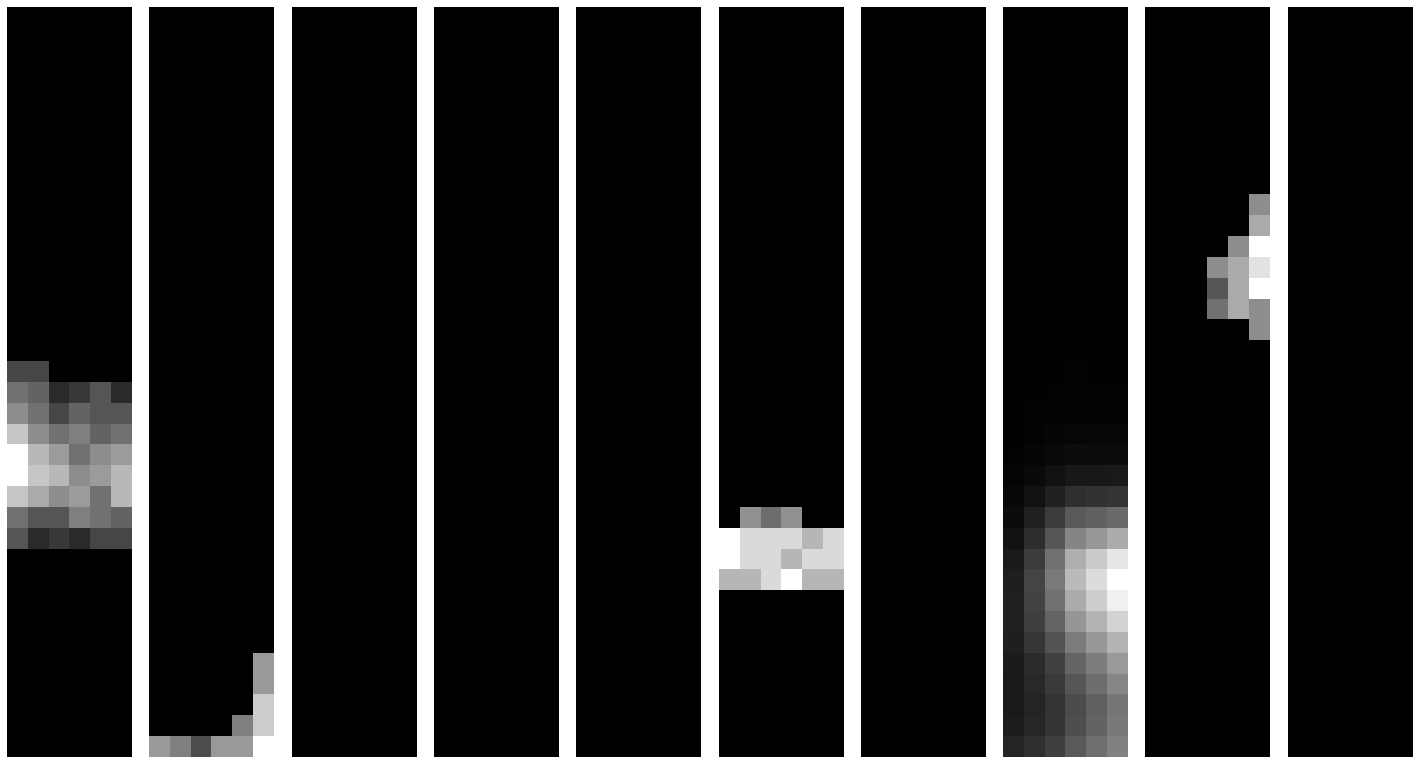

38/38 - 9s - loss: 1.5030 - d_loss: 0.5295 - g_loss: 0.9735 - 9s/epoch - 238ms/step
Epoch 104/200


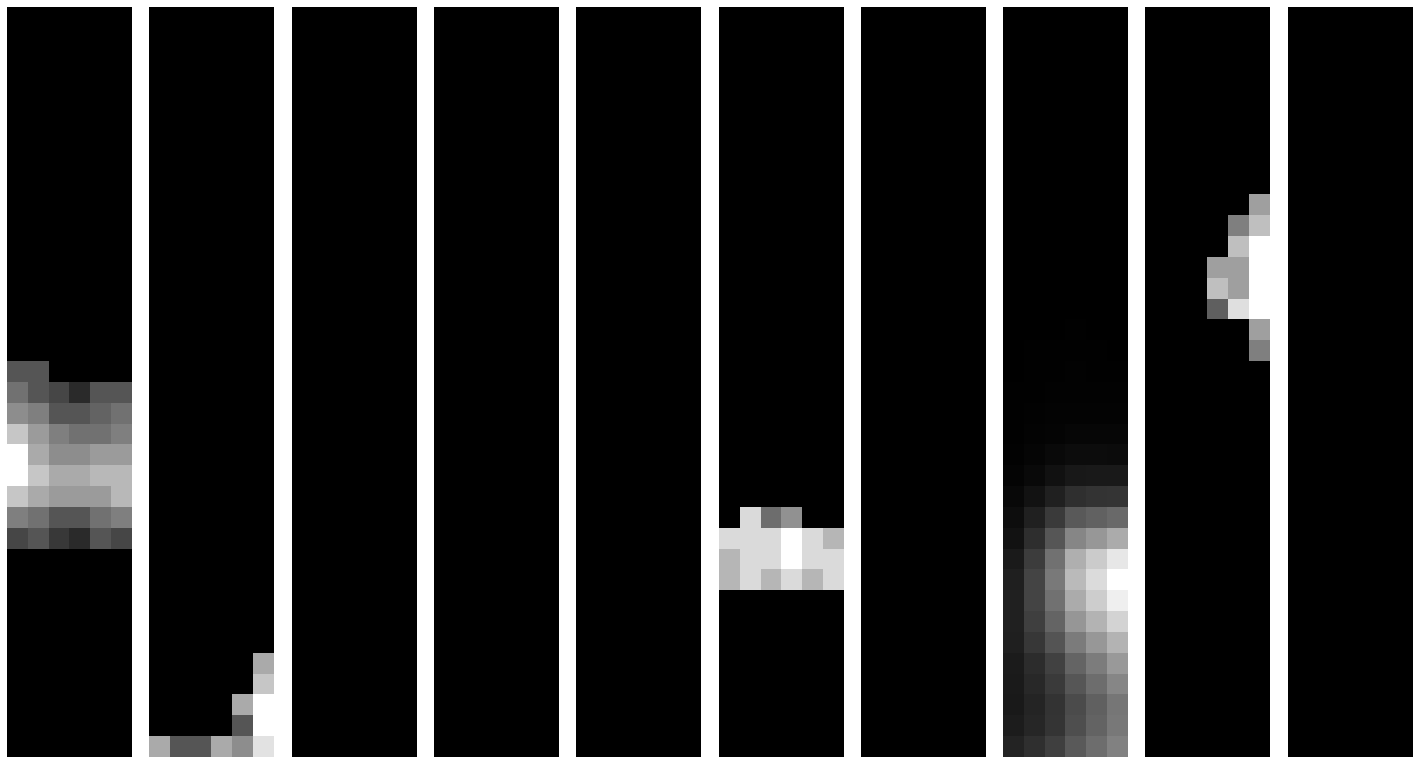

38/38 - 9s - loss: 1.5012 - d_loss: 0.5198 - g_loss: 0.9814 - 9s/epoch - 239ms/step
Epoch 105/200


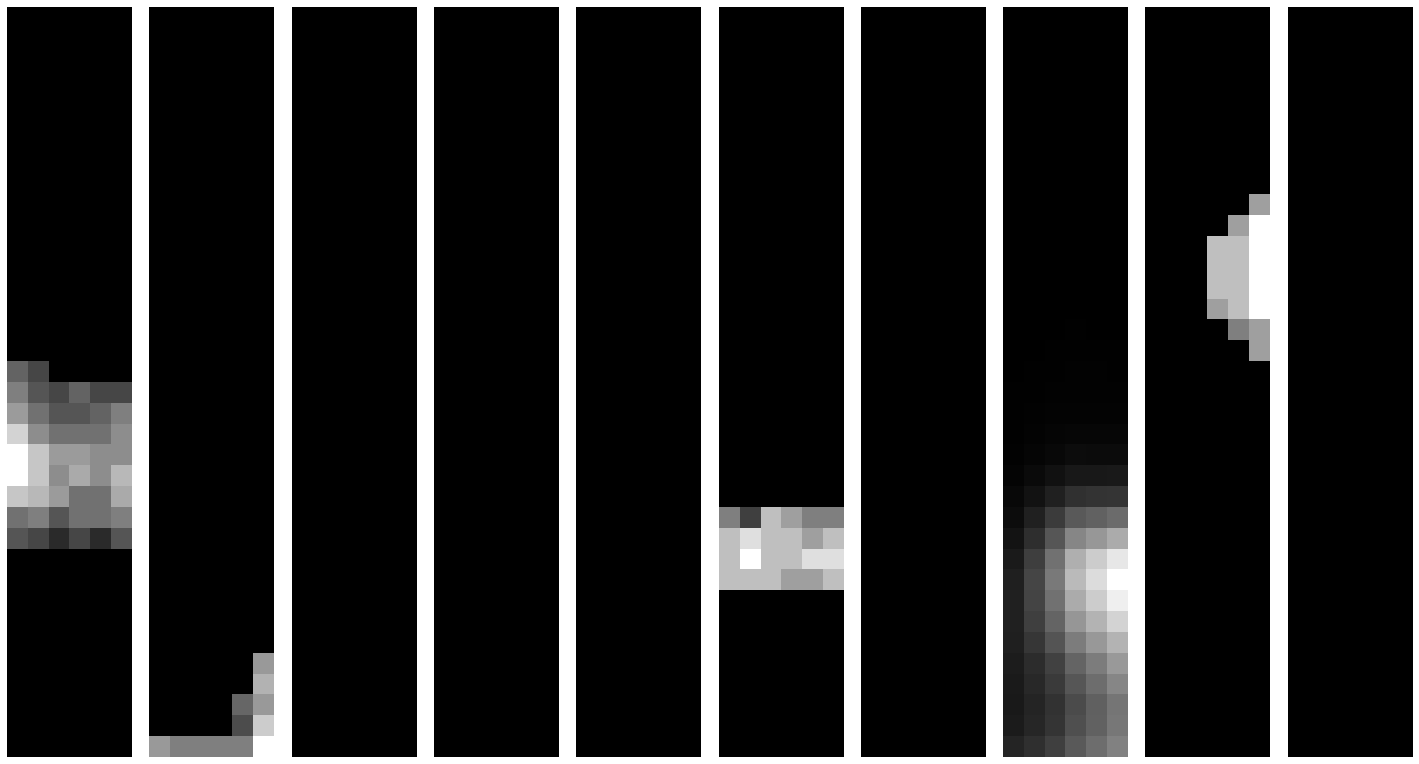

38/38 - 9s - loss: 1.5122 - d_loss: 0.5171 - g_loss: 0.9951 - 9s/epoch - 239ms/step
Epoch 106/200


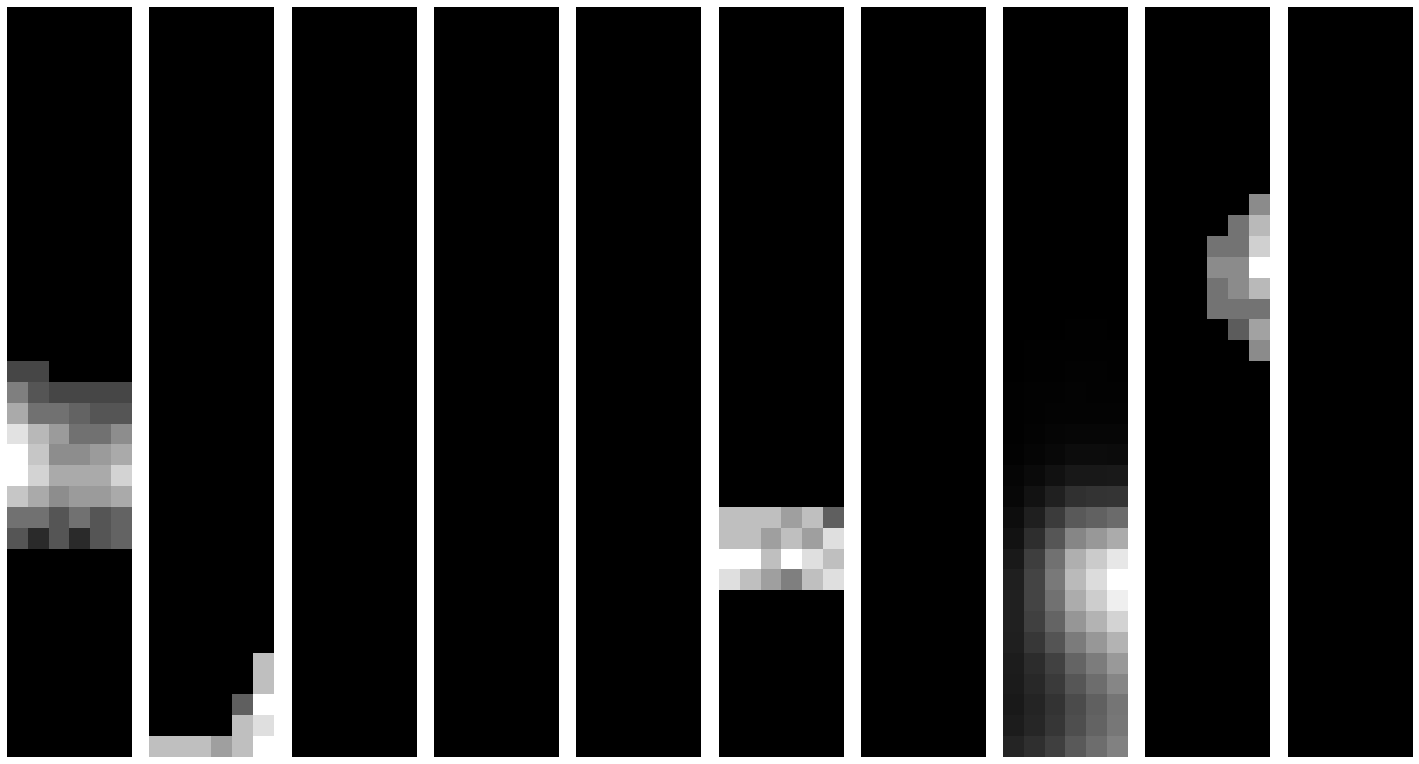

38/38 - 9s - loss: 1.5162 - d_loss: 0.5118 - g_loss: 1.0044 - 9s/epoch - 245ms/step
Epoch 107/200


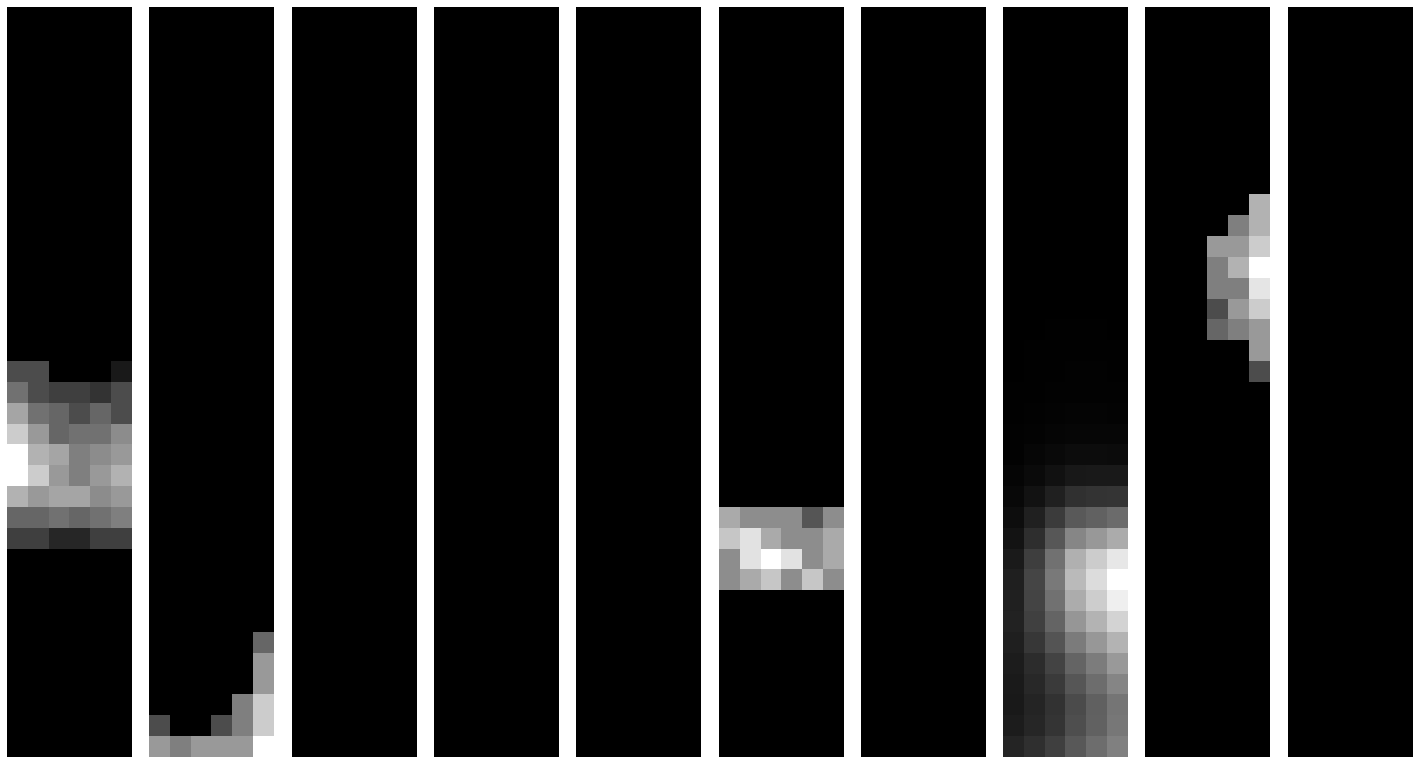

38/38 - 9s - loss: 1.5215 - d_loss: 0.5067 - g_loss: 1.0149 - 9s/epoch - 239ms/step
Epoch 108/200


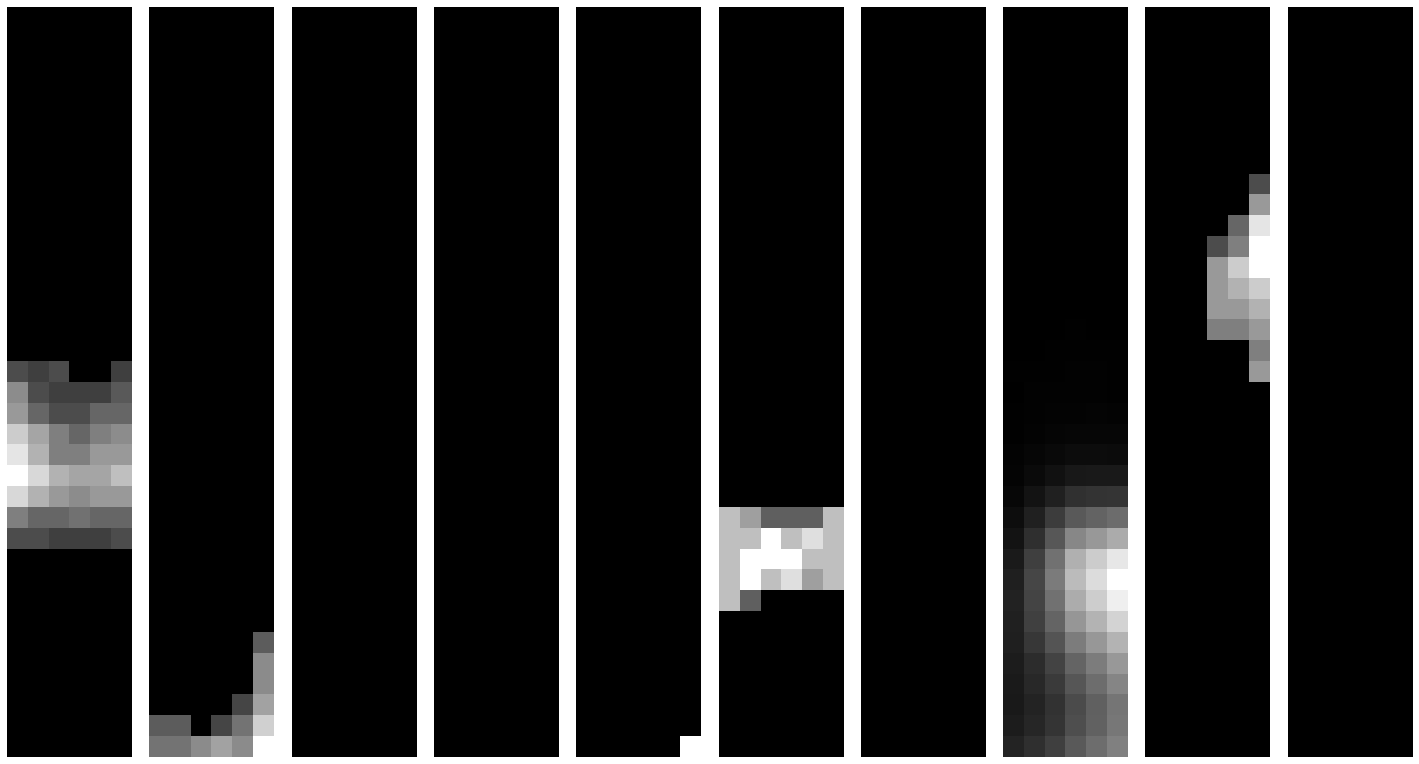

38/38 - 9s - loss: 1.5380 - d_loss: 0.5064 - g_loss: 1.0317 - 9s/epoch - 238ms/step
Epoch 109/200


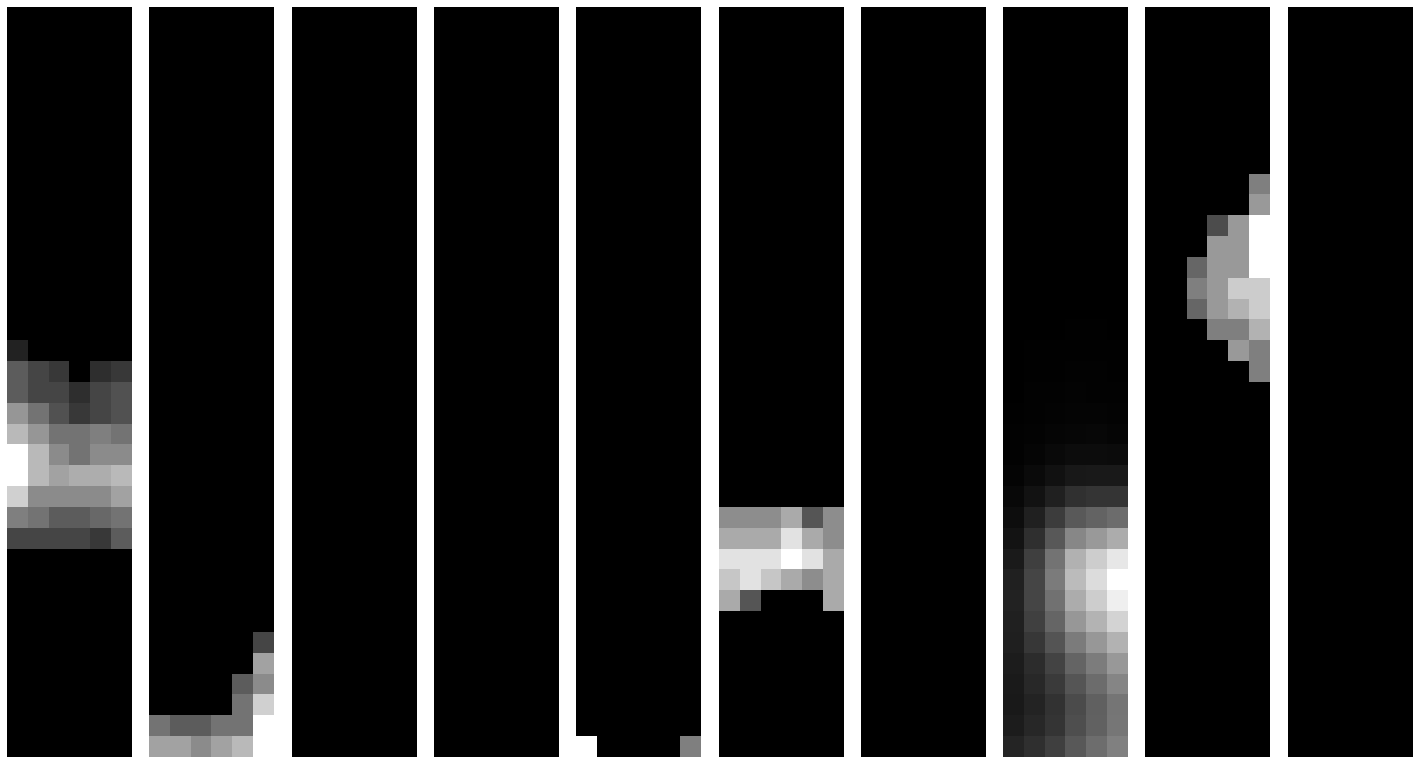

38/38 - 9s - loss: 1.5399 - d_loss: 0.5042 - g_loss: 1.0357 - 9s/epoch - 240ms/step
Epoch 110/200


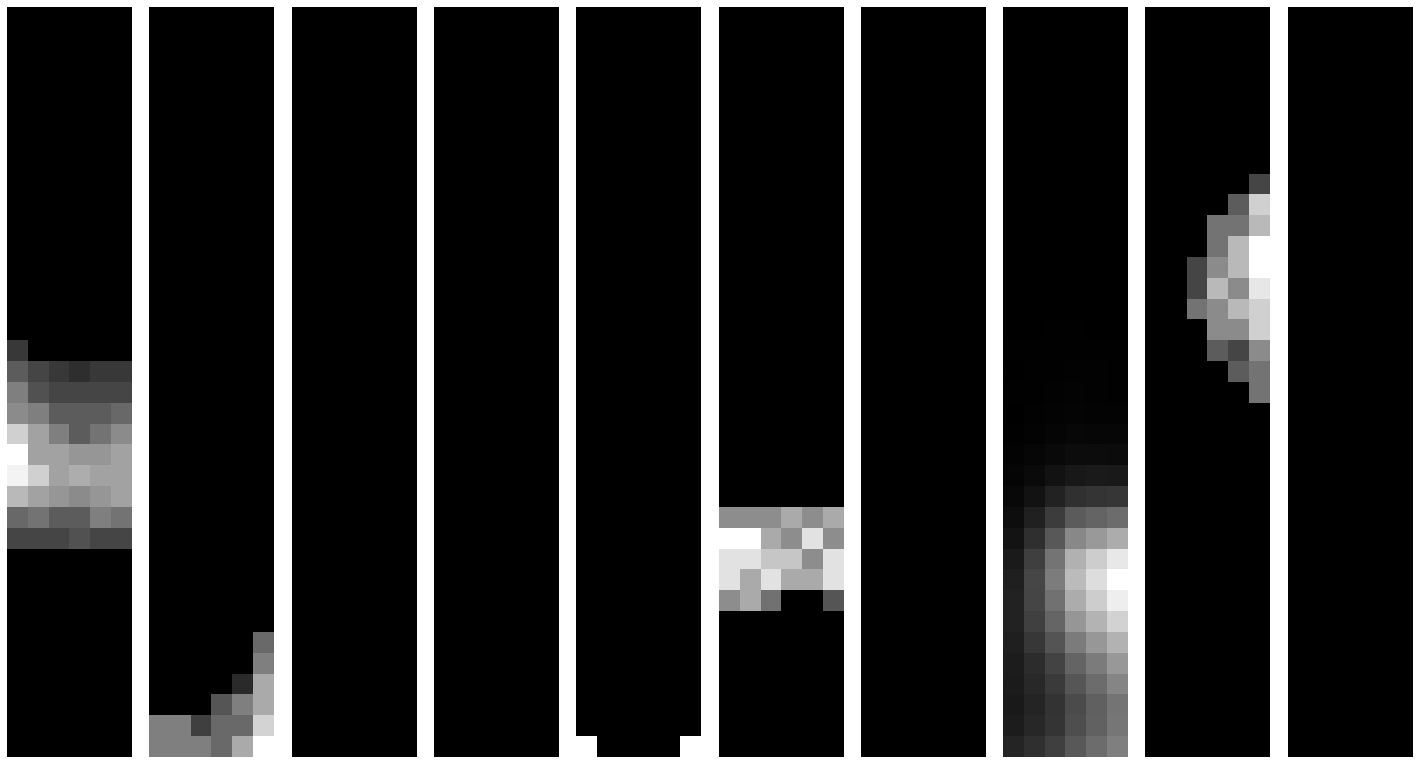

38/38 - 9s - loss: 1.5412 - d_loss: 0.4952 - g_loss: 1.0460 - 9s/epoch - 239ms/step
Epoch 111/200


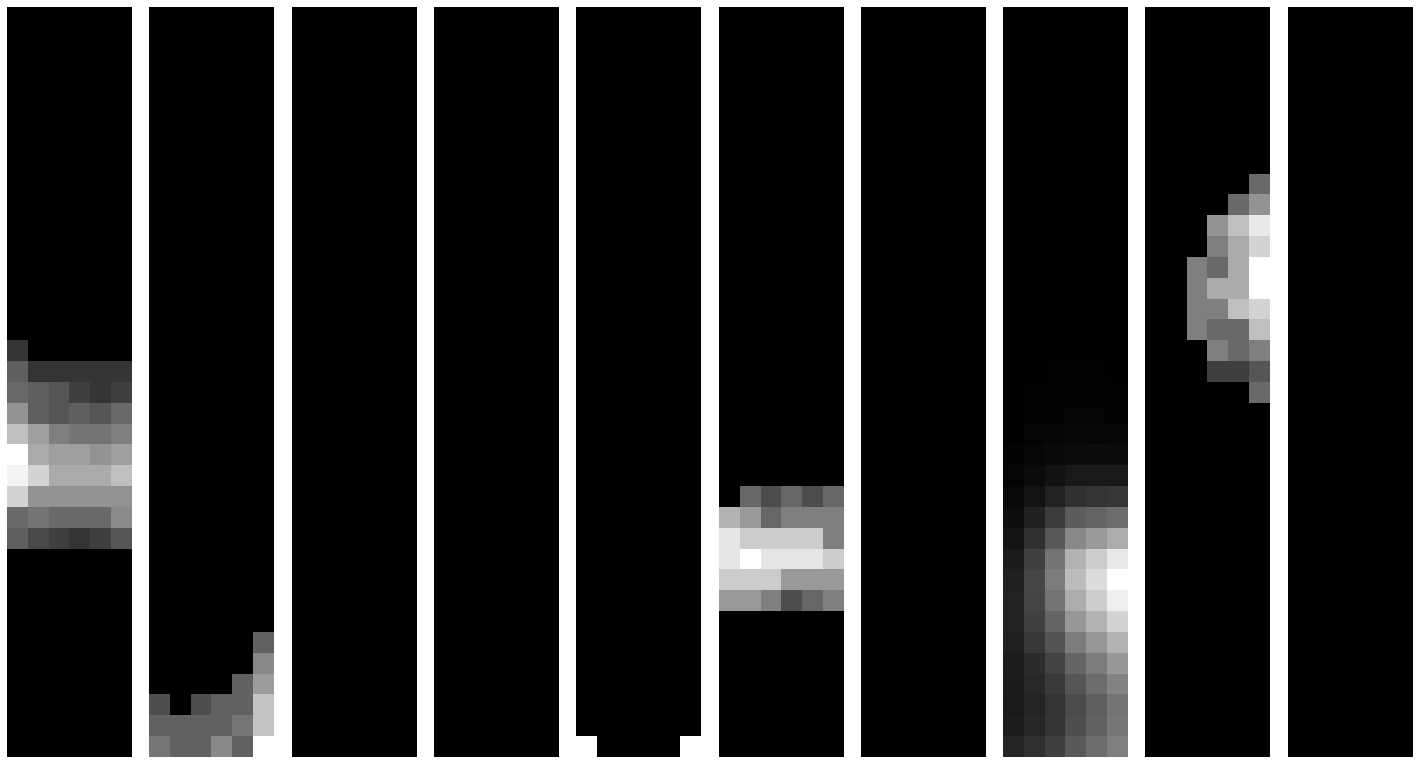

38/38 - 9s - loss: 1.5487 - d_loss: 0.4906 - g_loss: 1.0581 - 9s/epoch - 244ms/step
Epoch 112/200


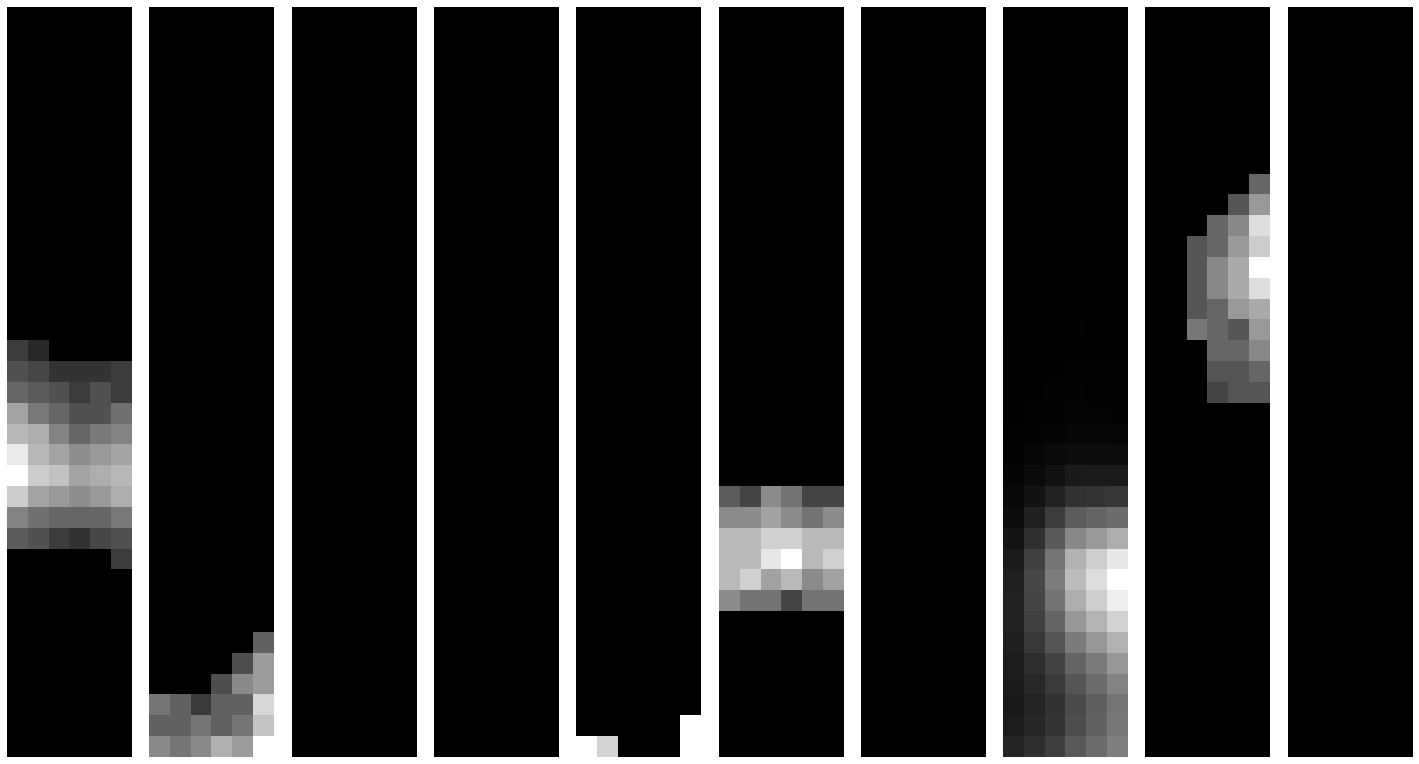

38/38 - 9s - loss: 1.5509 - d_loss: 0.4855 - g_loss: 1.0654 - 9s/epoch - 239ms/step
Epoch 113/200


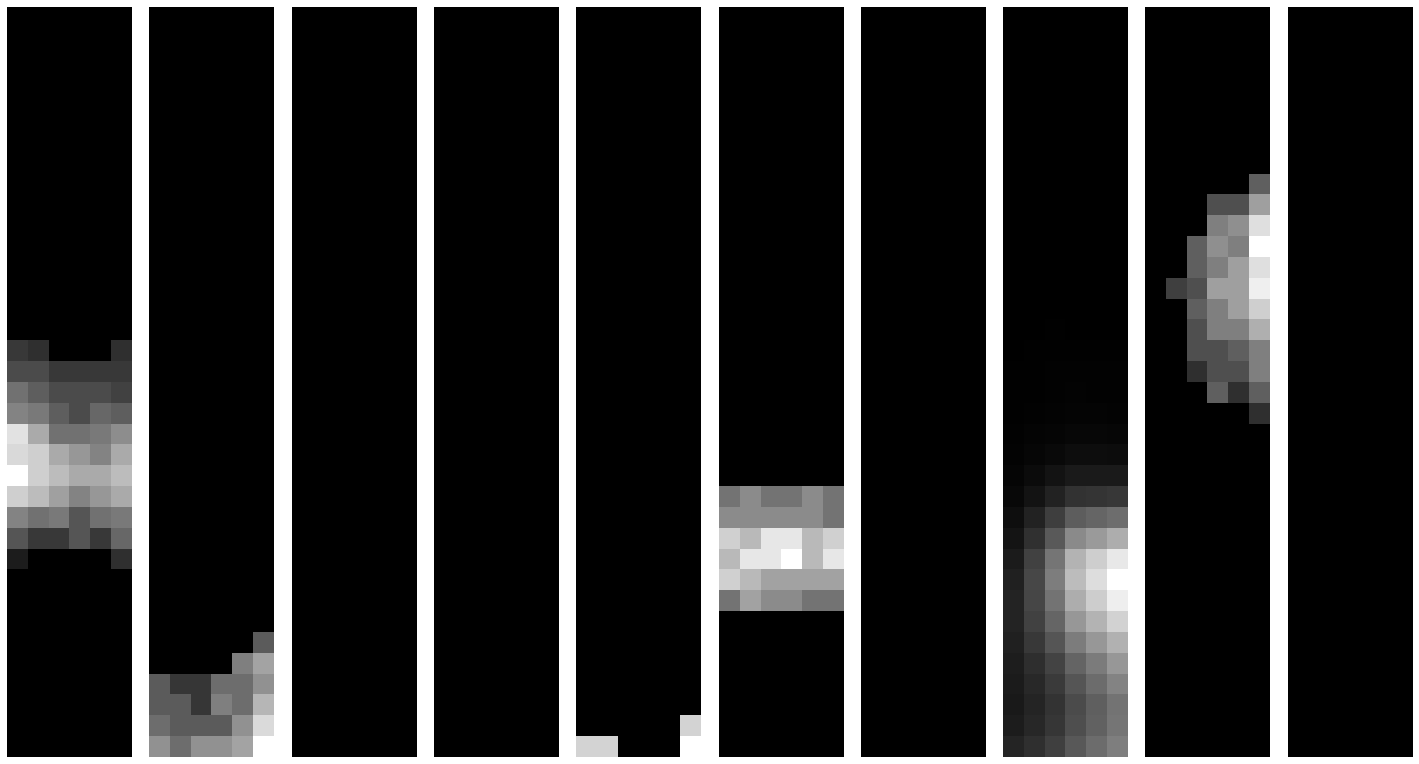

38/38 - 9s - loss: 1.5537 - d_loss: 0.4795 - g_loss: 1.0742 - 9s/epoch - 239ms/step
Epoch 114/200


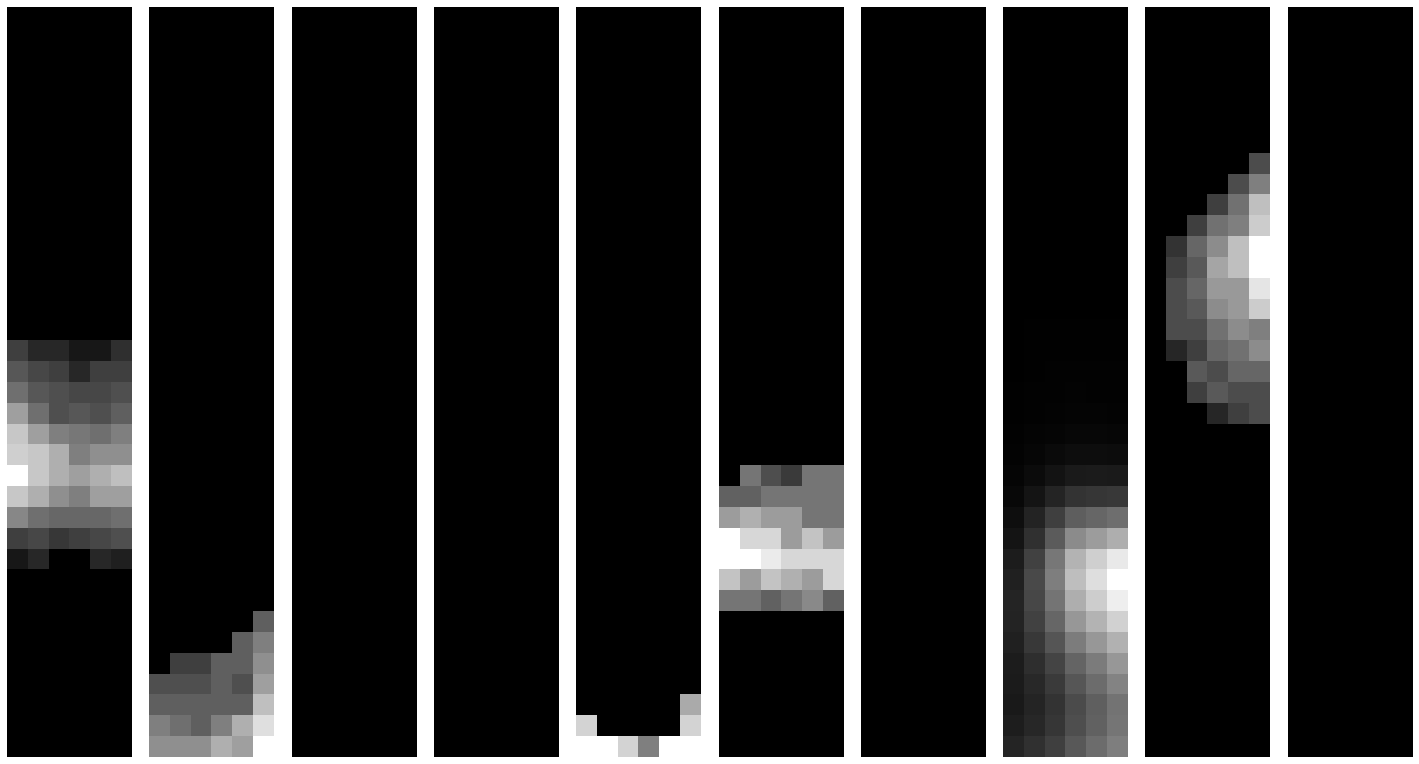

38/38 - 9s - loss: 1.5720 - d_loss: 0.4765 - g_loss: 1.0954 - 9s/epoch - 240ms/step
Epoch 115/200


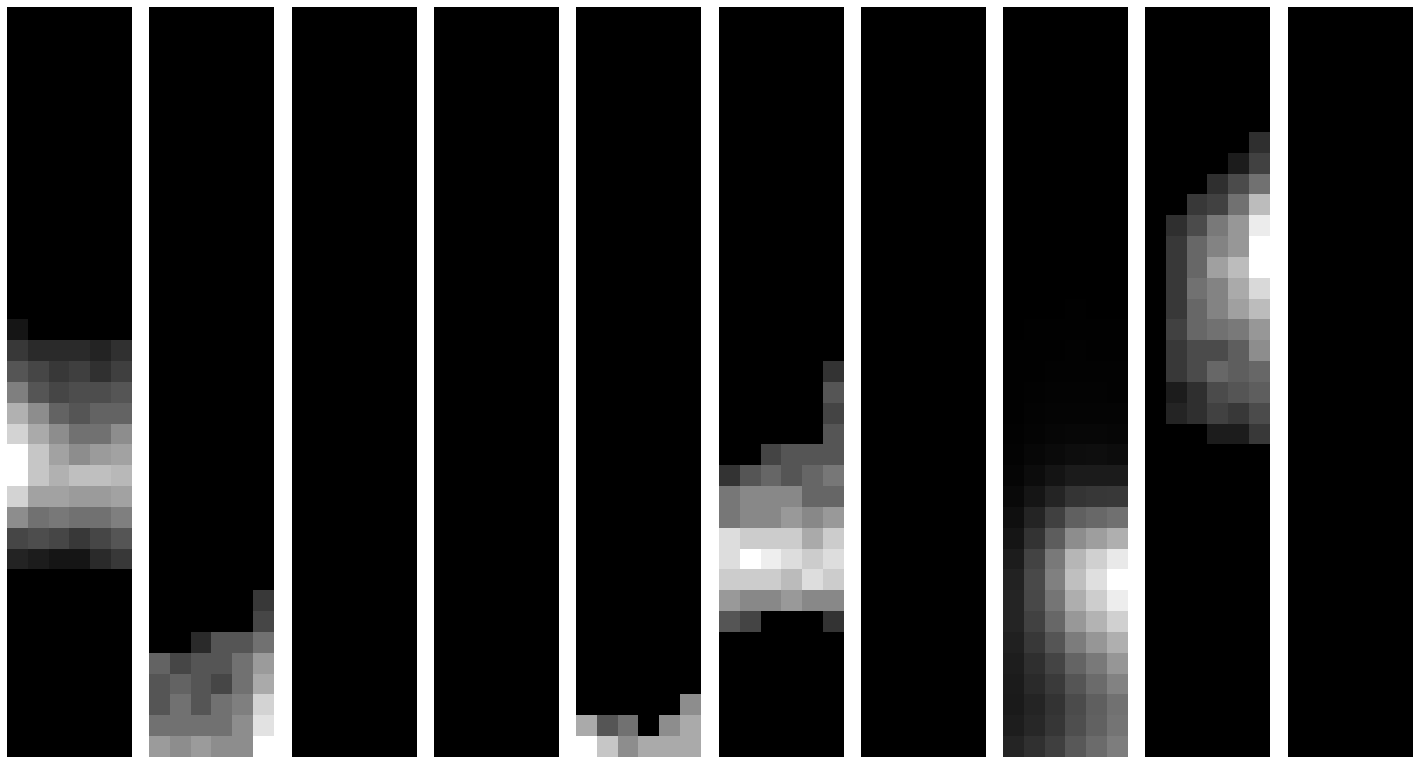

38/38 - 9s - loss: 1.5733 - d_loss: 0.4690 - g_loss: 1.1043 - 9s/epoch - 238ms/step
Epoch 116/200


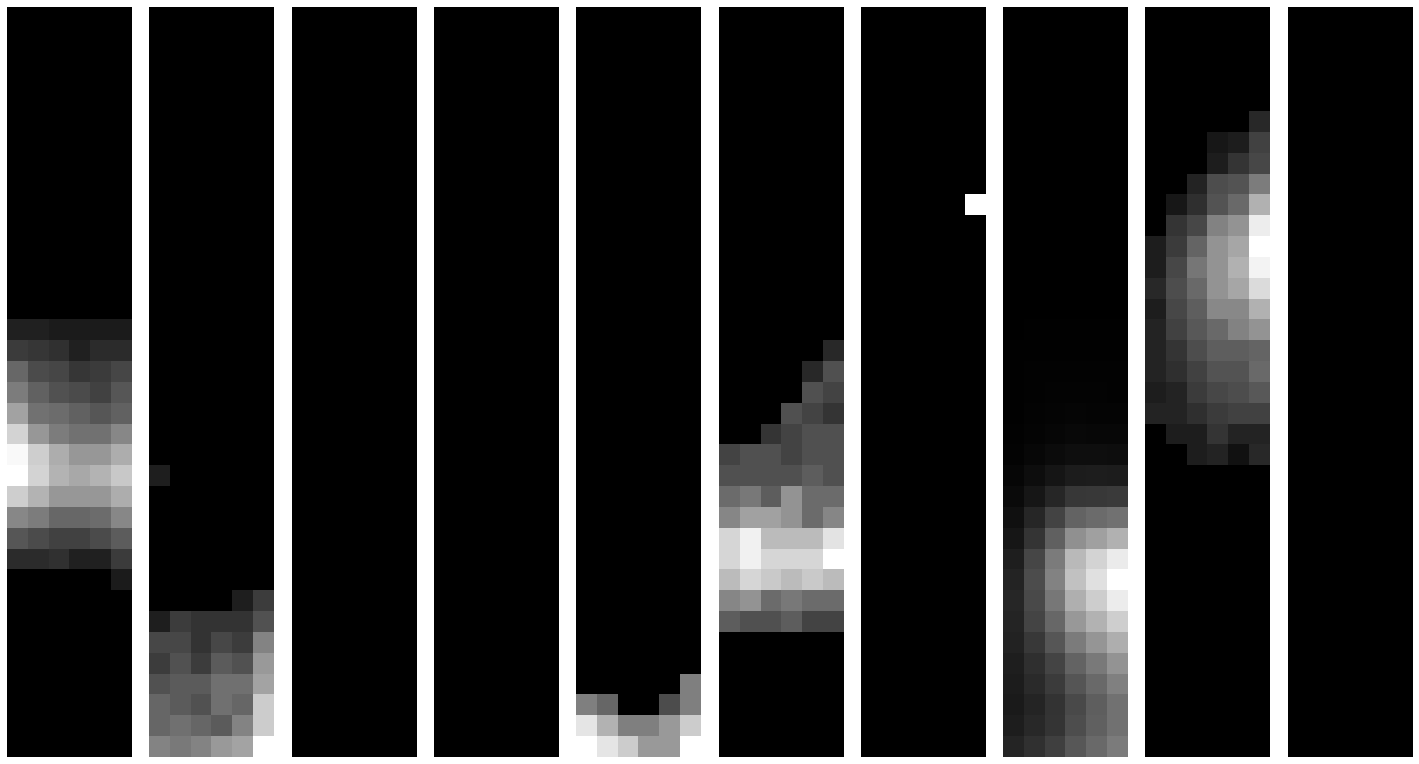

38/38 - 9s - loss: 1.5754 - d_loss: 0.4654 - g_loss: 1.1100 - 9s/epoch - 238ms/step
Epoch 117/200


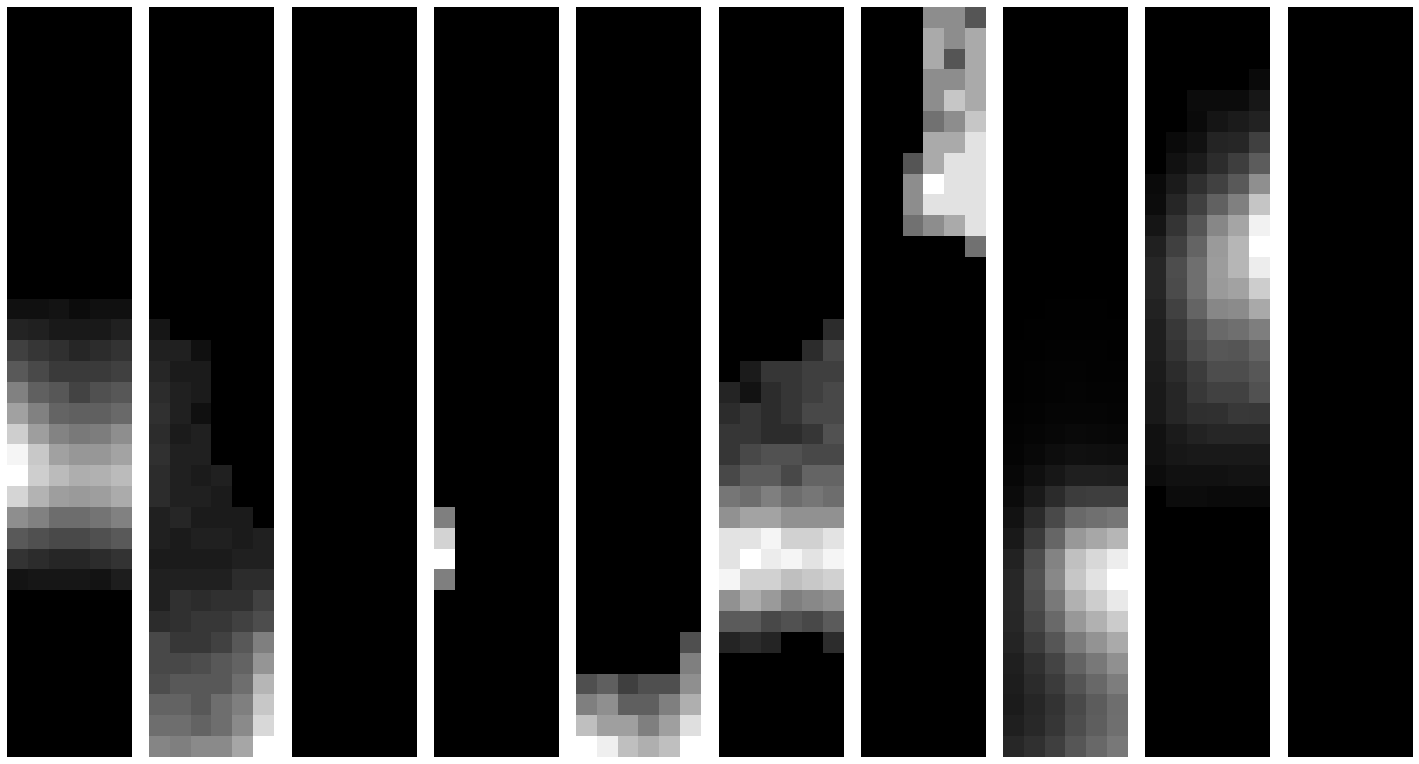

38/38 - 9s - loss: 1.5893 - d_loss: 0.4630 - g_loss: 1.1263 - 9s/epoch - 243ms/step
Epoch 118/200


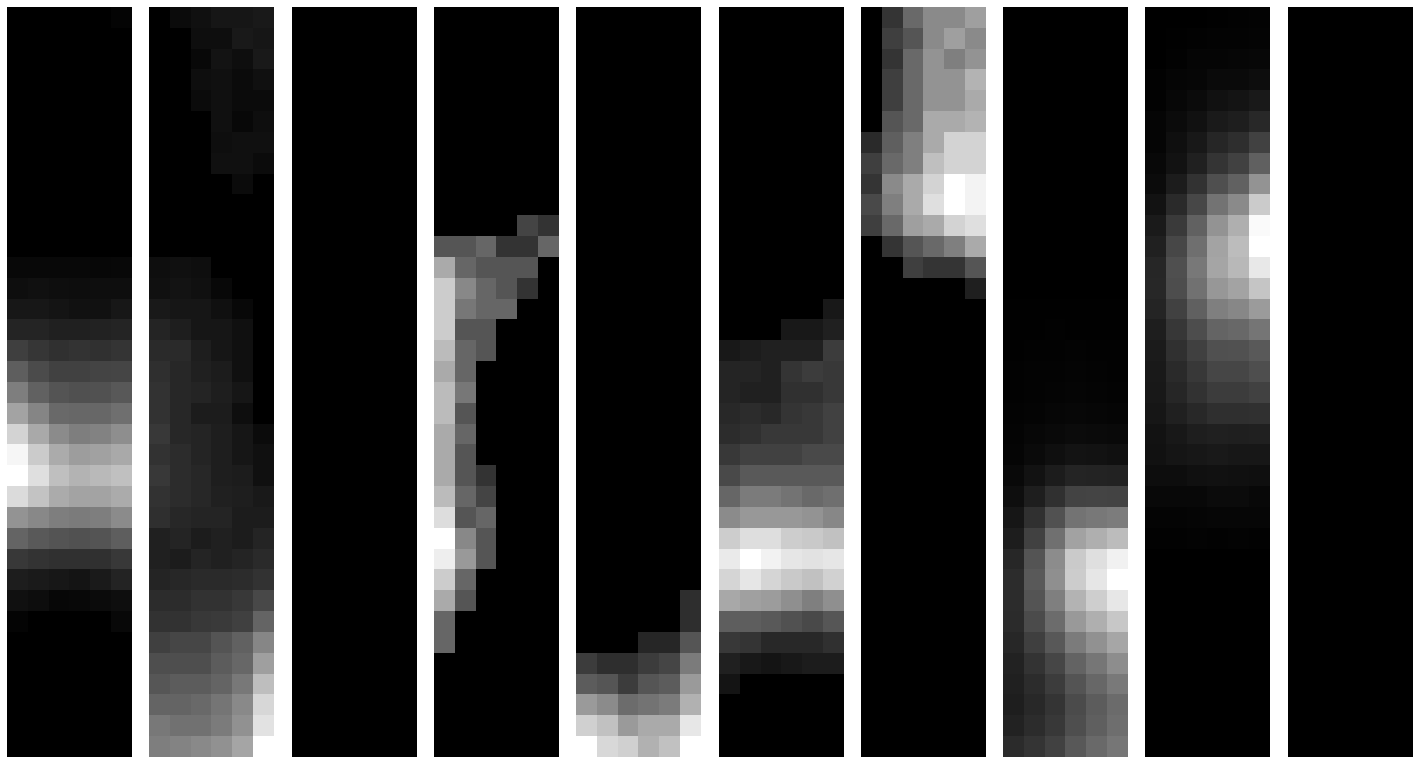

38/38 - 9s - loss: 1.5912 - d_loss: 0.4550 - g_loss: 1.1363 - 9s/epoch - 238ms/step
Epoch 119/200


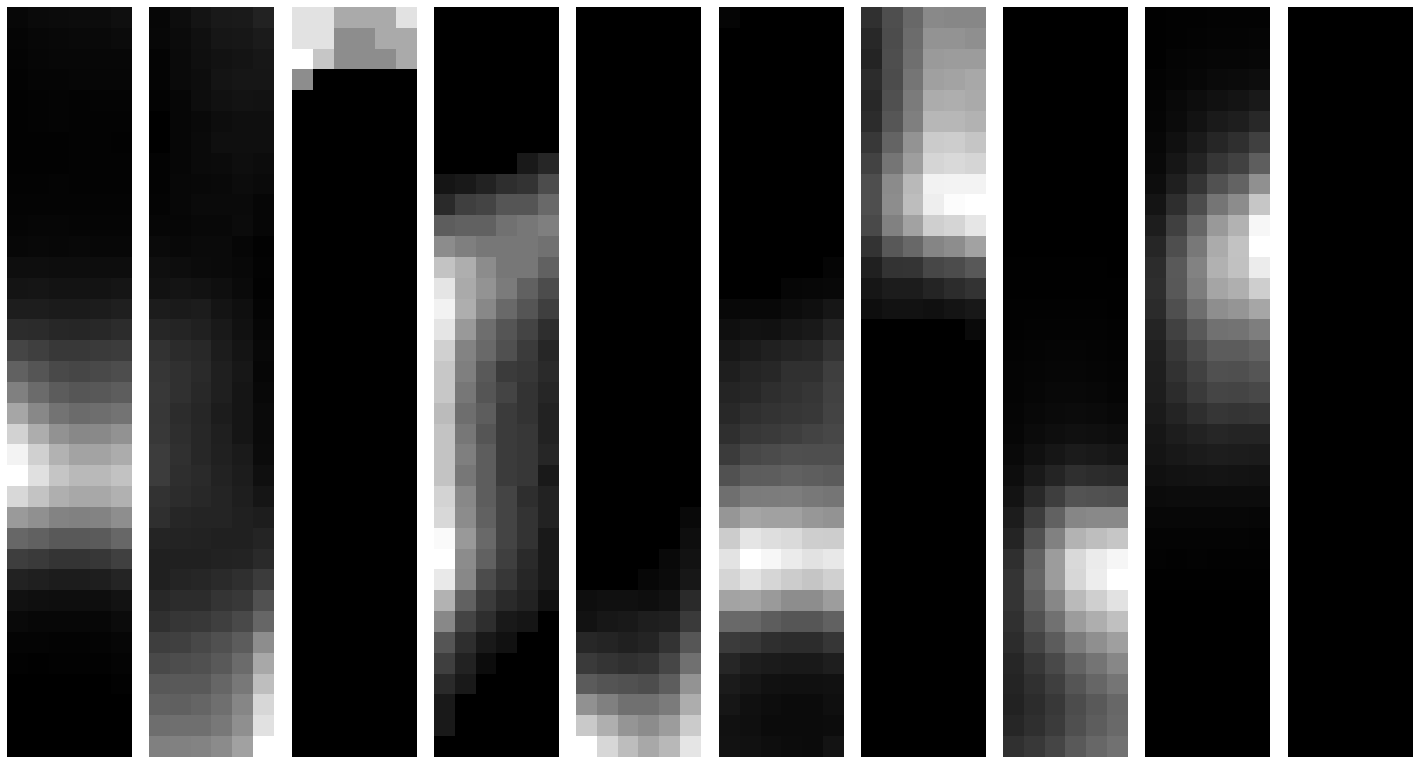

38/38 - 9s - loss: 1.5970 - d_loss: 0.4535 - g_loss: 1.1435 - 9s/epoch - 239ms/step
Epoch 120/200


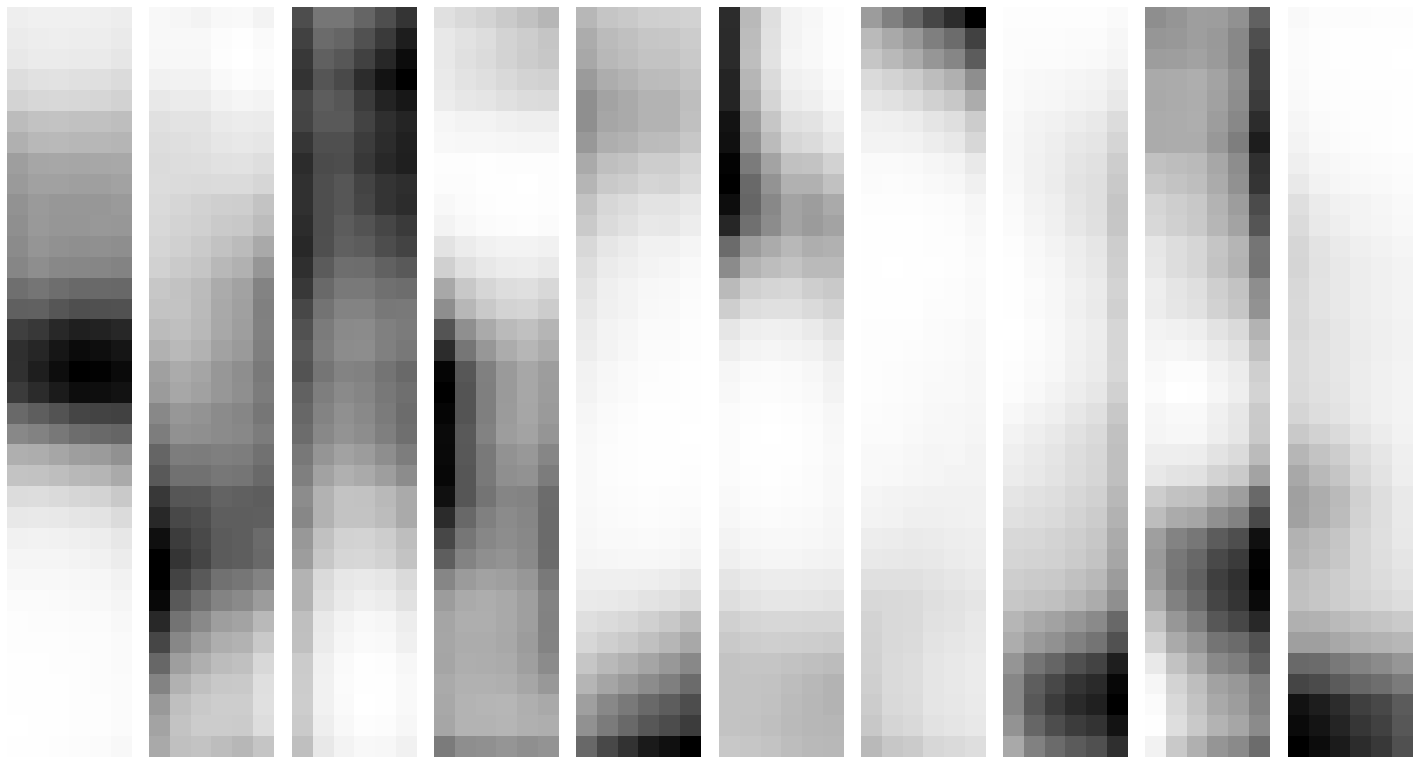

38/38 - 9s - loss: 2.0493 - d_loss: 0.5594 - g_loss: 1.4898 - 9s/epoch - 240ms/step
Epoch 121/200


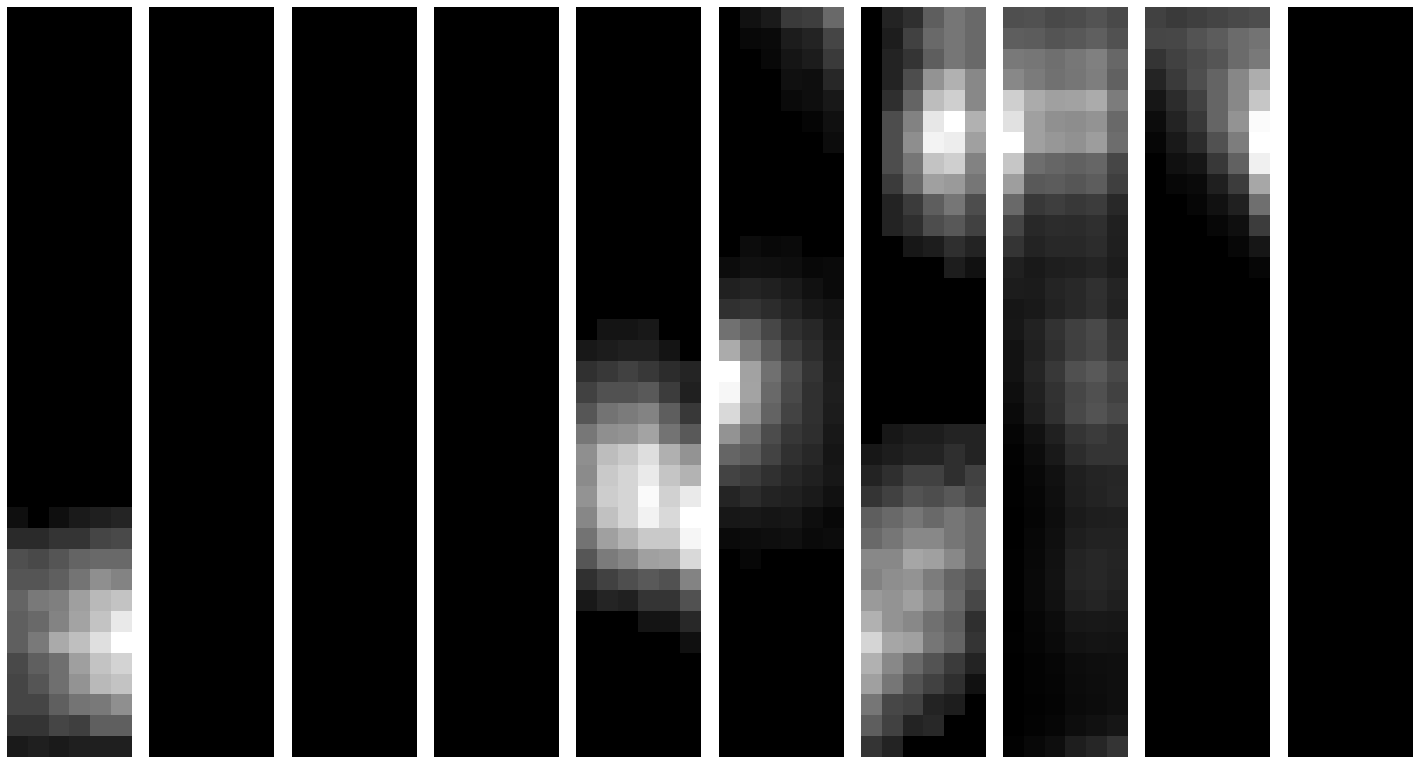

38/38 - 9s - loss: 2.6407 - d_loss: 0.9685 - g_loss: 1.6722 - 9s/epoch - 240ms/step
Epoch 122/200


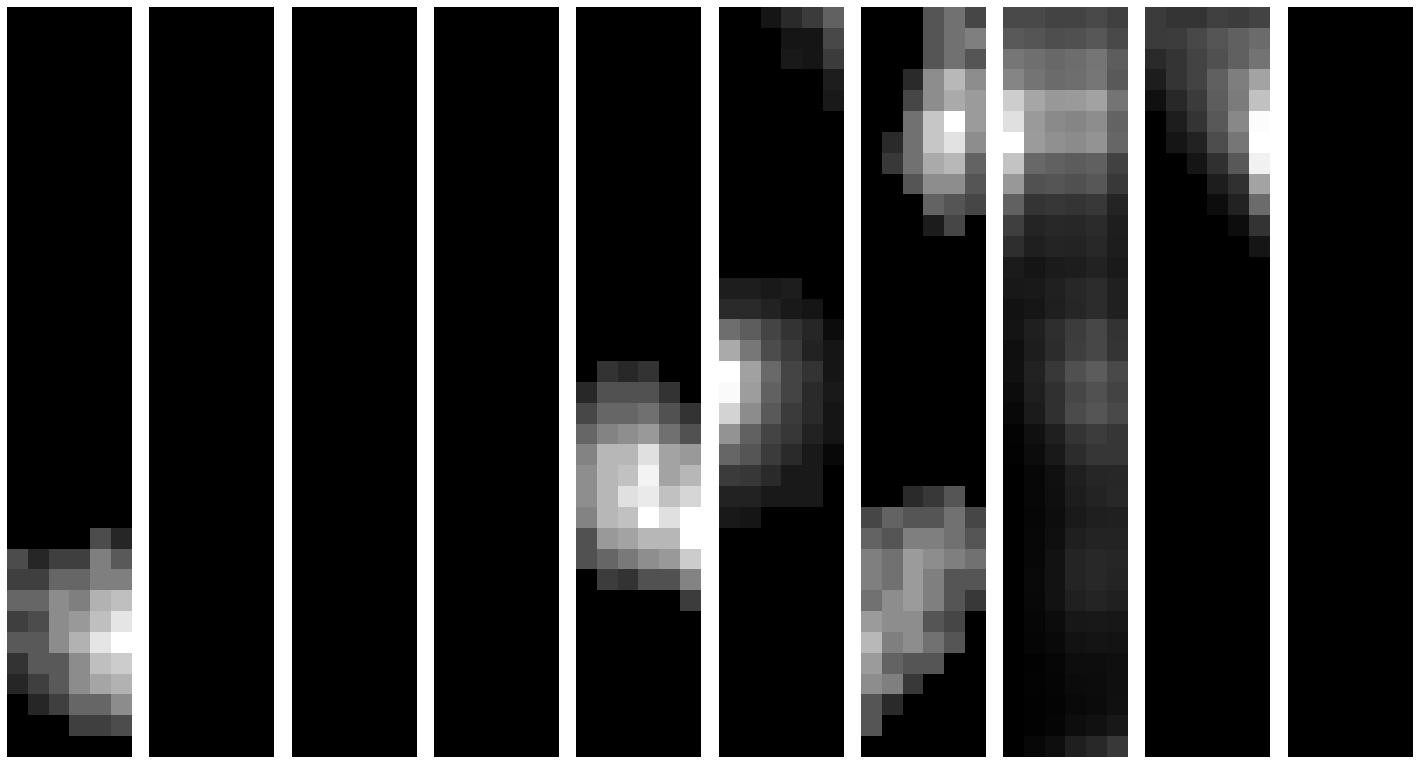

38/38 - 9s - loss: 1.5505 - d_loss: 0.6088 - g_loss: 0.9417 - 9s/epoch - 239ms/step
Epoch 123/200


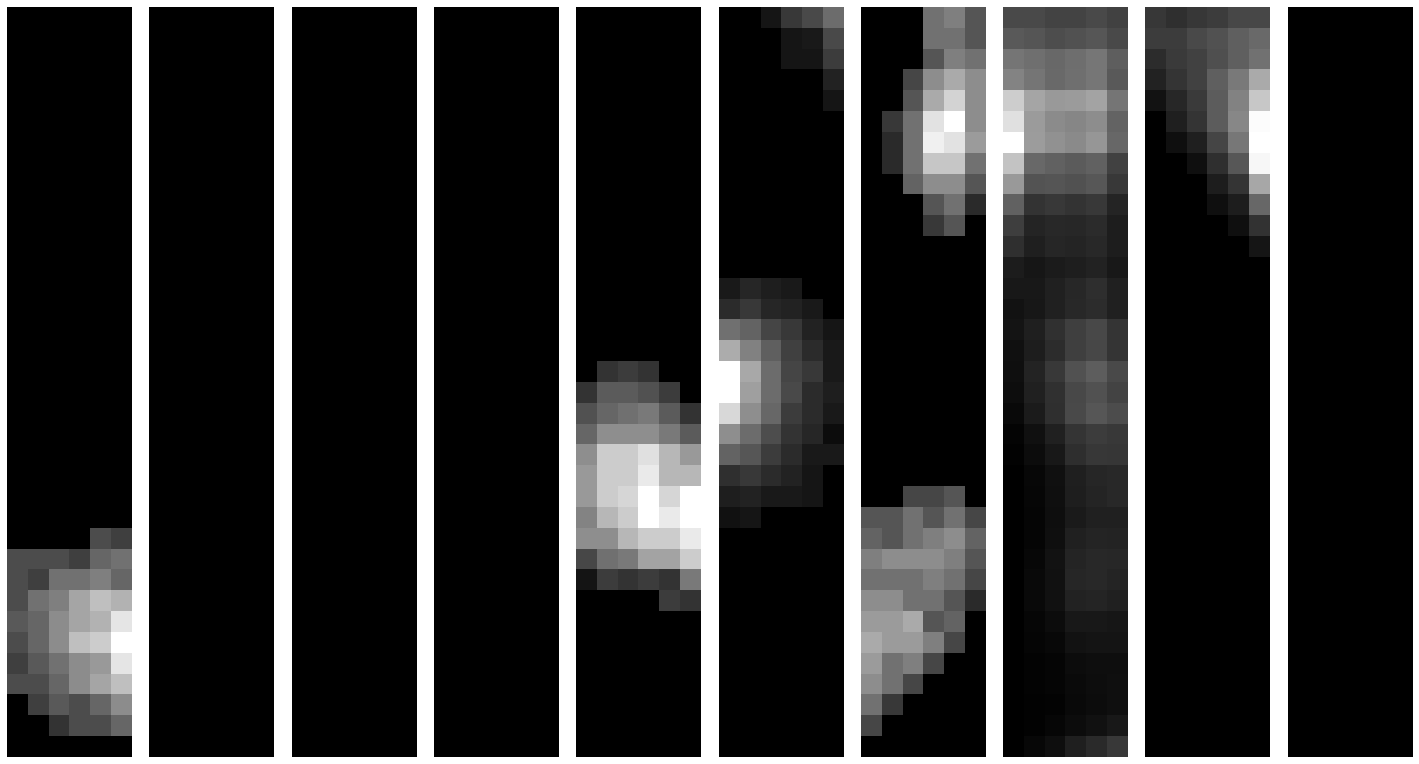

38/38 - 9s - loss: 1.5002 - d_loss: 0.5642 - g_loss: 0.9360 - 9s/epoch - 244ms/step
Epoch 124/200


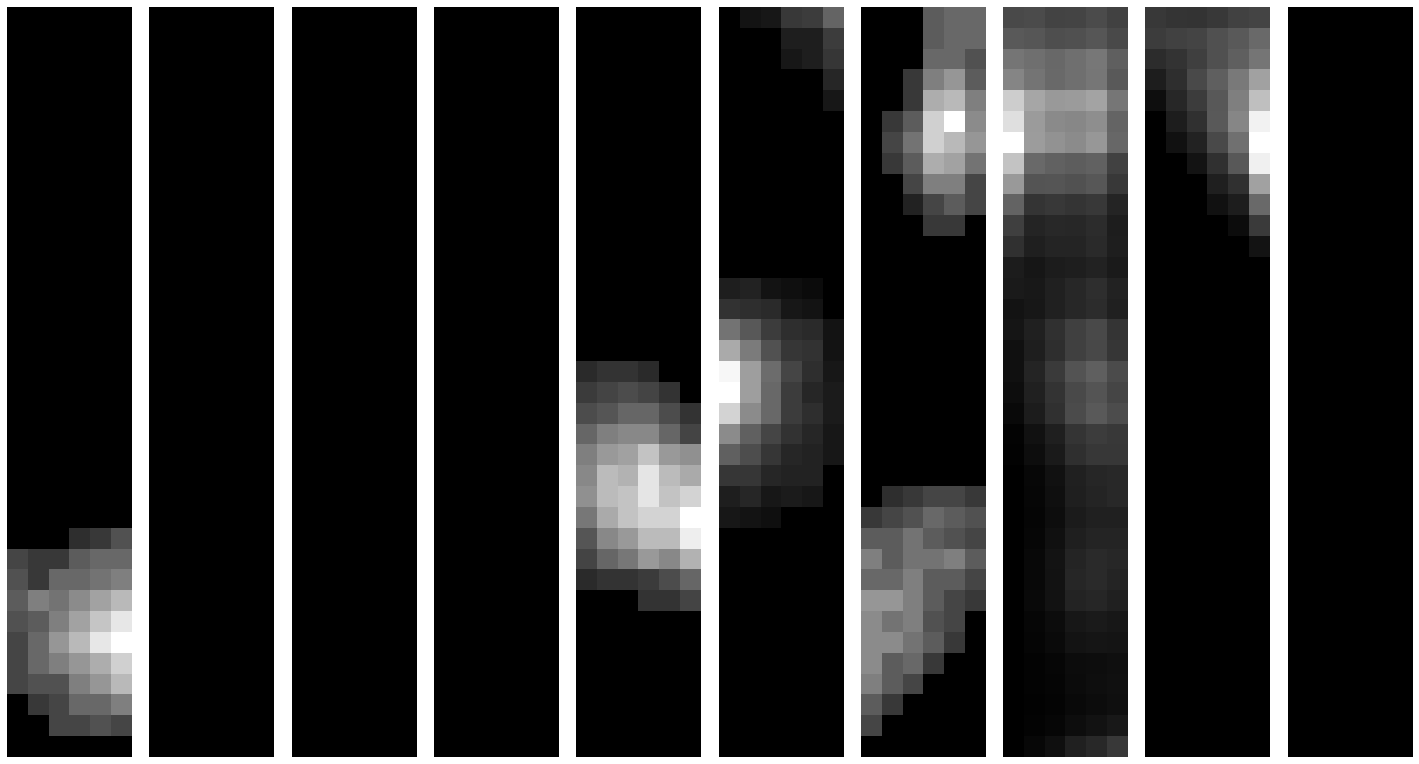

38/38 - 9s - loss: 1.5011 - d_loss: 0.5434 - g_loss: 0.9578 - 9s/epoch - 238ms/step
Epoch 125/200


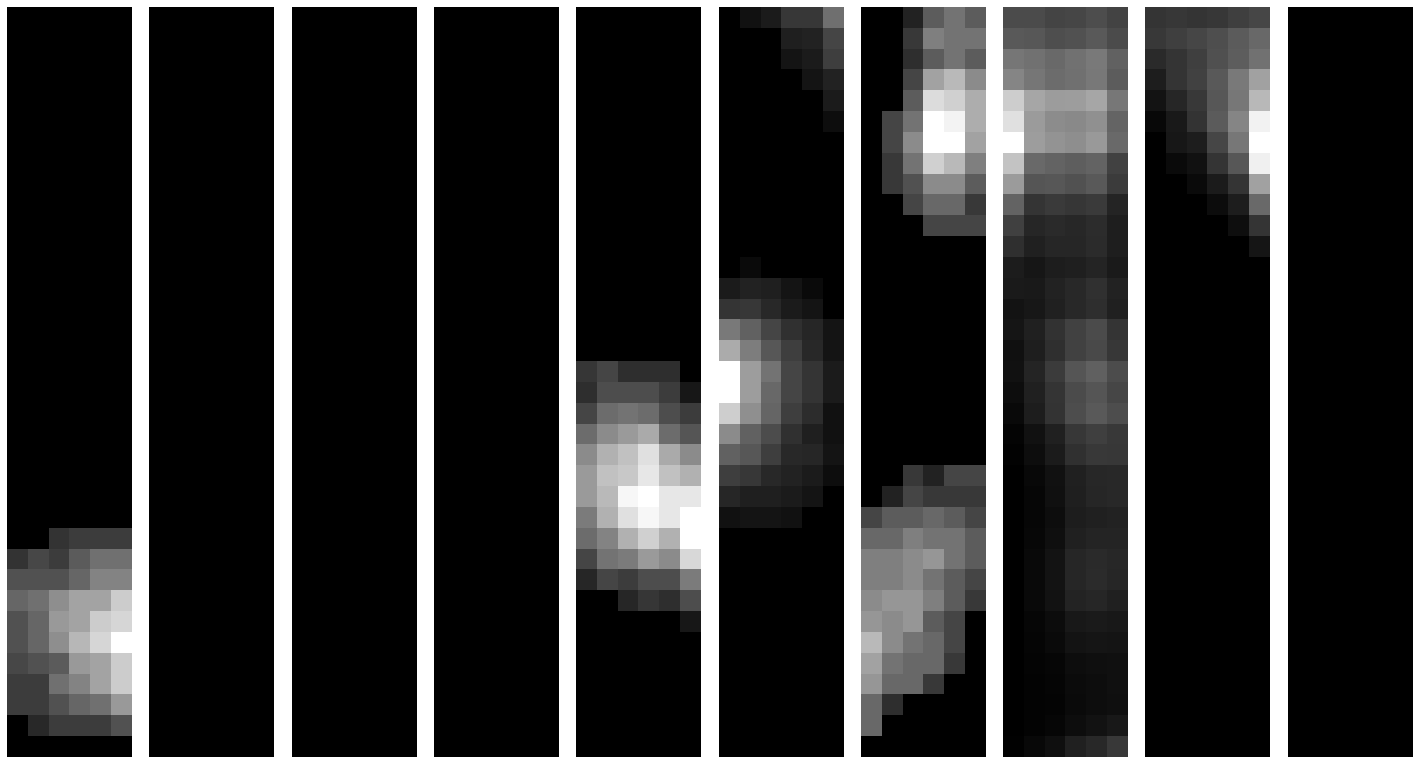

38/38 - 9s - loss: 1.5048 - d_loss: 0.5313 - g_loss: 0.9735 - 9s/epoch - 239ms/step
Epoch 126/200


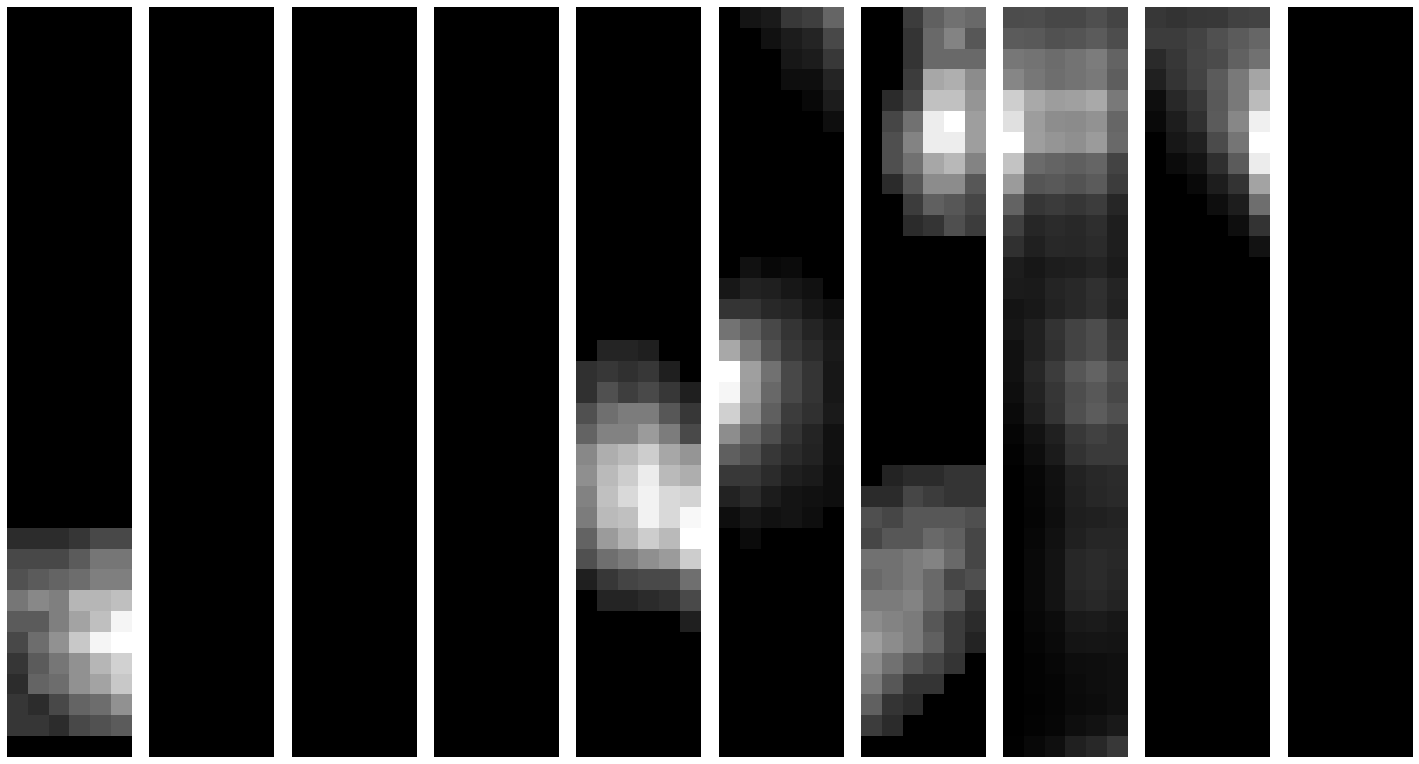

38/38 - 9s - loss: 1.5037 - d_loss: 0.5230 - g_loss: 0.9807 - 9s/epoch - 239ms/step
Epoch 127/200


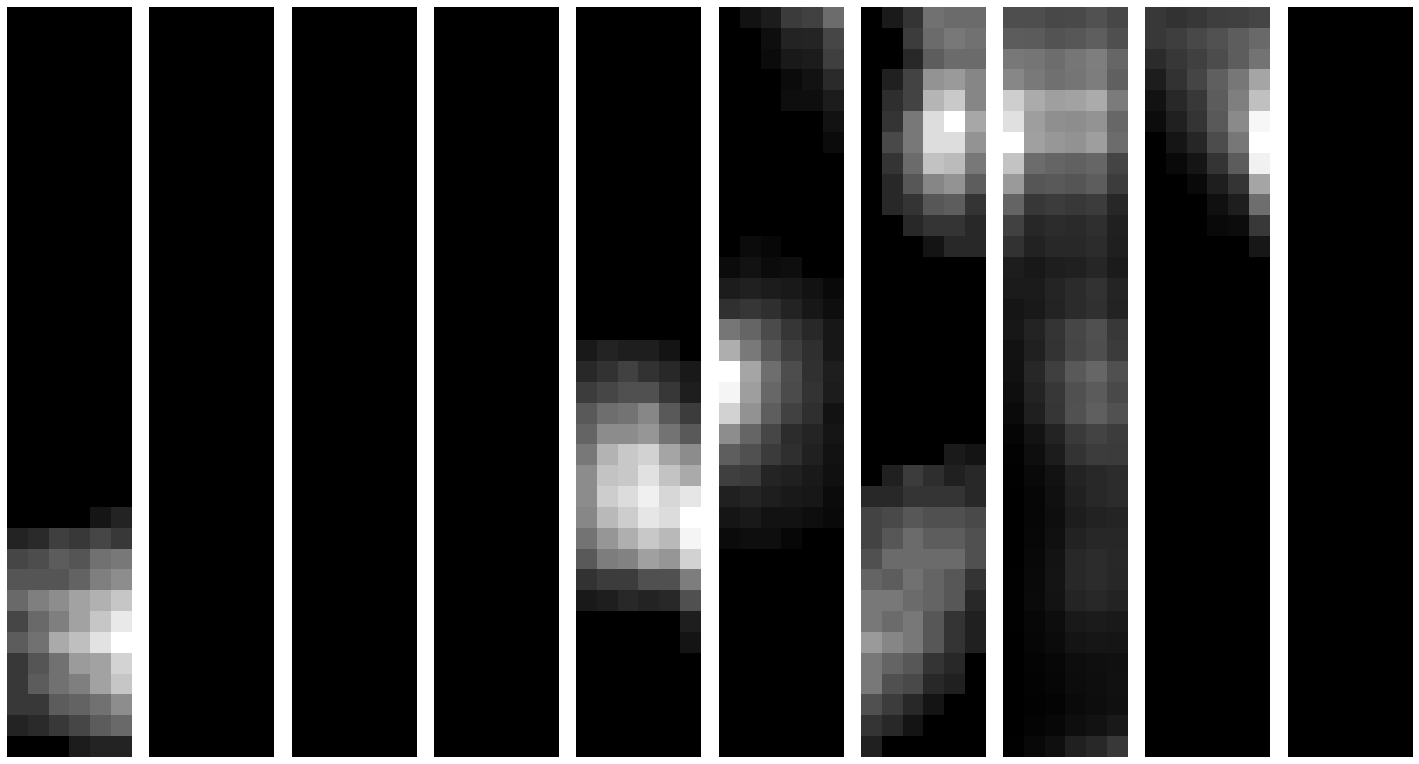

38/38 - 9s - loss: 1.5085 - d_loss: 0.5161 - g_loss: 0.9924 - 9s/epoch - 238ms/step
Epoch 128/200


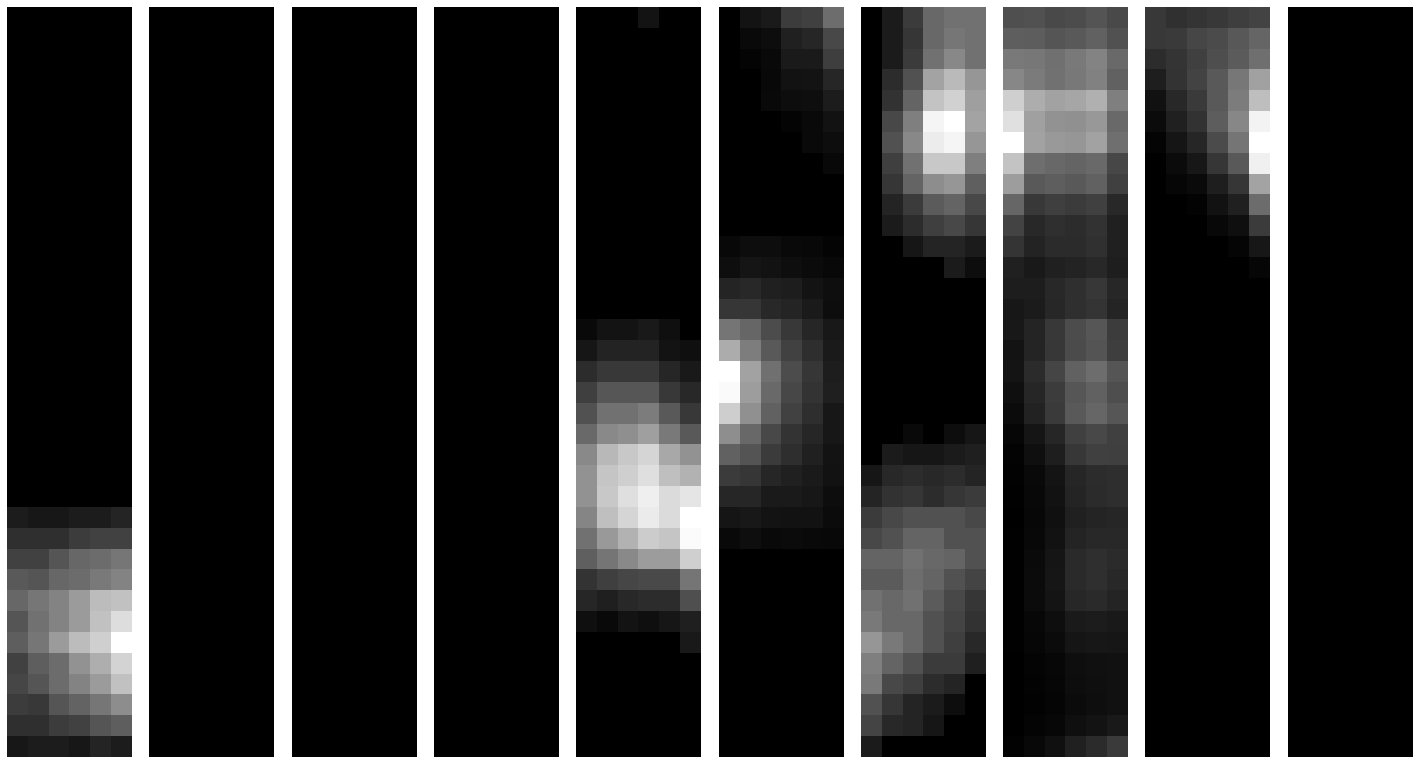

38/38 - 9s - loss: 1.5093 - d_loss: 0.5114 - g_loss: 0.9978 - 9s/epoch - 245ms/step
Epoch 129/200


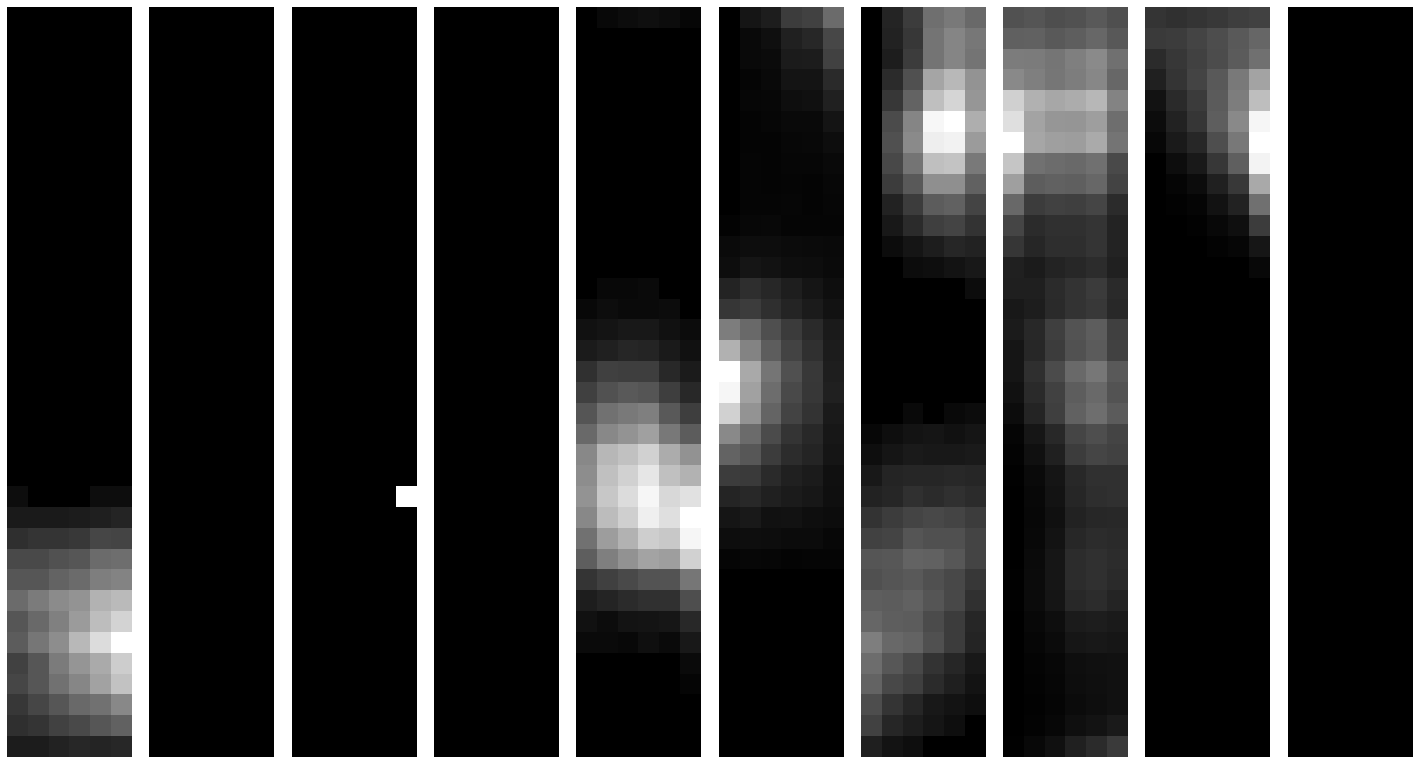

38/38 - 9s - loss: 1.5081 - d_loss: 0.5079 - g_loss: 1.0002 - 9s/epoch - 238ms/step
Epoch 130/200


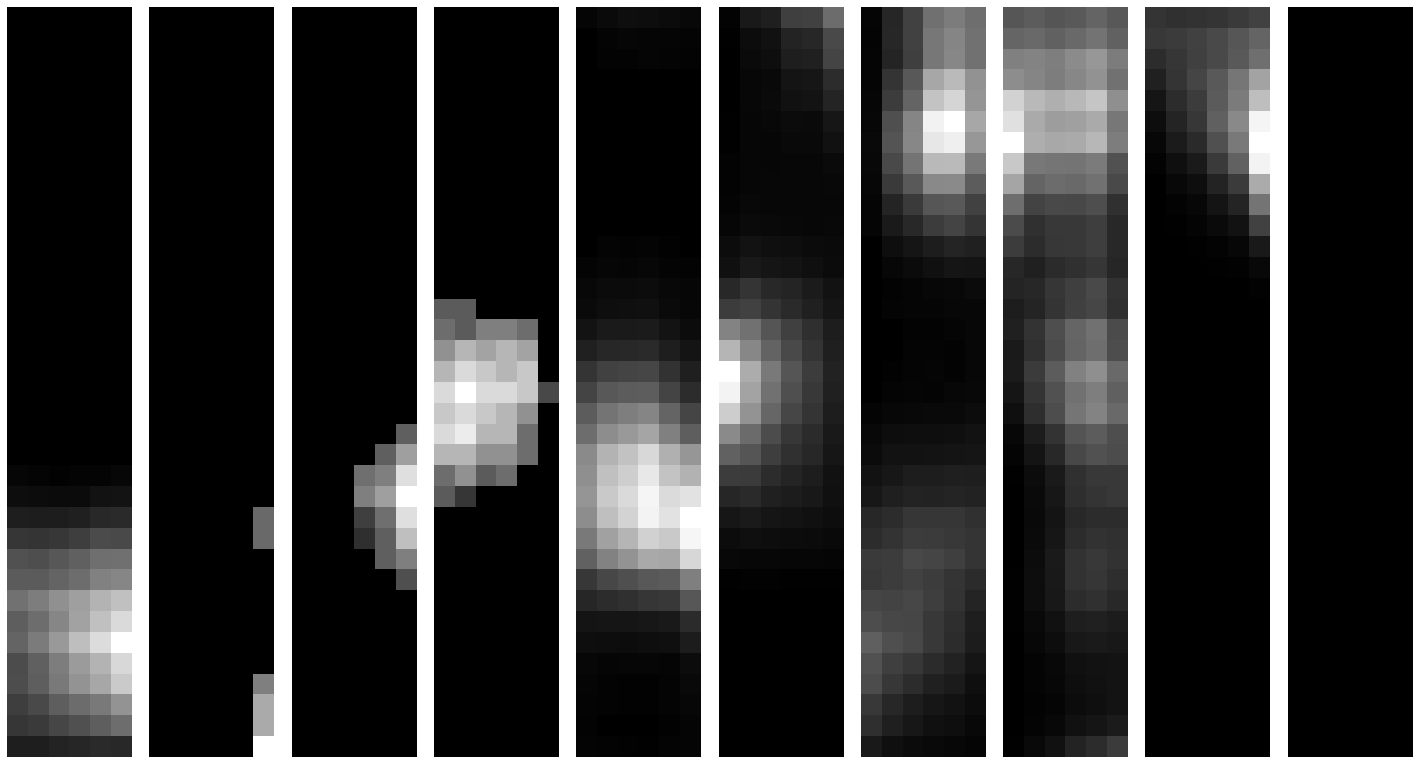

38/38 - 9s - loss: 1.5136 - d_loss: 0.5061 - g_loss: 1.0075 - 9s/epoch - 239ms/step
Epoch 131/200


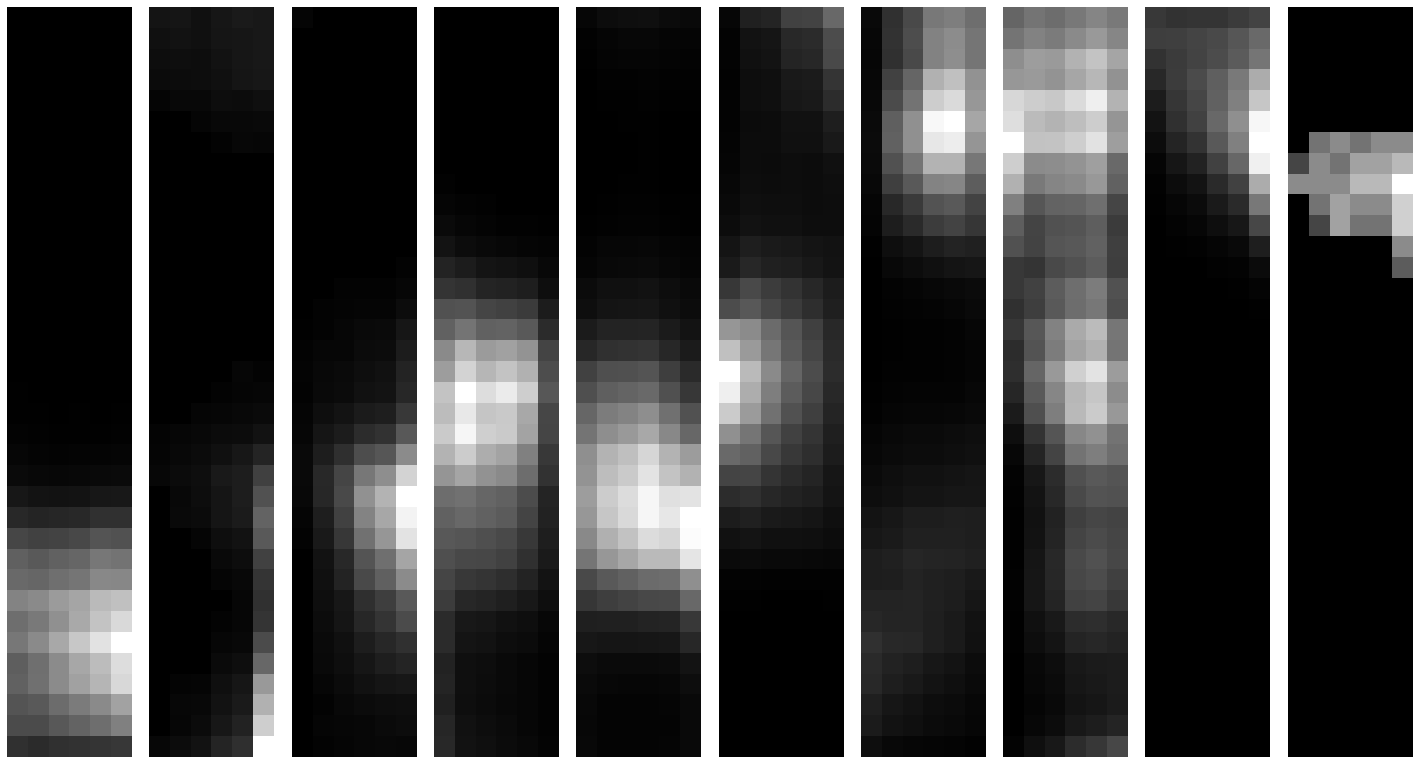

38/38 - 9s - loss: 1.5146 - d_loss: 0.5025 - g_loss: 1.0121 - 9s/epoch - 239ms/step
Epoch 132/200


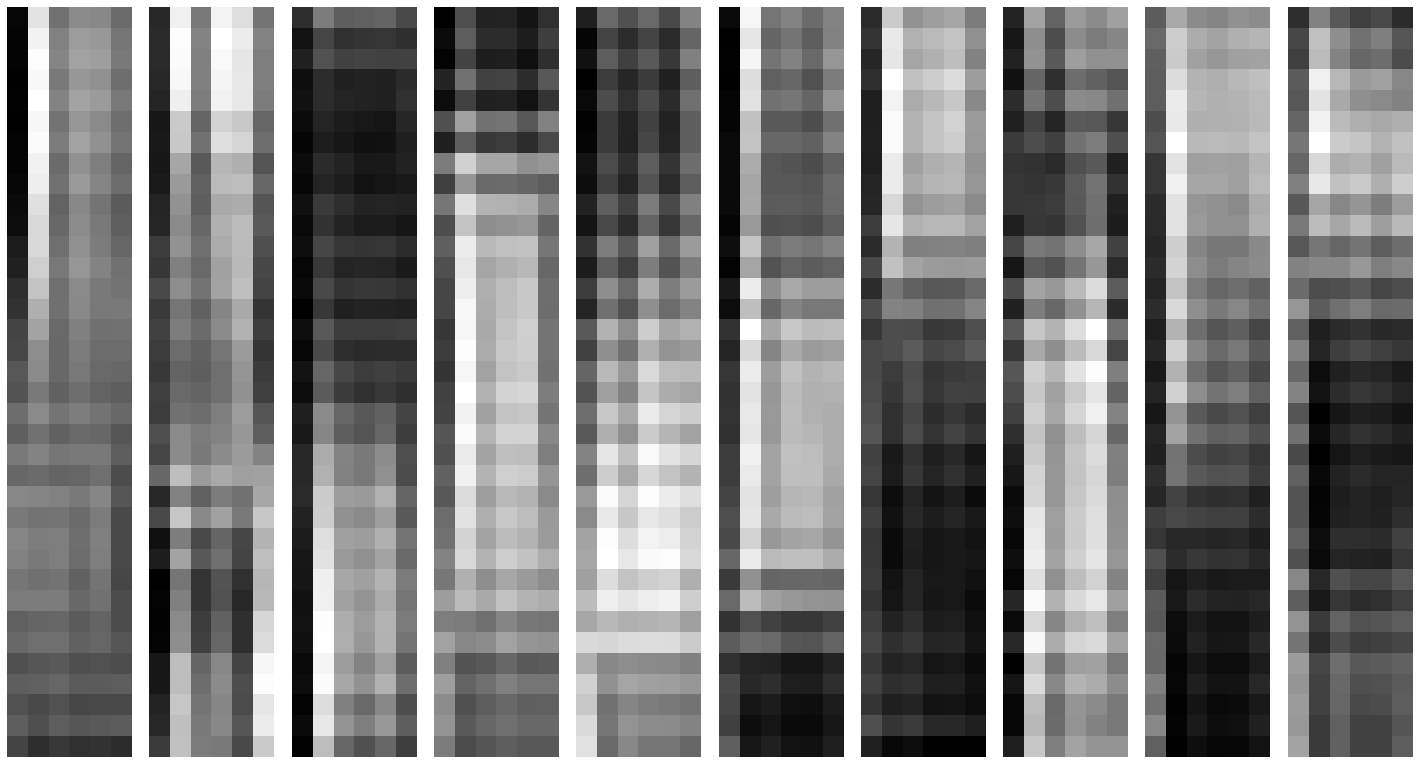

38/38 - 9s - loss: 2.4471 - d_loss: 1.7443 - g_loss: 0.7028 - 9s/epoch - 238ms/step
Epoch 133/200


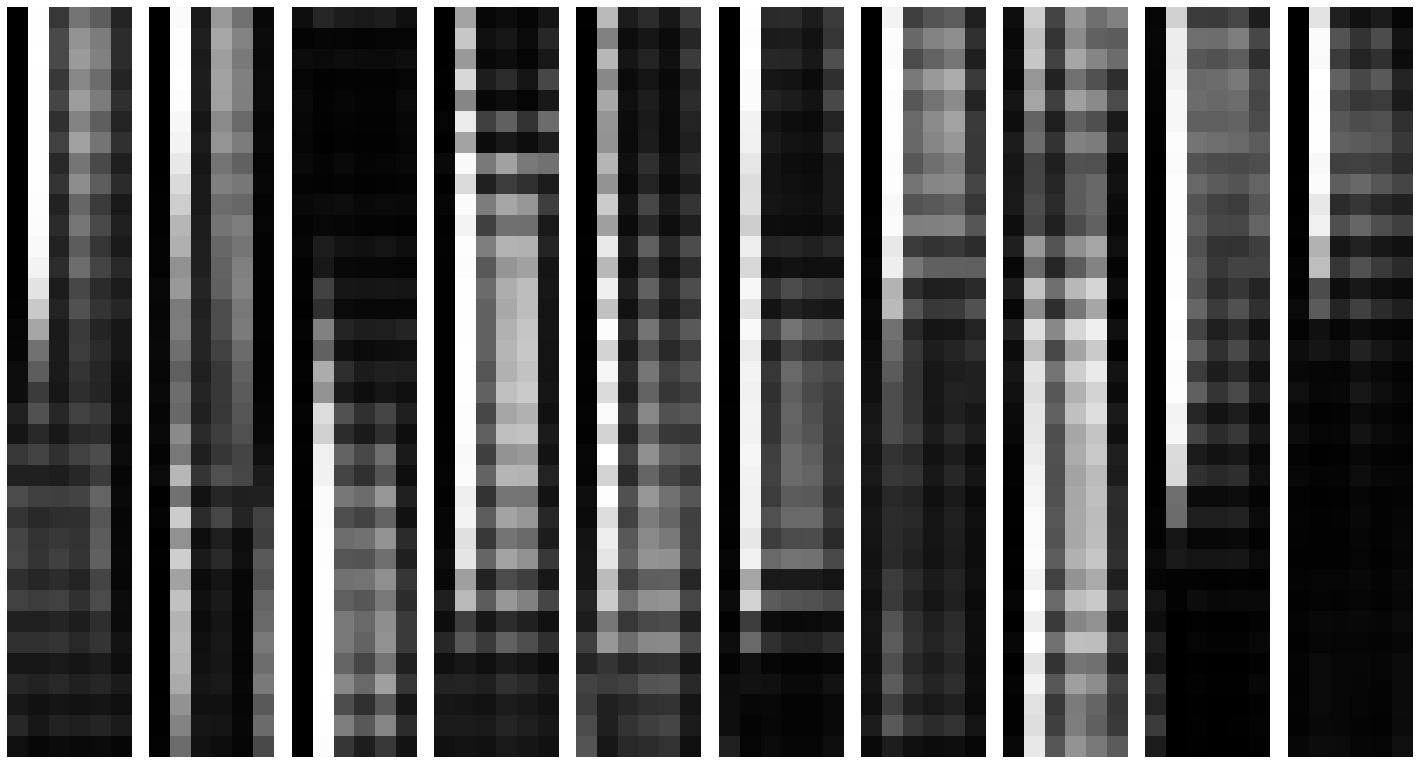

38/38 - 9s - loss: 6.2626 - d_loss: 6.1938 - g_loss: 0.0688 - 9s/epoch - 240ms/step
Epoch 134/200


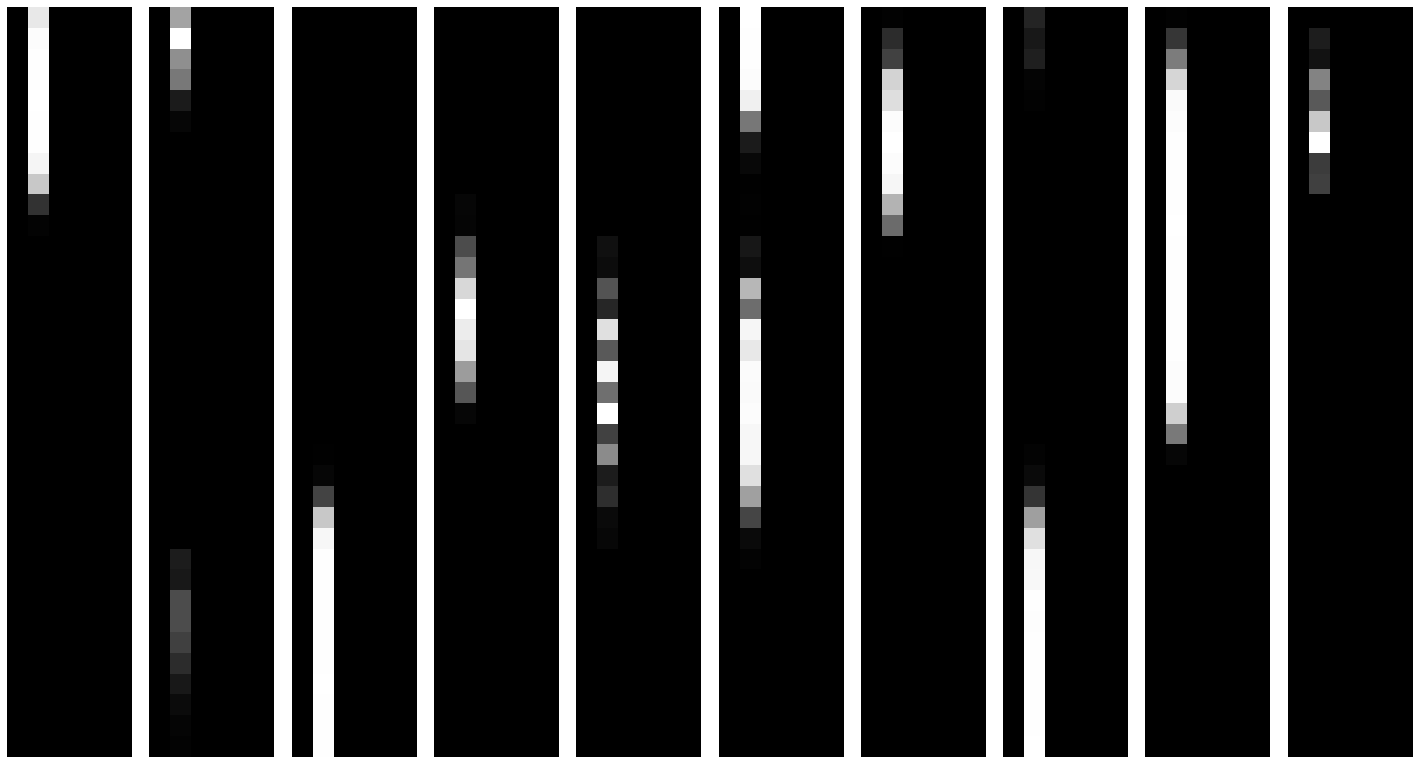

38/38 - 9s - loss: 3.1061 - d_loss: 2.1955 - g_loss: 0.9106 - 9s/epoch - 244ms/step
Epoch 135/200


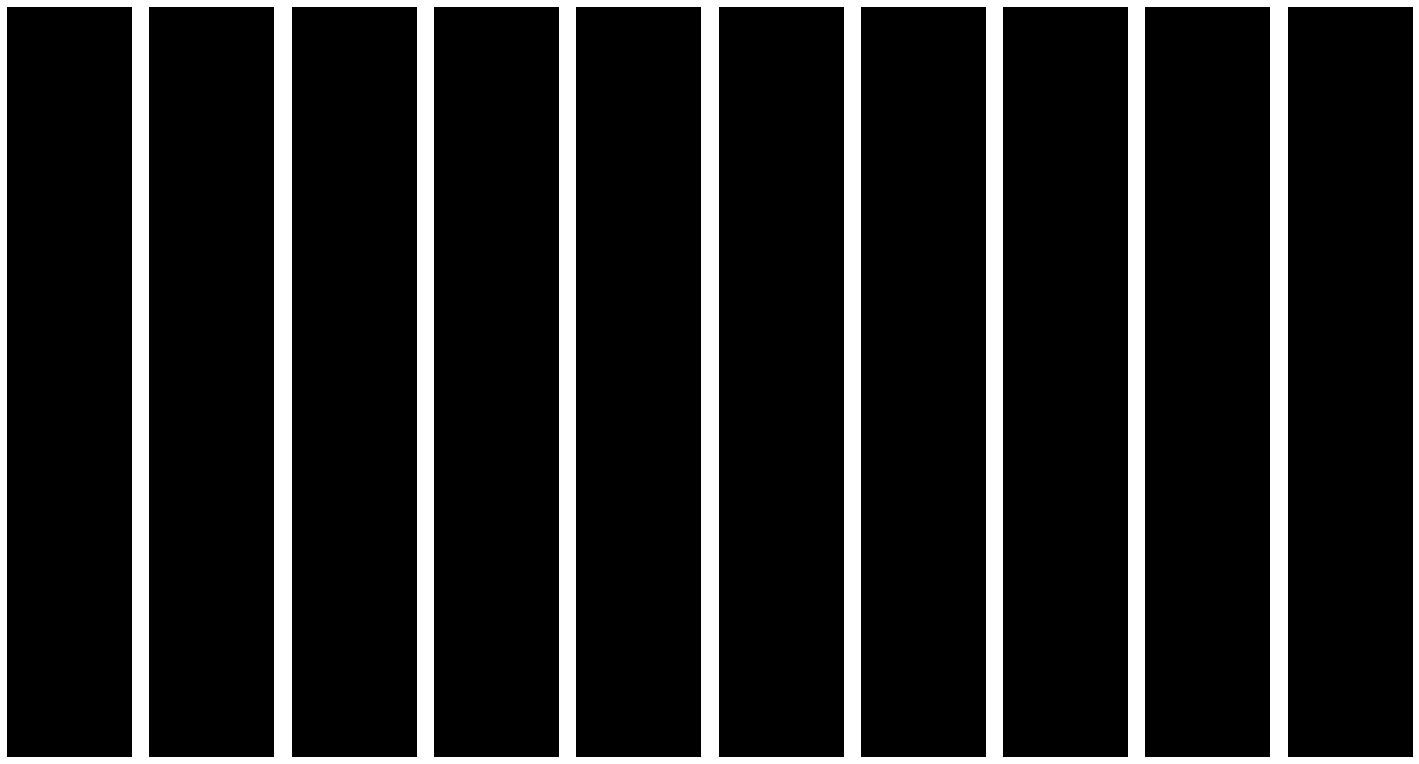

38/38 - 9s - loss: 1.8054 - d_loss: 0.9246 - g_loss: 0.8808 - 9s/epoch - 237ms/step
Epoch 136/200


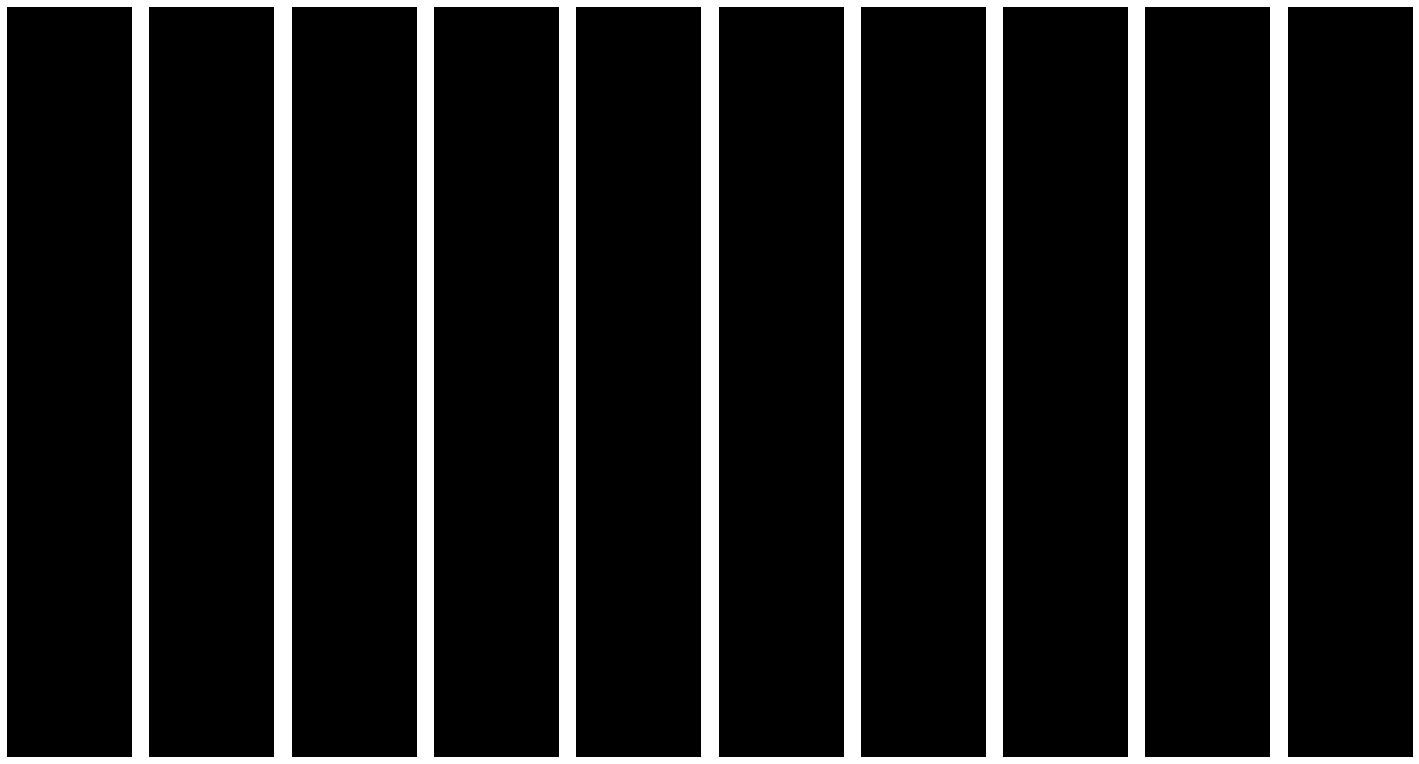

38/38 - 9s - loss: 1.5789 - d_loss: 0.8289 - g_loss: 0.7500 - 9s/epoch - 236ms/step
Epoch 137/200


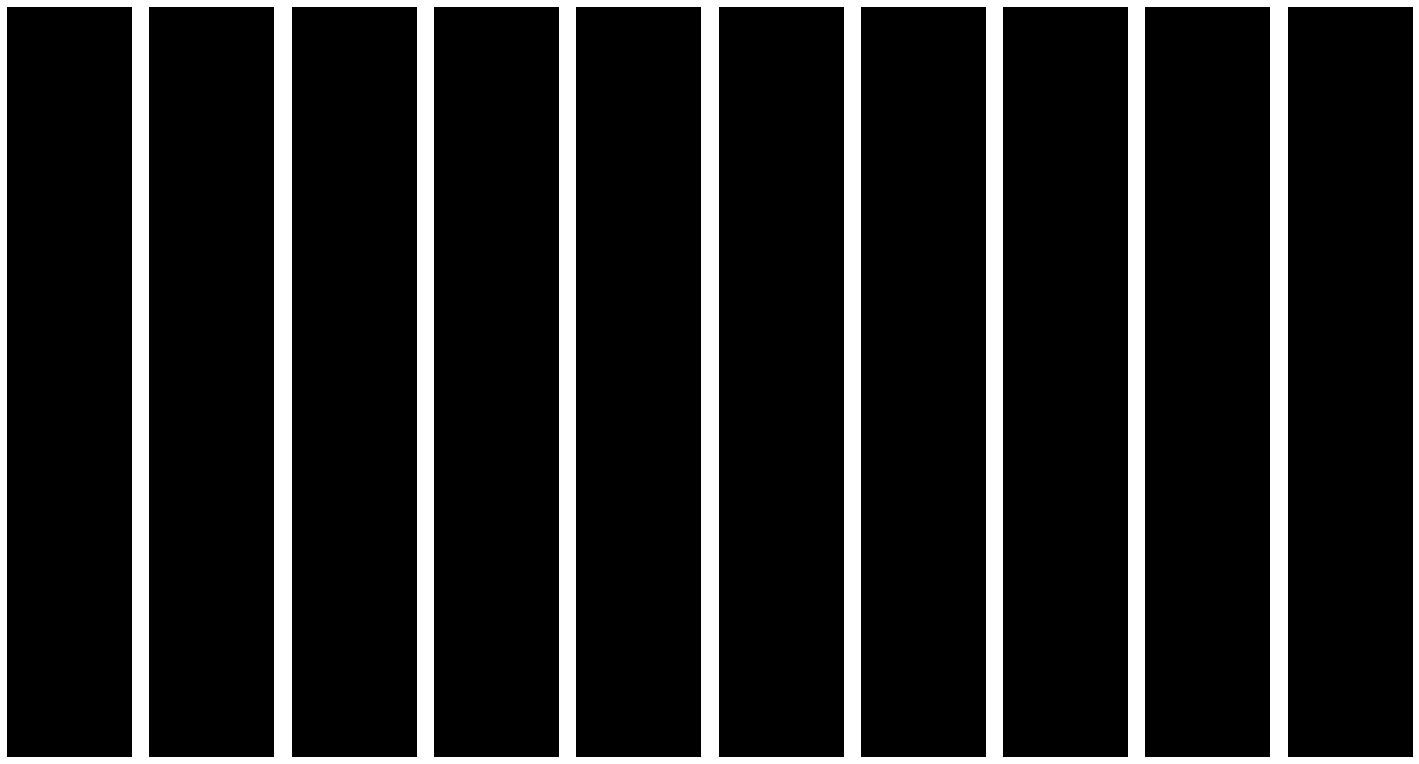

38/38 - 9s - loss: 1.5508 - d_loss: 0.7963 - g_loss: 0.7545 - 9s/epoch - 236ms/step
Epoch 138/200


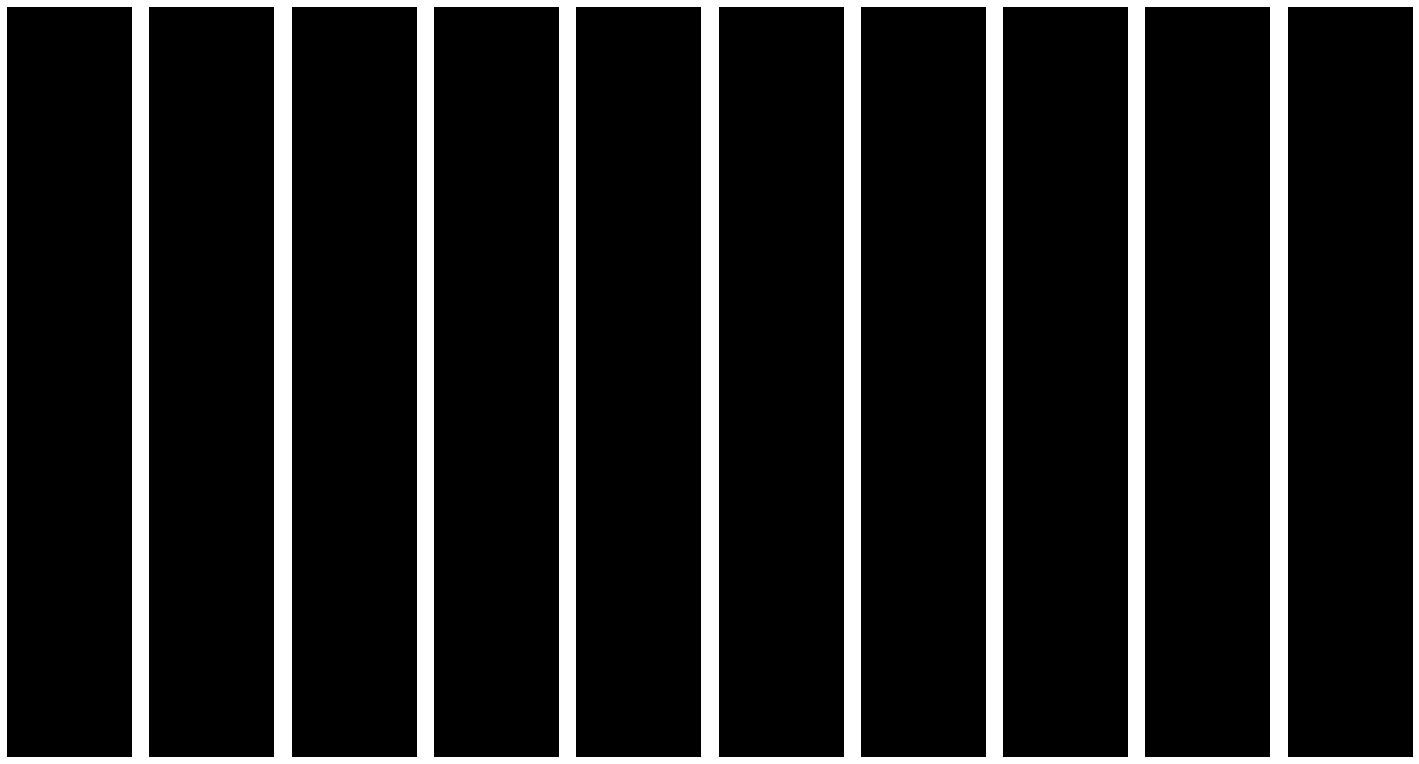

38/38 - 9s - loss: 1.5273 - d_loss: 0.7764 - g_loss: 0.7509 - 9s/epoch - 238ms/step
Epoch 139/200


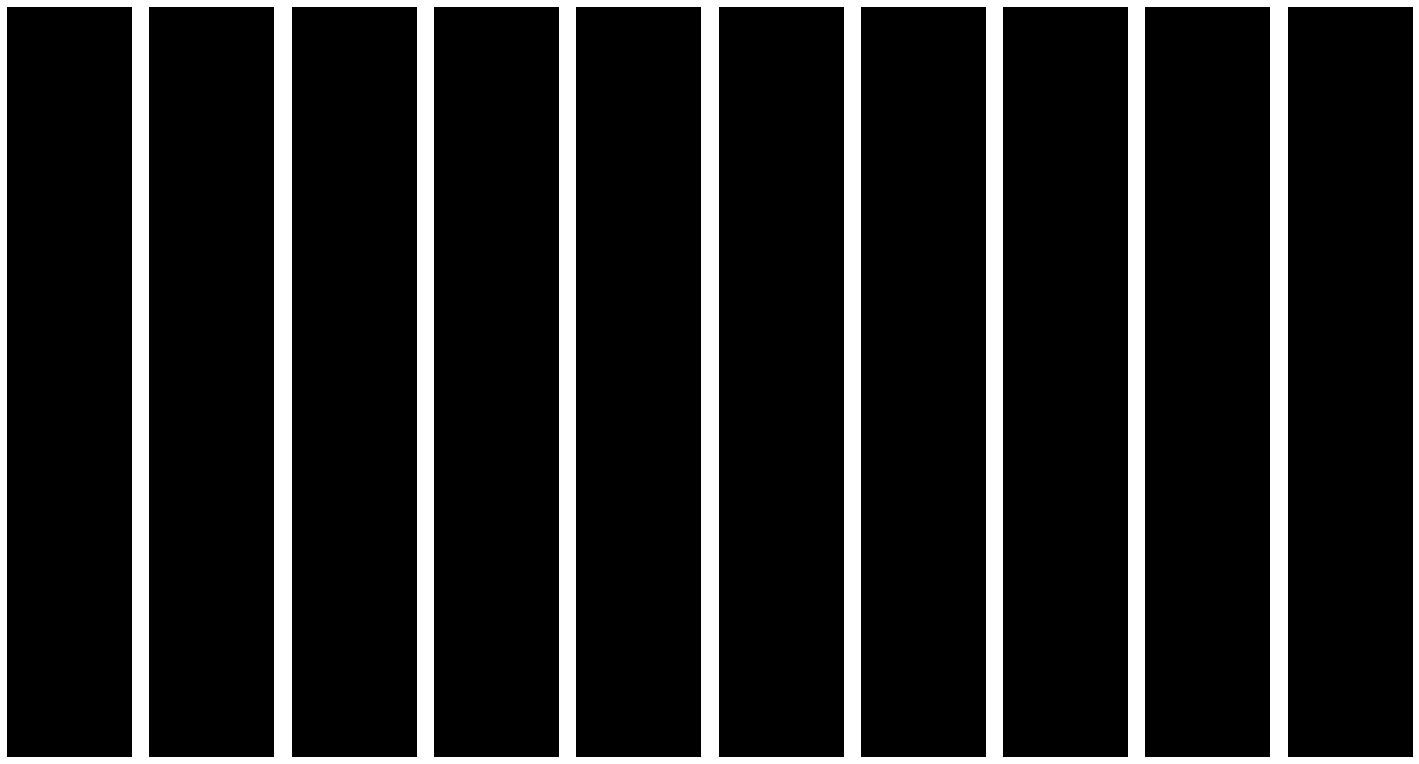

38/38 - 9s - loss: 1.5097 - d_loss: 0.7625 - g_loss: 0.7472 - 9s/epoch - 237ms/step
Epoch 140/200


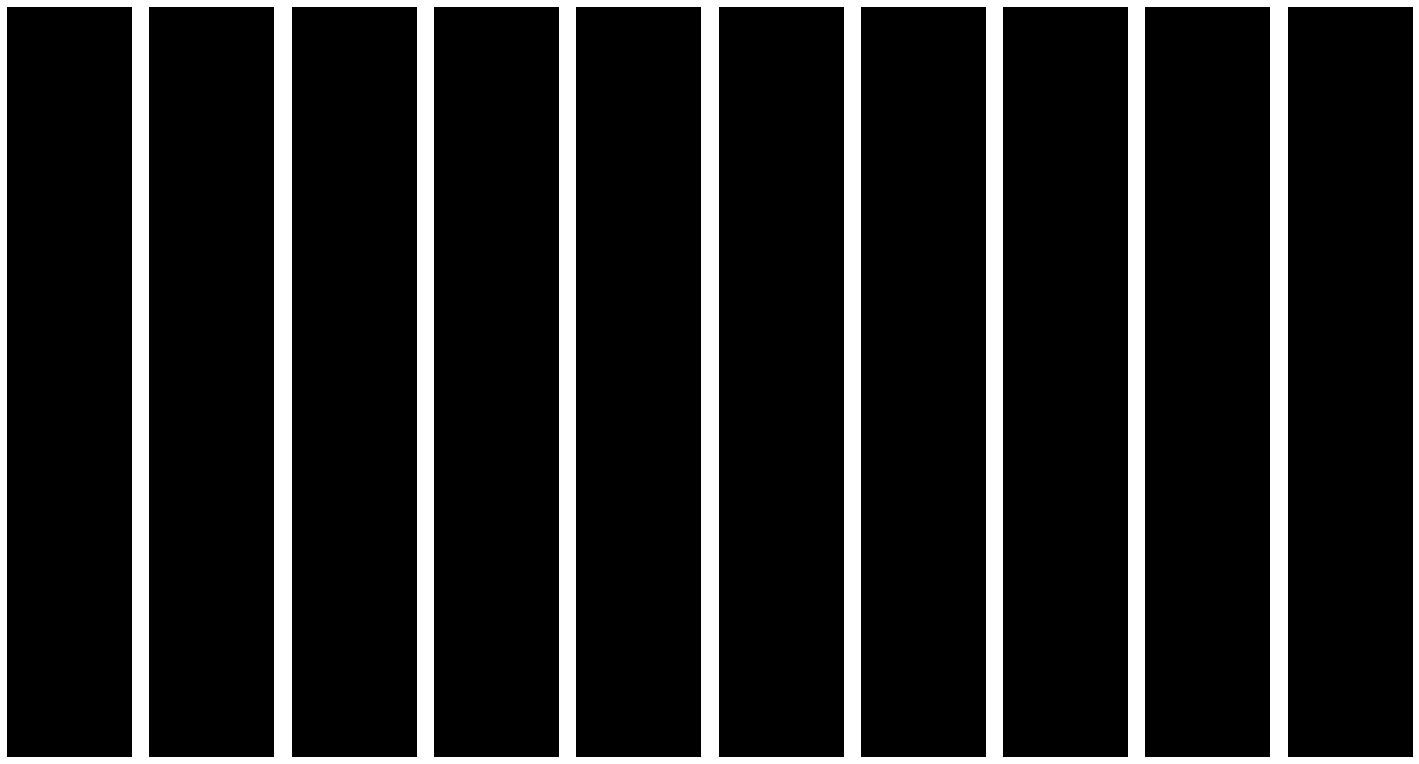

38/38 - 9s - loss: 1.5040 - d_loss: 0.7515 - g_loss: 0.7525 - 9s/epoch - 242ms/step
Epoch 141/200


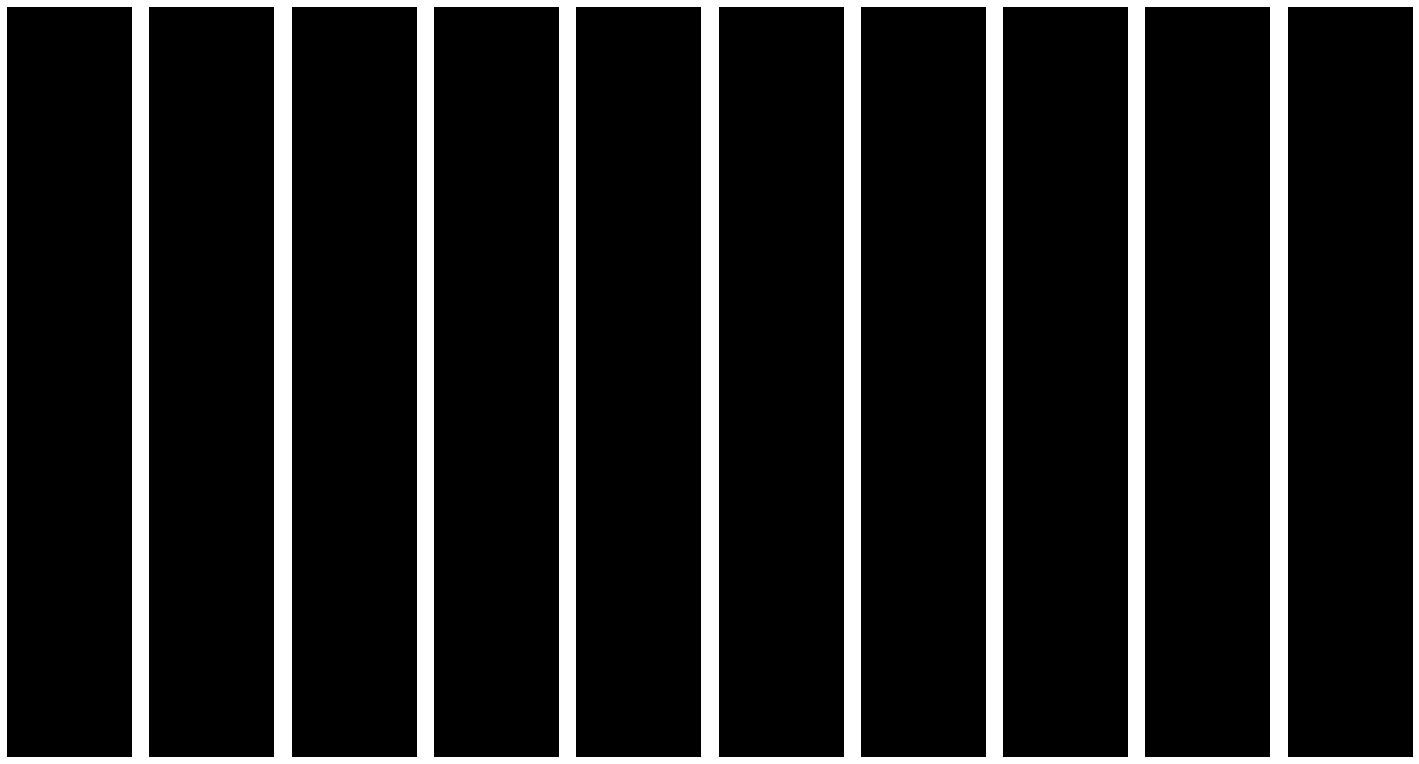

38/38 - 9s - loss: 1.4891 - d_loss: 0.7425 - g_loss: 0.7465 - 9s/epoch - 238ms/step
Epoch 142/200


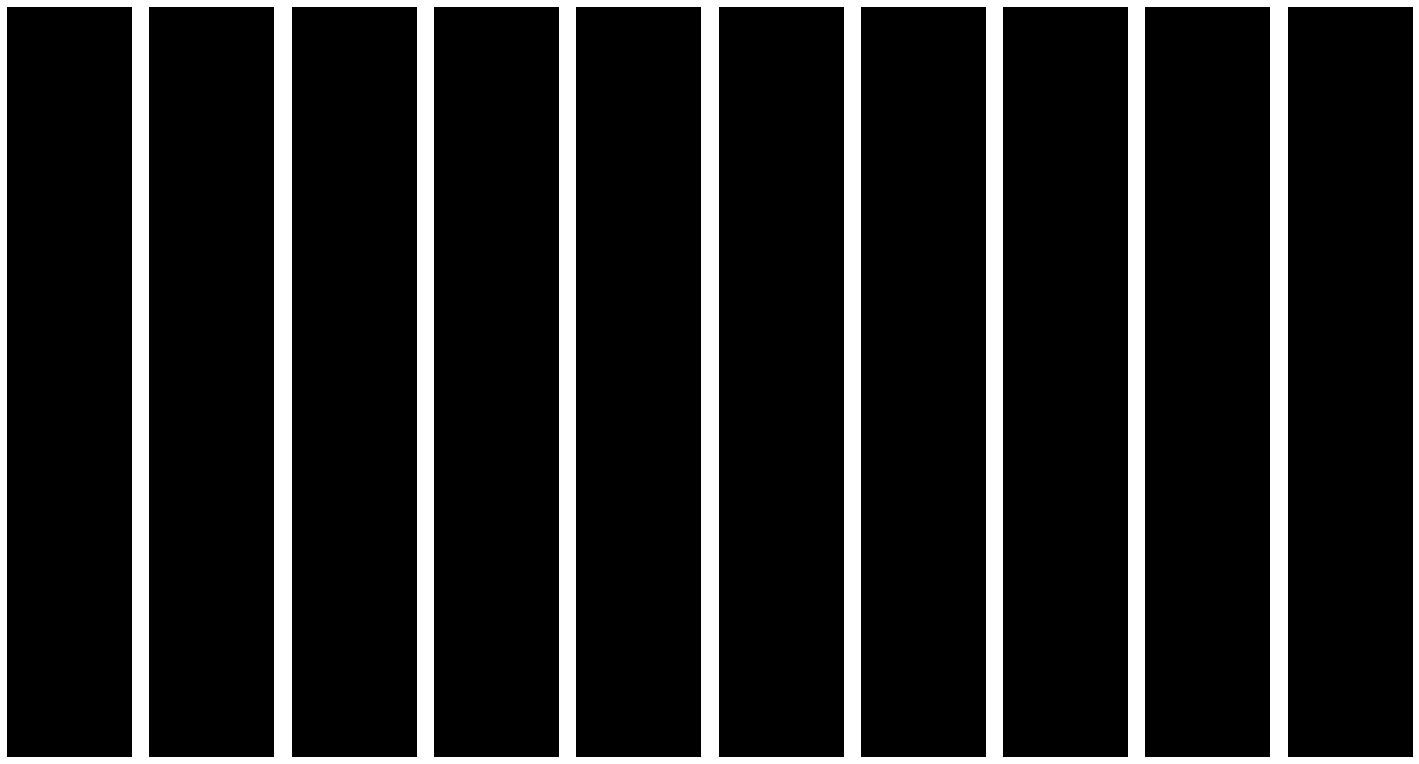

38/38 - 9s - loss: 1.4842 - d_loss: 0.7359 - g_loss: 0.7483 - 9s/epoch - 238ms/step
Epoch 143/200


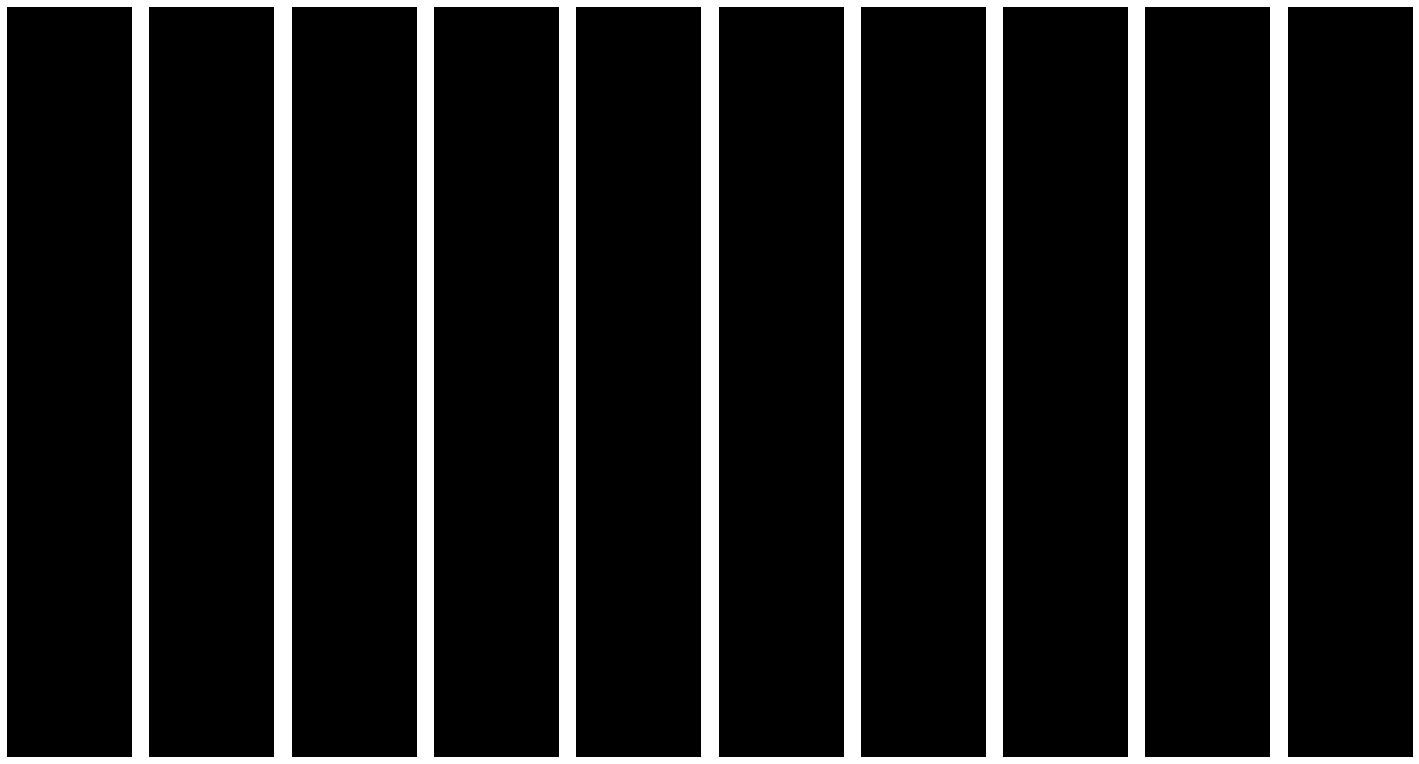

38/38 - 9s - loss: 1.4802 - d_loss: 0.7296 - g_loss: 0.7506 - 9s/epoch - 238ms/step
Epoch 144/200


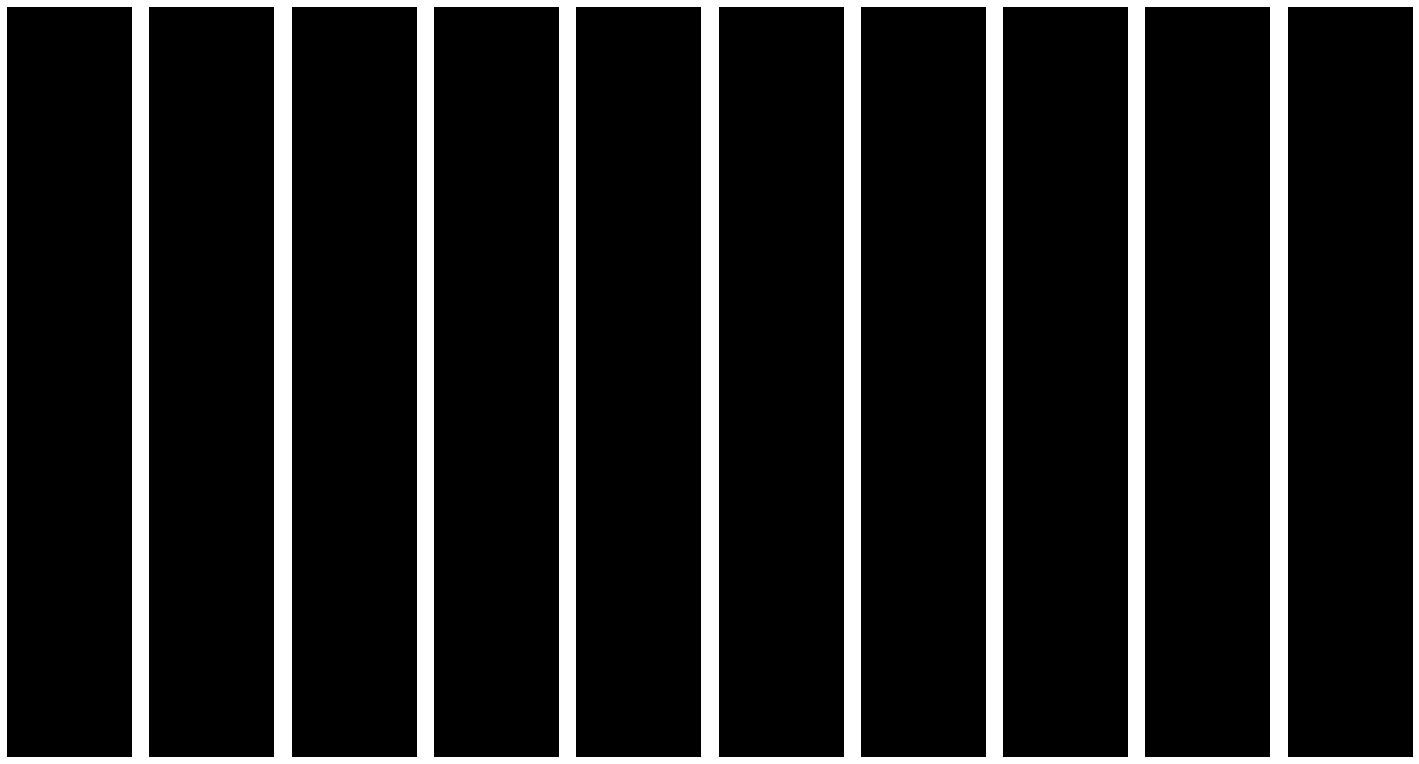

38/38 - 9s - loss: 1.4706 - d_loss: 0.7243 - g_loss: 0.7463 - 9s/epoch - 238ms/step
Epoch 145/200


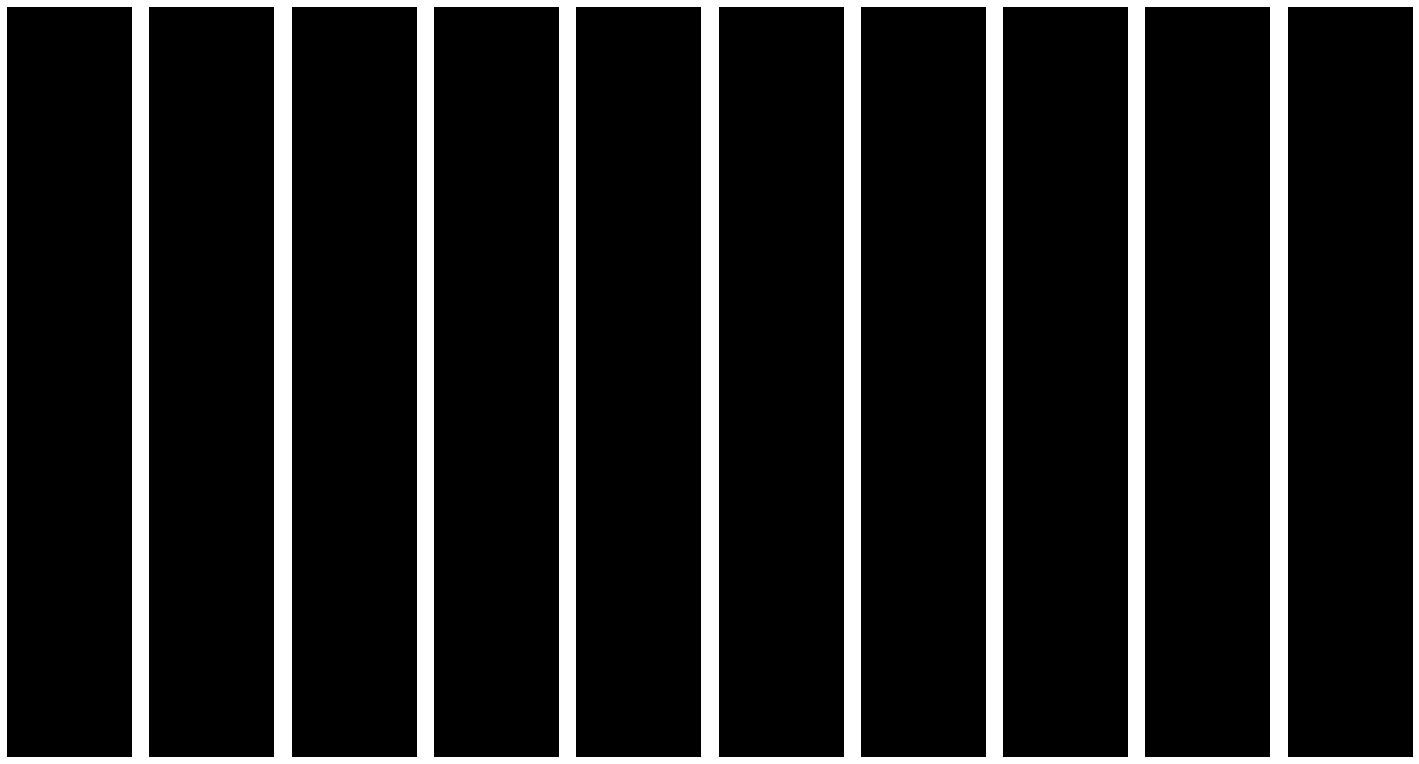

38/38 - 9s - loss: 1.4682 - d_loss: 0.7194 - g_loss: 0.7489 - 9s/epoch - 243ms/step
Epoch 146/200


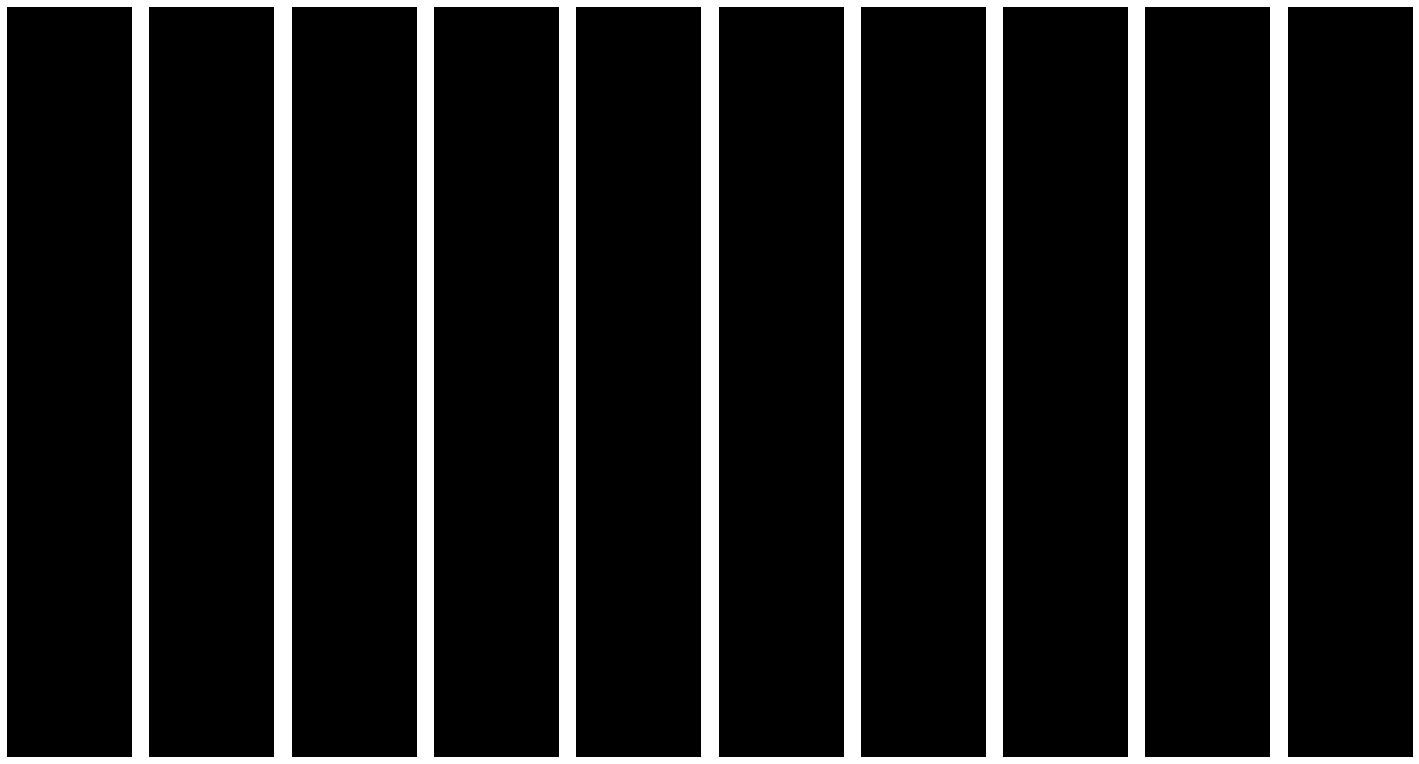

38/38 - 9s - loss: 1.4619 - d_loss: 0.7154 - g_loss: 0.7465 - 9s/epoch - 238ms/step
Epoch 147/200


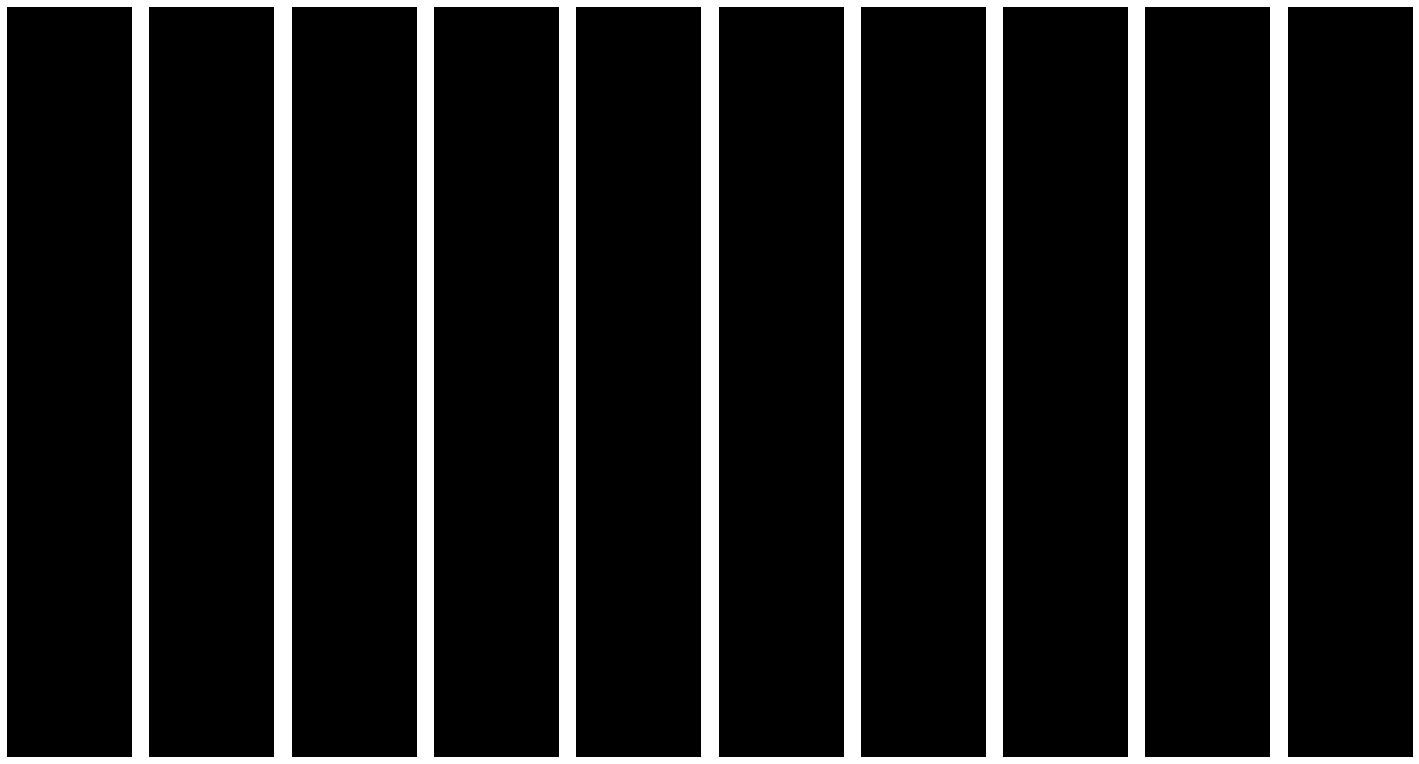

38/38 - 9s - loss: 1.4624 - d_loss: 0.7114 - g_loss: 0.7511 - 9s/epoch - 238ms/step
Epoch 148/200


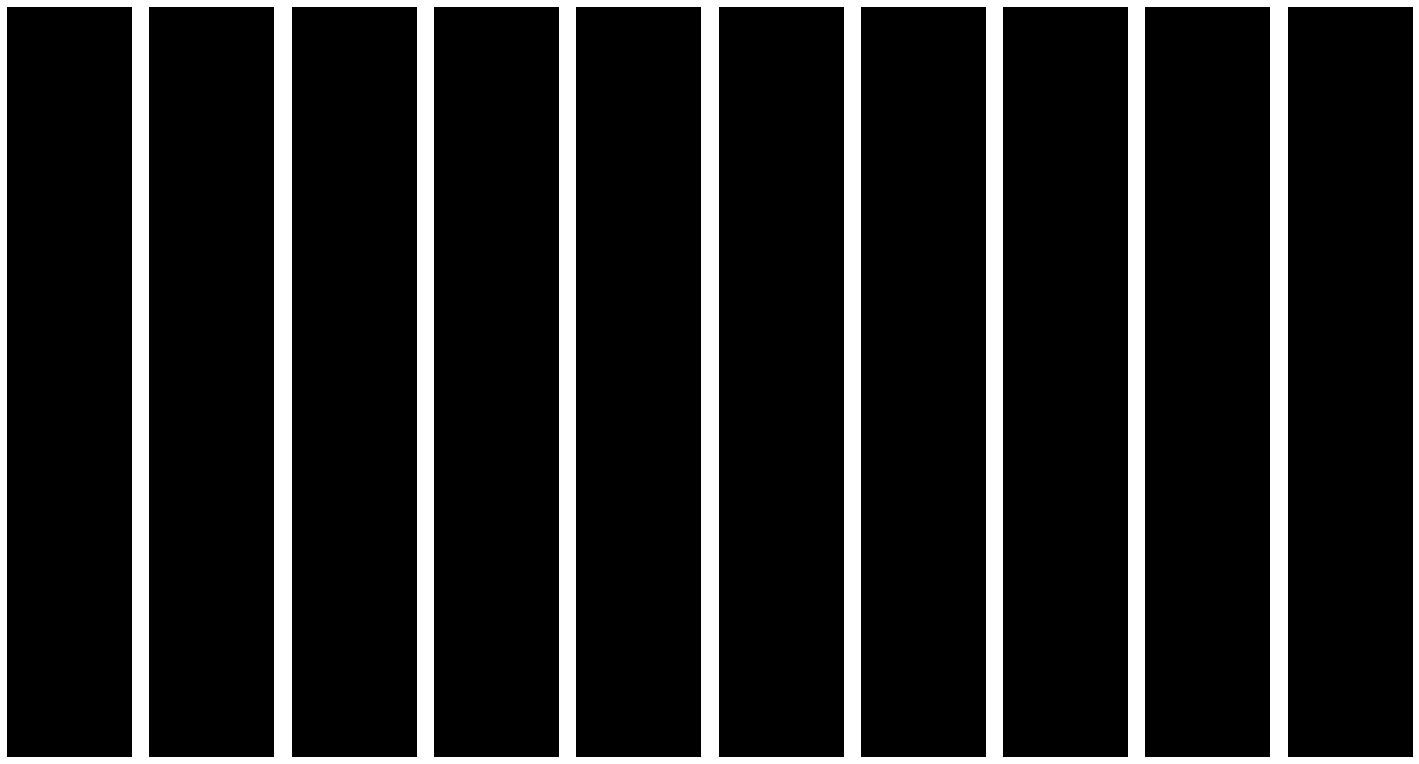

38/38 - 9s - loss: 1.4535 - d_loss: 0.7080 - g_loss: 0.7455 - 9s/epoch - 238ms/step
Epoch 149/200


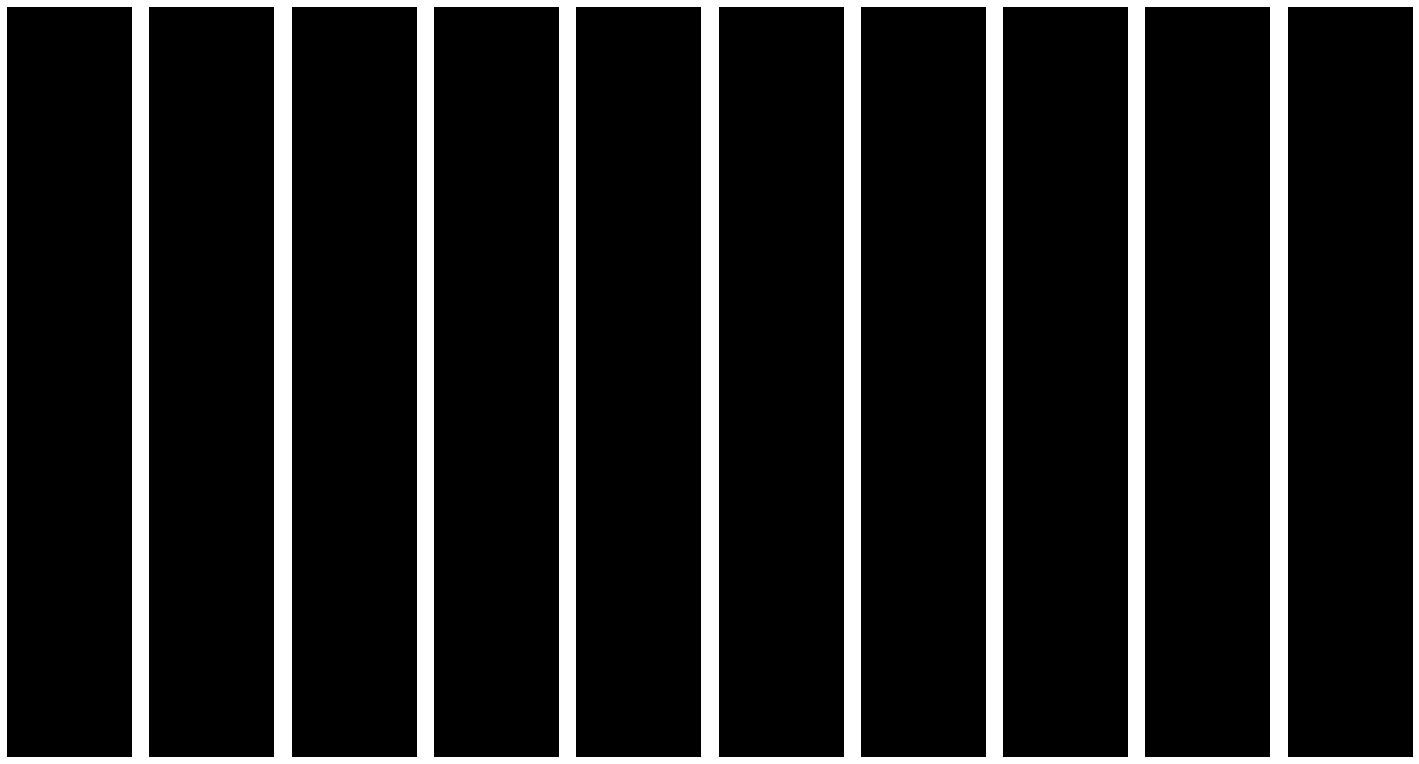

38/38 - 9s - loss: 1.4516 - d_loss: 0.7046 - g_loss: 0.7470 - 9s/epoch - 238ms/step
Epoch 150/200


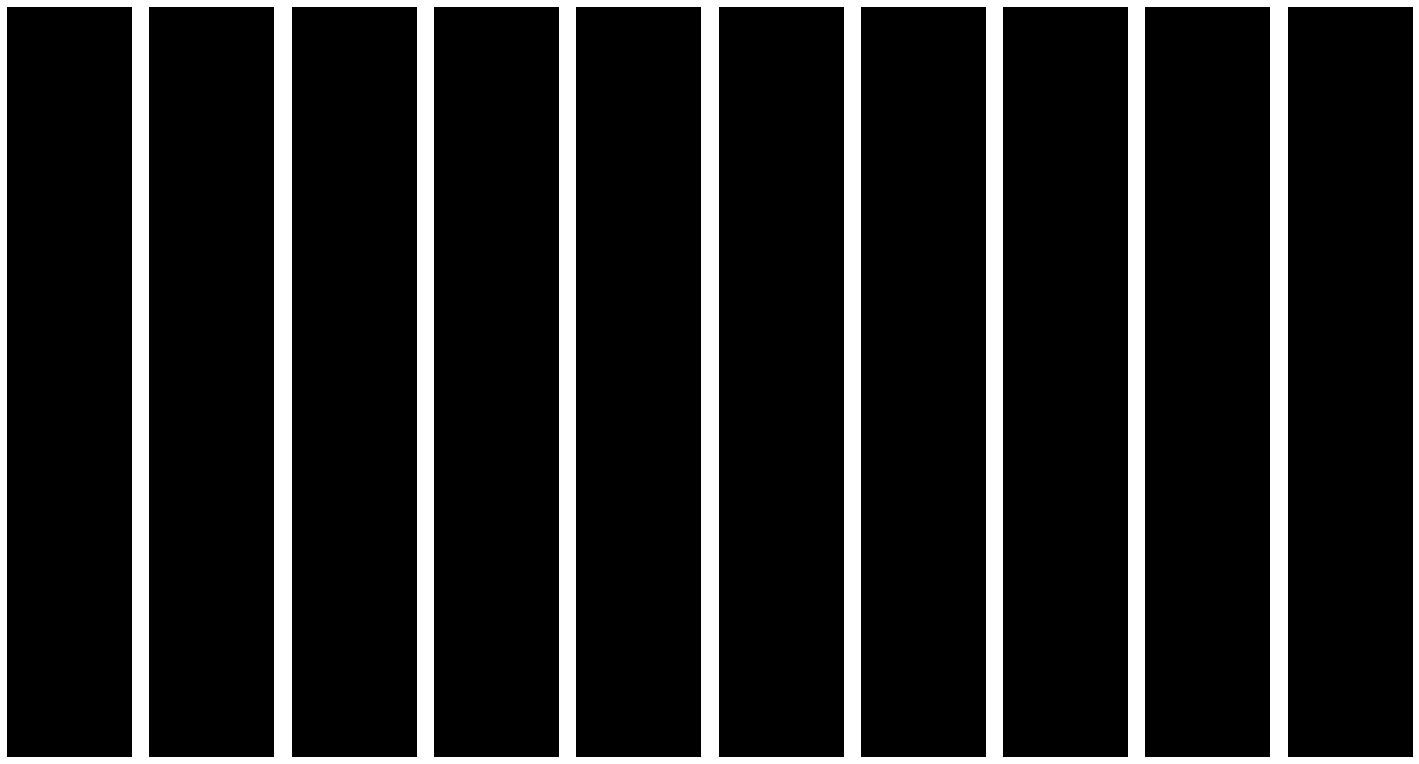

38/38 - 9s - loss: 1.4488 - d_loss: 0.7016 - g_loss: 0.7471 - 9s/epoch - 237ms/step
Epoch 151/200


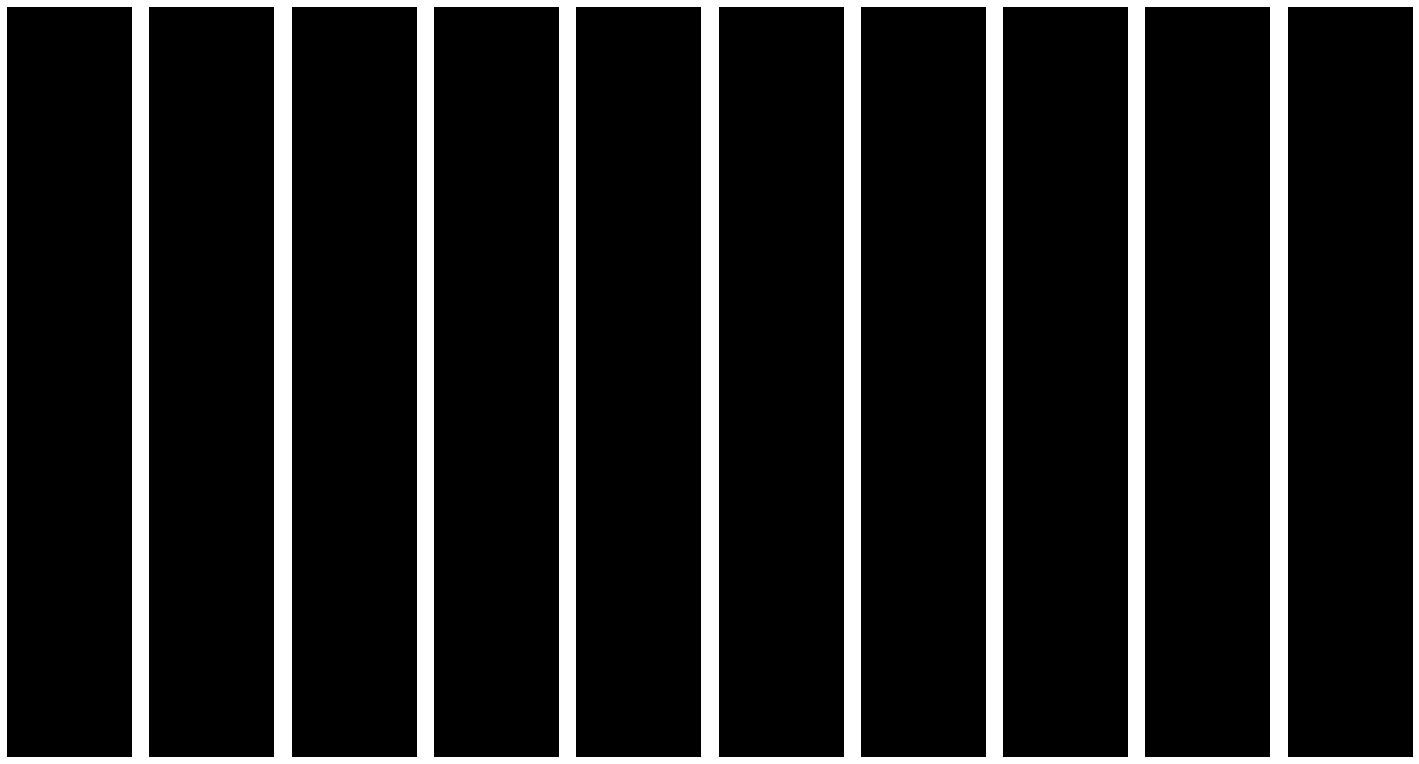

38/38 - 9s - loss: 1.4461 - d_loss: 0.6989 - g_loss: 0.7472 - 9s/epoch - 244ms/step
Epoch 152/200


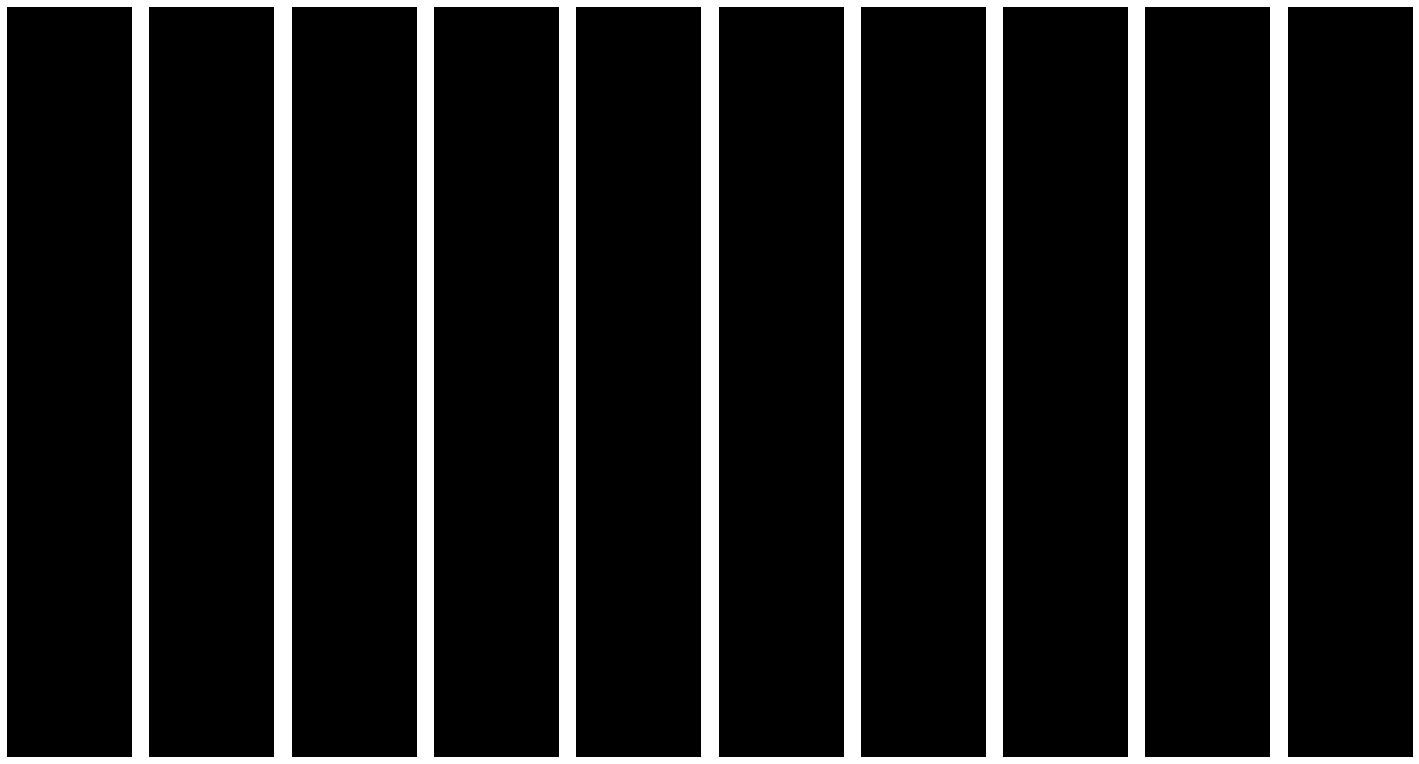

38/38 - 9s - loss: 1.4442 - d_loss: 0.6962 - g_loss: 0.7480 - 9s/epoch - 237ms/step
Epoch 153/200


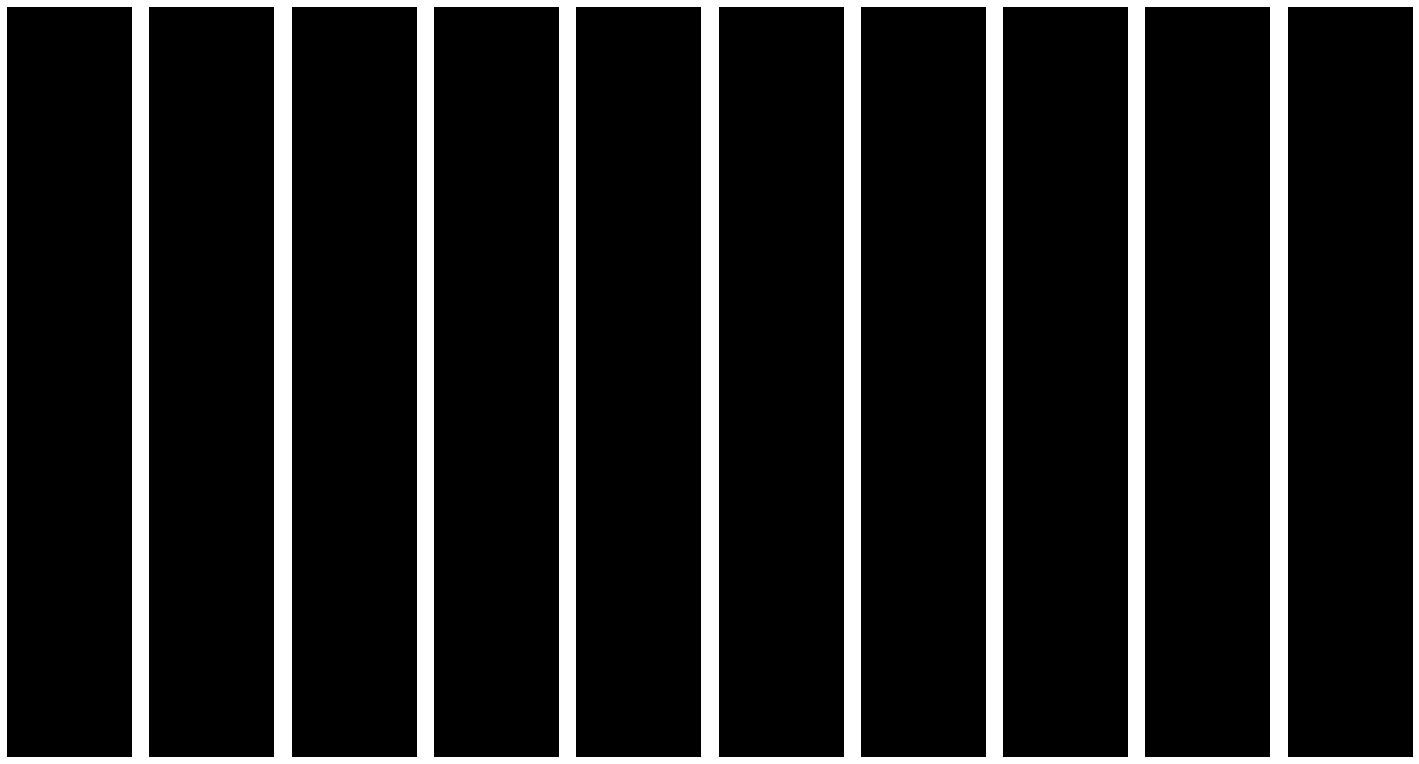

38/38 - 9s - loss: 1.4420 - d_loss: 0.6940 - g_loss: 0.7480 - 9s/epoch - 236ms/step
Epoch 154/200


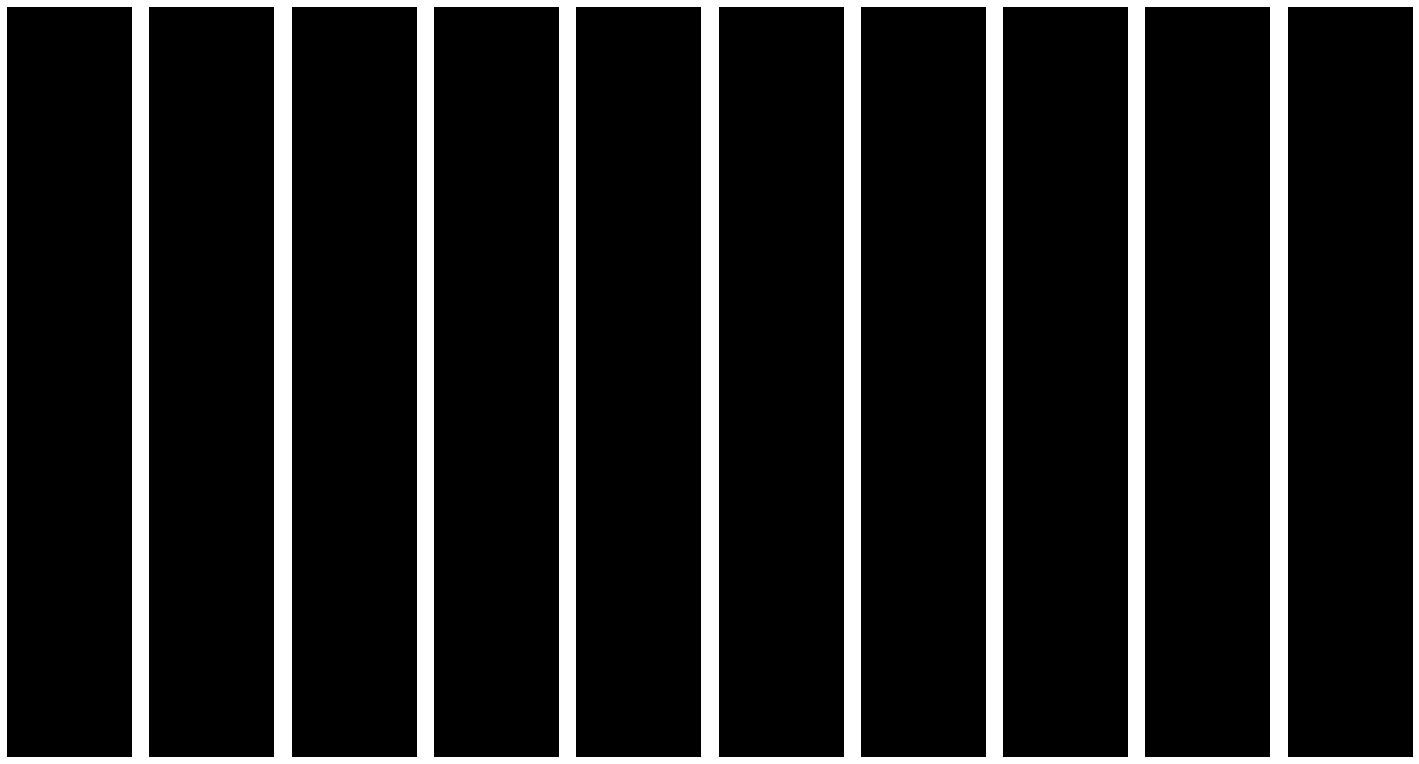

38/38 - 9s - loss: 1.4400 - d_loss: 0.6919 - g_loss: 0.7481 - 9s/epoch - 236ms/step
Epoch 155/200


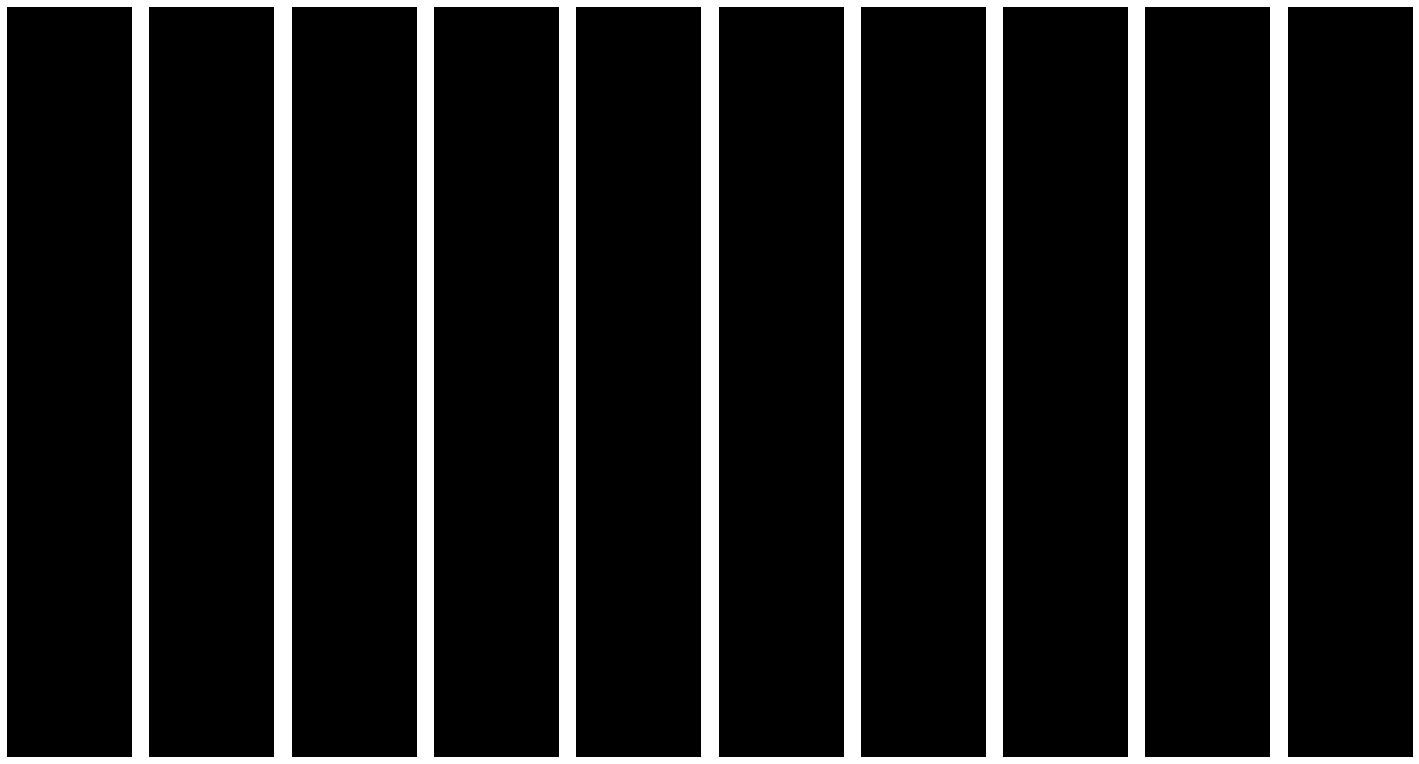

38/38 - 9s - loss: 1.4370 - d_loss: 0.6899 - g_loss: 0.7471 - 9s/epoch - 240ms/step
Epoch 156/200


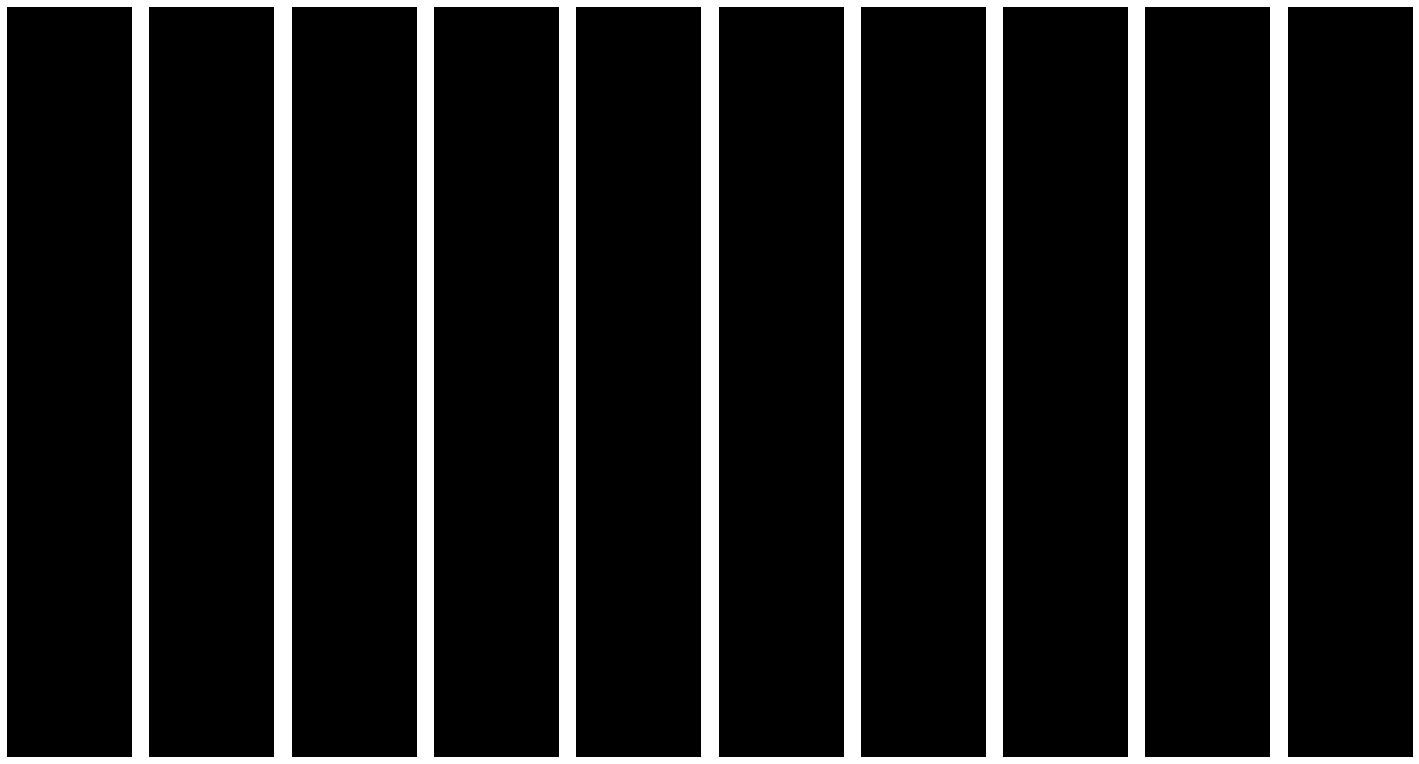

38/38 - 9s - loss: 1.4366 - d_loss: 0.6880 - g_loss: 0.7486 - 9s/epoch - 237ms/step
Epoch 157/200


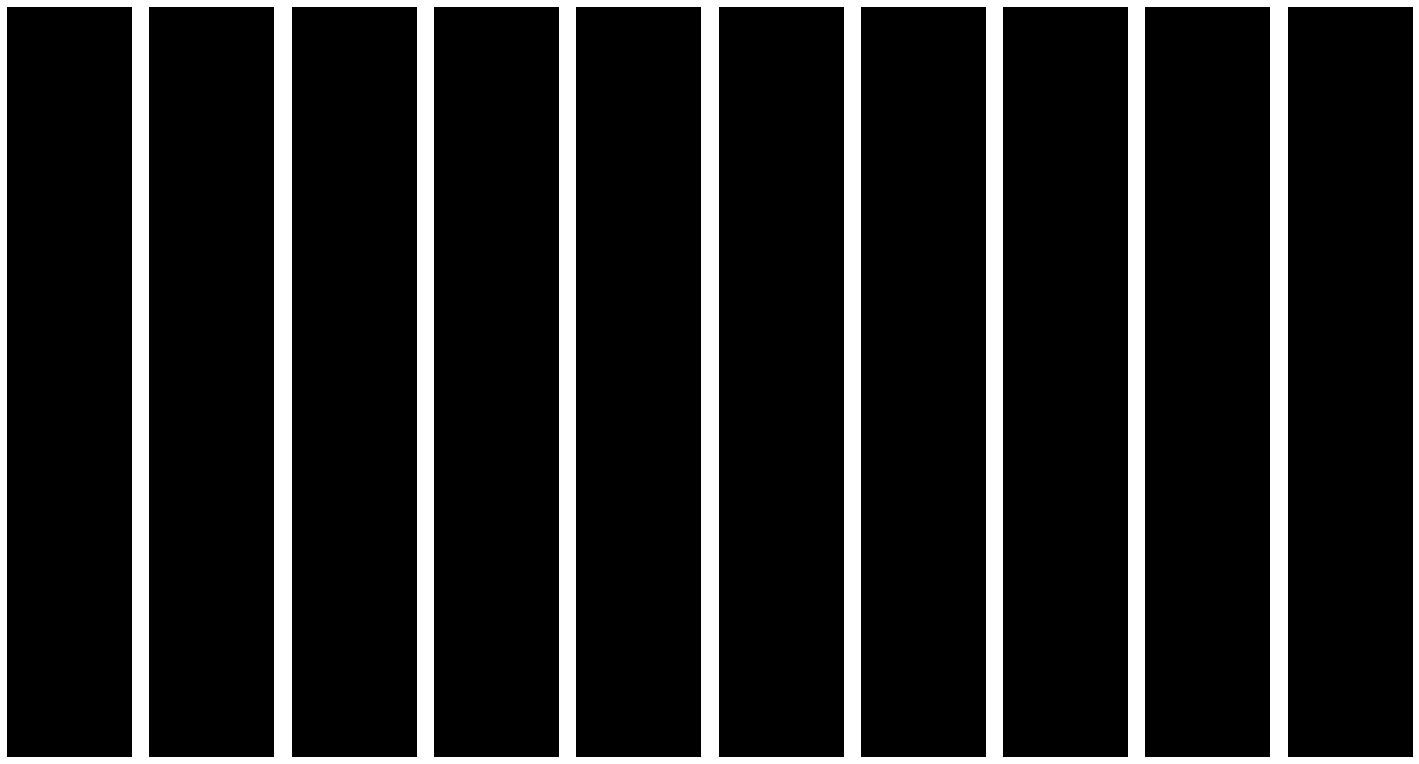

38/38 - 9s - loss: 1.4347 - d_loss: 0.6863 - g_loss: 0.7484 - 9s/epoch - 243ms/step
Epoch 158/200


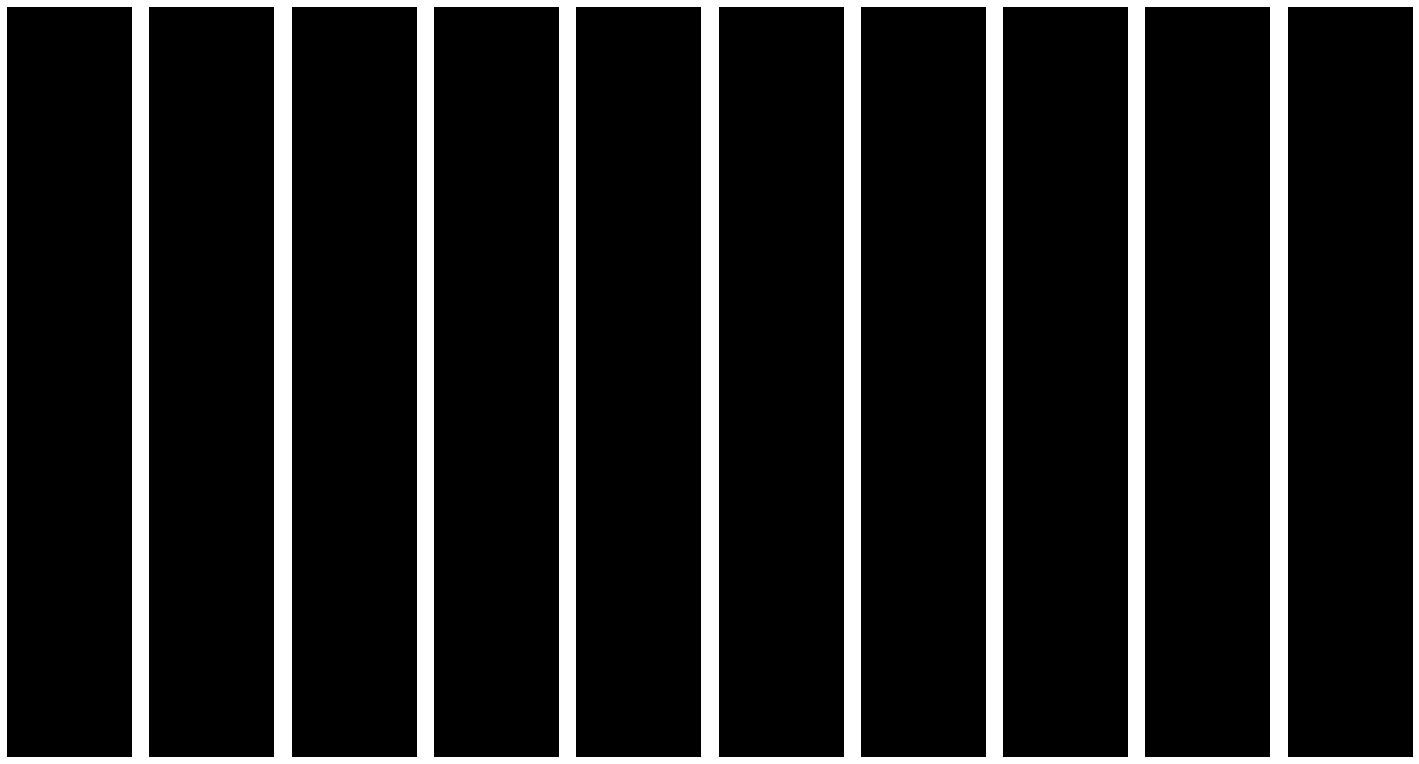

38/38 - 9s - loss: 1.4359 - d_loss: 0.6848 - g_loss: 0.7511 - 9s/epoch - 236ms/step
Epoch 159/200


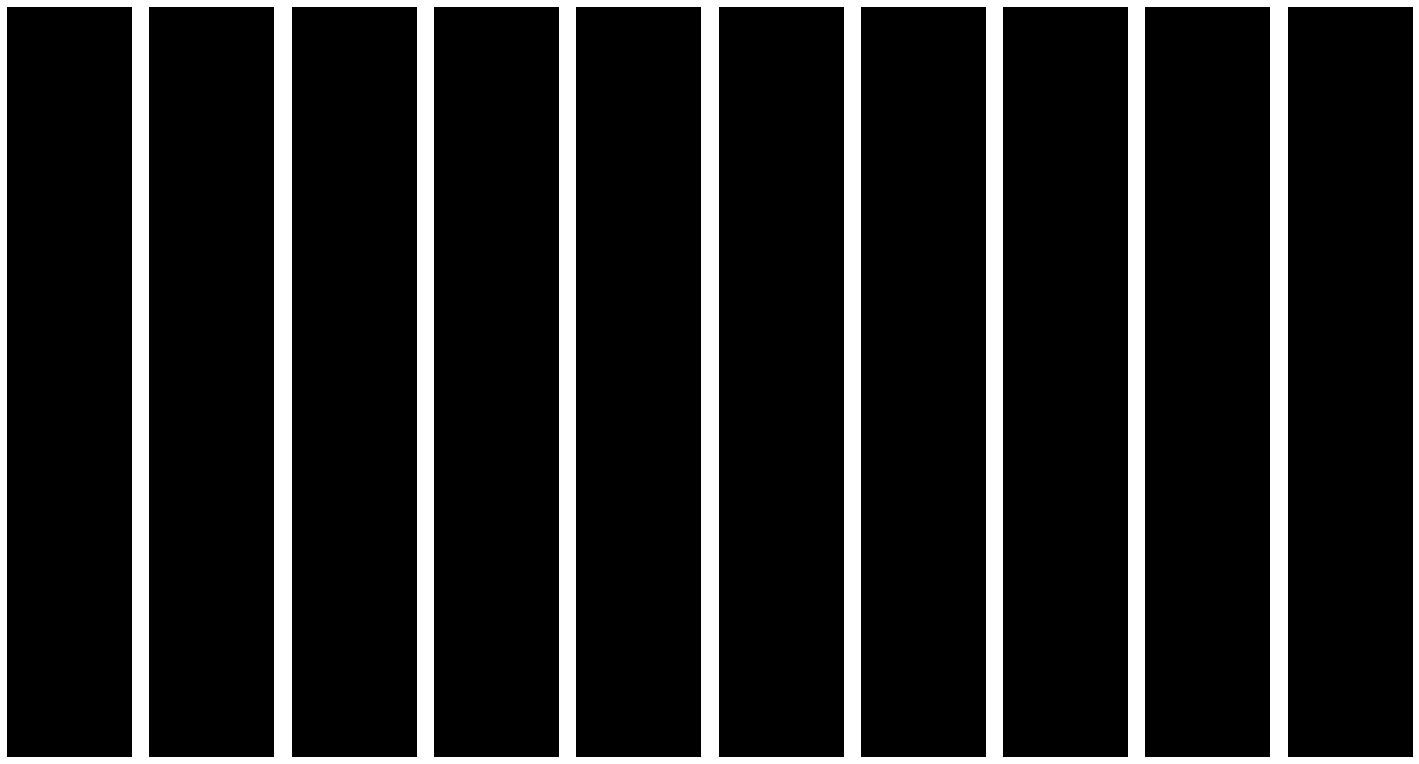

38/38 - 9s - loss: 1.4314 - d_loss: 0.6829 - g_loss: 0.7485 - 9s/epoch - 237ms/step
Epoch 160/200


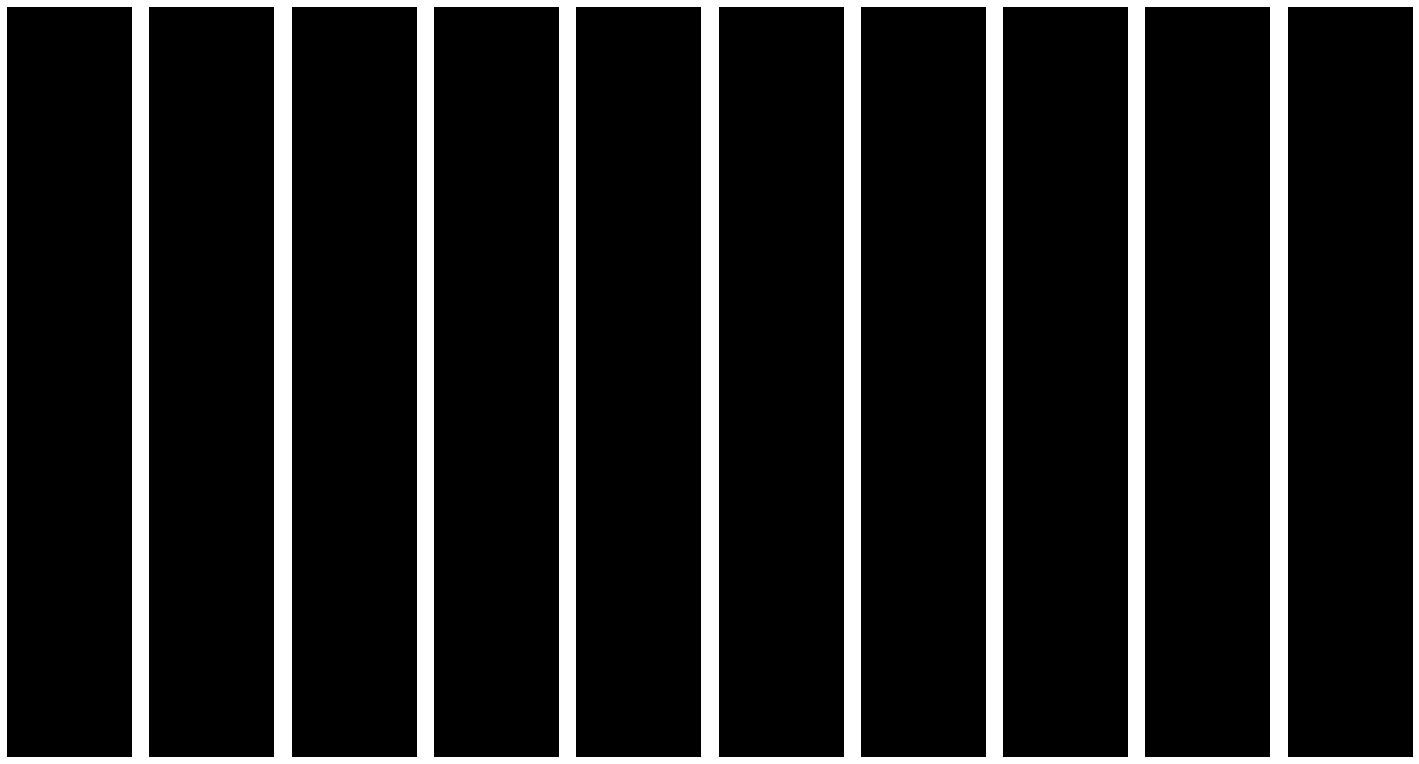

38/38 - 9s - loss: 1.4330 - d_loss: 0.6813 - g_loss: 0.7517 - 9s/epoch - 237ms/step
Epoch 161/200


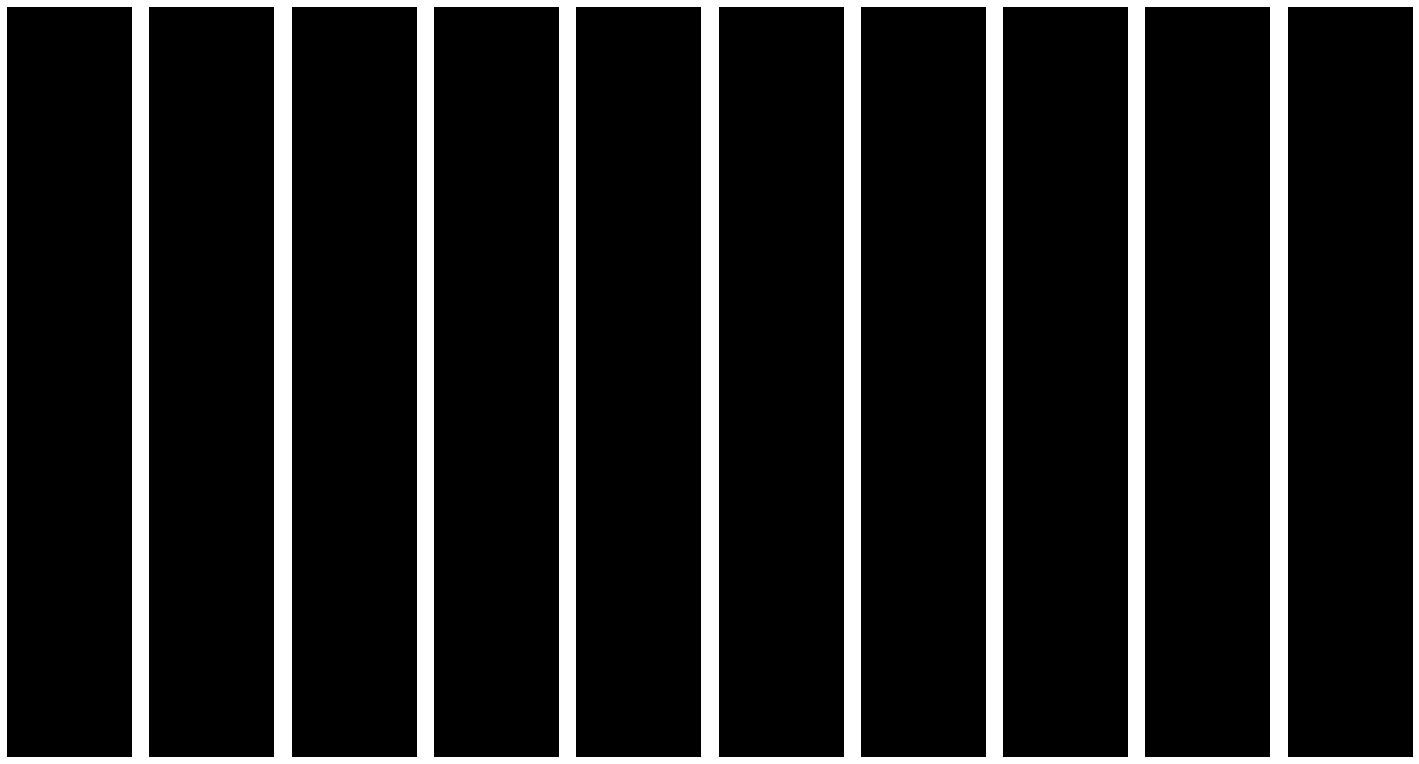

38/38 - 9s - loss: 1.4305 - d_loss: 0.6800 - g_loss: 0.7505 - 9s/epoch - 237ms/step
Epoch 162/200


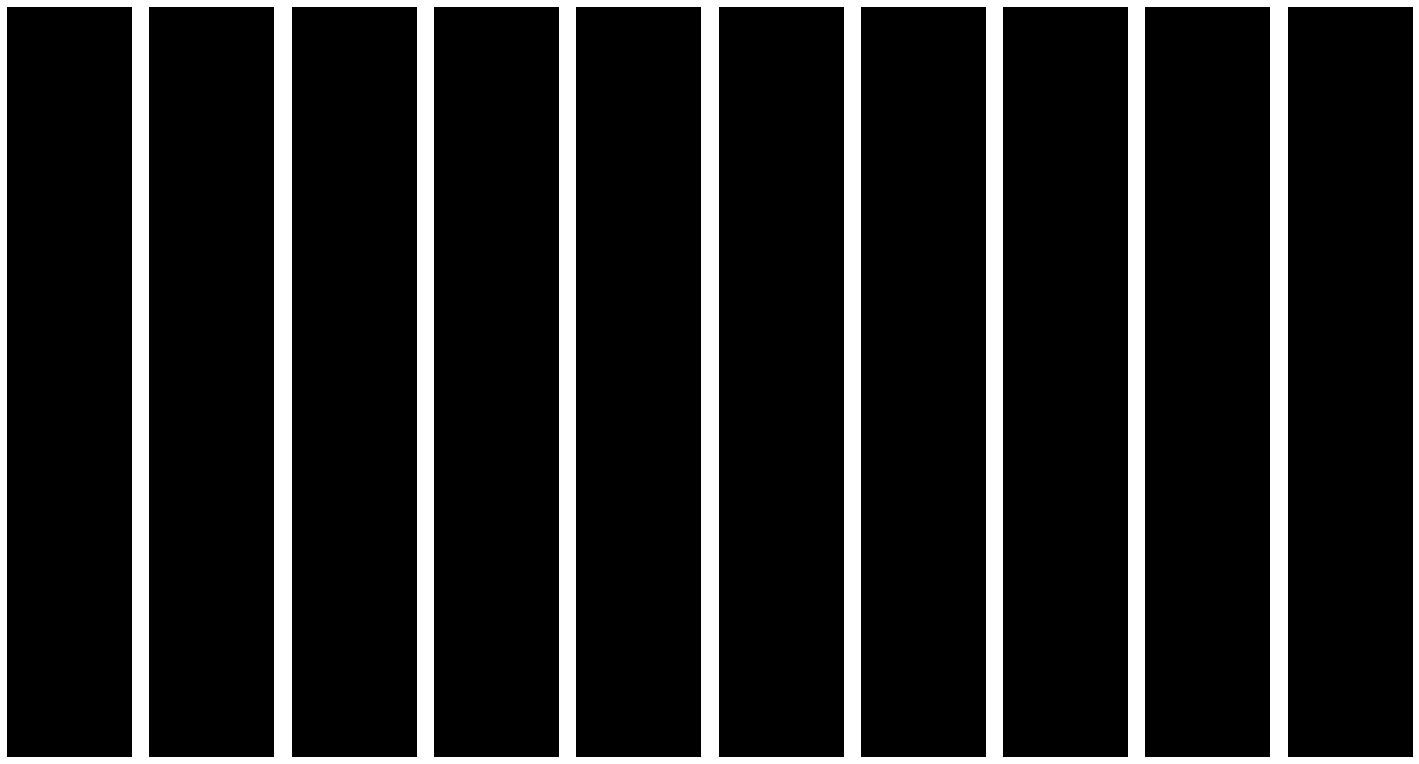

38/38 - 9s - loss: 1.4287 - d_loss: 0.6786 - g_loss: 0.7501 - 9s/epoch - 243ms/step
Epoch 163/200


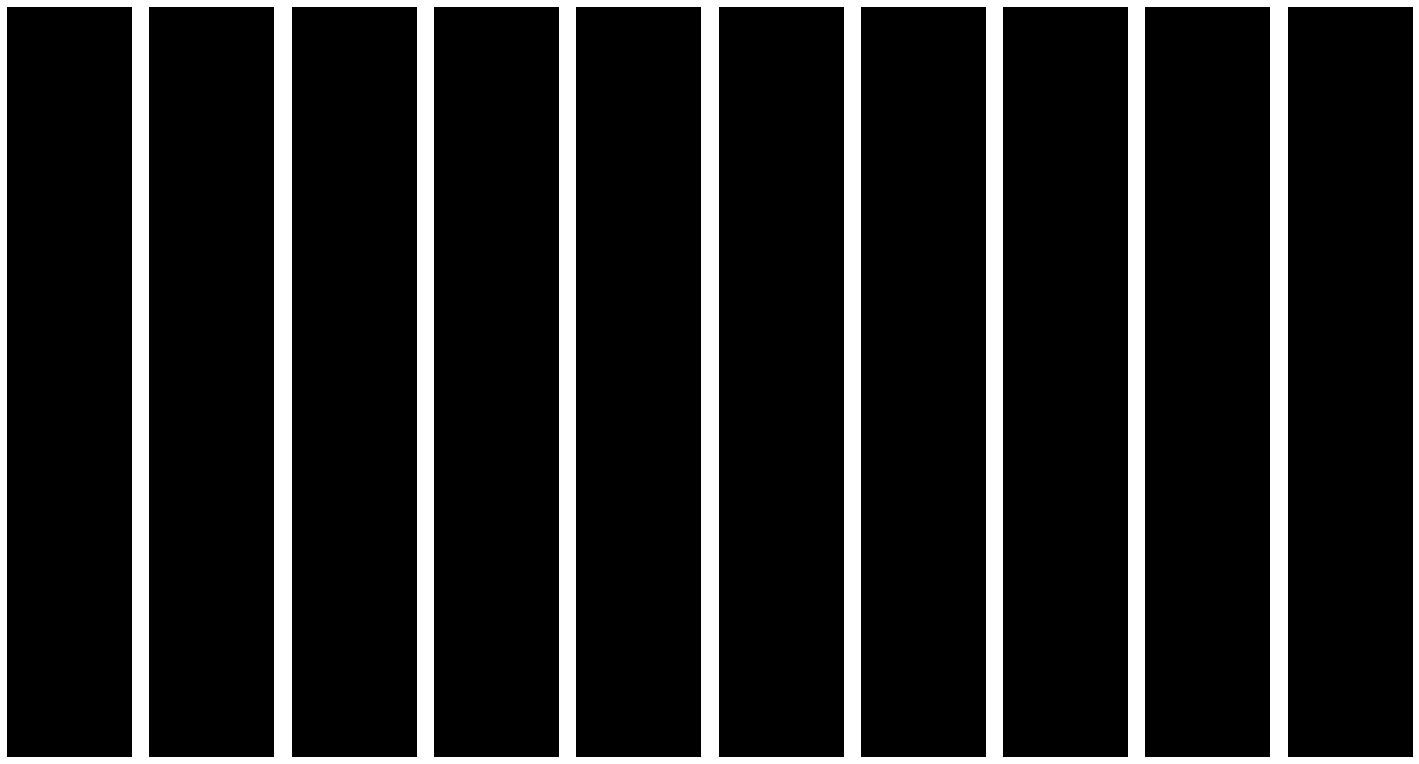

38/38 - 9s - loss: 1.4325 - d_loss: 0.6776 - g_loss: 0.7548 - 9s/epoch - 238ms/step
Epoch 164/200


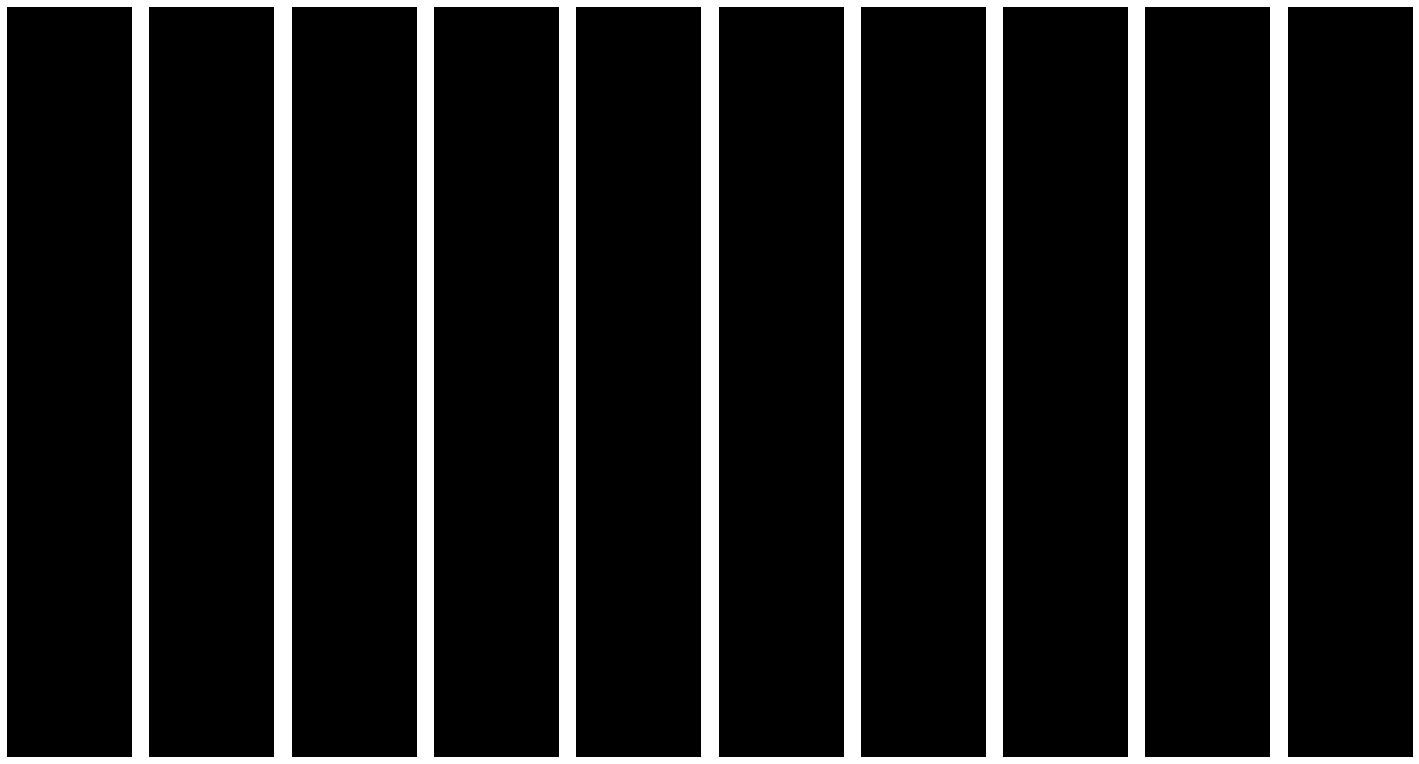

38/38 - 9s - loss: 1.4263 - d_loss: 0.6762 - g_loss: 0.7501 - 9s/epoch - 238ms/step
Epoch 165/200


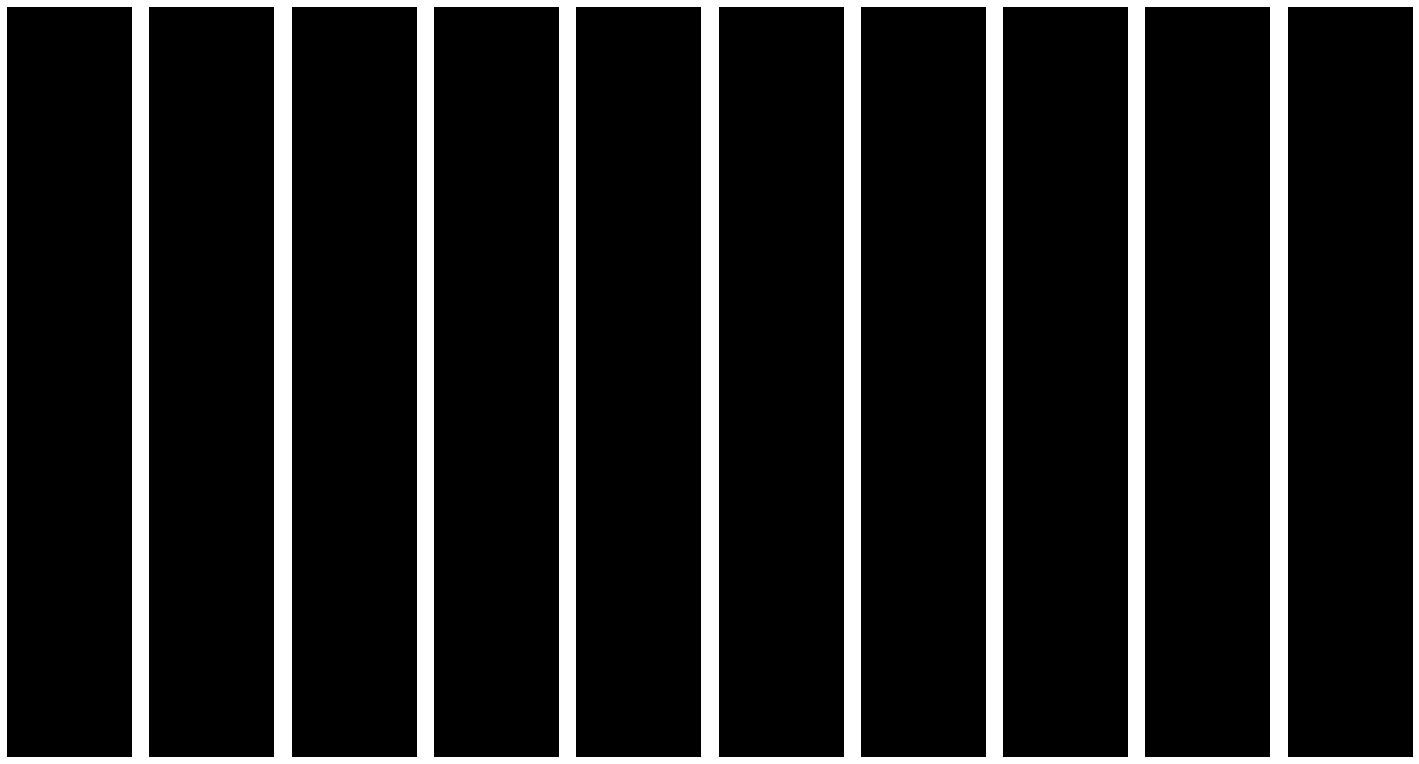

38/38 - 9s - loss: 1.4272 - d_loss: 0.6750 - g_loss: 0.7522 - 9s/epoch - 236ms/step
Epoch 166/200


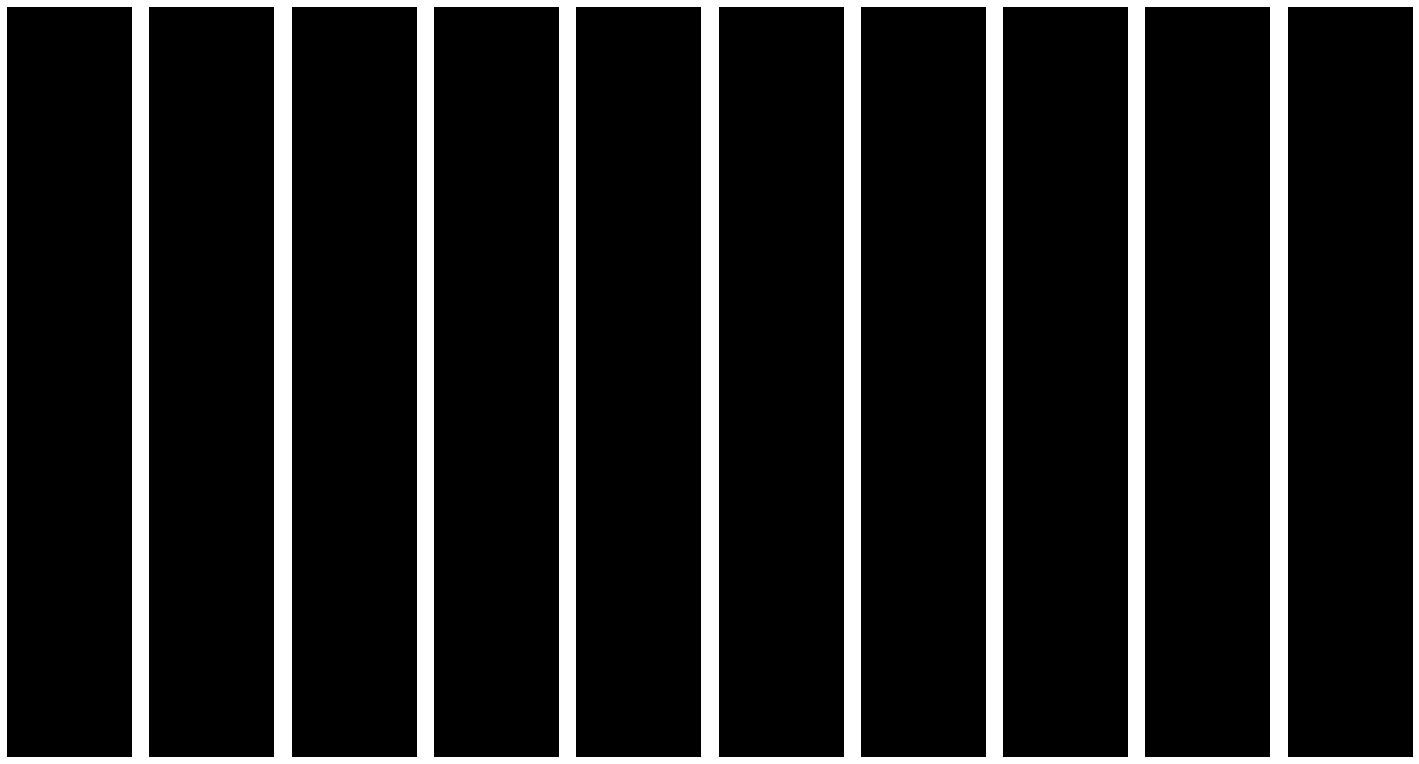

38/38 - 9s - loss: 1.4297 - d_loss: 0.6740 - g_loss: 0.7557 - 9s/epoch - 236ms/step
Epoch 167/200


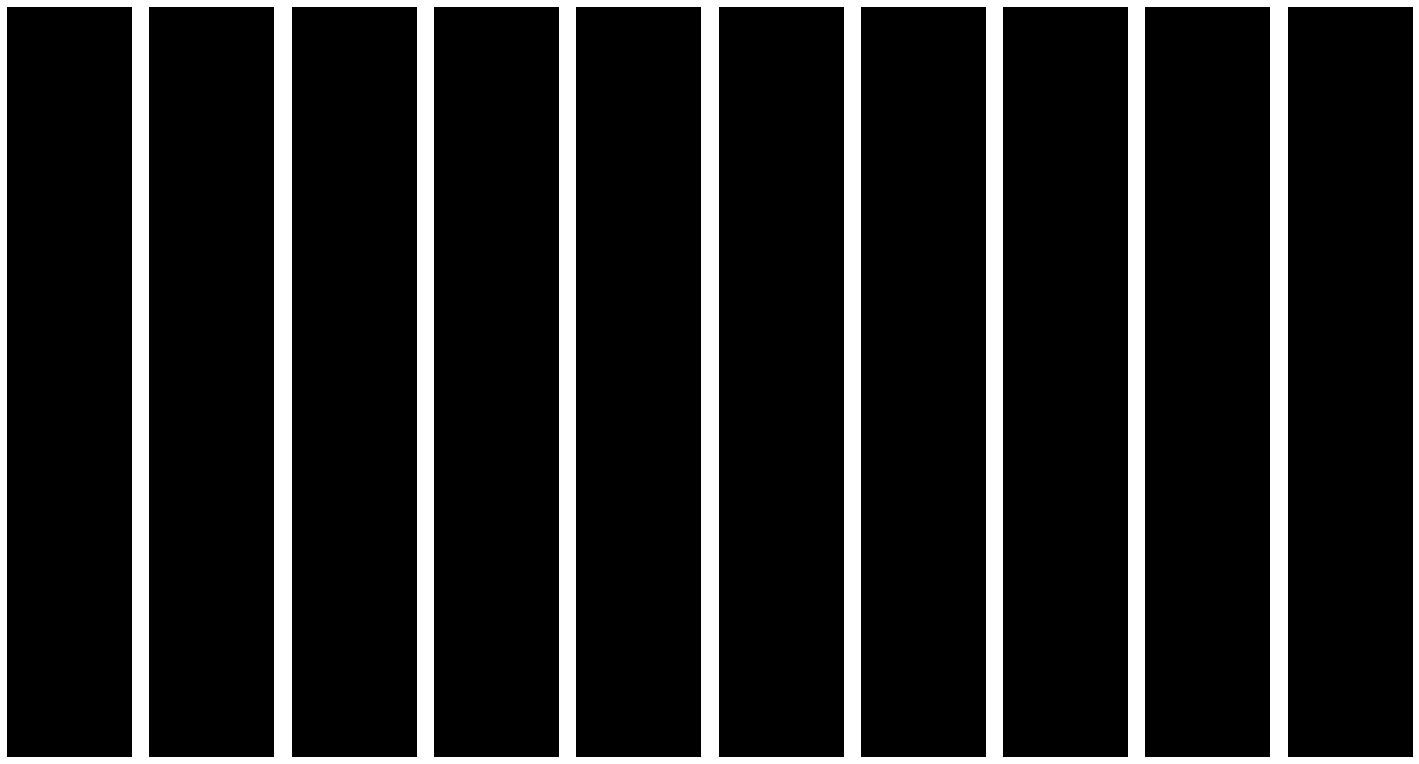

38/38 - 9s - loss: 1.4244 - d_loss: 0.6727 - g_loss: 0.7517 - 9s/epoch - 236ms/step
Epoch 168/200


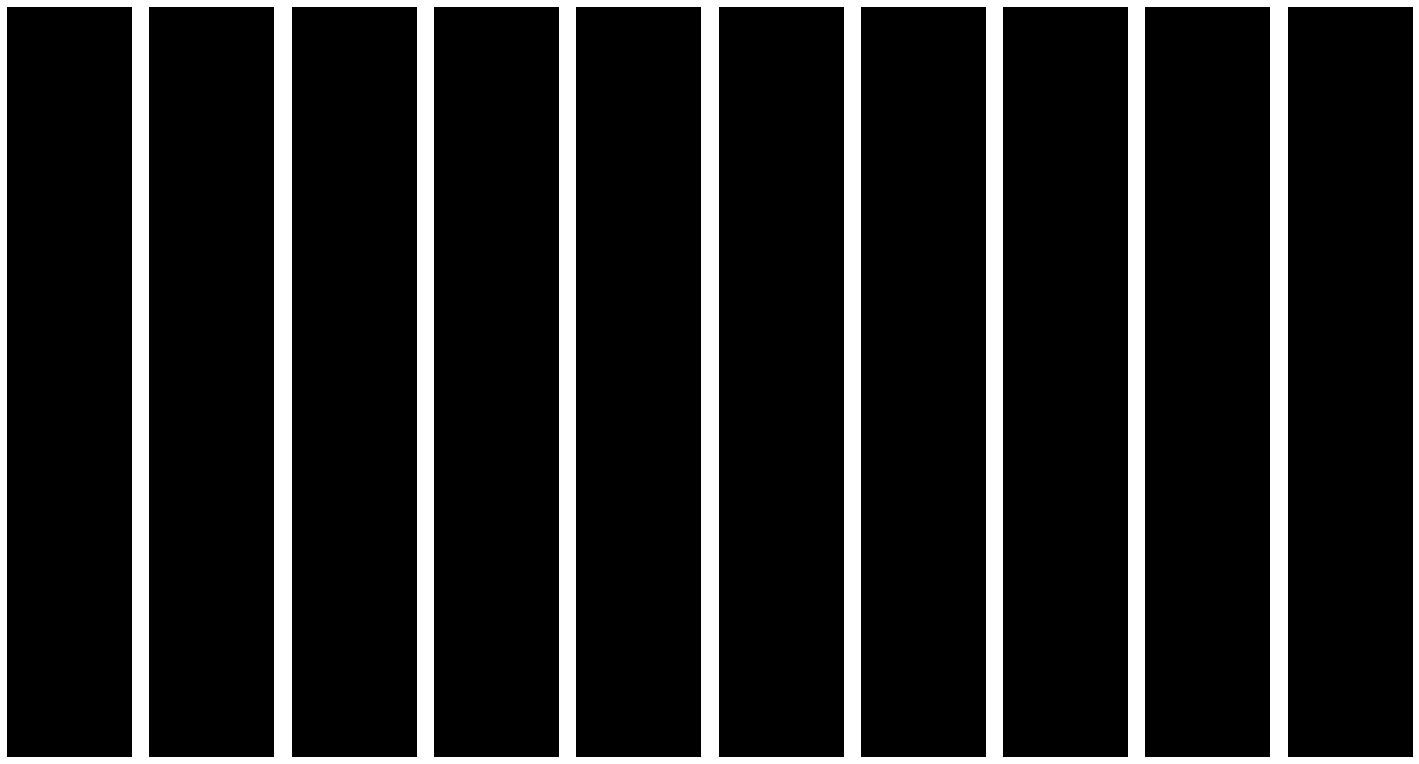

38/38 - 9s - loss: 1.4264 - d_loss: 0.6716 - g_loss: 0.7547 - 9s/epoch - 243ms/step
Epoch 169/200


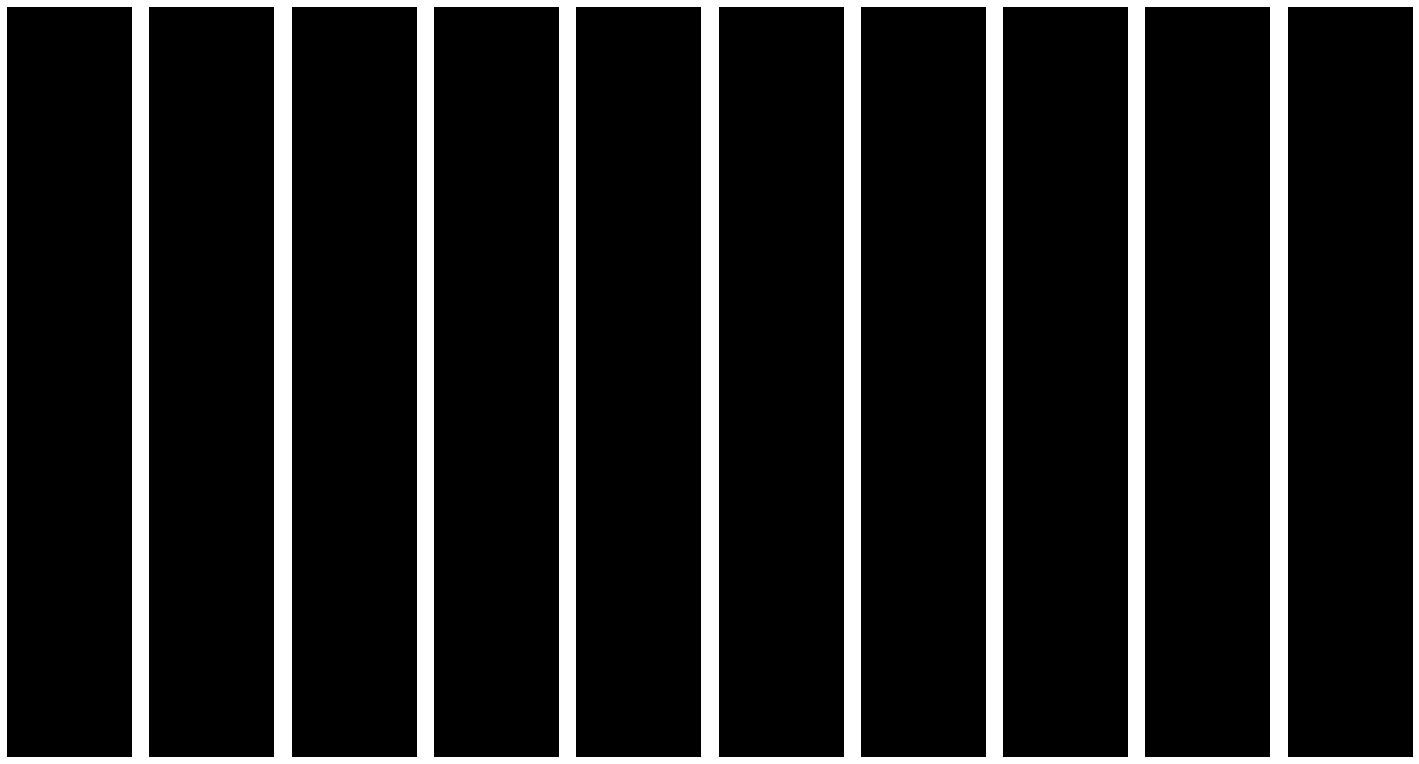

38/38 - 9s - loss: 1.4264 - d_loss: 0.6707 - g_loss: 0.7556 - 9s/epoch - 236ms/step
Epoch 170/200


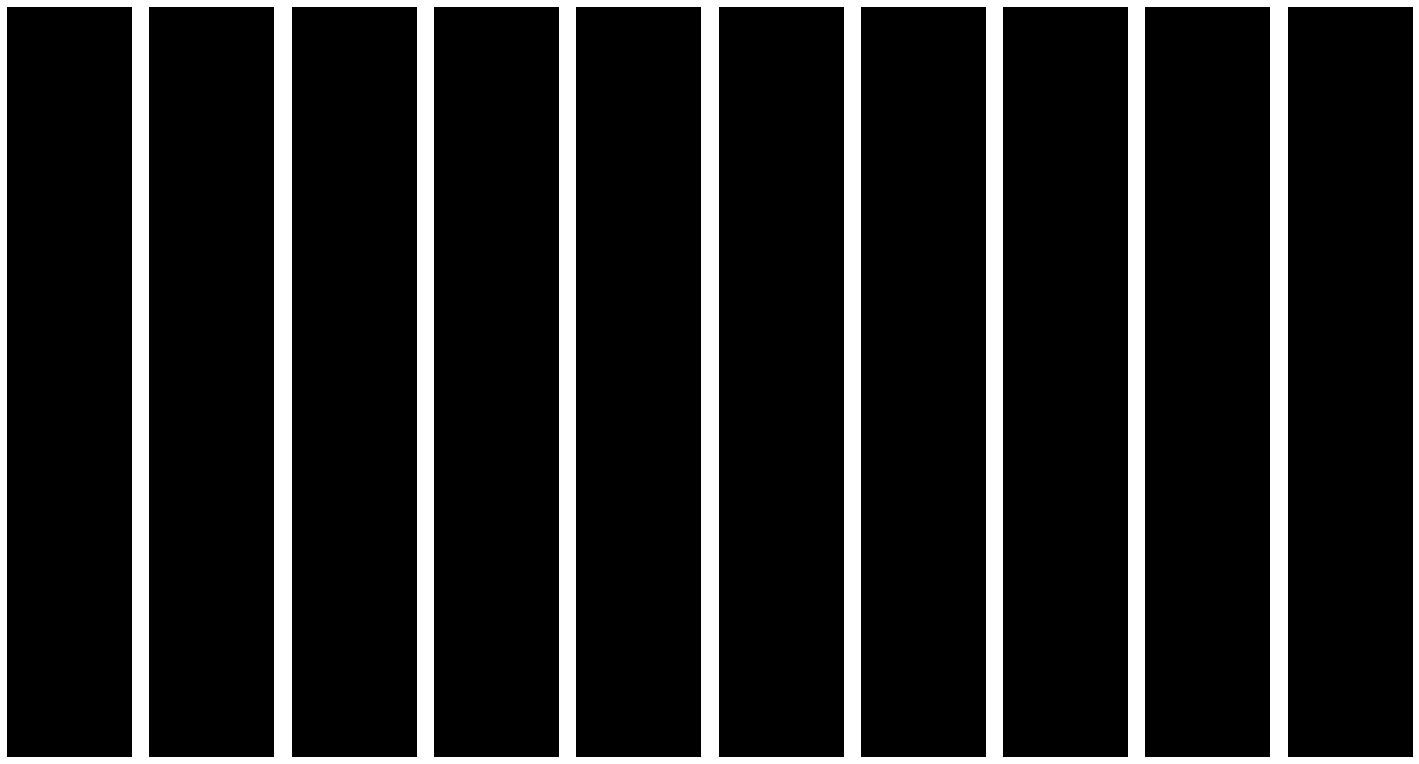

38/38 - 9s - loss: 1.4247 - d_loss: 0.6697 - g_loss: 0.7550 - 9s/epoch - 236ms/step
Epoch 171/200


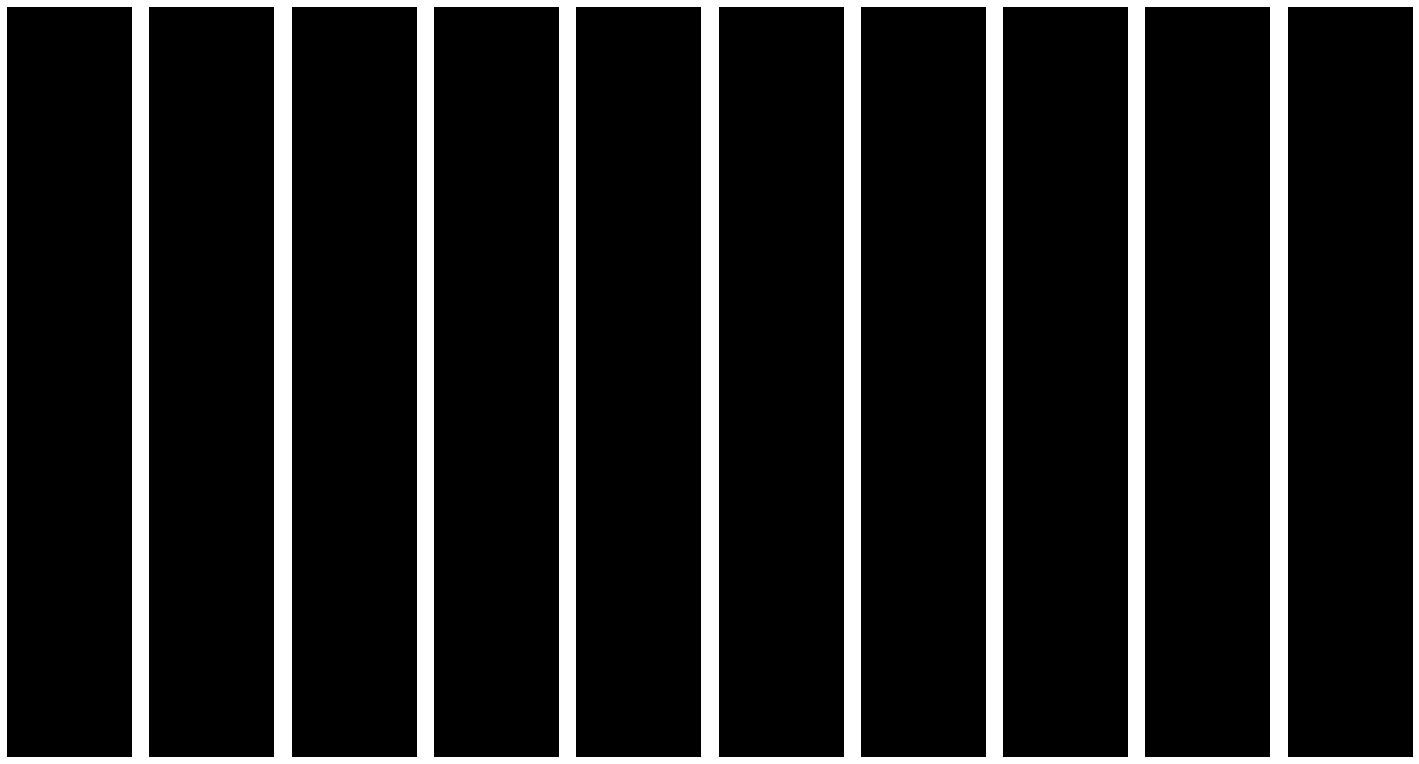

38/38 - 9s - loss: 1.4239 - d_loss: 0.6687 - g_loss: 0.7551 - 9s/epoch - 236ms/step
Epoch 172/200


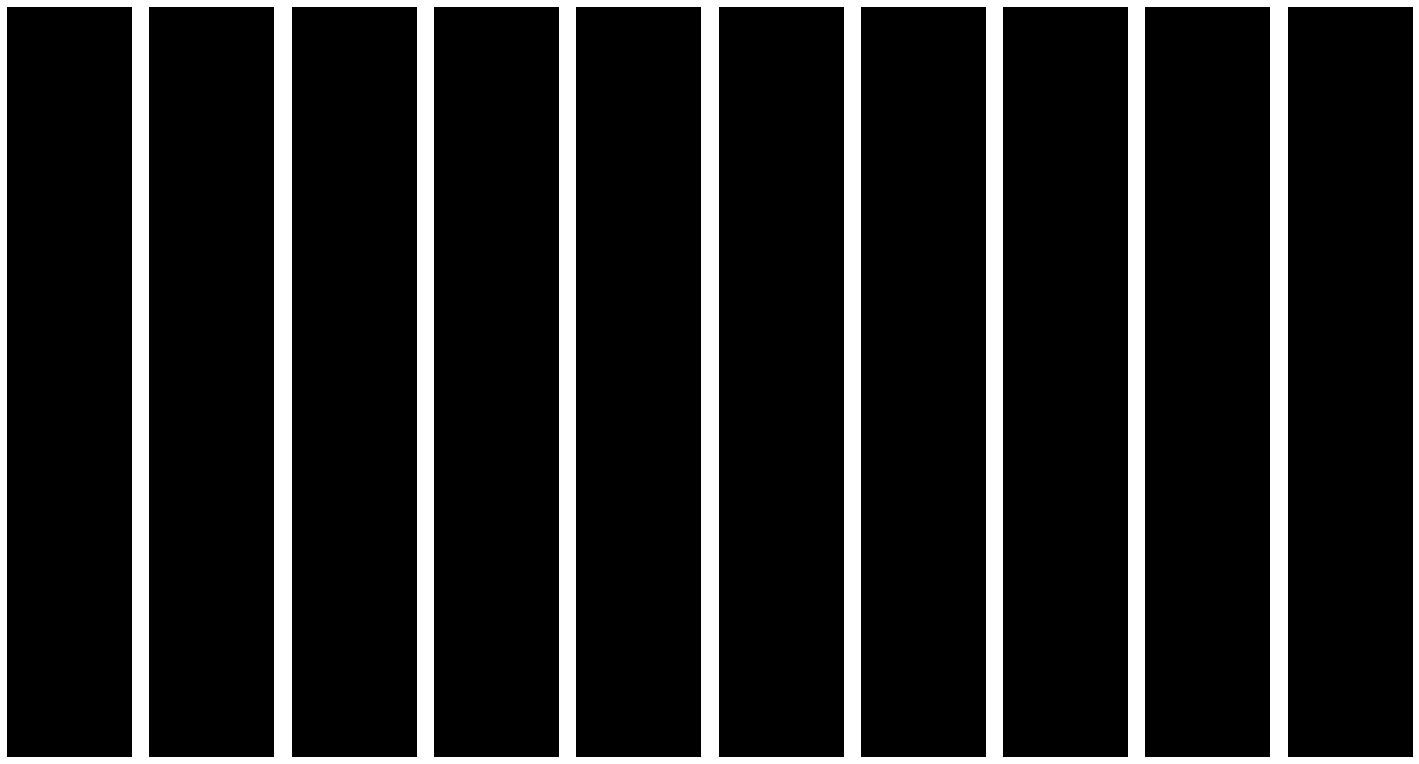

38/38 - 9s - loss: 1.4249 - d_loss: 0.6677 - g_loss: 0.7572 - 9s/epoch - 238ms/step
Epoch 173/200


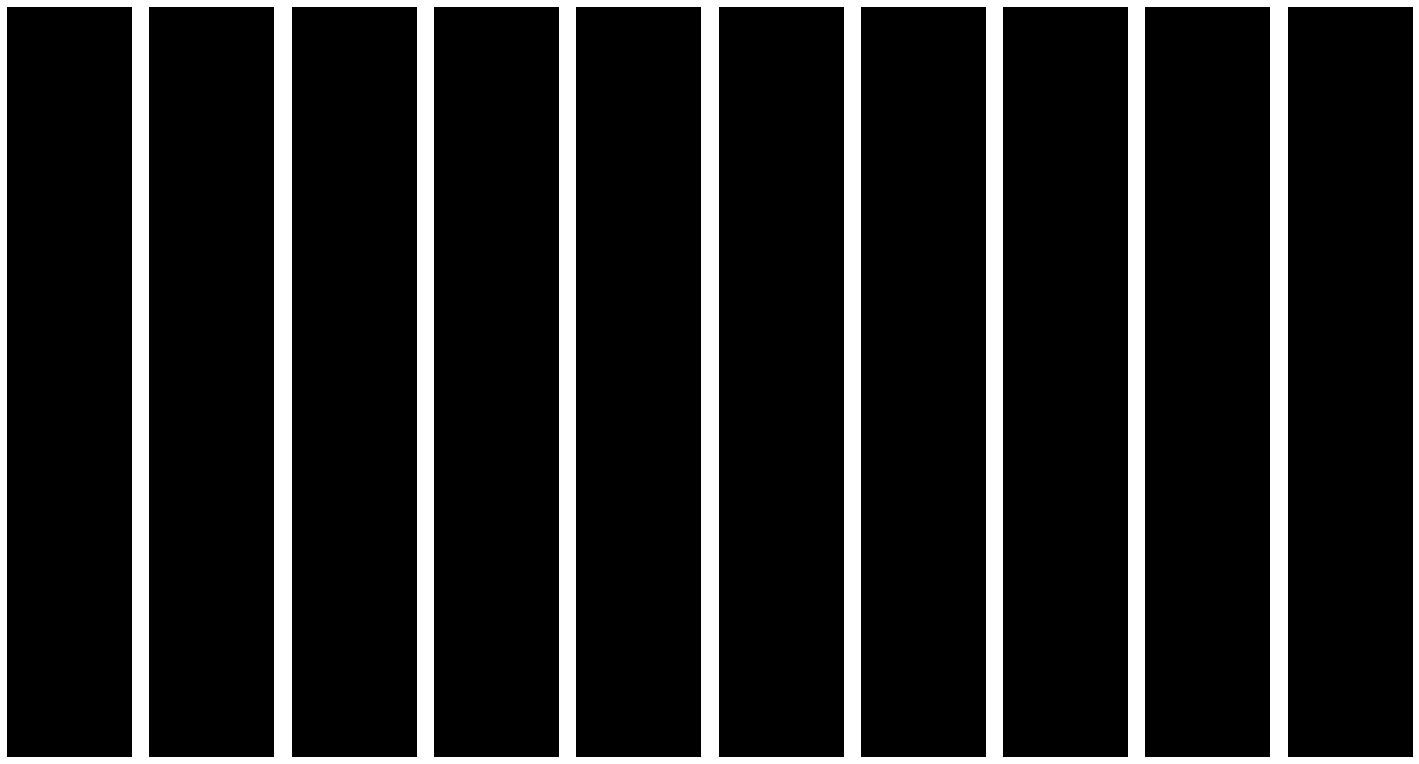

38/38 - 9s - loss: 1.4251 - d_loss: 0.6668 - g_loss: 0.7583 - 9s/epoch - 237ms/step
Epoch 174/200


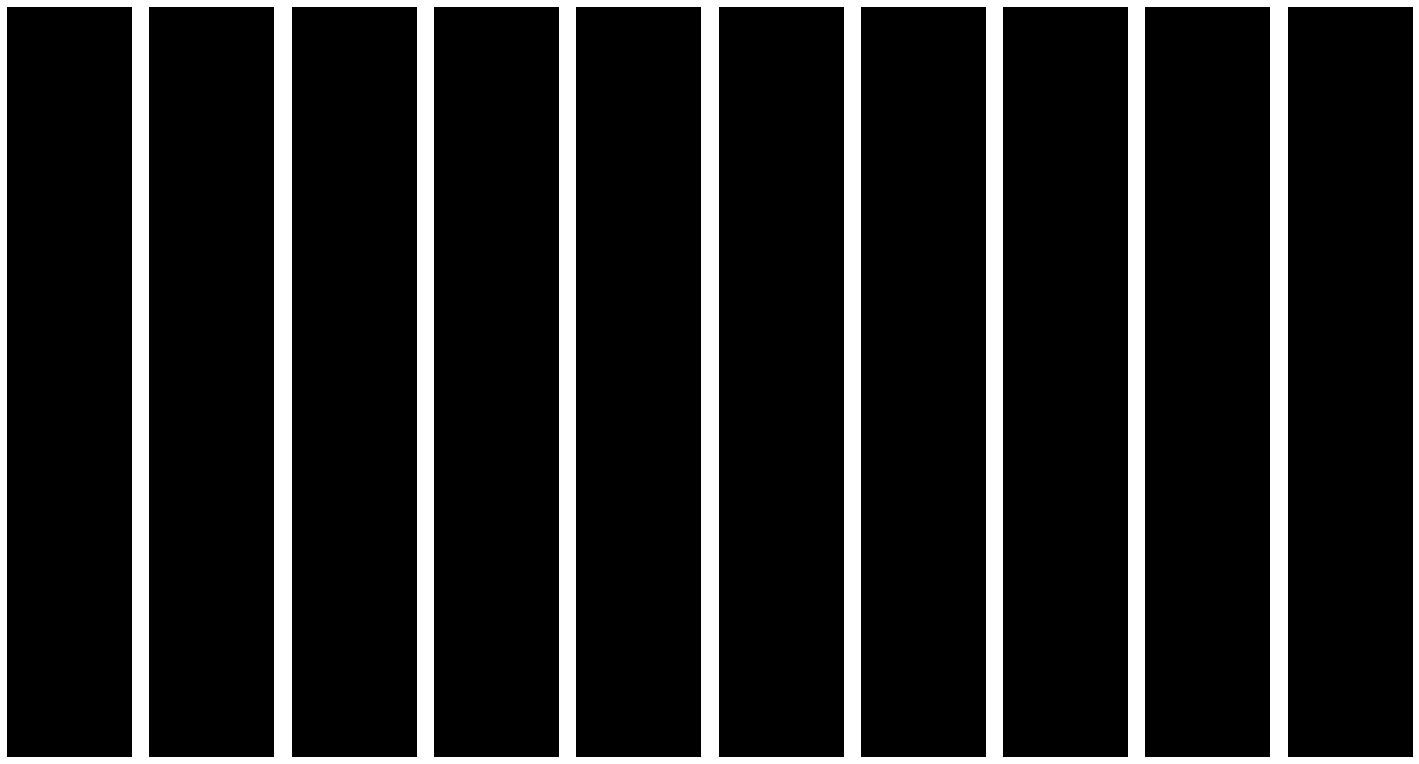

38/38 - 9s - loss: 1.4233 - d_loss: 0.6658 - g_loss: 0.7575 - 9s/epoch - 243ms/step
Epoch 175/200


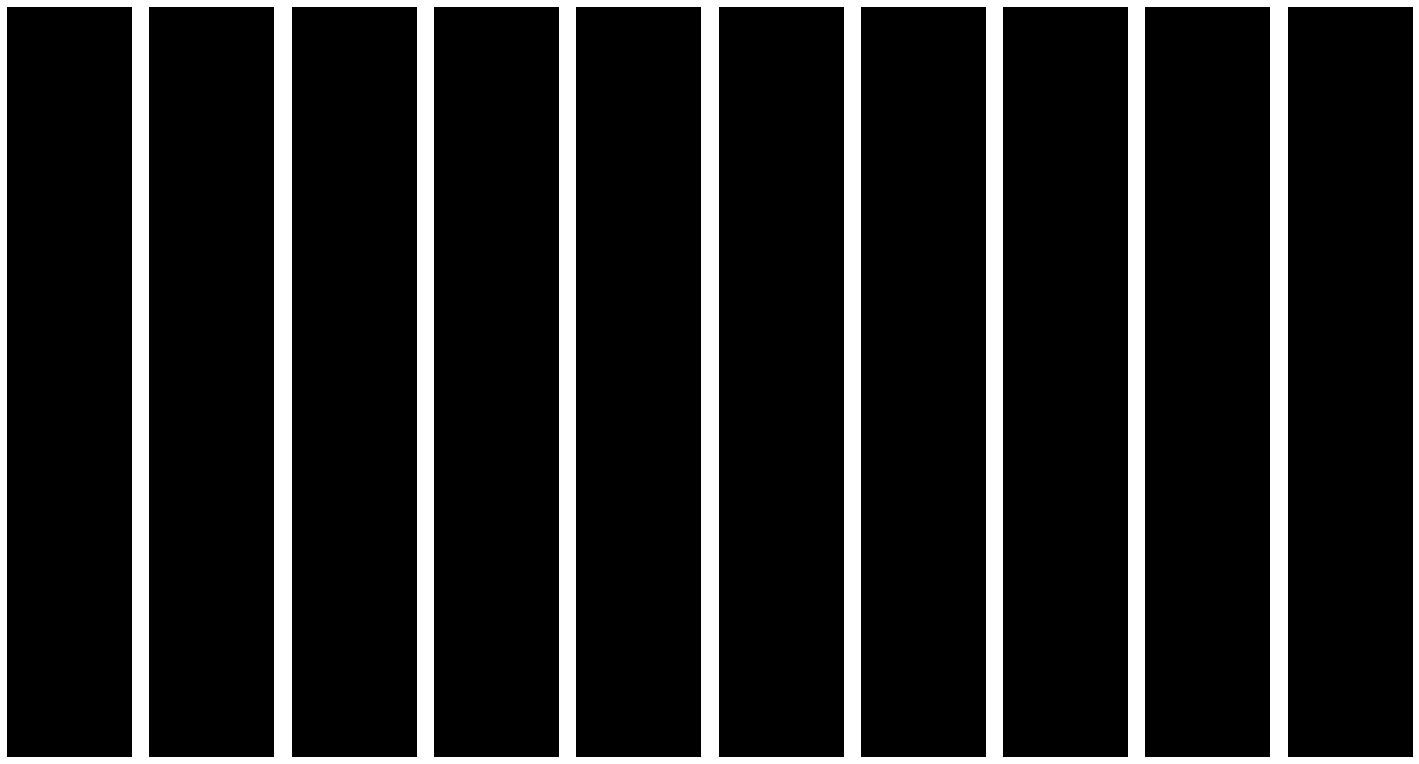

38/38 - 9s - loss: 1.4224 - d_loss: 0.6650 - g_loss: 0.7574 - 9s/epoch - 236ms/step
Epoch 176/200


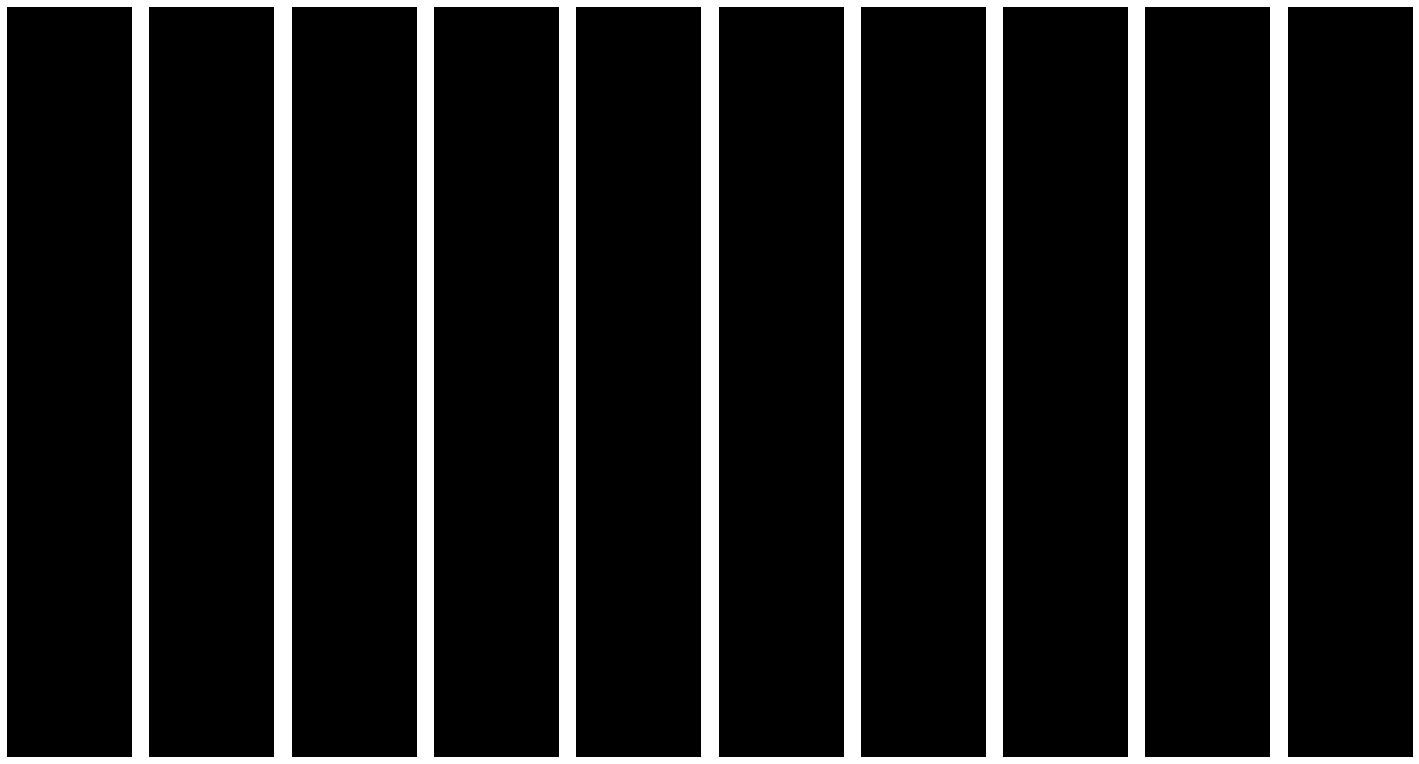

38/38 - 9s - loss: 1.4230 - d_loss: 0.6639 - g_loss: 0.7591 - 9s/epoch - 236ms/step
Epoch 177/200


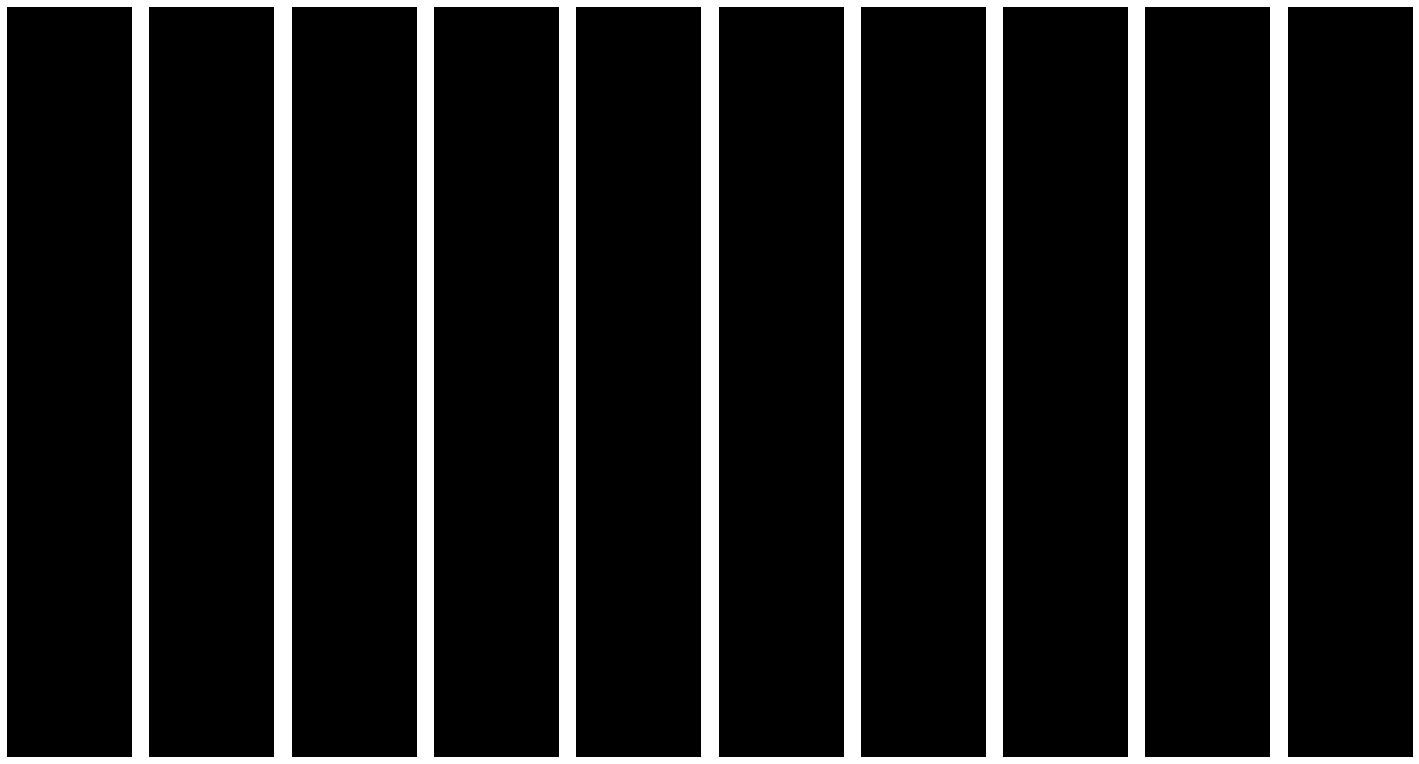

38/38 - 9s - loss: 1.4215 - d_loss: 0.6630 - g_loss: 0.7585 - 9s/epoch - 237ms/step
Epoch 178/200


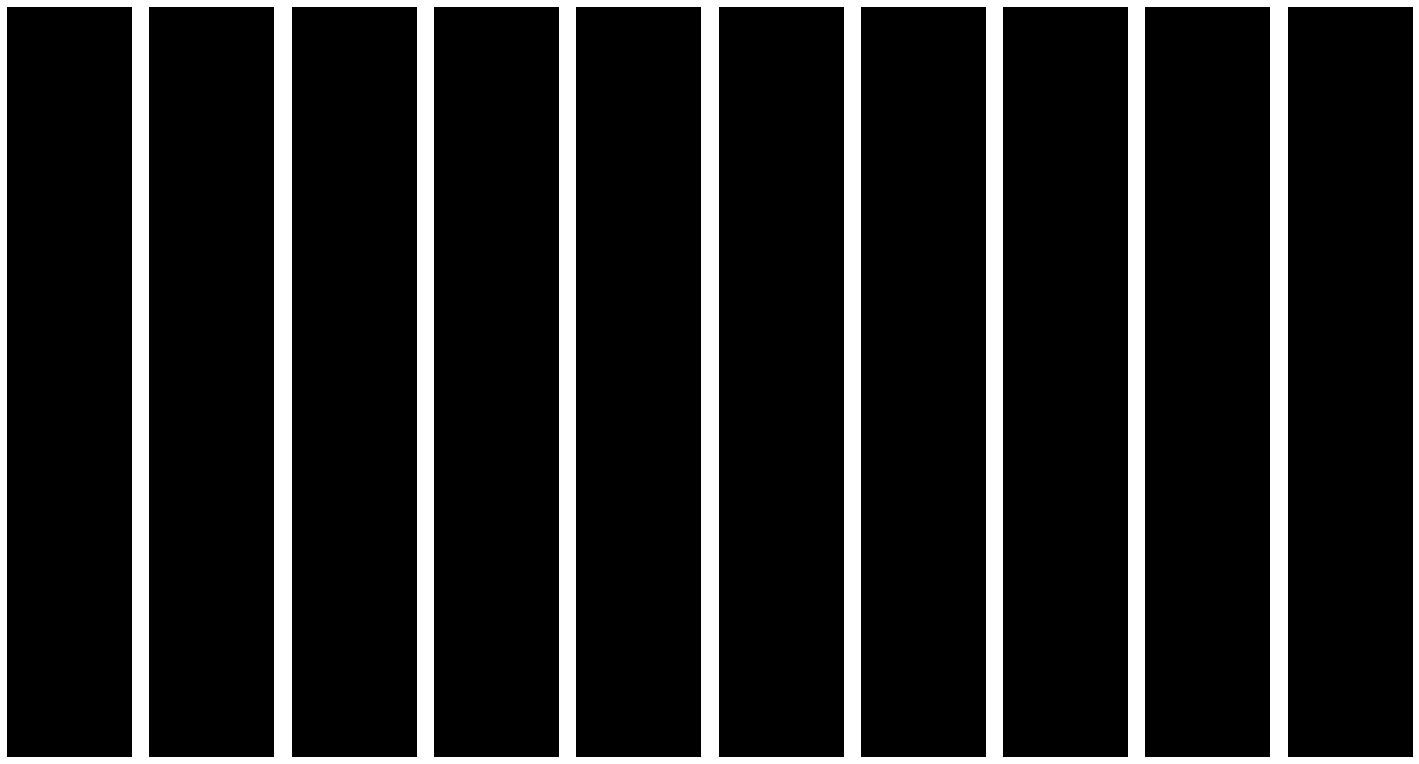

38/38 - 9s - loss: 1.4245 - d_loss: 0.6623 - g_loss: 0.7622 - 9s/epoch - 237ms/step
Epoch 179/200


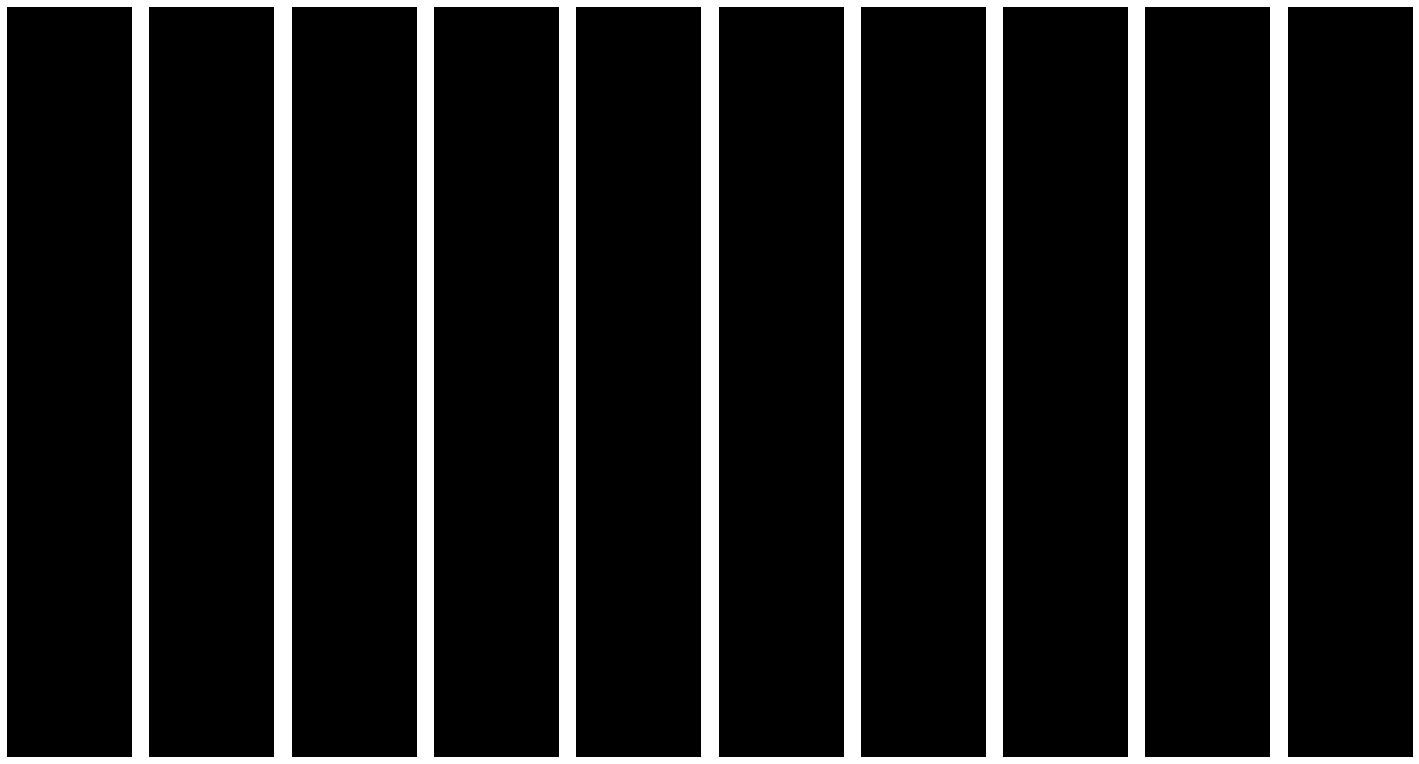

38/38 - 9s - loss: 1.4233 - d_loss: 0.6612 - g_loss: 0.7622 - 9s/epoch - 243ms/step
Epoch 180/200


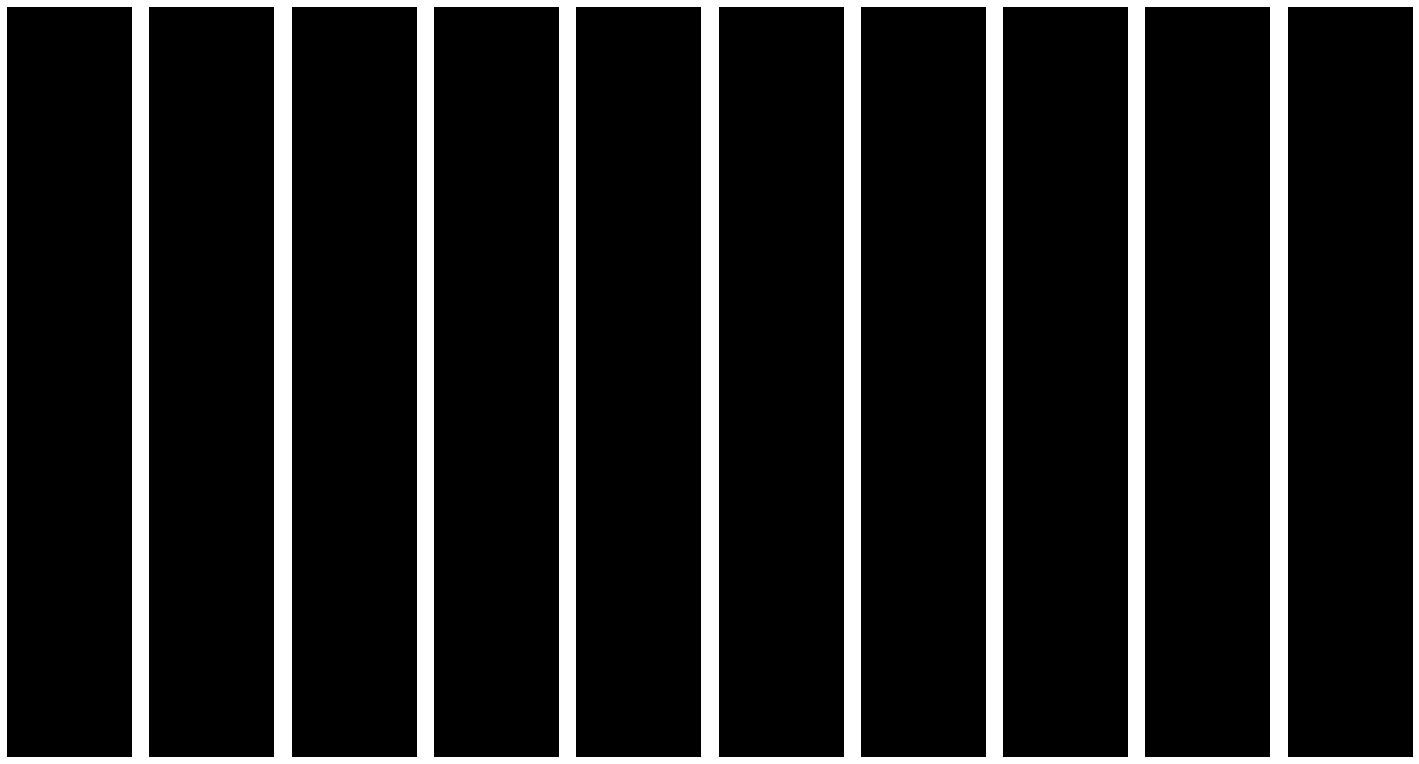

38/38 - 9s - loss: 1.4218 - d_loss: 0.6601 - g_loss: 0.7617 - 9s/epoch - 237ms/step
Epoch 181/200


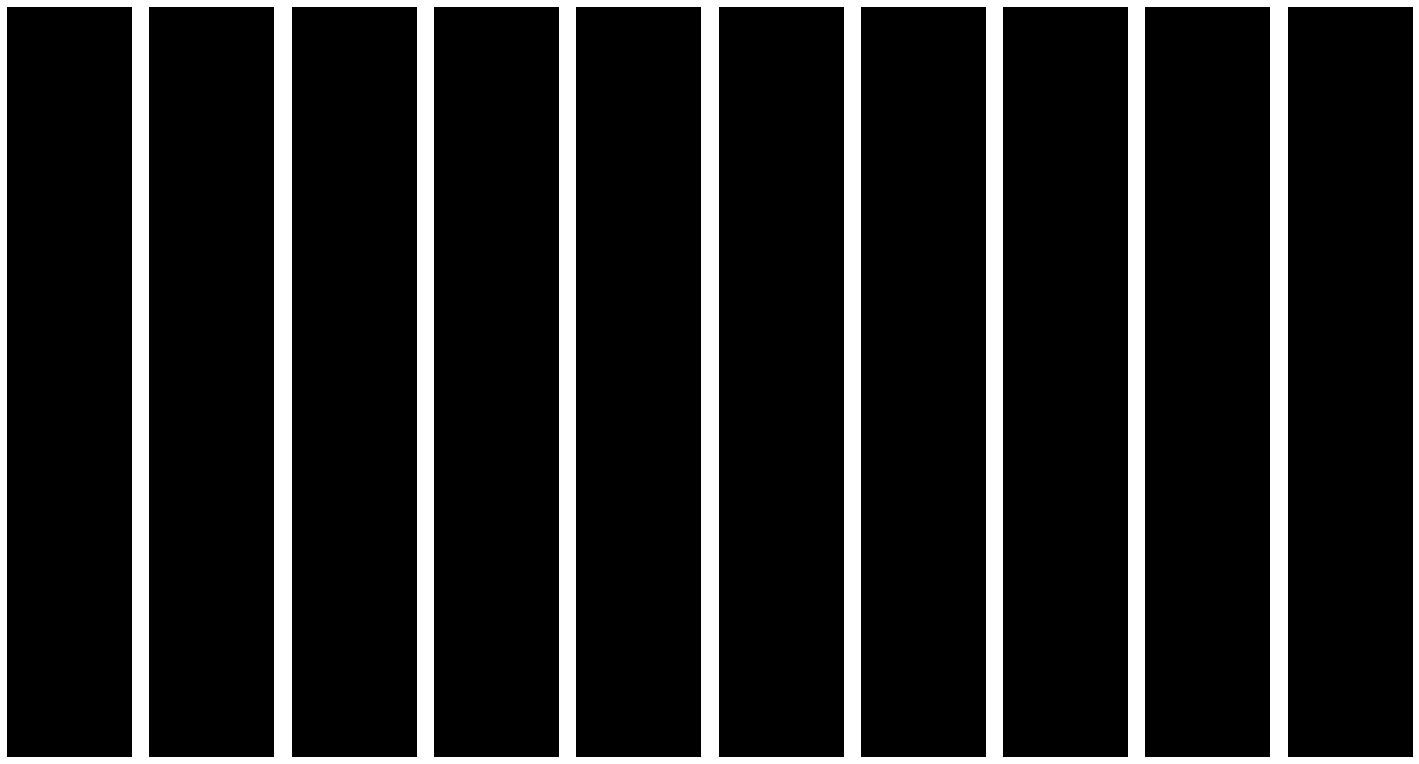

38/38 - 9s - loss: 1.4239 - d_loss: 0.6592 - g_loss: 0.7647 - 9s/epoch - 243ms/step
Epoch 182/200


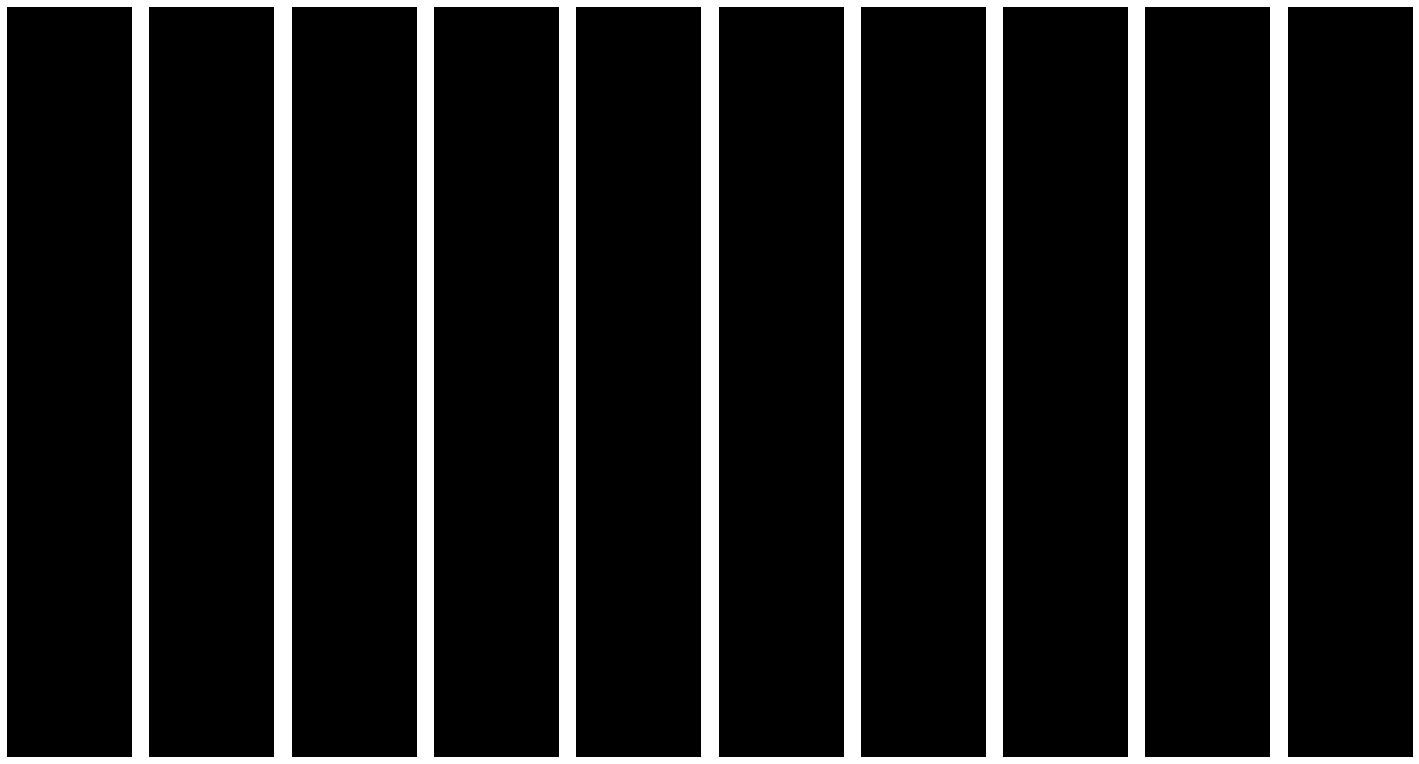

38/38 - 9s - loss: 1.4216 - d_loss: 0.6582 - g_loss: 0.7634 - 9s/epoch - 238ms/step
Epoch 183/200


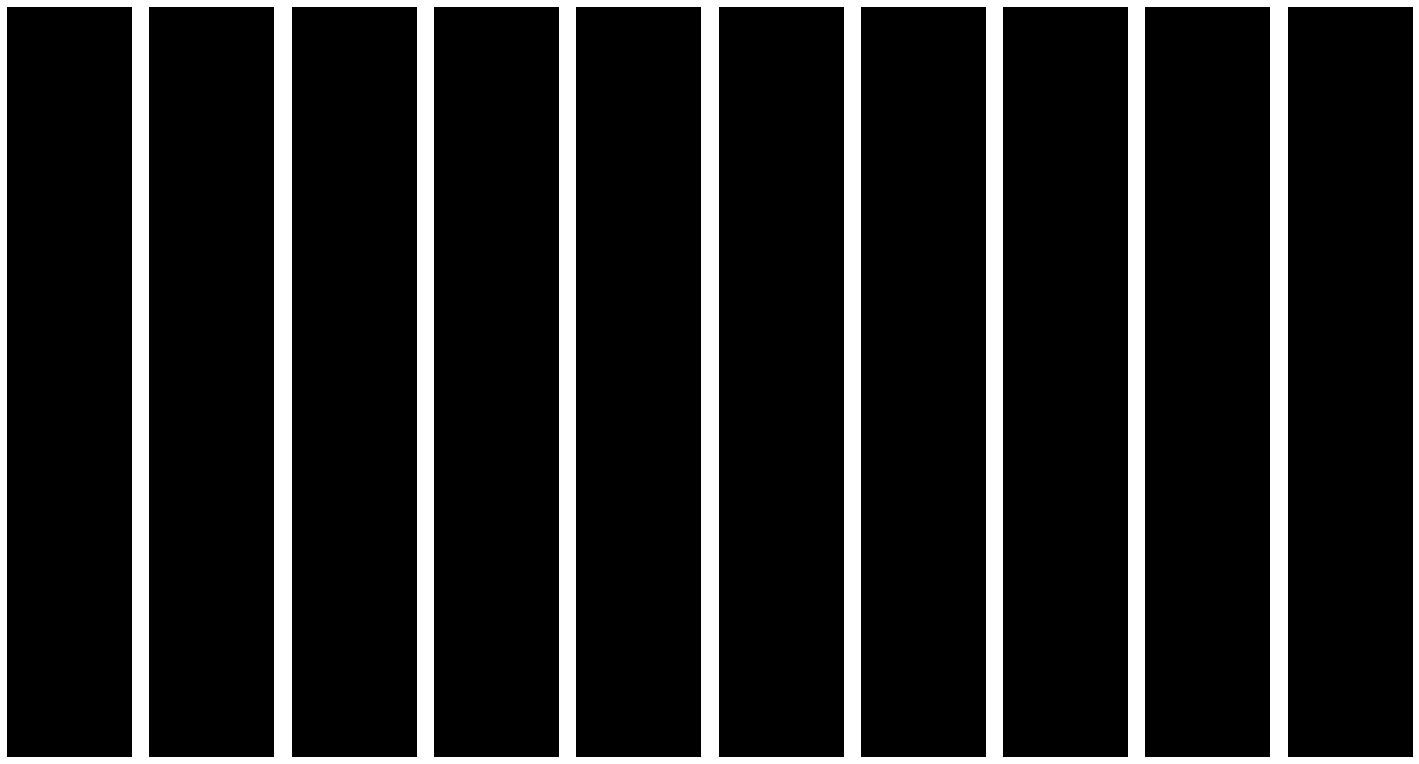

38/38 - 9s - loss: 1.4220 - d_loss: 0.6571 - g_loss: 0.7649 - 9s/epoch - 236ms/step
Epoch 184/200


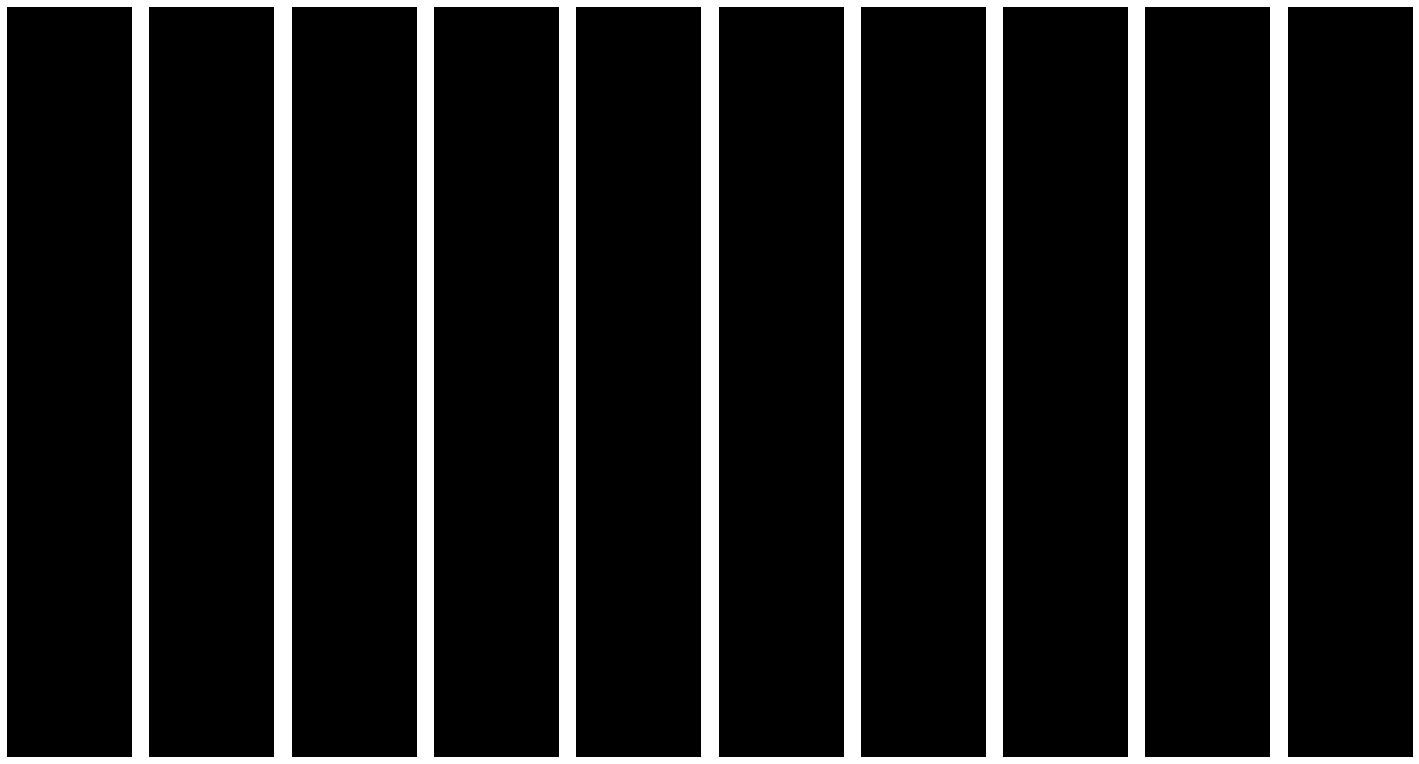

38/38 - 9s - loss: 1.4235 - d_loss: 0.6560 - g_loss: 0.7675 - 9s/epoch - 238ms/step
Epoch 185/200


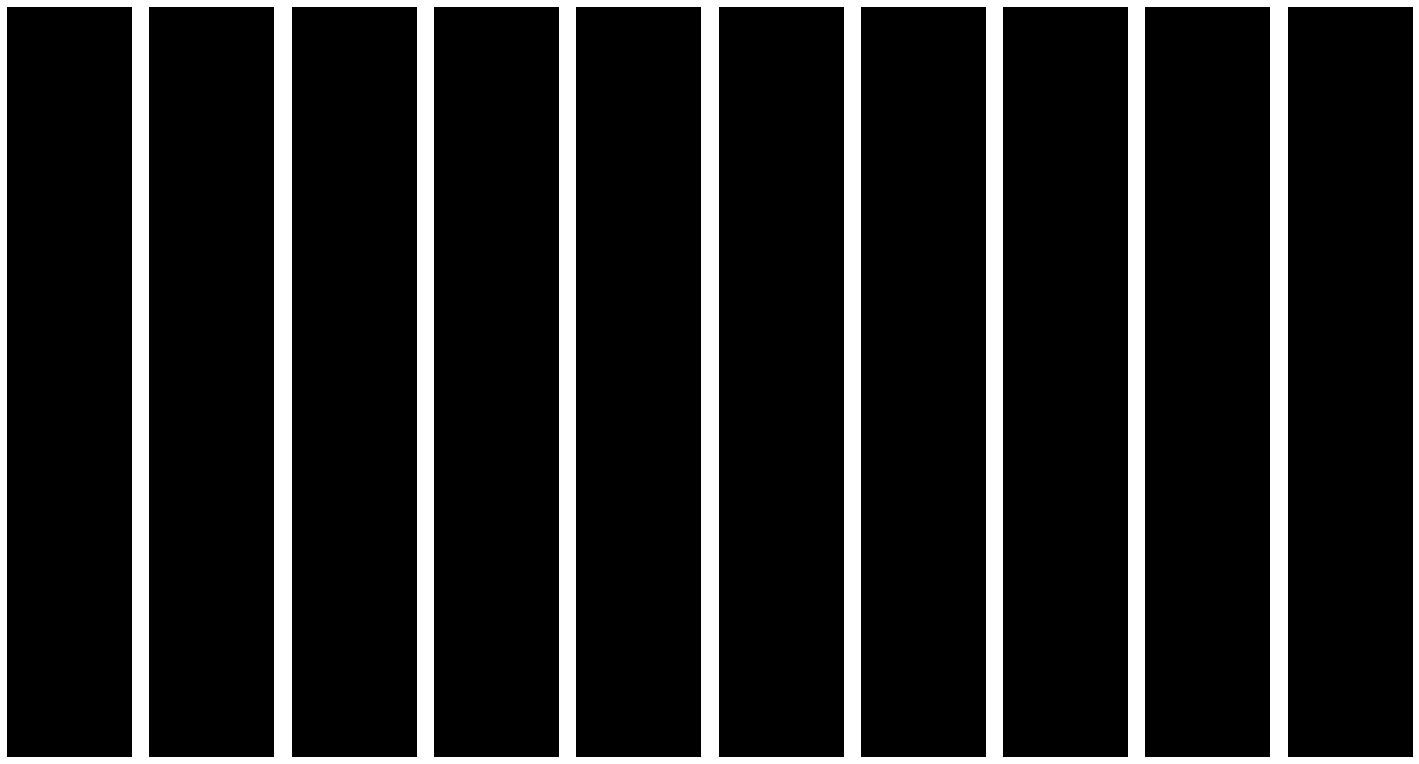

38/38 - 9s - loss: 1.4217 - d_loss: 0.6547 - g_loss: 0.7670 - 9s/epoch - 243ms/step
Epoch 186/200


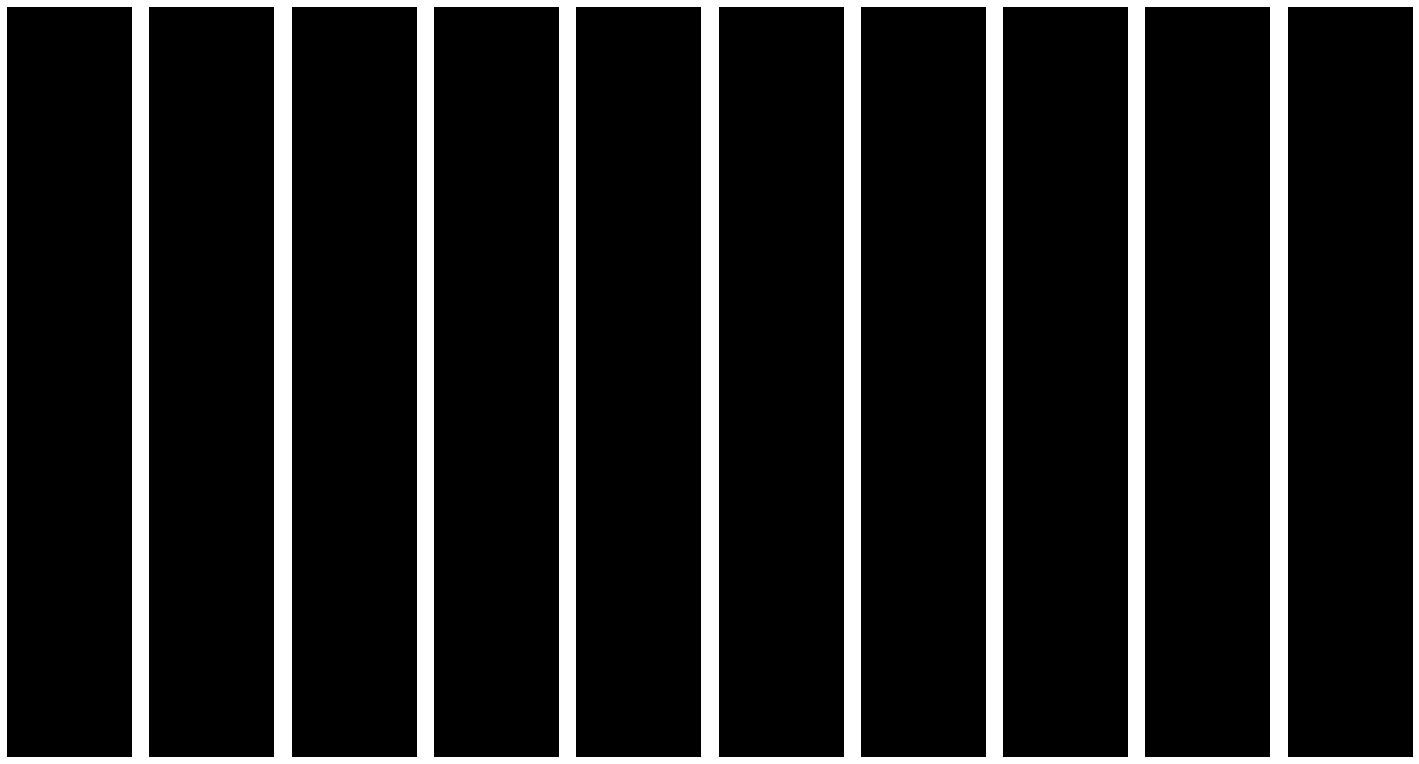

38/38 - 9s - loss: 1.4238 - d_loss: 0.6528 - g_loss: 0.7710 - 9s/epoch - 238ms/step
Epoch 187/200


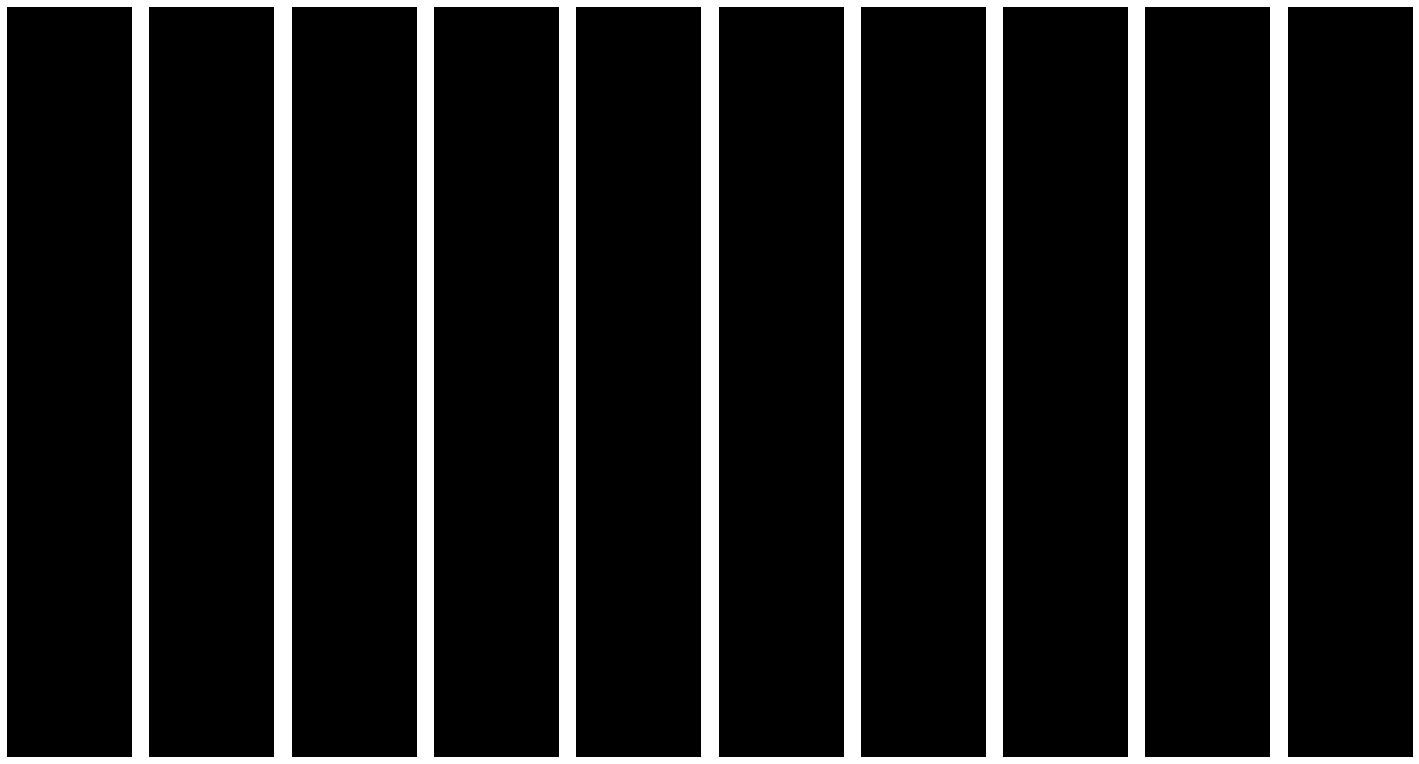

38/38 - 9s - loss: 1.4238 - d_loss: 0.6507 - g_loss: 0.7731 - 9s/epoch - 238ms/step
Epoch 188/200


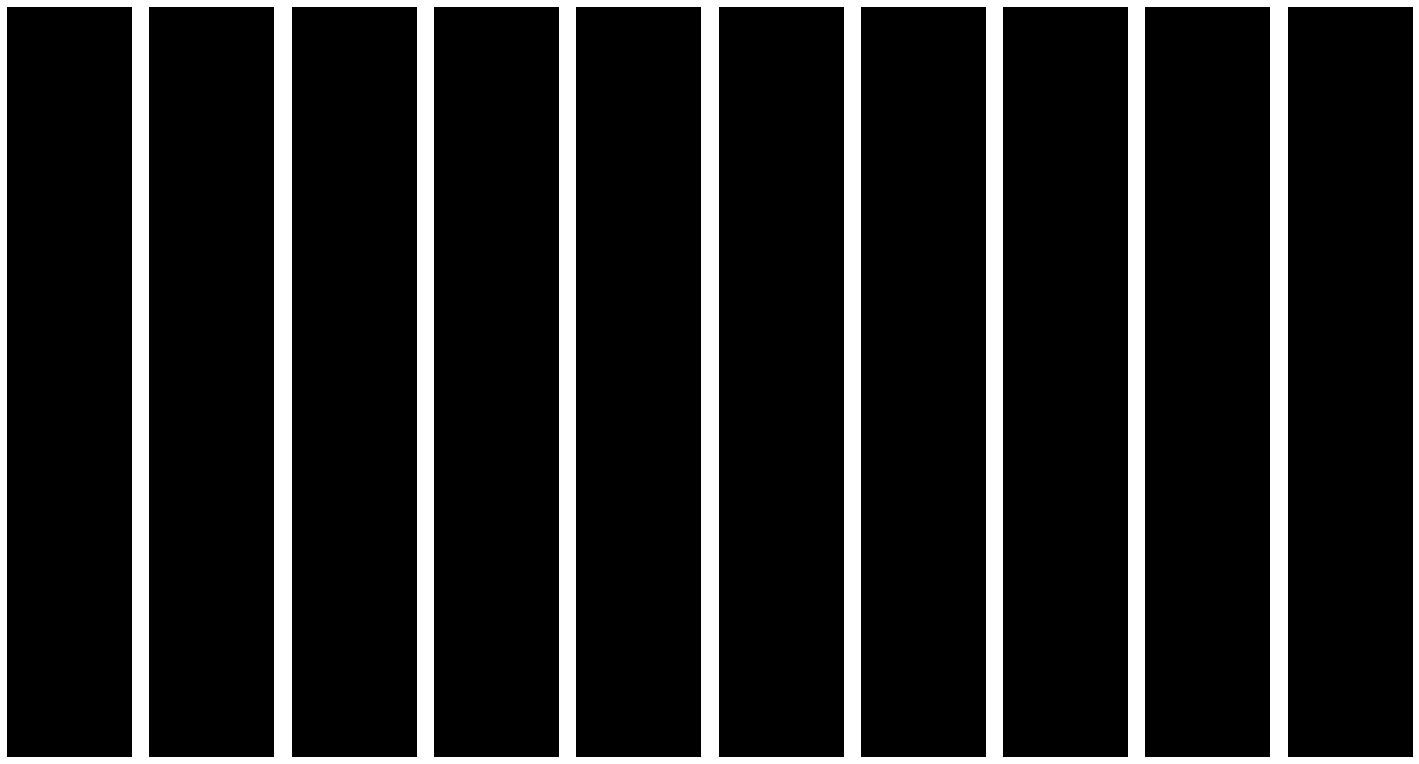

38/38 - 9s - loss: 1.4215 - d_loss: 0.6490 - g_loss: 0.7726 - 9s/epoch - 238ms/step
Epoch 189/200


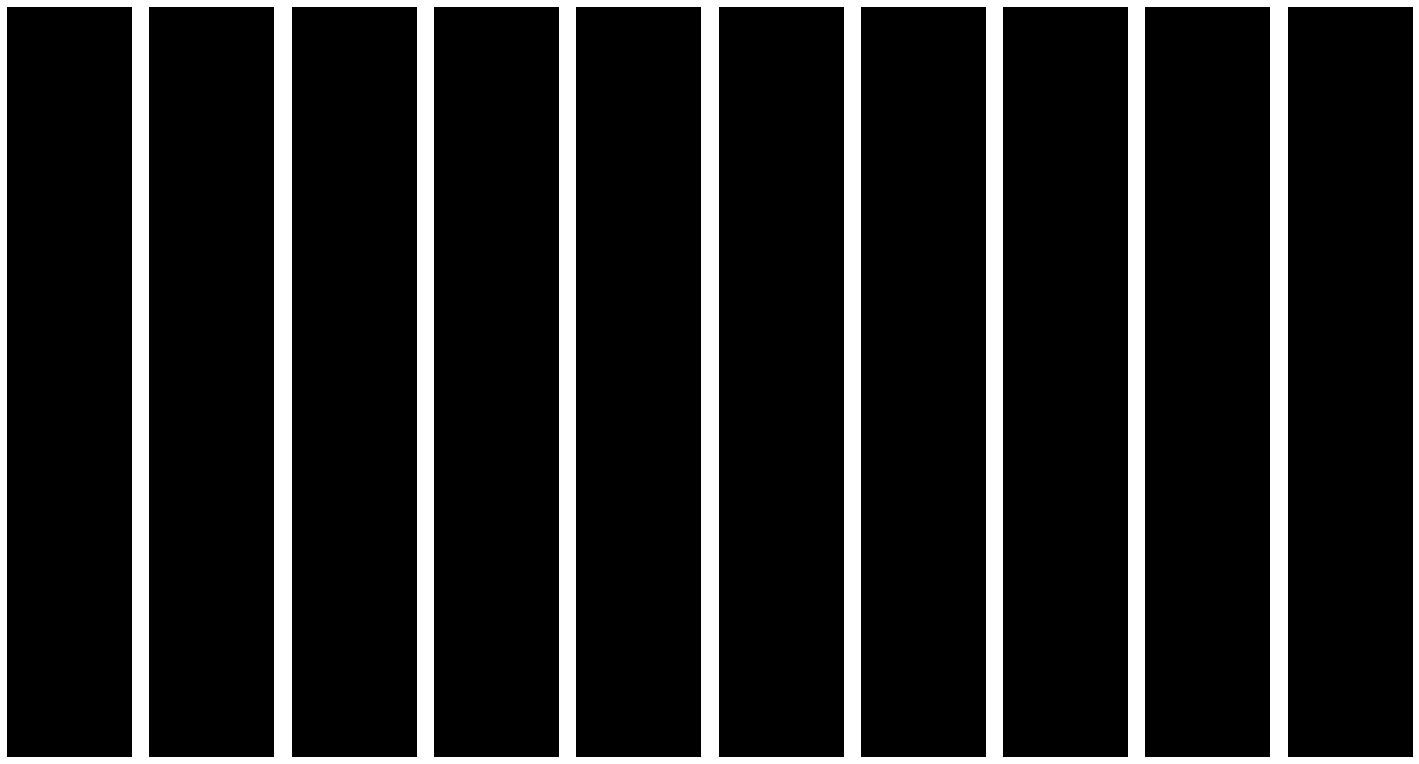

38/38 - 9s - loss: 1.4246 - d_loss: 0.6479 - g_loss: 0.7767 - 9s/epoch - 237ms/step
Epoch 190/200


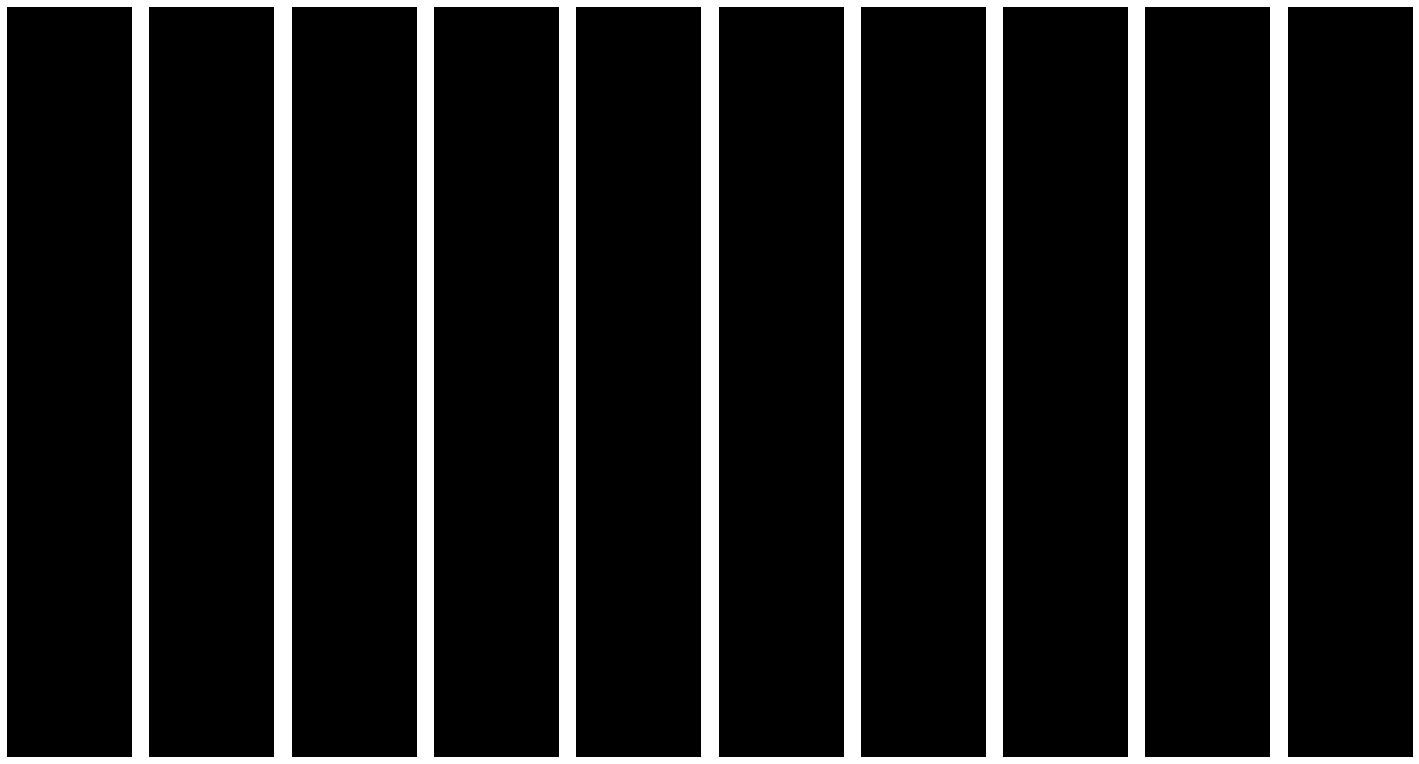

38/38 - 9s - loss: 1.4234 - d_loss: 0.6464 - g_loss: 0.7770 - 9s/epoch - 237ms/step
Epoch 191/200


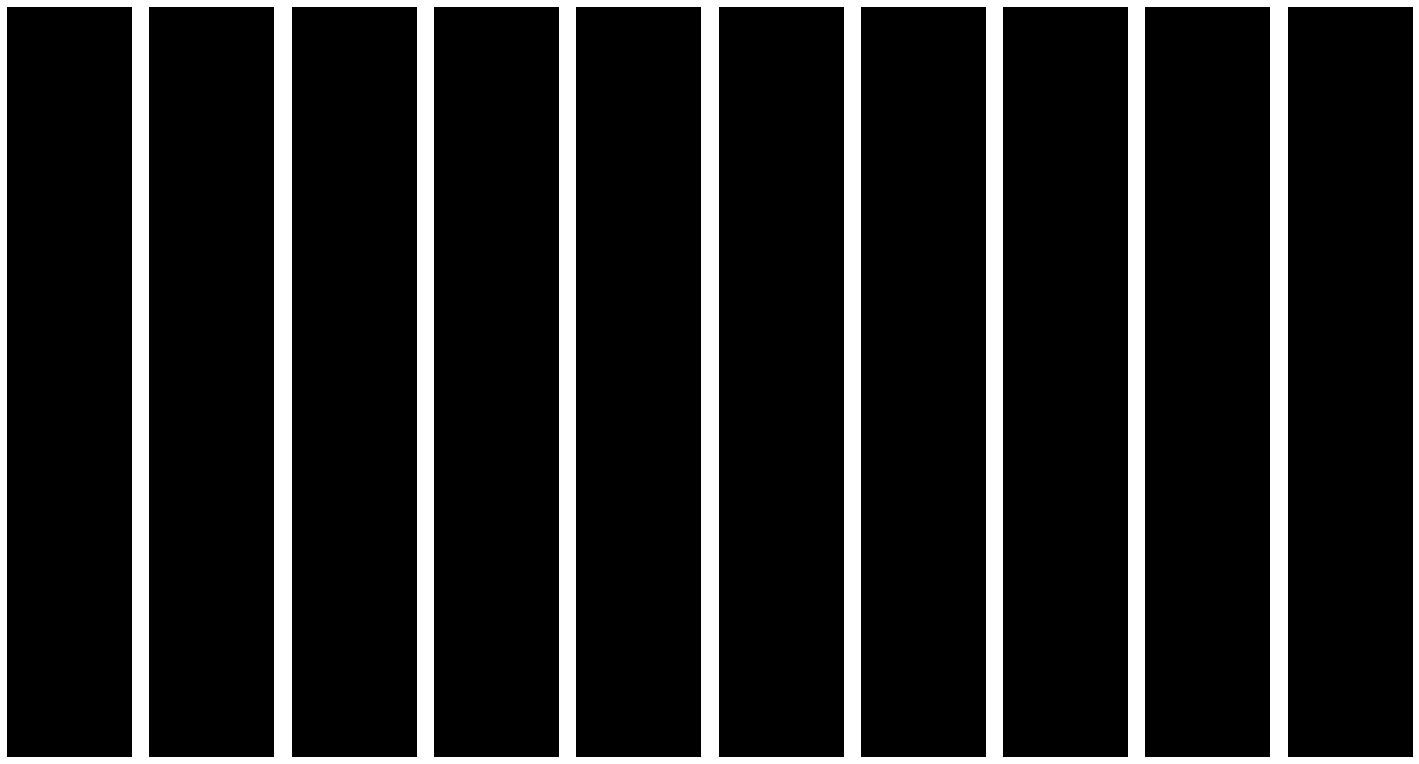

38/38 - 9s - loss: 1.4260 - d_loss: 0.6448 - g_loss: 0.7812 - 9s/epoch - 241ms/step
Epoch 192/200


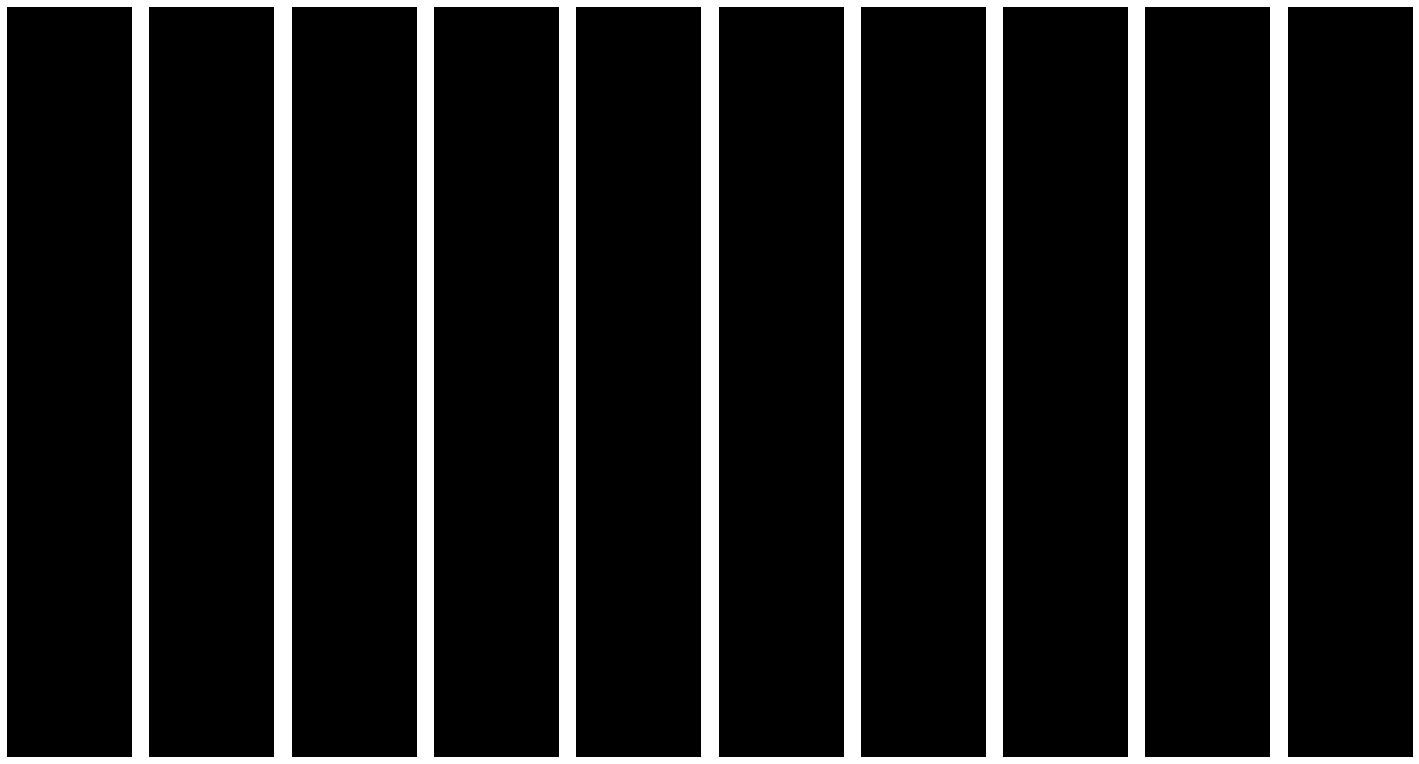

38/38 - 9s - loss: 1.4244 - d_loss: 0.6416 - g_loss: 0.7828 - 9s/epoch - 236ms/step
Epoch 193/200


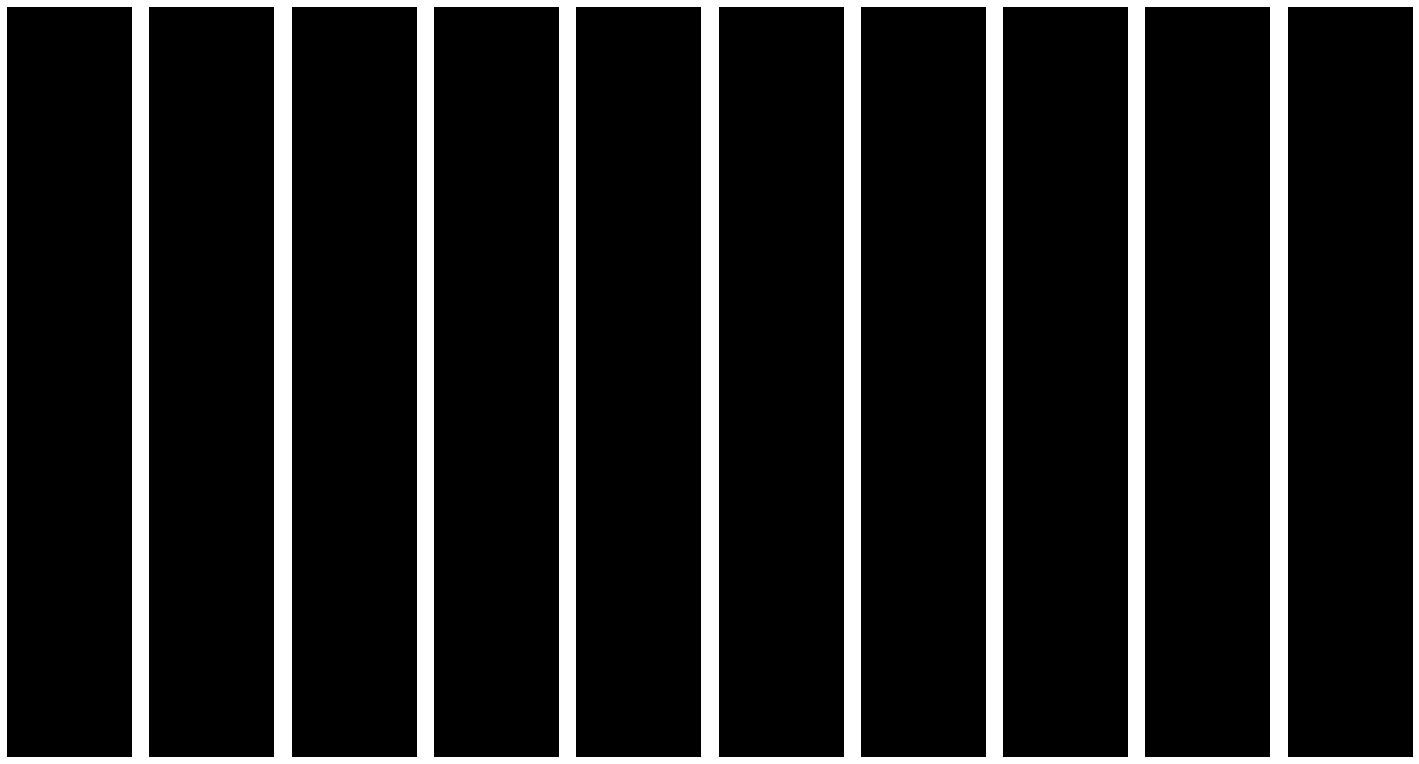

38/38 - 9s - loss: 1.4261 - d_loss: 0.6382 - g_loss: 0.7879 - 9s/epoch - 236ms/step
Epoch 194/200


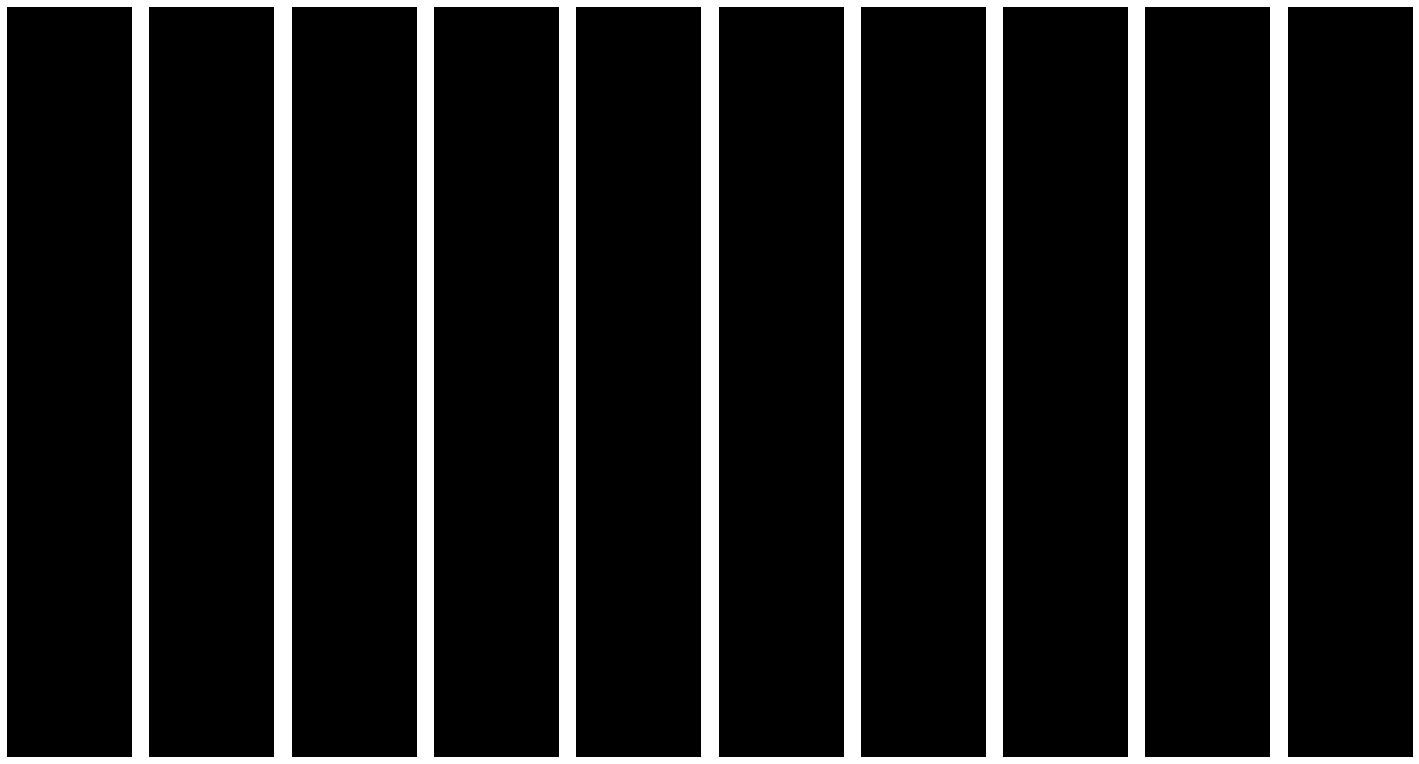

38/38 - 9s - loss: 1.4286 - d_loss: 0.6345 - g_loss: 0.7941 - 9s/epoch - 238ms/step
Epoch 195/200


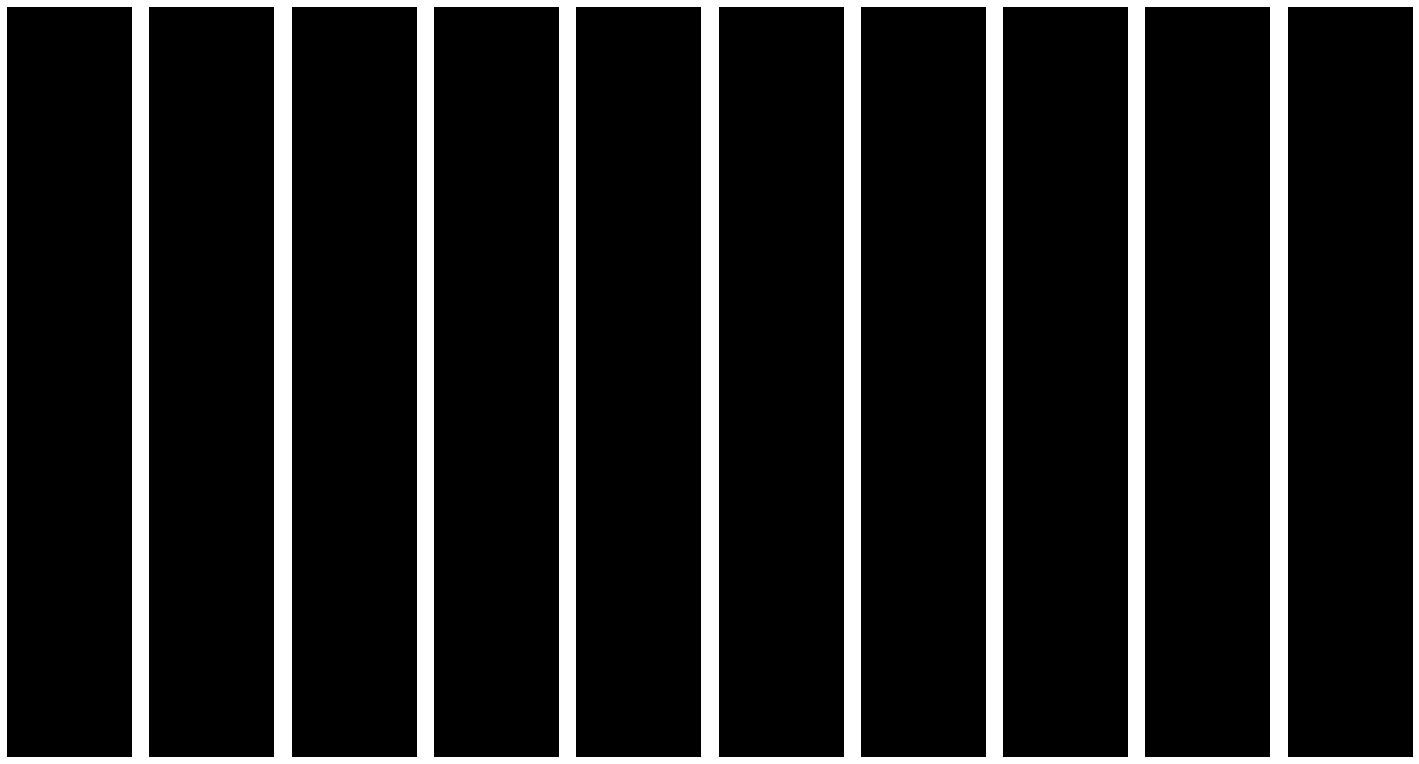

38/38 - 9s - loss: 1.4280 - d_loss: 0.6326 - g_loss: 0.7954 - 9s/epoch - 237ms/step
Epoch 196/200


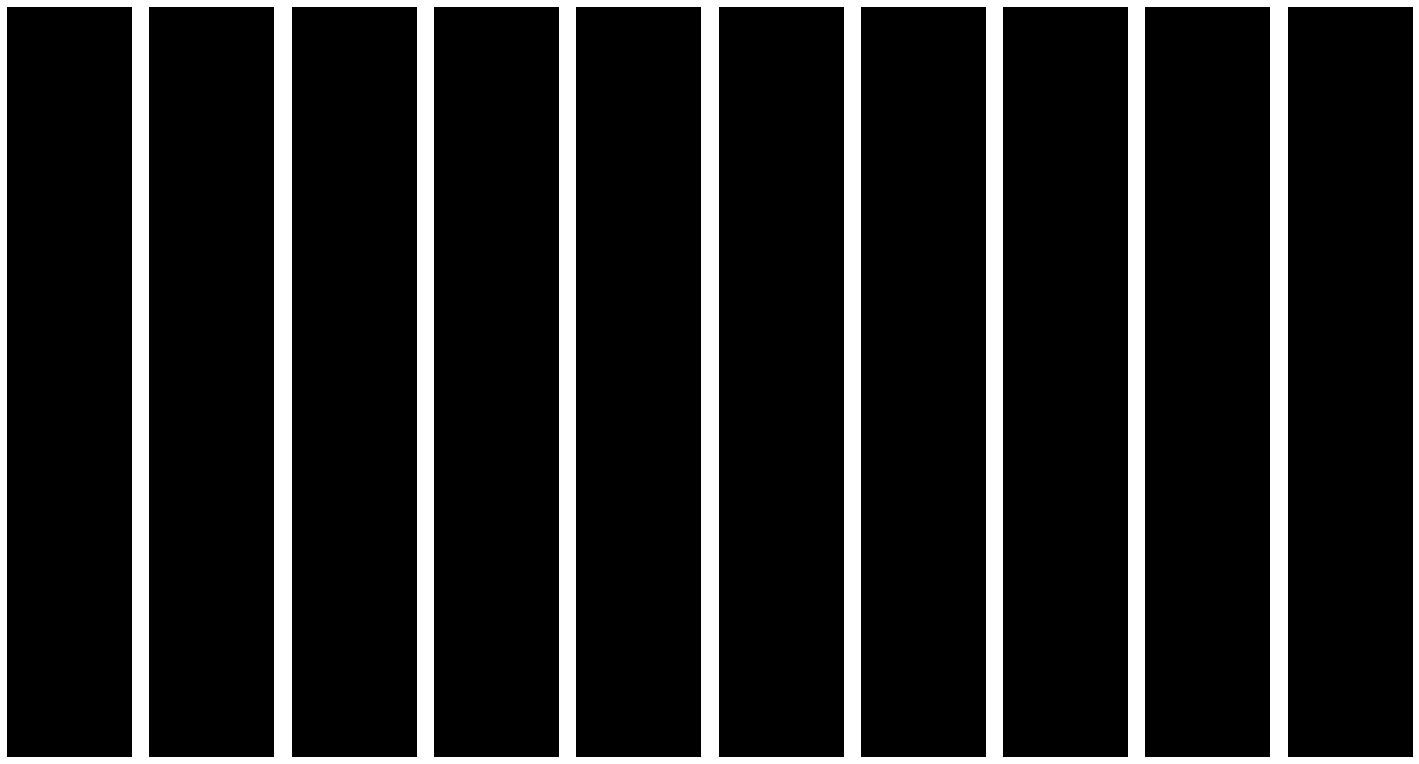

38/38 - 9s - loss: 1.4282 - d_loss: 0.6308 - g_loss: 0.7974 - 9s/epoch - 241ms/step
Epoch 197/200


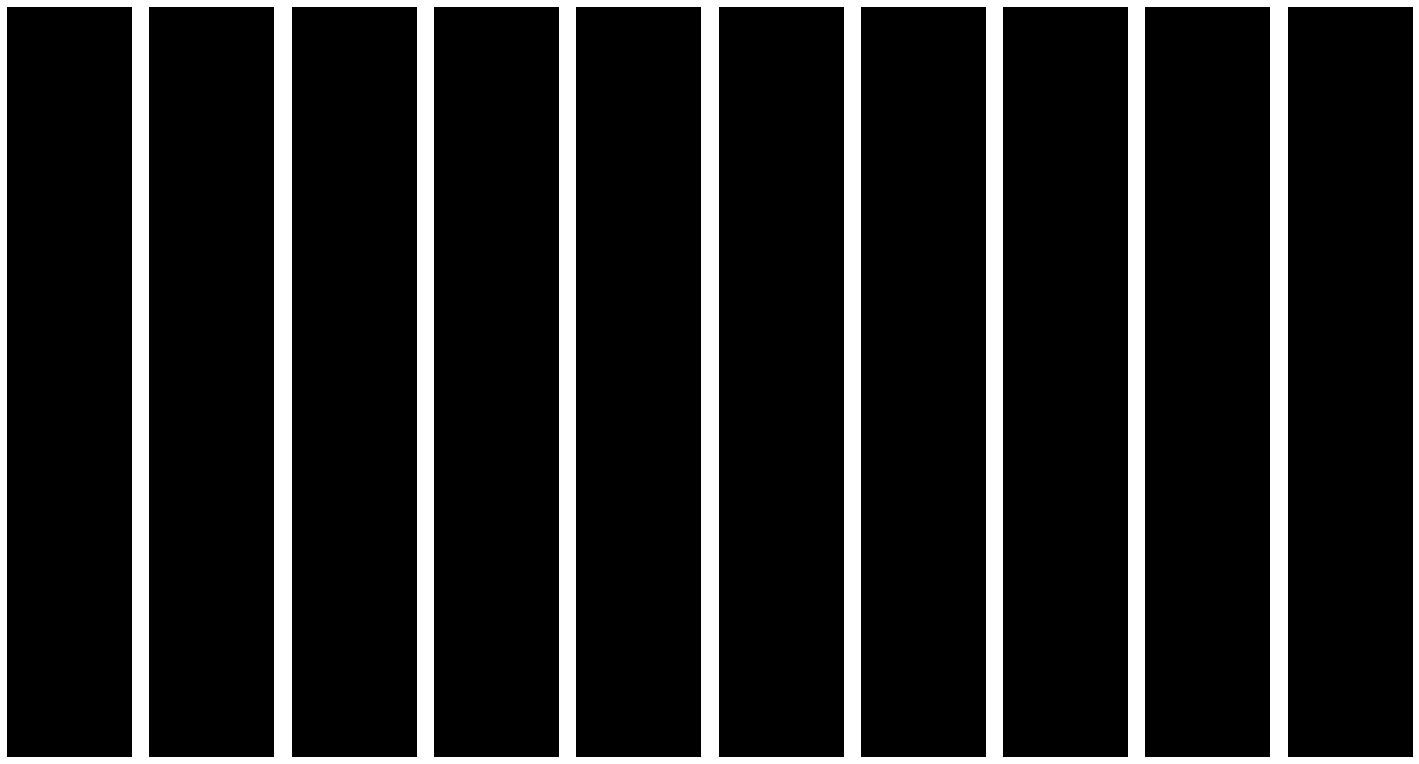

38/38 - 9s - loss: 1.4309 - d_loss: 0.6274 - g_loss: 0.8036 - 9s/epoch - 236ms/step
Epoch 198/200


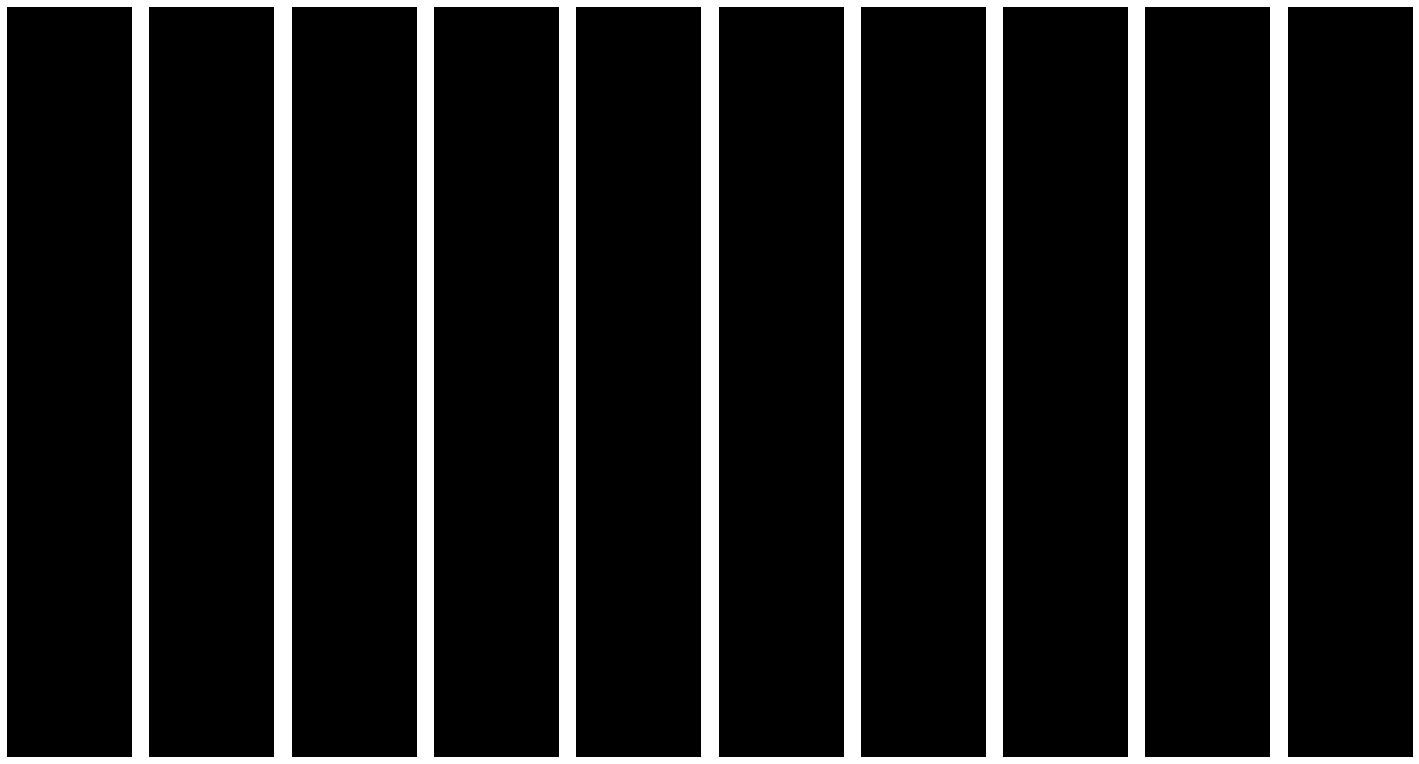

38/38 - 9s - loss: 1.4294 - d_loss: 0.6259 - g_loss: 0.8035 - 9s/epoch - 237ms/step
Epoch 199/200


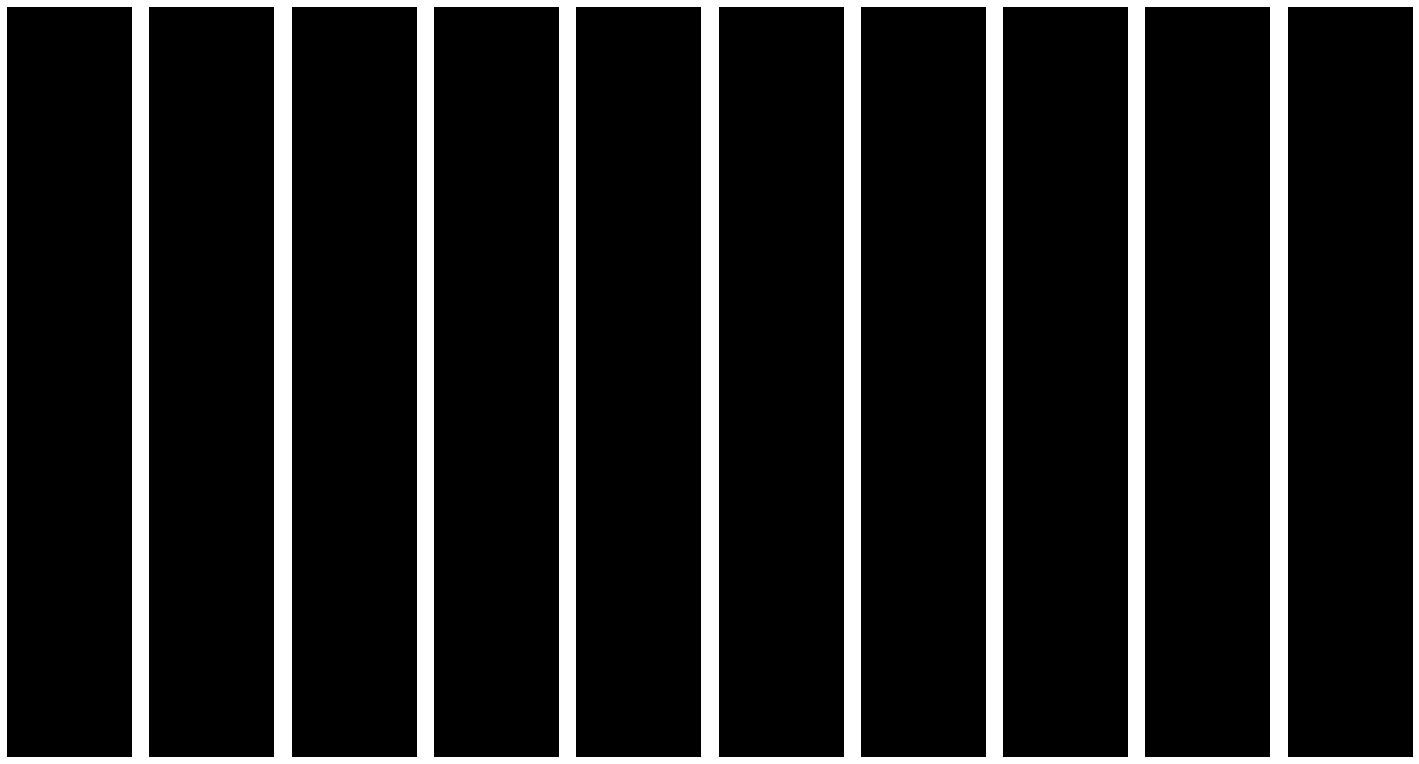

38/38 - 9s - loss: 1.4344 - d_loss: 0.6247 - g_loss: 0.8097 - 9s/epoch - 236ms/step
Epoch 200/200


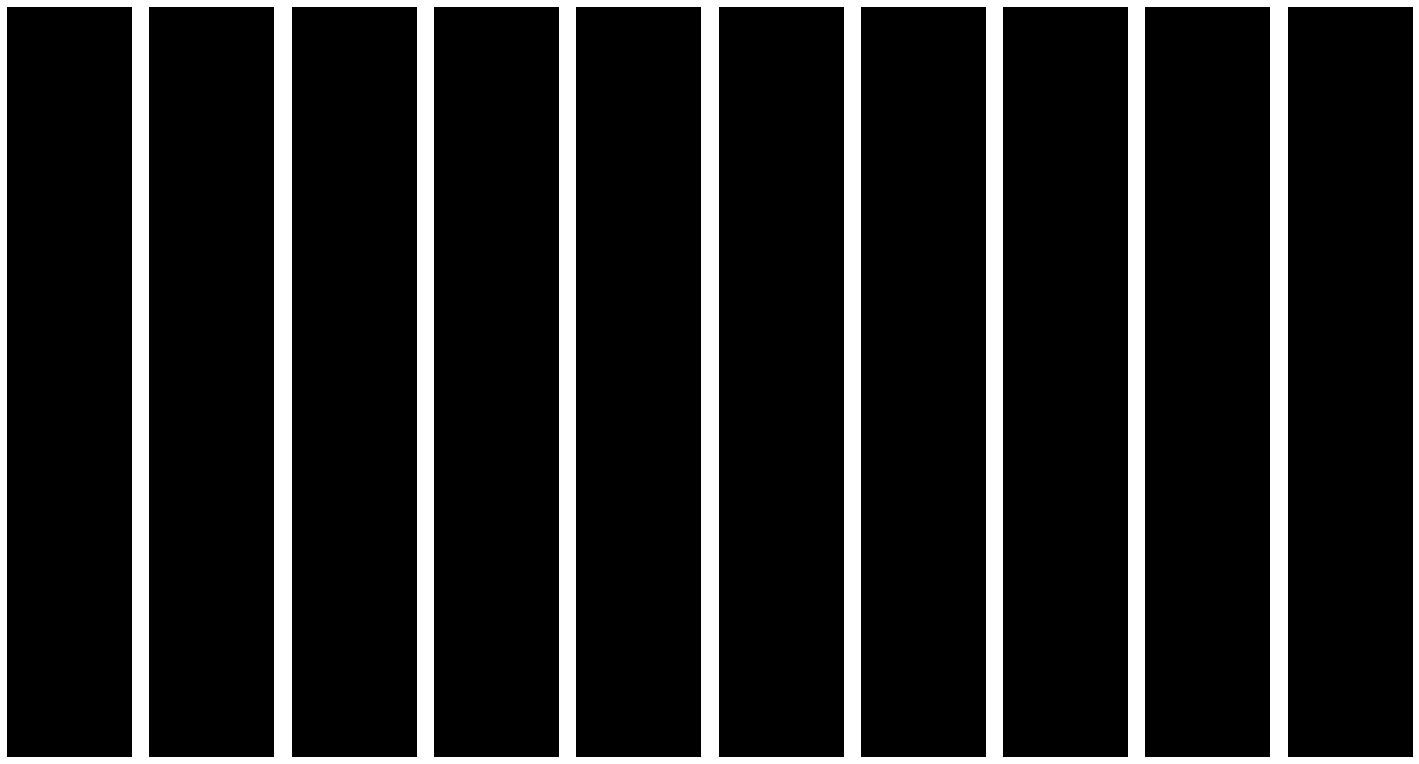

38/38 - 9s - loss: 1.4320 - d_loss: 0.6230 - g_loss: 0.8090 - 9s/epoch - 236ms/step


In [ ]:
c_history = cgan.fit(
    dataset, 
    epochs = epochs, 
    callbacks = [ConditionalGANMonitor(name='conditional', gray=True)],
    verbose = 2
).history

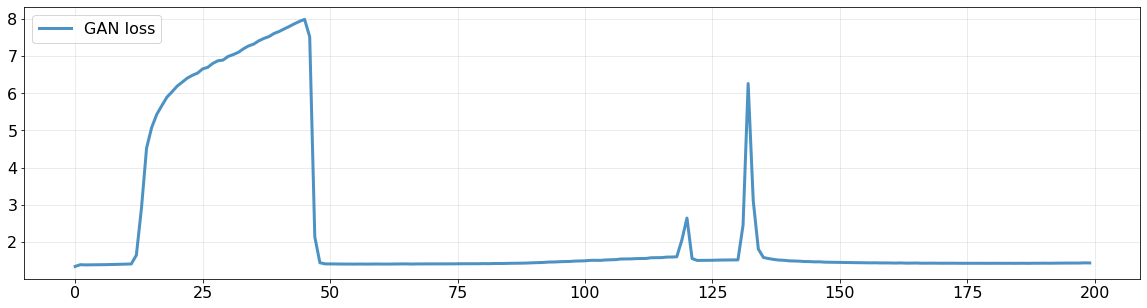

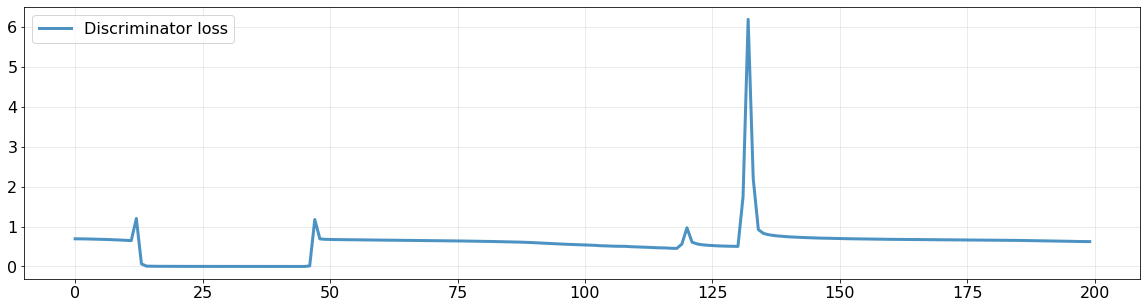

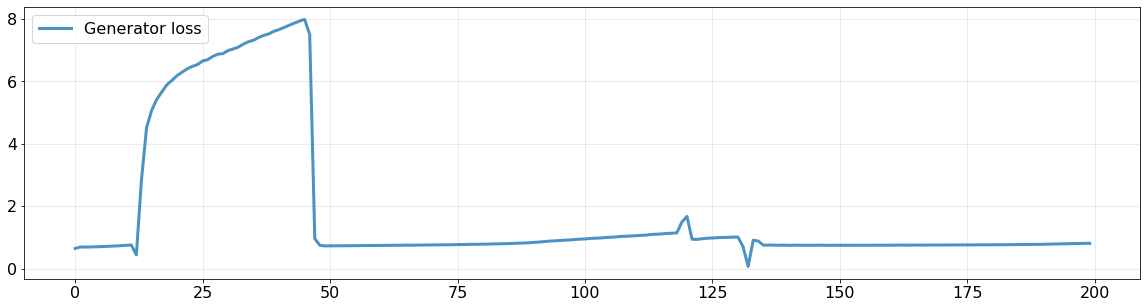

In [ ]:
# Plot the training
plt.figure(figsize=(20,5))
plt.plot(c_history['loss'], label='GAN loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['d_loss'], label='Discriminator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)

plt.figure(figsize=(20,5))
plt.plot(c_history['g_loss'], label='Generator loss', alpha=.8, linewidth=3)
plt.legend(loc='upper left')
plt.grid(alpha=.3)
plt.show()

In [ ]:
cgan.generator.save('conditional_gan_generator')

In [ ]:
conditional_gan_generator = tfk.models.load_model('conditional_gan_generator')

In [ ]:
latent_dim=128

Function to generate new samples for a specific label

In [ ]:
def genDataset(num_img=100,n=10,label=None):
  generated_images, labels = generate_conditional_dataset(conditional_gan_generator,num_img=num_img, latent_dim=latent_dim, fixed=True, label=label)
  generated_images=generated_images.reshape(num_img,36,6)
  labels=list(map(np.argmax, labels))
  for i in range(n-1):
    img, l = generate_conditional_dataset(conditional_gan_generator,num_img=num_img, latent_dim=latent_dim, fixed=True, label=label)
    img=img.reshape(num_img,36,6)
    l=list(map(np.argmax, l))
    generated_images=np.concatenate((generated_images,img))
    labels=np.concatenate((labels,l))
  return generated_images,labels

Now we want to generate new samples for the classes where we have worst performance, which are the 4th and 7th class.

In [ ]:
img4,l4=genDataset(label=4)
img4.shape,l4.shape

((1000, 36, 6), (1000,))

In [ ]:
img7,l7=genDataset(label=7)
img7.shape,l7.shape

((1000, 36, 6), (1000,))

In [ ]:
def concataneteDataLabels(data1,label1,data2,label2):
  data_tot=np.concatenate((data1,data2))
  labels_tot=np.concatenate((label1,label2))
  return data_tot,labels_tot

In [ ]:
img47,l47=concataneteDataLabels(img4,l4,img7,l7)
img47.shape,l47.shape

((2000, 36, 6), (2000,))

The following is the function to enlarge the training set using the dataset generated by the GAN

In [ ]:
def data_processingExtra(data, target,extraData=None,extraLabel=None):

  X_train_val, X_test, y_train_val, y_test = train_test_split(data, target, test_size = 0.1, random_state=seed, stratify=target)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state=seed, stratify=y_train_val)
  if extraData is not None and extraLabel is not None:
    X_train,y_train=concataneteDataLabels(X_train,y_train,extraData,extraLabel)

  scaler=RobustScaler()
  scaler = scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
  pickle.dump(scaler, open('scalers/scaler.sav', 'wb'))

  ss = pickle.load(open('scalers/scaler.sav', 'rb'))
  X_train_scaled = ss.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_val_scaled = ss.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
  X_test_scaled = ss.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

  y_train_cat = tf.keras.utils.to_categorical(y_train)
  y_val_cat = tf.keras.utils.to_categorical(y_val)
  y_test_cat = tf.keras.utils.to_categorical(y_test)

  print(X_train_scaled.shape, y_train.shape, y_train_cat.shape)
  print(X_val_scaled.shape, y_val.shape, y_val_cat.shape)
  print(X_test_scaled.shape, y_test.shape, y_test_cat.shape)


  return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat

In [ ]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat= data_processingExtra(data, target,img47,l47)

(4186, 36, 6) (4186,) (4186, 12)
(243, 36, 6) (243,) (243, 12)


In [ ]:
X_train = X_train_scaled
y_train = y_train_cat
X_val = X_val_scaled
y_val = y_val_cat
X_test = X_test_scaled
y_test = y_test_cat
input_shape = X_train.shape[1:]
n_output = y_train.shape[-1]

Now let's try to use the new dataset on a Bidirectional Gru model with attention

In [ ]:
class Att(tf.keras.Model):
    def __init__(self, units):
        super(Att, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

Epoch 1/200
17/17 [==============================] - 18s 438ms/step - loss: 1.7712 - accuracy: 0.4104 - val_loss: 1.6626 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 2/200
17/17 [==============================] - 5s 292ms/step - loss: 1.2156 - accuracy: 0.5048 - val_loss: 1.3243 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 3/200
17/17 [==============================] - 5s 294ms/step - loss: 1.0750 - accuracy: 0.5275 - val_loss: 1.3469 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 4/200
17/17 [==============================] - 5s 296ms/step - loss: 0.9687 - accuracy: 0.5753 - val_loss: 1.0800 - val_accuracy: 0.6461 - lr: 0.0010
Epoch 5/200
17/17 [==============================] - 5s 295ms/step - loss: 0.8737 - accuracy: 0.5994 - val_loss: 1.3506 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 6/200
17/17 [==============================] - 5s 293ms/step - loss: 0.8482 - accuracy: 0.6056 - val_loss: 1.4852 - val_accuracy: 0.5103 - lr: 0.0010
Epoch 7/200
17/17 [==============================] - 5s 297ms/s

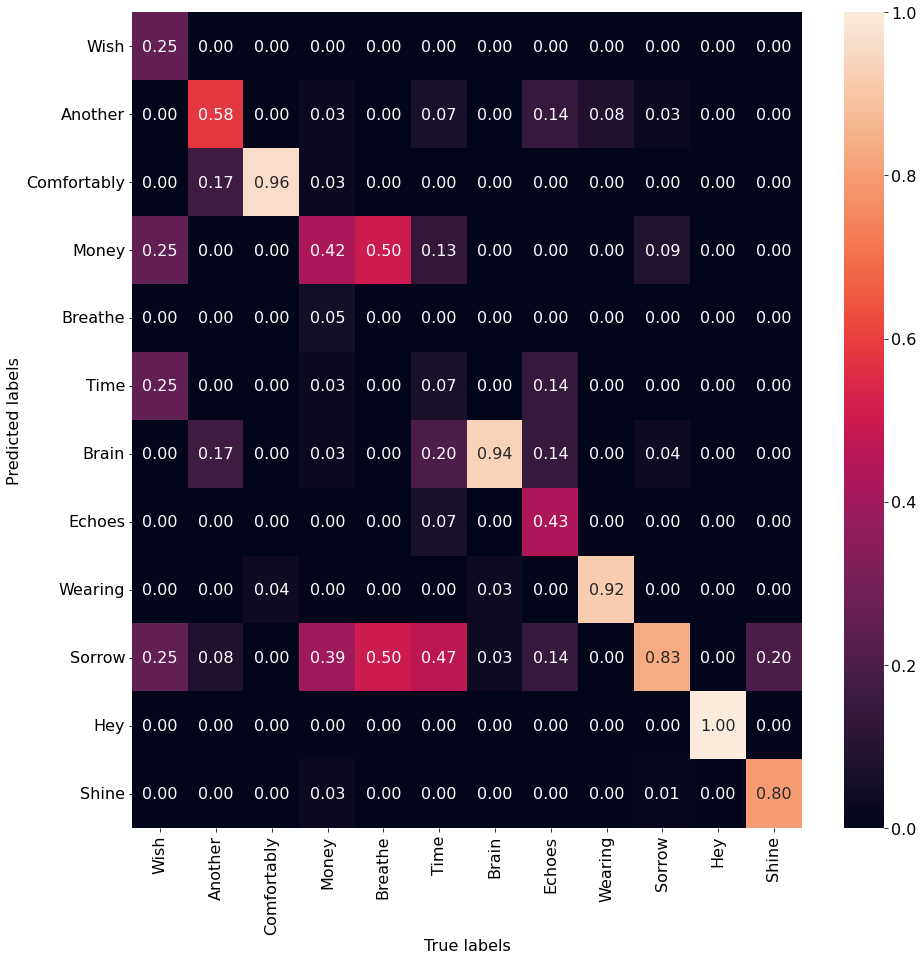

In [ ]:
def build_BiLSTM_Attention_Class(input_shape, classes):
  elastic_lambda=1e-7
  # Build the neural network layer by layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  input_layer = tfkl.Input(shape=input_shape, name='Input')

  lstm = tfkl.Bidirectional(tfkl.GRU(1024,activation='tanh',dropout=0.05, return_sequences = True), name="bi_lstm_0")(input_layer)
  lstm = tfkl.Bidirectional(tfkl.GRU(512,activation='tanh', return_sequences = True), name="bi_lstm_1")(lstm)
  lstm = tfkl.Bidirectional(tfkl.GRU(128,activation='tanh', return_sequences = True), name="bi_lstm_2")(lstm)
  # Getting our LSTM outputs
  (lstm, forward_h, forward_c, backward_h, backward_c) = tfkl.Bidirectional(tfkl.LSTM(512, activation='tanh',return_sequences=True, return_state=True), name="bi_lstm_3")(lstm)

  state_h = tfkl.Concatenate()([forward_h, backward_h])
  state_c = tfkl.Concatenate()([forward_c, backward_c])
  context_vector, attention_weights = Att(10)(lstm, state_h)
  dense1 = tfkl.Dense(1024,
                      kernel_initializer = tfk.initializers.HeUniform(seed),
                      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
                      )(context_vector) 
  dense1=tfkl.LeakyReLU()(dense1)
  dropout = tfkl.Dropout(0.5)(dense1)
  x=tfkl.BatchNormalization()(dropout)

  dense1 = tfkl.Dense(1024,
                      kernel_initializer = tfk.initializers.HeUniform(seed),
                      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
                      )(context_vector) 
  dense1=tfkl.LeakyReLU()(dense1)
  
  dense1 = tfkl.Dense(1024,
                      kernel_initializer = tfk.initializers.HeUniform(seed),
                      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda)
                      )(context_vector) 
  dense1=tfkl.LeakyReLU()(dense1)
  dropout = tfkl.Dropout(0.5)(dense1)
  
  x=tfkl.BatchNormalization()(dropout)
  x=tfkl.BatchNormalization()(x)

  output_layer = tfkl.Dense(12, activation='softmax',
                            kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

  model = tfk.Model(inputs=input_layer, outputs=output_layer)

  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

  # Return the model
  return model

model=build_BiLSTM_Attention_Class(input_shape, y_train.shape[-1])

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs = 200,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.25, min_lr=1e-7)
    ]
).history

ret = evaluate_model_m(model, X_test, y_test, classes)

In [ ]:
model.save('ANN&DL_Model/biLSTM_ATT_GAN')